# Introduction

This notebook is a Jupyter based implementation of the DeepPATH machine learning work reported in https://www.nature.com/articles/s41591-018-0177-5. 

DeepPATH performed two investigations:
- Training Inception V3 to classify TCGA pathology images of normal, LUAD and LUSC tumors
- Training Inception V3 with TCGA LUAD cancer images to classify mutations that were called on the genomic data associated with each image.

This notebook has roughly six stages:

After this stage 1 intro, stage 2 defines various configuration values that are specific to subsequent stages. The overall configuration defines a directory hierarchy that is specific to certain parameters of the various stages. This should, in theory, allow creation of the a directory tree that supports reuse of results in earlier stages by later stages having differing parameters. Stage 2 also obtains metadata from ISB-CGC maintained BQ tables, rather than from TCIA and GDC, as the authors of the table did.  

Stage 3 obtains the set of slides, that were identified by the metadata extracted from BQ in stage 2, from an ISB-CGC maintained bucket, and then performs tiling on those slides.

Each of the remaining 3 stages performs some combination of tile sorting, training/validation/testing and analysis (ROC curve generation and display and heatmap generation/display). We refer to each of these as a phase.

Stage 4 (Phase 0) performs fine tuning of Inception V3 for tumor classification. 

Stage 5 (Phase 1) uses the trained model from stage 4 to classify all tiles from LUAD tumor files (doesn't 
include LUAD slides graded as normal tissue).

Stage 6 (Phase 2) performs Inception V3 training from scratch to utations in LUAD tiles/slides. It uses the results of stage, including only tiles from LUAD slides that the are actually classified as LUAD.

Note that many of the steps in this pipeline run for a considerable amount of time. Training, in particular, will run as long as you let it.


# Configure the notebook

## Define some basic constants.

This includes the location of the DeepPATH repo, as well as base paths where results and other data are saved. The deeppath_code and deeppath_data variables should be initialized to the location on your system where the DeepPATH repo was cloned and where you want data to be placed.

We place results into a configuration specific directory tree rooted at the value data_base defined below. The names of sub-directories are derived from tiling, sorting and training parameters.


In [34]:
import os, sys, json, shutil
from os.path import join
import psutil
from utilities import completed_batches, draw_rocs
from time import asctime

num_cpus = psutil.cpu_count()
num_gpus = !nvidia-smi -L | grep Tesla | wc -l
num_gpus = int(num_gpus[0])
batch_size_per_gpu = 30
batch_size = num_gpus * batch_size_per_gpu
print("num_cpus: {}, num_gpus: {}, batch_size: {}".format(num_cpus, num_gpus, batch_size))


deeppath_code = join(os.environ['HOME'],'DeepPATH/DeepPATH_code')
deeppath_data = '/mnt/disks/deeppath-data'
data_base = join(deeppath_data,'Data')
raw_images = join(data_base,'Raw')
data_labels = join(data_base,'data_labels')
#tilings = join(data_base,'tilings')
inception_checkpoints = join(deeppath_data,'inception_checkpoints')


for d in (deeppath_data, data_base, raw_images, inception_checkpoints):
  try:
    os.makedirs(d)
    print("{} created".format(d))
  except:
    print("{} exists".format(d))
    
if not os.path.isdir(join(inception_checkpoints,'inception-v3')):
    !curl -o $inception_checkpoints/inception-v3-2016-03-01.tar.gz http://download.tensorflow.org/models/image/imagenet/inception-v3-2016-03-01.tar.gz
    !tar -C $inception_checkpoints -xvf $inception_checkpoints/inception-v3-2016-03-01.tar.gz
    !rm $inception_checkpoints/inception-v3-2016-03-01.tar.gz


num_cpus: 2, num_gpus: 0, batch_size: 0
/mnt/disks/deeppath-data exists
/mnt/disks/deeppath-data/Data exists
/mnt/disks/deeppath-data/Data/Raw exists
/mnt/disks/deeppath-data/inception_checkpoints exists


In [35]:
# Various GCS buckets and relevant defines
cgc_deeppath_bucket = 'cgc-deeppath' # Bucket containing users credentials
deeppath_data_bucket = 'deeppath-data-whc' # Bucket where results are saved

svs_images_bucket = 'imaging-west'# Bucket containing TCGA pathology images


## Tiling parameters

Note that Inception V3 wants 299 pixel tiles; any other size will be scaled by tensor flow before submission to the model. In other words, leave tile_size at 299 and overlap at 0.

In [46]:
tile_size = 299
overlap = 0
background = 25
magnification = 20
tiling_params = "Px{}Ol{}Bg{}Mg{}_Tile".format(str(tile_size), str(overlap), str(background),str(magnification))
tiling = join(data_base, tiling_params)
tiling_logs = join(tiling,'logs')
# Directory where tiles are stored              
tiles = join(tiling,'tiles')
tu_images_metadata_path = join(tiling, 'tu_images_metadata.json') # Name of tumor classification images metadata file (which will be created below)
luad_images_metadata_path = join(tiling, 'luad_images_metadata.json') # Name of LUAD-only tumor classification images metadata file (which will be created below)
mu_images_metadata_path = join(tiling, 'mu_images_metadata.json') # Name of mutations classification images metadata file (which will be created below)
mutations_metadata_path = join(tiling, 'mutations_metadata.txt') # Path to mutations metadata file

for _dir in (tiling, tiling_logs, tiles):
    if not os.path.isdir(_dir):
        os.makedirs(_dir)
        print("{} created".format(_dir))
    else:
        print("{} exists".format(_dir))

print("tiling_params: {}".format(tiling_params))
print("tiling: {}".format(tiling))
print("tiling_logs: {}".format(tiling_logs))
print("tiles: {}".format(tiles))
print("tu_images_metadata_path: {}".format(tu_images_metadata_path))
print("luad_images_metadata_path: {}".format(luad_images_metadata_path))
print("mu_images_metadata_path: {}".format(mu_images_metadata_path))
print("mutations_metadata_path: {}".format(mutations_metadata_path))

/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/logs exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/tiles exists
tiling_params: Px299Ol0Bg25Mg20_Tile
tiling: /mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile
tiling_logs: /mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/logs
tiles: /mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/tiles
tu_images_metadata_path: /mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/tu_images_metadata.json
luad_images_metadata_path: /mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/luad_images_metadata.json
mu_images_metadata_path: /mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/mu_images_metadata.json
mutations_metadata_path: /mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/mutations_metadata.txt


## Pipeline phases

After tiling there are three phases to the pipeline:

0. Phase 0 performs fine tuning of the Inception V3 model for mutation classification
1. Phase 1 performs tumor classification on all LUAD tiles, using the fine tuned classifier from phase 0
2. Phase 2 performs scratch training on the Inception V3 using the tiles classified as LUAD in phase 1.

In [37]:
# A phase is defined by a collection of configuration parameters
class phase:
    def __init__(self):
        self.sorting_option = 0
        self.sorting_params = ""
        self.sorting_path = ""
        self.sorting = ""
        self.images_metadata_path = ""
        self.ImageSet_basename = ""
        self.data_labels_path = ""
        self.sorting_logs = ""
        self.sorted_tiles = ""
        self.trainValid_records = ""
        self.test_records = ""
        self.fine_tune = ""
        self.initial_learning_rate = ""
        self.training_mode = ""
        self.class_number = ""
        self.PercentValid = ""
        self.PercentTest = ""
        self.training_params = ""
        self.training_path = ""
        self.training = ""
        self.training_logs = ""
        self.pretrained_checkpoints = ""
        self.intermediate_checkpoints = ""
        self.eval_results = ""
        self.test_results = ""
        self.roc_curves = ""
        self.heatmaps = ""
        
    def print_state(self):
        print("")
        print("data_labels_path: \t{}".format(self.data_labels_path))
        print("images_metadata_path: \t{}".format(self.images_metadata_path))
        print("sorting_option: \t{}".format(self.sorting_option))
        print("sorting_params: \t{}".format(self.sorting_params))
        print("sorting_path: \t{}".format(self.sorting_path))
        print("sorting: \t{}".format(self.sorting))
        print("sorting_logs: \t{}".format(self.sorting_logs))
        print("sorted_tiles: \t{}".format(self.sorted_tiles))
        print("trainValid_records: \t{}".format(self.trainValid_records))
        print("ImageSet_basename: \t{}".format(self.ImageSet_basename))
        print("test_records: \t{}".format(self.test_records))
        print("")
        print("fine_tune: \t{}".format(self.fine_tune))
        print("initial_learning_rate: \t{}".format(self.initial_learning_rate))
        print("training_mode: \t{}".format(self.training_mode))
        print("class_number: \t{}".format(self.class_number))
        print("PercentValid: \t{}".format(self.PercentValid))
        print("PercentTest: \t{}".format(self.PercentTest))
        print("training_params: \t{}".format(self.training_params))
        print("training_path: \t{}".format(self.training_path))
        print("training: \t{}".format(self.training))
        print("training_logs: \t{}".format(self.training_logs))
        print("pretrained_checkpoints: \t{}".format(self.pretrained_checkpoints))
        print("intermediate_checkpoints: \t{}".format(self.intermediate_checkpoints))
        print("")
        print("eval_results: \t{}".format(self.eval_results))
        print("test_results: \t{}".format(self.test_results))
        print("roc_curves: \t{}".format(self.roc_curves))
        print("heatmaps: \t{}".format(self.heatmaps))        

phases = [phase(), phase(), phase()]
# Aliases for phase state:
p0 = phases[0]
p1 = phases[1]
p2 = phases[2]


### Phase 0 parameters

#### Sorting parameter

In [38]:
p0.PercentValid = 15.0
p0.PercentTest = 15.0
p0.sorting_option = 3 
p0.sorting_params = 'So{}_Sort'.format(p0.sorting_option)
p0.sorting_path = join(tiling_params,p0.sorting_params)
p0.sorting = join(data_base, p0.sorting_path)
p0.images_metadata_path = tu_images_metadata_path
p0.ImageSet_basename = 'valid_'
p0.data_labels_path = join(os.environ['HOME'],'jupyter_DeepPATH','tumor_labels.txt')
p0.sorting_logs = join(p0.sorting, 'logs')
p0.sorted_tiles = join(p0.sorting, 'sorted')
p0.trainValid_records = join(p0.sorting, 'TFRecord_TrainValid')
p0.test_records = join(p0.sorting, 'TFRecord_Test')

# Directories where sharded tensor flow formatted records are stored
for _dir in (p0.sorting, p0.sorting_logs, p0.sorted_tiles, p0.trainValid_records, p0.test_records):
#    dir = params[phase][param]
    if not os.path.isdir(_dir):
        os.makedirs(_dir)
        print("{} created".format(_dir))
    else:
        print("{} exists".format(_dir))

p0.print_state()

/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/logs exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/sorted exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test exists

data_labels_path: 	/home/bcliffor/jupyter_DeepPATH/tumor_labels.txt
images_metadata_path: 	/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/tu_images_metadata.json
sorting_option: 	3
sorting_params: 	So3_Sort
sorting_path: 	Px299Ol0Bg25Mg20_Tile/So3_Sort
sorting: 	/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort
sorting_logs: 	/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/logs
sorted_tiles: 	/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/sorted
trainValid_records: 	/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid
ImageSet_basename:

#### Training, validation, test, and  parameters

In [39]:
p0.fine_tune = True 
p0.initial_learning_rate = 0.001
# Use softmax for multiclass classification
p0.training_mode = '0_softmax' 
p0.class_number = '3' # Number of tumor classes.

#trainings = join(sorting, p0.trainings)
p0.training_params = "Cl{}Ft{}_Train".format(p0.class_number,p0.fine_tune)
p0.training_path = join(p0.sorting_path,p0.training_params)
p0.training = join(data_base, p0.training_path)
p0.training_logs = join(p0.training,'logs')

# Directory where pretrained checkpoints are stored
p0.pretrained_checkpoints = join(p0.training, 'pretrained_checkpoints')
# Directory where intermediate training checkpoints are stored
p0.intermediate_checkpoints = join(p0.training, 'intermediate_checkpoints')
# Directory where validation and test results are stored
p0.eval_results = join(p0.training, 'eval_results')
p0.test_results = join(p0.training, 'test_results')
p0.roc_curves = join(p0.training, 'roc_curves')
p0.heatmaps = join(p0.training,'heatmaps_Px'+ str(tile_size))

for _dir in (p0.training, p0.training_logs, p0.intermediate_checkpoints, p0.pretrained_checkpoints,
         p0.eval_results, p0.test_results, p0.roc_curves):
    if not os.path.isdir(_dir):
        os.makedirs(_dir)
        print("{} created".format(_dir))
    else:
        print("{} exists".format(_dir))
        
p0.print_state()

/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/logs exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/intermediate_checkpoints exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/pretrained_checkpoints exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/eval_results exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/test_results exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/roc_curves exists

data_labels_path: 	/home/bcliffor/jupyter_DeepPATH/tumor_labels.txt
images_metadata_path: 	/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/tu_images_metadata.json
sorting_option: 	3
sorting_params: 	So3_Sort
sorting_path: 	Px299Ol0Bg25Mg20_Tile/So3_Sort
sorting: 	/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/S

### Phase 1 parameters

#### Sorting parameter

In [40]:
p1.PercentValid = 0.0
p1.PercentTest = 100.0
p1.sorting_option = 4 # Exclude tiles from normal tissue slides
p1.sorting_params = 'So{}_Sort'.format(p1.sorting_option) 
p1.sorting_path = join(p0.training_path,p1.sorting_params)
p1.sorting = join(data_base, p1.sorting_path) 
p1.images_metadata_path = luad_images_metadata_path
p1.ImageSet_basename = 'valid_'
p1.data_labels_path = join(os.environ['HOME'],'jupyter_DeepPATH','tumor_labels.txt')
p1.sorting_logs = join(p1.sorting, 'logs')
p1.sorted_tiles = join(p1.sorting, 'sorted')
p1.trainValid_records = join(p1.sorting, 'TFRecord_TrainValid')
p1.test_records = join(p1.sorting, 'TFRecord_Test')

# Directories where sharded tensor flow formatted records are stored
for _dir in (p1.sorting, p1.sorting_logs, p1.sorted_tiles, p1.trainValid_records, p1.test_records):
    if not os.path.isdir(_dir):
        os.makedirs(_dir)
        print("{} created".format(_dir))
    else:
        print("{} exists".format(_dir))
        
p1.print_state()

/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/logs exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/sorted exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_TrainValid exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test exists

data_labels_path: 	/home/bcliffor/jupyter_DeepPATH/tumor_labels.txt
images_metadata_path: 	/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/luad_images_metadata.json
sorting_option: 	4
sorting_params: 	So4_Sort
sorting_path: 	Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort
sorting: 	/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort
sorting_logs: 	/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/logs
s

#### Training, validation, test, and  parameters

In [41]:
p1.fine_tune = True 
p1.initial_learning_rate = 0.001
# Use softmax for multiclass classification
p1.training_mode = '0_softmax' 
p1.class_number = 3 # Number of tumor classes.
p1.training_params = "Cl{}Ft{}_Train".format(str(p1.class_number),str(p1.fine_tune))
p1.training_path = join(p1.sorting_path, p1.training_params)
p1.training = join(data_base, p1.training_path)
p1.training_logs = join(p1.training, 'logs')
# Directory where pretrained checkpoints are stored
p1.pretrained_checkpoints = join(p1.training, 'pretrained_checkpoints')
# Directory where intermediate training checkpoints are stored
p1.intermediate_checkpoints = join(p1.training, 'intermediate_checkpoints')
# Directory where validation and test results are stored
p1.eval_results = join(p1.training, 'eval_results')
p1.test_results = join(p1.training, 'test_results')
p1.roc_curves = join(p1.training, 'roc_curves')
p1.heatmaps = join(p1.training,'heatmaps_Px'+str(tile_size))

for _dir in (p1.training, p1.training_logs, p1.intermediate_checkpoints, p1.pretrained_checkpoints,
         p1.eval_results, p1.test_results, p1.roc_curves):
    if not os.path.isdir(_dir):
        os.makedirs(_dir)
        print("{} created".format(_dir))
    else:
        print("{} exists".format(_dir))
        
p1.print_state()   

/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/logs exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/intermediate_checkpoints exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/pretrained_checkpoints exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/eval_results exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/test_results exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/roc_curves exists

data_labels_path: 	/home/bcliffor/jupyter_DeepPATH/tumor_labels.txt
images_metadata_path: 	/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/lua

### Phase 2 parameters

#### Sorting parameter

In [42]:
p2.PercentValid = 15.0
p2.PercentTest = 15.0
p2.sorting_option = 10
p2.sorting_params = 'So{}_Sort'.format(p2.sorting_option)
p2.sorting_path = join(p1.training_path,p2.sorting_params)
p2.sorting = join(data_base, p2.sorting_path)
p2.images_metadata_path = tu_images_metadata_path
p2.ImageSet_basename = 'valid-'
p2.data_labels_path = join(p2.sorting, 'hugo_symbols.txt')
p2.sorting_logs = join(p2.sorting, 'logs')
p2.sorted_tiles = join(p2.sorting, 'sorted')
p2.trainValid_records = join(p2.sorting, 'TFRecord_TrainValid')
p2.test_records = join(p2.sorting, 'TFRecord_Test')

# Directories where sharded tensor flow formatted records are stored
for _dir in (p2.sorting, p2.sorting_logs, p2.sorted_tiles, p2.trainValid_records, p2.test_records):
    if not os.path.isdir(_dir):
        os.makedirs(_dir)
        print("{} created".format(_dir))
    else:
        print("{} exists".format(_dir))
        
p2.print_state()

/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/So10_Sort exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/So10_Sort/logs exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/So10_Sort/sorted exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/So10_Sort/TFRecord_TrainValid exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/So10_Sort/TFRecord_Test exists

data_labels_path: 	/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/So10_Sort/hugo_symbols.txt
images_metadata_path: 	/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/tu_images_metadata.json
sorting_option: 	10
sorting_params: 	So10_Sort
sorting_path: 	Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So

#### Training, validation, test, and  parameters

In [43]:
p2.fine_tune = False 
p2.initial_learning_rate = 0.1
# Use sigmoid for multi-class classification
p2.training_mode = '1_sigmoid'
p2.class_number = 10 # Number of mutations.

#trainings = join(sorting, p2.trainings)
p2.training_params = "Cl{}Ft{}_Train".format(str(p2.class_number),p2.fine_tune)
p2.training_path = join(p2.sorting_path, p2.training_params)
p2.training = join(data_base, p2.training_path)
p2.training_logs = join(p2.training, 'logs')

# Directory where pretrained checkpoints are stored
p2.pretrained_checkpoints = join(p2.training, 'pretrained_checkpoints')
# Directory where intermediate training checkpoints are stored
p2.intermediate_checkpoints = join(p2.training, 'intermediate_checkpoints')
# Directory where validation and test results are stored
p2.eval_results = join(p2.training, 'eval_results')
p2.test_results = join(p2.training, 'test_results')
p2.roc_curves = join(p2.training, 'roc_curves')
p2.heatmaps = join(p2.training,'Px'+str(tile_size))

for _dir in (p2.training, p2.training_logs, p2.intermediate_checkpoints, p2.pretrained_checkpoints,
         p2.eval_results, p2.test_results, p2.roc_curves):
    if not os.path.isdir(_dir):
        os.makedirs(_dir)
        print("{} created".format(_dir))
    else:
        print("{} exists".format(_dir))
        
p2.print_state()                                                                                                                                           

/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/So10_Sort/Cl10FtFalse_Train exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/So10_Sort/Cl10FtFalse_Train/logs exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/So10_Sort/Cl10FtFalse_Train/intermediate_checkpoints exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/So10_Sort/Cl10FtFalse_Train/pretrained_checkpoints exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/So10_Sort/Cl10FtFalse_Train/eval_results exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/So10_Sort/Cl10FtFalse_Train/test_results exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Tra

## Get metadata from BQ

Rather than obtain metdata from the GDC, we perform an SQL query to obtain the names of LUAD images and corresponding mutation calls. 

### In order to perform a BQ query, we must first establish our credentials
See https://cloud.google.com/bigquery/docs/quickstarts/quickstart-client-libraries#bigquery_simple_app_query-python for help. Put your credentials in some GCS bucket and modify the "bucket", "credentials", and projects variable below as necessary

In [ ]:
from gcs_access import upload_from_GCS
project = "cgc-05-0003"
bucket = 'cgc-deeppath'                                                                                         
credentials = 'GAC-cgc-05-0003.json'
upload_from_GCS(bucket, credentials, join(data_base, credentials), project)
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = join(data_base, credentials)

### Now perform a BQ query to get metadata. 

For this purpose, we call query_tumor_metadata() to obtain tumor specific data, passing it the SQL query string. query_tumor_metadata() also formats the returned data in the format expected by the tiling and sorting phases.
query. Similarly, query_mutation_metadata() returns mutation metadata.

In [ ]:
from get_metadata_from_bq import query_mutation_metadata, query_tumor_metadata

# Get tumor metadata for phase 0, to include normal and abnormal LUAD and LUSC 
sql_query = """
    SELECT
      t1.svsFileName,
      t1.file_gdc_id,
      t2.sample_type_name,
      t2.project_short_name,
      t3.clinical_stage
    FROM
      `isb-cgc.metadata.TCGA_slide_images` t1
    INNER JOIN
      `isb-cgc.TCGA_bioclin_v0.Biospecimen` AS t2
    ON
      t1.sample_barcode = t2.sample_barcode
    INNER JOIN
      `isb-cgc.TCGA_bioclin_v0.Clinical` t3
    ON
      t2.case_barcode = t3.case_barcode
    WHERE
      (t2.project_short_name='TCGA-LUAD'
        OR t2.project_short_name='TCGA-LUSC')
      AND NOT t1.slide_barcode LIKE '%TCGA-__-____-___-__-D%'"""
query_tumor_metadata(tu_images_metadata_path, sql_query)

# Get tumor metadata for phase 1, to include only abnormal LUAD 
sql_query = """
    SELECT
      t1.svsFileName,
      t1.file_gdc_id,
      t2.sample_type_name,
      t2.project_short_name,
      t3.clinical_stage
    FROM
      `isb-cgc.metadata.TCGA_slide_images` t1
    INNER JOIN
      `isb-cgc.TCGA_bioclin_v0.Biospecimen` AS t2
    ON
      t1.sample_barcode = t2.sample_barcode
    INNER JOIN
      `isb-cgc.TCGA_bioclin_v0.Clinical` t3
    ON
      t2.case_barcode = t3.case_barcode
    WHERE
      (t2.project_short_name='TCGA-LUAD')
      AND NOT t1.slide_barcode LIKE '%TCGA-__-____-___-__-D%'
      AND NOT t1.slide_barcode LIKE '%TCGA-__-____-1__-__-%'"""
query_tumor_metadata(luad_images_metadata_path, sql_query)

# Get mutation metadata for phase 2. Note that we only include non-silent mutations.
sql_query = """
    WITH
      luads AS (
      SELECT
        t1.file_gdc_id AS file_gdc_id,
        t1.svsFilename AS svsFilename,
        t1.sample_barcode AS sample_barcode,
        t2.callerName AS callerName,
        t2.Hugo_Symbol AS Hugo_Symbol,
        t2.Variant_Classification AS Variant_Classification
      FROM
        `isb-cgc.metadata.TCGA_slide_images` t1
      INNER JOIN
        `isb-cgc.TCGA_hg38_data_v0.Somatic_Mutation` t2
      ON
        t1.sample_barcode = t2.sample_barcode_tumor
      WHERE
        (t2.project_short_name='TCGA-LUAD')
        AND NOT t1.slide_barcode LIKE '%TCGA-__-____-___-__-D%'),
      mutations AS (
      SELECT
        file_gdc_id,
        svsFilename,
        sample_barcode,
        Hugo_Symbol,
        Variant_Classification
      FROM
        luads
      WHERE
        callerName LIKE '%mutect%'
        AND Hugo_Symbol IN ('EGFR',
          'FAT1',
          'FAT4',
          'KEAP1',
          'KRAS',
          'LRP1B',
          'NF1',
          'SETBP1',
          'STK11',
          'TP53')
        AND Variant_Classification IN ('Missense_Mutation',
          'In_Frame_Del',
          'In_Frame_Ins',
          'Frame_Shift',
          'Frame_Shift_Del',
          'Frame_Shift_Ins',
          'Nonsense_Mutation',
          'Nonstop_Mutation' )),
      wts AS (
      SELECT
        file_gdc_id,
        svsFilename,
        sample_barcode,
        'WT' AS Hugo_Symbol,
        '' AS Variant_Classification
      FROM
        luads
      WHERE
        sample_barcode NOT IN (
        SELECT
          sample_barcode
        FROM
          mutations))
    SELECT
      file_gdc_id,
      svsFilename,
      sample_barcode,
      Hugo_Symbol,
      Variant_Classification
    FROM
      mutations
    UNION DISTINCT
    SELECT
      file_gdc_id,
      svsFilename,
      sample_barcode,
      Hugo_Symbol,
      Variant_Classification
    FROM
      wts
    ORDER BY
      sample_barcode,
      Hugo_Symbol  """
query_mutation_metadata(mu_images_metadata_path, mutations_metadata_path, p2.data_labels_path, sql_query)



# Tile the images listed in the manifest
Images are uploaded, one at a time, from GCS and tiled according to parameters

## Optionally load previously saved results from GCS

In [51]:
import tarfile
gcs = join('gs://', deeppath_data_bucket, tiling_params, 'data.tar')
loc = join(tiling,'data.tar')

result = !gsutil ls $gcs
if result[0] ==gcs:
    !gsutil -m cp $gcs $loc 

    with tarfile.open(loc) as tar:
        tar.extractall()

    !rm $loc
else:
    print('{} not found'.format(loc))

('gs://deeppath-data-whc/Px512Ol0Bg25Mg5_Tile/data.tar.gz', '/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/data.tar.gz')
Found


## Perform tiling

This cell tiles the set of images described by the metadata obtained by querying metadata tables in BQ in a previous step.

In [20]:
import json
import shutil
tiler = join(deeppath_code, '00_preprocessing/0b_tileLoop_deepzoom4.py')
out_log_file = join(tiling_logs,'tiler_out.log')
err_log_file = join(tiling_logs,'tiler_err.log')
!rm $out_log_file
!rm $err_log_file
!rm $raw_images/*
skipped_file_name = ""
skipped_file_id = ""
with open(tu_images_metadata_path) as fid:
    jdata = json.loads(fid.read())
    jdata.sort(key = lambda x: x['file_name'])
    for file in jdata:
        print("")
        print("Checking {}".format(file))
        tiled_dziname = join(tiles,file['file_name'].rsplit('.',1)[0]+'.dzi')
        tiled_filesname = join(tiles,file['file_name'].rsplit('.',1)[0]+'_files')
        
        if os.path.exists(tiled_dziname):
            # If the .dzi file exists, then we presume that tiling was completed
            skipped_file_name = file['file_name']
            skipped_file_id = file['file_id']
            print("Skipping {}".format(file['file_name']))
        else:
            print("Processing {}".format(file['file_name']))
            if os.path.exists(tiled_filesname):
                # Apparently this file was only partially tiled, so delete it completely
                print ("removing {}".format(tiled_filesname))
                shutil.rmtree(tiled_filesname)
            GCS_filename = 'gs://'+join(svs_images_bucket,file['file_id'],file['file_name'])
            local_filename = join(raw_images,file['file_name'])
            oldstderr = sys.stderr
            sys.stderr = open(err_log_file, 'a')
            oldstdout = sys.stdout
            sys.stdout = open(out_log_file, 'a')
            !gsutil -m cp $GCS_filename $local_filename
            !python $tiler --output=$tiles --Mag=$magnification \
                --size=$tile_size --overlap=$overlap --Background=$background --jobs=$num_cpus \
                $raw_images/*svs
            #print("gsutil -m cp {} {}".format(GCS_filename, local_filename))
            !rm $local_filename
            sys.stderr = oldstderr
            sys.stdout = oldstdout


rm: cannot remove '/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/logs/tiler_out.log': No such file or directory
rm: cannot remove '/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/logs/tiler_err.log': No such file or directory
rm: cannot remove '/mnt/disks/deeppath-data/Data/Raw/*': No such file or directory

Checking {u'file_name': u'TCGA-05-4244-01A-01-BS1.90f043f6-e8d5-4cfd-b4e7-84207bc499a6.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'51c9f202-2185-48bc-b04b-3eeee9279381'}
Skipping TCGA-05-4244-01A-01-BS1.90f043f6-e8d5-4cfd-b4e7-84207bc499a6.svs

Checking {u'file_name': u'TCGA-05-4244-01A-01-TS1.6c46d8c3-d7b4-4513-af31-9170244d60a7.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'4ba49cb2-278f-40e9-8503-7d74d07118c0'}
Skippin

Skipping TCGA-18-3407-11A-01-BS1.6fa61035-bdb7-4cb0-becb-7d5c999ed1e3.svs

Checking {u'file_name': u'TCGA-18-3407-11A-01-TS1.79911757-f4d7-4e20-91f4-5779d076c666.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Solid Tissue Normal'}]}], u'file_id': u'e19cfdea-63d1-4eda-8bfe-55547c14d1c5'}
Skipping TCGA-18-3407-11A-01-TS1.79911757-f4d7-4e20-91f4-5779d076c666.svs

Checking {u'file_name': u'TCGA-18-3408-01A-01-BS1.6da3d3b3-e891-4922-9135-70fc9cf8959f.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'02360aed-a23c-46a9-9880-a28ca8fdae5e'}
Skipping TCGA-18-3408-01A-01-BS1.6da3d3b3-e891-4922-9135-70fc9cf8959f.svs

Checking {u'file_name': u'TCGA-18-3408-01A-01-TS1.4d318c39-fdb4-4dd3-959f-e6d3f54ce0b4.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-18-3415-01A-01-TS1.d922ab4a-e5c2-4b49-a173-964e569e3985.svs

Checking {u'file_name': u'TCGA-18-3415-11A-01-BS1.5a0604b5-2862-491a-b19c-5e4ecda90292.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Solid Tissue Normal'}]}], u'file_id': u'534e42a5-7e1e-4930-87cc-ed9b2f2264ce'}
Skipping TCGA-18-3415-11A-01-BS1.5a0604b5-2862-491a-b19c-5e4ecda90292.svs

Checking {u'file_name': u'TCGA-18-3415-11A-01-TS1.b1e85518-9f4e-4599-87f8-1846fcb70a87.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Solid Tissue Normal'}]}], u'file_id': u'aa5fb601-9c91-40f8-b0b1-d465d6267397'}
Skipping TCGA-18-3415-11A-01-TS1.b1e85518-9f4e-4599-87f8-1846fcb70a87.svs

Checking {u'file_name': u'TCGA-18-3416-01A-01-BS1.499f2382-42c4-448d-9753-c0445d7ac136.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-18-4721-11A-01-TS1.aceadc45-7010-4792-9e19-8b59d5fc5e0d.svs

Checking {u'file_name': u'TCGA-18-5592-01A-01-BS1.3c16b76c-4eb1-4494-8d52-308106914c44.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'02c183f0-a8e1-4e61-af8f-9a1bfe1bb81a'}
Skipping TCGA-18-5592-01A-01-BS1.3c16b76c-4eb1-4494-8d52-308106914c44.svs

Checking {u'file_name': u'TCGA-18-5592-01A-01-TS1.e7280bfc-a976-462a-9b64-da7a85d2832c.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'c8762ed9-09aa-47f9-a242-679a70818eaf'}
Skipping TCGA-18-5592-01A-01-TS1.e7280bfc-a976-462a-9b64-da7a85d2832c.svs

Checking {u'file_name': u'TCGA-18-5592-11A-01-TS1.d40b8758-20ca-4d59-88bb-502cceed8995.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-21-1083-01A-01-BS1.fe5654ea-6b67-449d-97fb-72d37c50d1cb.svs

Checking {u'file_name': u'TCGA-21-1083-01A-01-TS1.3badda7d-d569-4e48-8a2c-65085399e24a.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'4abb35b2-6b74-4d74-8f8c-aeda43194238'}
Skipping TCGA-21-1083-01A-01-TS1.3badda7d-d569-4e48-8a2c-65085399e24a.svs

Checking {u'file_name': u'TCGA-21-5782-01A-01-BS1.13cb3e31-9795-44a0-8f76-ea35aaefc9fc.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'cea7a357-a0ad-43fe-b743-43248eeefb17'}
Skipping TCGA-21-5782-01A-01-BS1.13cb3e31-9795-44a0-8f76-ea35aaefc9fc.svs

Checking {u'file_name': u'TCGA-21-5782-01A-01-TS1.2bc82767-b7f2-4e0a-bb30-2d0f1f22158d.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage


Checking {u'file_name': u'TCGA-22-1017-01A-01-BS1.11cafdf3-8c27-4dbb-a970-8fe234201ce4.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'8845f753-d8f9-41d0-bbab-852467449451'}
Skipping TCGA-22-1017-01A-01-BS1.11cafdf3-8c27-4dbb-a970-8fe234201ce4.svs

Checking {u'file_name': u'TCGA-22-1017-01A-01-TS1.9e5d298a-095d-4784-a73f-a92c0be4fe3a.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'2c818c05-1bf2-419a-ad35-0d394494e97a'}
Skipping TCGA-22-1017-01A-01-TS1.9e5d298a-095d-4784-a73f-a92c0be4fe3a.svs

Checking {u'file_name': u'TCGA-22-4591-01A-01-BS1.b3474f7c-8f78-4696-81a3-d2399d574d81.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'fil

Skipping TCGA-22-4601-11A-01-BS1.a0fc91a0-f1da-4c33-bbe7-2c2facf2e46a.svs

Checking {u'file_name': u'TCGA-22-4601-11A-01-TS1.a54be025-ca55-4a25-ab36-3fec48162d04.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Solid Tissue Normal'}]}], u'file_id': u'ce77a561-0370-4223-ba9d-f262f72d65ca'}
Skipping TCGA-22-4601-11A-01-TS1.a54be025-ca55-4a25-ab36-3fec48162d04.svs

Checking {u'file_name': u'TCGA-22-4604-01A-01-BS1.1574d668-c931-4407-937a-7dd3cb7bcc5e.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'2ef9dd07-4e46-48cd-8430-60f3037828f4'}
Skipping TCGA-22-4604-01A-01-BS1.1574d668-c931-4407-937a-7dd3cb7bcc5e.svs

Checking {u'file_name': u'TCGA-22-4604-01A-01-TS1.7e669aac-3356-43e9-a405-95ecb3a5fbb7.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-22-5474-01A-01-TS1.fa301ba5-d9cc-4343-813e-66ccf3cfa657.svs

Checking {u'file_name': u'TCGA-22-5474-11A-01-TS1.cc8e5df2-4ff6-416d-8542-274d84ea54ac.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Solid Tissue Normal'}]}], u'file_id': u'f58ca461-2b52-450d-b89e-3d2cfc3fbb1b'}
Skipping TCGA-22-5474-11A-01-TS1.cc8e5df2-4ff6-416d-8542-274d84ea54ac.svs

Checking {u'file_name': u'TCGA-22-5477-01A-01-TS1.25b8da50-db12-479d-98ff-da2eaa25cb69.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'00418e43-0d38-4877-b800-561a894e8cc8'}
Skipping TCGA-22-5477-01A-01-TS1.25b8da50-db12-479d-98ff-da2eaa25cb69.svs

Checking {u'file_name': u'TCGA-22-5477-11A-01-TS1.f67bf6f7-29a4-45ea-b663-a03ebc86391a.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-33-4532-11A-01-BS1.f78aa46c-7019-49f9-a7df-09f671557ea4.svs

Checking {u'file_name': u'TCGA-33-4532-11A-01-TS1.1d4e171d-673a-4f53-a92d-20bcbaba214e.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Solid Tissue Normal'}]}], u'file_id': u'a59457fd-a96c-4211-8c05-abe5ef0aecdb'}
Skipping TCGA-33-4532-11A-01-TS1.1d4e171d-673a-4f53-a92d-20bcbaba214e.svs

Checking {u'file_name': u'TCGA-33-4533-01A-01-BS1.6919559d-c4aa-415c-9b31-ef95ad862a48.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'3f3cfc1f-9152-4265-a142-2501b7a5f4a1'}
Skipping TCGA-33-4533-01A-01-BS1.6919559d-c4aa-415c-9b31-ef95ad862a48.svs

Checking {u'file_name': u'TCGA-33-4533-01A-01-TS1.ceb71f6c-19e3-44fb-bf9a-26d59ae41a49.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-33-6738-11A-01-TS1.0b109799-1bf5-479d-a220-4d5299f1c0eb.svs

Checking {u'file_name': u'TCGA-33-A4WN-01A-01-TSA.D8479D83-A232-471D-A122-D9EF08EFE918.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'568bc005-c66a-4299-86bc-e00d8b4b424d'}
Skipping TCGA-33-A4WN-01A-01-TSA.D8479D83-A232-471D-A122-D9EF08EFE918.svs

Checking {u'file_name': u'TCGA-33-A5GW-01A-01-TS1.C8A23A6D-480C-4C84-A1E5-47540A1A4C23.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'5238102c-be0b-41ec-9d97-3100608e70aa'}
Skipping TCGA-33-A5GW-01A-01-TS1.C8A23A6D-480C-4C84-A1E5-47540A1A4C23.svs

Checking {u'file_name': u'TCGA-33-AAS8-01A-01-TS1.31B8ABAE-F638-47AB-85C0-4B09EDE52AB3.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-34-2604-11A-01-TS1.4c2e3e94-0b46-4c19-a4bb-578981ce8e0c.svs

Checking {u'file_name': u'TCGA-34-2605-01A-01-BS1.541d3170-e38d-44f8-addb-27966405c7e1.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'8e261183-7302-49a3-ba88-736aca26d628'}
Skipping TCGA-34-2605-01A-01-BS1.541d3170-e38d-44f8-addb-27966405c7e1.svs

Checking {u'file_name': u'TCGA-34-2605-01A-01-TS1.570bb46f-3dbb-480b-adb2-b563b16e4854.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'f870814a-d29a-4841-9d3a-e3623c63378c'}
Skipping TCGA-34-2605-01A-01-TS1.570bb46f-3dbb-480b-adb2-b563b16e4854.svs

Checking {u'file_name': u'TCGA-34-2605-11A-01-BS1.3d50f1d5-e386-4889-ac54-749531cf89bc.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage

Checking {u'file_name': u'TCGA-34-5929-01A-01-BS1.e00169ea-27e7-496b-adec-3d3e486ce388.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'f15cf77e-0617-425b-a1fe-1a91d39c170c'}
Skipping TCGA-34-5929-01A-01-BS1.e00169ea-27e7-496b-adec-3d3e486ce388.svs

Checking {u'file_name': u'TCGA-34-5929-01A-01-TS1.222f0d37-3952-46ab-bb8b-91496a03e4c9.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'edbc5cf0-b3d8-47b0-bd42-9a98cc405944'}
Skipping TCGA-34-5929-01A-01-TS1.222f0d37-3952-46ab-bb8b-91496a03e4c9.svs

Checking {u'file_name': u'TCGA-34-5929-11A-01-TS1.1be544de-be1c-43be-8808-12b0c6a331e8.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Solid Tissue Normal'}]}], u'file

Skipping TCGA-37-4132-01A-01-BS1.62dd6eab-b7c1-4fdf-9b4d-3d21c258037c.svs

Checking {u'file_name': u'TCGA-37-4132-01A-01-TS1.1930959d-05dc-4615-8947-8a656911a530.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'e838d241-43c4-4f2c-a991-893126a2ff60'}
Skipping TCGA-37-4132-01A-01-TS1.1930959d-05dc-4615-8947-8a656911a530.svs

Checking {u'file_name': u'TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'8cae6b84-b015-4f2c-836b-ea03735e6dc9'}
Skipping TCGA-37-4133-01A-01-BS1.e09351ec-cf4d-4d88-ac72-d9467cc0f134.svs

Checking {u'file_name': u'TCGA-37-4133-01A-01-TS1.30be0a7b-6805-4080-90d0-f5e040cfaf0c.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-39-5019-11A-01-TS1.58a441c5-c43f-4826-a326-e15ee3c96f2b.svs

Checking {u'file_name': u'TCGA-39-5021-01A-01-BS1.b64b9118-29ed-4f26-a24a-19297cf80d85.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'bae71232-abb5-4ead-a74e-10cf05fe209b'}
Skipping TCGA-39-5021-01A-01-BS1.b64b9118-29ed-4f26-a24a-19297cf80d85.svs

Checking {u'file_name': u'TCGA-39-5021-01A-01-TS1.fe4fbe2b-0f24-45f7-a5a5-494370e35764.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'818c9ca1-ea29-4011-aae6-61d918963625'}
Skipping TCGA-39-5021-01A-01-TS1.fe4fbe2b-0f24-45f7-a5a5-494370e35764.svs

Checking {u'file_name': u'TCGA-39-5021-11A-01-TS1.5c87ebd0-b899-4290-ac78-307eefd9a15a.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-43-3394-01A-01-TS1.8b31bea0-df9b-43ed-a3f8-f904ffb726f8.svs

Checking {u'file_name': u'TCGA-43-3394-11A-01-TS1.ad918725-1b17-44a1-b301-148413a762c9.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Solid Tissue Normal'}]}], u'file_id': u'83b739ff-8505-4b11-8c63-b16eb4081351'}
Skipping TCGA-43-3394-11A-01-TS1.ad918725-1b17-44a1-b301-148413a762c9.svs

Checking {u'file_name': u'TCGA-43-3920-01A-01-BS1.35797bc3-021a-4a3e-aea3-89e06014d1e2.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'8c5acfce-c2ee-4ba5-920f-095aa09ea3b8'}
Skipping TCGA-43-3920-01A-01-BS1.35797bc3-021a-4a3e-aea3-89e06014d1e2.svs

Checking {u'file_name': u'TCGA-43-3920-01A-01-TS1.88bbd2c7-9f9a-47b4-ab9c-75bc4feef711.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-43-A474-01A-01-TS1.5F9E04AE-51EE-49B5-A3A9-C5DA0391FBC1.svs

Checking {u'file_name': u'TCGA-43-A475-01A-01-TSA.BFEE6FA4-D21A-4443-8D9F-9FB894ED413C.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'a2b86dc9-ccac-4e1a-9c75-fb6b8b903690'}
Skipping TCGA-43-A475-01A-01-TSA.BFEE6FA4-D21A-4443-8D9F-9FB894ED413C.svs

Checking {u'file_name': u'TCGA-43-A56U-01A-01-TS1.191FA556-CCD2-48A1-925E-7B2A78BC4E0F.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'59b93493-74de-4247-8504-68e0ad8e1928'}
Skipping TCGA-43-A56U-01A-01-TS1.191FA556-CCD2-48A1-925E-7B2A78BC4E0F.svs

Checking {u'file_name': u'TCGA-43-A56V-01A-01-TSA.6B4B05A2-0CAC-4779-9C8B-6F8A0BC04259.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-44-5645-01B-04-BS4.76ED5128-FB3D-44C7-A679-848860CAA3C5.svs

Checking {u'file_name': u'TCGA-44-5645-11A-01-TS1.3cc9a6dd-63c1-4c1e-82fb-4ae91e214c0e.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Solid Tissue Normal'}]}], u'file_id': u'1eb6c79c-5fdc-403d-bd60-f66a190f417b'}
Skipping TCGA-44-5645-11A-01-TS1.3cc9a6dd-63c1-4c1e-82fb-4ae91e214c0e.svs

Checking {u'file_name': u'TCGA-44-5645-11A-02-TS2.F7F3BB9A-F734-4616-A605-560A9A357F9A.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Solid Tissue Normal'}]}], u'file_id': u'9f164f3e-85be-470b-83ce-dd3ee4489ea4'}
Skipping TCGA-44-5645-11A-02-TS2.F7F3BB9A-F734-4616-A605-560A9A357F9A.svs

Checking {u'file_name': u'TCGA-44-5645-11A-03-TS3.1DF60D63-00A1-42A4-AB5E-5327AC83AB29.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-44-6147-11A-02-TS2.8E142081-7AA9-4B36-BBA2-A4616292B45A.svs

Checking {u'file_name': u'TCGA-44-6147-11A-05-TS5.41088AE2-F335-4BA2-B096-F9135208100D.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Solid Tissue Normal'}]}], u'file_id': u'444a9f9e-4f36-4929-8578-3817bbb471d4'}
Skipping TCGA-44-6147-11A-05-TS5.41088AE2-F335-4BA2-B096-F9135208100D.svs

Checking {u'file_name': u'TCGA-44-6148-01A-01-BS1.9d9de45e-0870-4e9a-941d-701a231b2301.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'5e129bd9-73f7-47d2-b7b2-84a4efd516d3'}
Skipping TCGA-44-6148-01A-01-BS1.9d9de45e-0870-4e9a-941d-701a231b2301.svs

Checking {u'file_name': u'TCGA-44-6148-01A-01-TS1.dc502627-e621-4ddc-a472-d3e438bb1045.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-44-7671-11A-01-TS1.627a735f-29cf-4bc0-9c69-1d44348e03a8.svs

Checking {u'file_name': u'TCGA-44-7672-01A-01-BS1.a38f352e-9626-4dab-b1b6-02b420384df5.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'99a8c4fe-f228-476f-8e49-656b0ce82b57'}
Skipping TCGA-44-7672-01A-01-BS1.a38f352e-9626-4dab-b1b6-02b420384df5.svs

Checking {u'file_name': u'TCGA-44-7672-01A-01-TS1.8abd3fe8-8915-45c9-9bf5-9e68238d51b1.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'c2337d3c-a81d-484c-9c9c-7ea447dfcbcd'}
Skipping TCGA-44-7672-01A-01-TS1.8abd3fe8-8915-45c9-9bf5-9e68238d51b1.svs

Checking {u'file_name': u'TCGA-44-7672-11A-01-TS1.56f18fbf-350e-49a7-8bba-6246617bc001.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-49-4490-11A-01-TS1.e8bbd6a7-5b43-4889-842e-d144eabc45e7.svs

Checking {u'file_name': u'TCGA-49-4494-01A-01-BS1.609d0f76-5993-4636-af49-ef835ff19c6e.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'64dccfb7-d489-49ae-93ac-d372dc6bceff'}
Skipping TCGA-49-4494-01A-01-BS1.609d0f76-5993-4636-af49-ef835ff19c6e.svs

Checking {u'file_name': u'TCGA-49-4494-01A-01-TS1.2e7d510c-93e6-4413-8080-0fe2cf17a536.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'8d7b815f-ba56-4a38-89de-ed100dd3c85a'}
Skipping TCGA-49-4494-01A-01-TS1.2e7d510c-93e6-4413-8080-0fe2cf17a536.svs

Checking {u'file_name': u'TCGA-49-4494-11A-01-BS1.49a5eb79-6013-4ad6-87b6-c56f8a3a8ace.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-49-4512-11A-01-BS1.2623b02d-6b00-4af3-b56a-6bfdcbfe9d5b.svs

Checking {u'file_name': u'TCGA-49-4512-11A-01-TS1.aed40659-2423-41d8-8d99-1c78268fcb9e.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Solid Tissue Normal'}]}], u'file_id': u'787a665e-7c30-4352-abe2-743cf5776996'}
Skipping TCGA-49-4512-11A-01-TS1.aed40659-2423-41d8-8d99-1c78268fcb9e.svs

Checking {u'file_name': u'TCGA-49-4514-01A-01-BS1.70740a85-cc84-40c5-9218-82456df14738.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'9cf6d662-817e-4d3b-b8dd-9d5ac455e613'}
Skipping TCGA-49-4514-01A-01-BS1.70740a85-cc84-40c5-9218-82456df14738.svs

Checking {u'file_name': u'TCGA-49-4514-01A-02-BS2.f9c459b7-06e5-49e3-b212-e4e0c6bb81e6.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-51-4079-01A-01-BS1.69f4fd87-b5db-431d-bce3-732e19261f79.svs

Checking {u'file_name': u'TCGA-51-4079-01A-01-TS1.a9e1a7c9-cd00-4c66-838b-555a5c91c2db.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'6c7d4710-9a29-4cc5-b811-09ac61eca1f4'}
Skipping TCGA-51-4079-01A-01-TS1.a9e1a7c9-cd00-4c66-838b-555a5c91c2db.svs

Checking {u'file_name': u'TCGA-51-4079-11A-01-BS1.d7448610-4a7c-4dc6-8775-f17de852a68c.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Solid Tissue Normal'}]}], u'file_id': u'dca98a3d-1044-4006-ba9a-f46f35101224'}
Skipping TCGA-51-4079-11A-01-BS1.d7448610-4a7c-4dc6-8775-f17de852a68c.svs

Checking {u'file_name': u'TCGA-51-4079-11A-01-TS1.8a22d88d-afcc-4a61-b267-780d5d738f36.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-55-8513-11A-01-TS1.279f9718-ec09-4a72-ae91-5147627deb10.svs

Checking {u'file_name': u'TCGA-55-8514-01A-01-TS1.0e0f5cf3-96e9-4a35-aaed-4340df78d389.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'0000b231-7c05-4e2e-8c9e-6d0675bfbb34'}
Skipping TCGA-55-8514-01A-01-TS1.0e0f5cf3-96e9-4a35-aaed-4340df78d389.svs

Checking {u'file_name': u'TCGA-55-8514-11A-01-TS1.0f2a46b7-61e1-4991-948b-5407896bacd7.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Solid Tissue Normal'}]}], u'file_id': u'e79a83b4-292c-488f-a74f-5cfdb70130c0'}
Skipping TCGA-55-8514-11A-01-TS1.0f2a46b7-61e1-4991-948b-5407896bacd7.svs

Checking {u'file_name': u'TCGA-55-8614-01A-01-TS1.8614fe5d-8f1d-4c0e-8867-43e621e76018.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-56-A4ZK-01A-01-TS1.E1A6517C-A391-4EA4-83D4-84CD8BA6D7C8.svs

Checking {u'file_name': u'TCGA-56-A5DR-01A-01-TS1.11A39D71-8B66-4106-B43B-AB5652B25E90.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'b0f726b6-dbc6-4a63-a4a0-e1f8c001b878'}
Skipping TCGA-56-A5DR-01A-01-TS1.11A39D71-8B66-4106-B43B-AB5652B25E90.svs

Checking {u'file_name': u'TCGA-56-A5DS-01A-01-TS1.C391035D-8A38-4042-95BA-AD6D76FDFF1E.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'84d24a1b-8103-43dc-9397-5831c77bc4cc'}
Skipping TCGA-56-A5DS-01A-01-TS1.C391035D-8A38-4042-95BA-AD6D76FDFF1E.svs

Checking {u'file_name': u'TCGA-56-A62T-01A-01-TS1.E3B64735-90EE-436F-901E-6F2582F17D69.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-60-2707-01A-01-BS1.42771b34-c82b-4b85-a05f-e397087ce0c2.svs

Checking {u'file_name': u'TCGA-60-2707-01A-01-TS1.73a64b28-6417-4d88-9660-278a5009ac49.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'2f2ef6f4-10b5-4b38-b908-fc2baa003c1e'}
Skipping TCGA-60-2707-01A-01-TS1.73a64b28-6417-4d88-9660-278a5009ac49.svs

Checking {u'file_name': u'TCGA-60-2707-11A-01-BS1.67d71d35-fd22-48cd-ab0c-25a5a3531917.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Solid Tissue Normal'}]}], u'file_id': u'16249084-802b-4a82-8175-d8fa7d2ba2d6'}
Skipping TCGA-60-2707-11A-01-BS1.67d71d35-fd22-48cd-ab0c-25a5a3531917.svs

Checking {u'file_name': u'TCGA-60-2707-11A-01-TS1.95bbfe56-8ff5-4596-8534-06f98e8a0c40.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-60-2725-01A-01-TS1.47dfda47-c072-46cb-80db-e09ce80445f9.svs

Checking {u'file_name': u'TCGA-60-2725-11A-01-BS1.55f878b9-5c08-4210-9ed6-eb1cd93744ef.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Solid Tissue Normal'}]}], u'file_id': u'2aae9590-8652-44ed-b7ca-c1ad5be94e8d'}
Skipping TCGA-60-2725-11A-01-BS1.55f878b9-5c08-4210-9ed6-eb1cd93744ef.svs

Checking {u'file_name': u'TCGA-60-2725-11A-01-TS1.dbd0dc72-ea63-47e2-ada6-557ba3fe250b.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Solid Tissue Normal'}]}], u'file_id': u'2fc26ab9-8cc4-4776-8cb7-7fe448ab662a'}
Skipping TCGA-60-2725-11A-01-TS1.dbd0dc72-ea63-47e2-ada6-557ba3fe250b.svs

Checking {u'file_name': u'TCGA-60-2726-01A-01-BS1.eb7bfa8a-59ba-4d87-b2c7-a88c593cae68.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-66-2742-11A-01-BS1.11981d1c-8a02-48ac-bc2c-8cde949427df.svs

Checking {u'file_name': u'TCGA-66-2742-11A-01-TS1.fb55ee35-a09a-4f28-90fc-ee893e4a4537.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Solid Tissue Normal'}]}], u'file_id': u'f824153f-065d-4471-8902-99fa0febaea5'}
Skipping TCGA-66-2742-11A-01-TS1.fb55ee35-a09a-4f28-90fc-ee893e4a4537.svs

Checking {u'file_name': u'TCGA-66-2744-01A-01-BS1.31ef97ac-6f7d-45a6-a4b6-d15120455d57.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'19819239-7d64-400f-a911-895b5c38d948'}
Skipping TCGA-66-2744-01A-01-BS1.31ef97ac-6f7d-45a6-a4b6-d15120455d57.svs

Checking {u'file_name': u'TCGA-66-2744-01A-01-TS1.a9bd6cc3-2d45-4bf5-808b-5616fa988855.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-66-2765-01A-01-TS1.50808dd8-65fb-4962-bdec-a08df3f51f5e.svs

Checking {u'file_name': u'TCGA-66-2765-11A-01-BS1.03683356-18f2-4deb-a6ff-867648b60e76.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Solid Tissue Normal'}]}], u'file_id': u'da5ec2e3-6a19-4072-bfda-345c96e8c4ef'}
Skipping TCGA-66-2765-11A-01-BS1.03683356-18f2-4deb-a6ff-867648b60e76.svs

Checking {u'file_name': u'TCGA-66-2765-11A-01-TS1.62510a9b-56f5-4261-8ec6-393287906ab0.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Solid Tissue Normal'}]}], u'file_id': u'be8b5578-91eb-4ed0-b375-bd03f5e076fc'}
Skipping TCGA-66-2765-11A-01-TS1.62510a9b-56f5-4261-8ec6-393287906ab0.svs

Checking {u'file_name': u'TCGA-66-2766-01A-01-BS1.7cd3178d-38d2-4a92-b397-fa0fa1e1a456.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-66-2785-11A-01-BS1.f74f90ba-7bdf-4fc2-b5ea-b09d97141907.svs

Checking {u'file_name': u'TCGA-66-2785-11A-01-TS1.651d32ce-69f3-45b0-8025-ab7dc15f3211.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Solid Tissue Normal'}]}], u'file_id': u'93ff2619-59b1-4b91-9500-310dc9f17e05'}
Skipping TCGA-66-2785-11A-01-TS1.651d32ce-69f3-45b0-8025-ab7dc15f3211.svs

Checking {u'file_name': u'TCGA-66-2786-01A-01-BS1.2ae7880a-d54e-4079-8abc-d345ee7312ec.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'fa30eeec-ed7c-4e7d-b43f-3af8ea3e9c5d'}
Skipping TCGA-66-2786-01A-01-BS1.2ae7880a-d54e-4079-8abc-d345ee7312ec.svs

Checking {u'file_name': u'TCGA-66-2786-01A-01-TS1.26b02634-ce8c-40e1-973d-e21681ad708d.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-73-4659-11A-01-TS1.34a39ce6-3d52-433d-8821-15883f674110.svs

Checking {u'file_name': u'TCGA-73-4662-01A-01-BS1.8080e628-4e9a-4055-9d79-d00c4bb7136d.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'46ff45e5-2167-4008-8f12-941452741c46'}
Skipping TCGA-73-4662-01A-01-BS1.8080e628-4e9a-4055-9d79-d00c4bb7136d.svs

Checking {u'file_name': u'TCGA-73-4662-01A-01-TS1.a2819e02-b49d-4b3a-891c-9579c82021c8.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'55889128-537b-4e1e-831d-fbcd668c8d13'}
Skipping TCGA-73-4662-01A-01-TS1.a2819e02-b49d-4b3a-891c-9579c82021c8.svs

Checking {u'file_name': u'TCGA-73-4662-11A-01-BS1.90acd924-122d-4bbc-adc1-0219c939421d.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-77-8007-01A-01-BS1.f552a107-a733-4fa2-8ac4-a5d723255f3e.svs

Checking {u'file_name': u'TCGA-77-8007-01A-01-TS1.f1b97d91-6042-4997-94c7-a20ae7c4a77d.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'a4db74c6-7a54-49a1-8936-eb6fffd26496'}
Skipping TCGA-77-8007-01A-01-TS1.f1b97d91-6042-4997-94c7-a20ae7c4a77d.svs

Checking {u'file_name': u'TCGA-77-8007-11A-01-TS1.fad45bd5-20ac-4f42-b57a-80c4be4341c6.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Solid Tissue Normal'}]}], u'file_id': u'ddd555ae-60b4-4ddd-a9e8-93fb62393e15'}
Skipping TCGA-77-8007-11A-01-TS1.fad45bd5-20ac-4f42-b57a-80c4be4341c6.svs

Checking {u'file_name': u'TCGA-77-8008-01A-01-BS1.9c362be3-0860-4500-9805-6ae28d23b685.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-85-6175-01A-01-TS1.08fc885a-88a8-4fa3-b3f5-b8fd786d959d.svs

Checking {u'file_name': u'TCGA-85-6560-01A-01-BS1.cfe87f00-0766-40b4-ba88-90821adff0da.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'4d8b42a2-243f-439e-9b77-e84dfef78fd4'}
Skipping TCGA-85-6560-01A-01-BS1.cfe87f00-0766-40b4-ba88-90821adff0da.svs

Checking {u'file_name': u'TCGA-85-6560-01A-01-TS1.0539c753-ff6f-44ae-a940-becc70f75a8d.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'c09a776a-4faa-4933-80bd-25c346477c96'}
Skipping TCGA-85-6560-01A-01-TS1.0539c753-ff6f-44ae-a940-becc70f75a8d.svs

Checking {u'file_name': u'TCGA-85-6561-01A-01-BS1.7d7a7dfd-9c96-4d89-a312-13be016a64f8.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-85-8049-01A-01-BS1.8072c753-83ac-4a88-8bde-7b5d00b798e1.svs

Checking {u'file_name': u'TCGA-85-8049-01A-01-TS1.14dc5ccc-7d7f-4530-85e0-60efcfcfab66.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'1ec3190a-f364-4115-9de7-f9757538f8f3'}
Skipping TCGA-85-8049-01A-01-TS1.14dc5ccc-7d7f-4530-85e0-60efcfcfab66.svs

Checking {u'file_name': u'TCGA-85-8052-01A-01-TS1.f5f1df76-dc4d-400f-89ea-e8936ac04e09.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'e50ef00f-d88a-4854-aa64-ab253bea5199'}
Skipping TCGA-85-8052-01A-01-TS1.f5f1df76-dc4d-400f-89ea-e8936ac04e09.svs

Checking {u'file_name': u'TCGA-85-8070-01A-01-TS1.51e3be20-f2c3-4cc0-b4a7-7b39bf582626.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-85-8664-01A-01-BS1.4d82d0f3-a89c-4429-aa05-7ef43b6da64a.svs

Checking {u'file_name': u'TCGA-85-8664-01A-01-TS1.2e70c742-1d06-4cf2-b81a-6076497ed3ac.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'84292ec7-1b0e-491a-b003-844f002bf117'}
Skipping TCGA-85-8664-01A-01-TS1.2e70c742-1d06-4cf2-b81a-6076497ed3ac.svs

Checking {u'file_name': u'TCGA-85-8666-01A-01-BS1.58c37682-fd2b-4e4f-a636-62b81f61d6ff.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'2634bd97-0a1a-4f6f-9601-91aeef0d3329'}
Skipping TCGA-85-8666-01A-01-BS1.58c37682-fd2b-4e4f-a636-62b81f61d6ff.svs

Checking {u'file_name': u'TCGA-85-8666-01A-01-TS1.8bede180-da7c-46e5-b2ab-fd9c0011e66d.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage

Checking {u'file_name': u'TCGA-86-8279-01A-01-TS1.6344f01b-f8a4-4d9f-af7f-351a0c62fa7e.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'a5dd535a-f17d-4426-b117-82e6462dc6bf'}
Skipping TCGA-86-8279-01A-01-TS1.6344f01b-f8a4-4d9f-af7f-351a0c62fa7e.svs

Checking {u'file_name': u'TCGA-86-8280-01A-01-BS1.f22f351e-9942-46f4-bc80-5080e2632473.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'5b5aeb1c-55a8-4c60-8e4b-911d420a81d9'}
Skipping TCGA-86-8280-01A-01-BS1.f22f351e-9942-46f4-bc80-5080e2632473.svs

Checking {u'file_name': u'TCGA-86-8280-01A-01-TS1.03ddd678-176c-4608-89e6-4f8ee6de5cc4.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file

Skipping TCGA-91-6831-11A-01-TS1.4346239f-de98-4c3f-8790-40766161d2c7.svs

Checking {u'file_name': u'TCGA-91-6835-01A-01-BS1.307c5dae-e277-4d87-bbf1-1ed73e3c994b.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'2a682997-90a2-4e7f-8fc7-a366681976d6'}
Skipping TCGA-91-6835-01A-01-BS1.307c5dae-e277-4d87-bbf1-1ed73e3c994b.svs

Checking {u'file_name': u'TCGA-91-6835-01A-01-TS1.eaee91a3-e27c-4479-906d-4f07d8017895.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'c45926ea-01bb-4b02-b7ae-54b520bf79cd'}
Skipping TCGA-91-6835-01A-01-TS1.eaee91a3-e27c-4479-906d-4f07d8017895.svs

Checking {u'file_name': u'TCGA-91-6835-11A-01-TS1.7320fa25-34f9-4d59-abc3-f8317a505363.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUAD'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-98-A53C-01A-01-TS1.72B02688-C12E-4521-9D5D-D1CAA80730EB.svs

Checking {u'file_name': u'TCGA-98-A53D-01A-03-TS3.AED40D68-DA68-4BE6-8170-02D7D5E3EA34.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'b4c85334-4639-42ac-ad51-f71dfd66992c'}
Skipping TCGA-98-A53D-01A-03-TS3.AED40D68-DA68-4BE6-8170-02D7D5E3EA34.svs

Checking {u'file_name': u'TCGA-98-A53H-01A-01-TS1.C1FC4446-AA1B-485D-BCBB-C6861A557E0F.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'b2949caa-d1b8-4696-aa14-2b81166fc70a'}
Skipping TCGA-98-A53H-01A-01-TS1.C1FC4446-AA1B-485D-BCBB-C6861A557E0F.svs

Checking {u'file_name': u'TCGA-98-A53I-01A-03-TS3.BDC9FE3F-0C07-4DDA-A4F5-462B69EAD050.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage

Skipping TCGA-NC-A5HD-01A-01-TS1.BE7F2823-47CB-425B-AAA5-3E5E84F64983.svs

Checking {u'file_name': u'TCGA-NC-A5HE-01A-01-TSA.A1F9C4DD-445C-45E4-A2A7-635FDD33CBDF.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'e32baa48-35bd-4491-8474-7b5c401f8096'}
Skipping TCGA-NC-A5HE-01A-01-TSA.A1F9C4DD-445C-45E4-A2A7-635FDD33CBDF.svs

Checking {u'file_name': u'TCGA-NC-A5HF-01A-01-TS1.645E44C8-5848-4380-89D8-9EE5F799B644.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage': None}], u'samples': [{u'sample_type': u'Primary solid Tumor'}]}], u'file_id': u'baab0f76-c20f-48f1-b3ff-cf5d38ce3004'}
Skipping TCGA-NC-A5HF-01A-01-TS1.645E44C8-5848-4380-89D8-9EE5F799B644.svs

Checking {u'file_name': u'TCGA-NC-A5HG-01A-01-TS1.D056354C-FD4A-4088-84EB-9CAE7745C231.svs', u'cases': [{u'project': {u'project_id': u'TCGA-LUSC'}, u'diagnoses': [{u'tumor_stage

## Optionally save tiling results to GCS

In [ ]:
import tarfile

# Populate the tar file. Don't try to compress.
loc = join(tiling,'data.tar')
with tarfile.open(loc, "w") as tar:
    for name in [tiles, tiling_logs]:
        tar.add(name)

# Copy it to GCS
gcs = join('gs://', deeppath_data_bucket, tiling_params, 'data.tar')
!gsutil -m cp $loc $gcs 

# Delete the tar file
!rm $loc

# Phase 0

## Sort tiles


### Optionally load previously saved sorting results from GCS

In [33]:
for name in [p0.trainValid_records, p0.test_records]:
    gcs = join('gs://', deeppath_data_bucket, name.lstrip(data_base))
    print(name,gcs)
    !gsutil -m cp -r $gcs $p0.sorting


('/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid', 'gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid')
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00000-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00001-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00002-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00003-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00004-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00005-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00011-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00010-of

Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00076-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00080-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00078-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00077-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00079-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00081-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00082-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00083-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00084-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg2

Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00232-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00233-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00234-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00235-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00236-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00237-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00238-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00239-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00240-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg2

Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00386-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00387-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00388-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00389-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00390-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00391-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00393-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00394-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00392-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg2

Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00465-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00467-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00466-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00468-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00469-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00470-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00471-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00472-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00473-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg2

Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00623-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00624-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00625-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00626-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00628-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00627-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00630-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00629-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00631-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg2

Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00703-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00704-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00705-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00706-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00707-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00708-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00709-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00710-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00711-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg2

Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00781-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00782-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00783-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00784-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00785-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00786-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00787-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00788-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00789-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg2

Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00936-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00937-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00938-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00939-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00940-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00941-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00943-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00942-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00944-of-01024...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg2

Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-22-4607-11A-01-TS1.fcf4a5ec-6817-4f4e-b618-7ff3bfa5dcf3_1.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-22-5474-11A-01-TS1.cc8e5df2-4ff6-416d-8542-274d84ea54ac_1.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-22-5474-01A-01-TS1.fa301ba5-d9cc-4343-813e-66ccf3cfa657_3.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-33-4582-01A-01-BS1.e6325b0c-d28f-4886-8050-4381a1761cf4_3.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-33-4582-01A-01-TS1.2e04ecb7-dfe2-4c3e-8158-712023073941_3.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-33-4582-11A-01-BS1.6ff3d9f8-298e-441a-a4e5-cffc19ce1b4c_1.TFRecord...
Copying gs://deeppath-

Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-52-7622-01A-01-TS1.2b7a9ea2-41db-441a-bf47-5bb8cda87781_3.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-52-7811-01A-01-BS1.52974717-08c5-4017-a586-f91483868060_3.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-52-7811-01A-01-TS1.2d5f42ca-3a7a-4a10-8904-66f47bbe7cbf_3.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-55-6979-01A-01-BS1.b2351aff-ca88-40b9-9271-136f7b2585d2_2.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-55-6979-01A-01-TS1.8e94747a-8753-4b9a-bc8a-4f0caeb2106d_2.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-55-6979-11A-01-TS1.6267ddd0-441b-4be5-aeb6-92731d78feb2_1.TFRecord...
Copying gs://deeppath-

Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-58-8393-01A-01-TS1.dfbda272-f25a-4bc1-9978-10123548f862_3.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-58-8393-11A-01-TS1.9fa89bb0-6405-4d9c-bd2d-599178c02ba2_1.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-60-2708-01A-01-TS1.8a5e9d73-ff97-4ee1-8a39-af900beabb93_3.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-60-2708-01A-01-BS1.ff4bb54a-51c1-492b-9cb6-37b0255f8a9e_3.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-60-2708-11A-01-BS1.1a177d61-27a7-489c-81cd-f72433bc9019_1.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-60-2720-01A-01-BS1.b9520155-4a94-4306-bef3-f0e6f88527ce_3.TFRecord...
Copying gs://deeppath-

Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-66-2786-11A-01-TS1.c99d2754-1d25-4cb4-833b-9e51056a8669_1.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-66-2787-01A-01-BS1.8b35ca46-4a4b-4c92-8164-2993f0b4e109_3.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-66-2787-01A-01-TS1.2813cd0f-c2da-4a02-a054-59cddbf3b539_3.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-66-2787-11A-01-BS1.5ee6a8a4-6a14-471b-9060-ca6a6243db6b_1.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-66-2787-11A-01-TS1.c93b152b-6694-4277-a5e8-6c41584935a8_1.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-66-2791-11A-01-TS1.e538c5d3-fe82-4c2f-87df-972dde0ff40a_1.TFRecord...
Copying gs://deeppath-

Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-21-1078-01A-01-TS1.ed9efb62-407c-4a69-8d70-2995386dcb9e_3.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-21-5782-01A-01-BS1.13cb3e31-9795-44a0-8f76-ea35aaefc9fc_3.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-21-5784-01A-01-BS1.8fa2ef29-7a34-4355-a86e-0fb22dc7a69c_3.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-21-5782-01A-01-TS1.2bc82767-b7f2-4e0a-bb30-2d0f1f22158d_3.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-22-5473-01A-01-TS1.0acdbc83-6600-41e5-bd65-3a77eff8445a_3.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-22-0944-01A-01-TS1.e4102503-0e55-4a1f-83c3-41f8b7810076_3.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TF

Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-49-AAR2-01A-01-TSA.9ACD343C-772D-48E4-A994-4EDFC9C1C662_2.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-50-5072-01A-01-BS1.8e68de46-2a6e-40b5-a6af-9f34d9a5e7fa_2.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-50-5930-01A-01-TS1.a03e43a6-cac8-4a5d-98bf-00079bca56f7_2.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-50-5930-01A-01-BS1.11ef6d55-286a-45e2-936f-58f1b661b922_2.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-50-5930-11A-01-TS1.7fde4433-12f3-4594-b61b-9efa33ad0013_1.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-49-AAR2-11A-01-TSA.36CCFDB7-FB56-4E56-9CDB-16A64499C52A_1.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TF

Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-60-2709-11A-01-TS1.bf09ee9b-fdfd-4e7b-8d33-e81ade81d885_1.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-60-2719-01A-01-BS1.0d6c5559-003a-4517-bff0-f58ff0acea71_3.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-60-2719-11A-01-BS1.44b2c154-499b-4a43-addc-8c5f59545539_1.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-60-2719-01A-01-TS1.070e1b32-95bc-4cee-a0e7-2ab6860b723d_3.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-60-2719-11A-01-TS1.f9d0e355-ae06-48e9-86c9-ede8c66fc8d8_1.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-60-2725-01A-01-BS1.7b53732c-98a7-48fe-bf88-7b46d7771f59_3.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TF

Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-75-7031-01A-01-TS1.ff890643-cd25-4528-ab56-1d866053de60_2.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-77-6845-01A-01-BS1.19f8e731-6b9d-4336-897c-bdc5f1083612_3.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-77-6845-01A-01-TS1.80ba6d02-c3f4-4e73-88bb-2f199e2b0bad_3.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-77-6845-11A-01-TS1.ceecb951-e184-46e7-8ba7-c6c2266c1af8_1.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-77-7140-11A-01-TS1.6d05ba7c-532d-4453-9a46-4d4c089196f4_1.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-77-7140-01A-02-BS2.88433ee8-9427-441b-b735-7ea2bf7e1a8f_3.TFRecord...
Copying gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TF


### Perform the sort


In [21]:
# The sort routine outputs to the cwd. So change cwd as needed.
# First, remove existing sort results
os.chdir(os.environ['HOME'])
try:
    shutil.rmtree(p0.sorted_tiles)
except:
    pass
os.mkdir(p0.sorted_tiles)
os.chdir(p0.sorted_tiles

func = join(deeppath_code,'00_preprocessing/0d_SortTiles.py' )
root = func.rsplit('/',1)[1].split('.')[0]

out_log_file = join(p0.sorting_logs,root+'.out.log')
err_log_file = join(p0.sorting_logs,root+'.err.log')

!python $func --SourceFolder=$tiles --JsonFile=$images_metadata_path --PercentValid=p0.PercentValid \
    --PercentTest=p0.PercentTest --PatientID=12 --Magnification=$p0.magnification --MagDiffAllowed=0.0 \
    --SortingOption=$p0.sorting_option --nSplit=0 > $out_log_file 2> $err_log_file
os.chdir(os.environ['HOME'])


/bin/sh: 1: Syntax error: "(" unexpected


### Convert the JPEG tiles into TFRecord format
#### First format the training and validation data

In [ ]:
# Remove existing TFRecord conversion results
try:
    shutil.rmtree(p0.trainValid_records)
except:
    pass
os.mkdir(p0.trainValid_records)

%xmode Verbose

# Format the training data
print("Starting to format training data")
func = join(deeppath_code,'00_preprocessing/TFRecord_2or3_Classes/build_image_data.py' )
root = func.rsplit('/',1)[1].split('.')[0]
out_log_file = join(p0.sorting_logs,root+'.train.out.log')
err_log_file = join(p0.sorting_logs,root+'.train.err.log')
!python $func --directory=$p0.sorted_tiles --output_directory=$p0.trainValid_records --train_shards=1024 \
    --validation_shards=128 --num_threads=$num_cpus > $out_log_file 2> $err_log_file

# Format the validation data
# NOTE: num_threads must be 1. Using more than one thread causes corruption of the resulting files!
print("Starting to format validation data")
func = join(deeppath_code,'00_preprocessing/TFRecord_2or3_Classes/build_TF_test.py' )
root = func.rsplit('/',1)[1].split('.')[0]
out_log_file = join(p0.sorting_logs,root+'.valid.out.log')
err_log_file = join(p0.sorting_logs,root+'.valid.err.log')
!python $func --directory=$p0.sorted_tiles --output_directory=$p0.trainValid_records --num_threads=1 \
    --one_FT_per_Tile=False --ImageSet_basename='valid' \
    > $out_log_file 2> $err_log_file



#### Now format the test data

In [49]:
# NOTE: num_threads must be 1. Using more than one thread causes corruption of the resulting files!
# Remove existing TFRecord conversion results
try:
    shutil.rmtree(p0.test_records)
except:
    pass
os.mkdir(p0.test_records)

func = join(deeppath_code,'00_preprocessing/TFRecord_2or3_Classes/build_TF_test.py' )
root = func.rsplit('/',1)[1].split('.')[0]
out_log_file = join(p0.sorting_logs,root+'.test.out.log')
err_log_file = join(p0.sorting_logs,root+'.test.err.log')
!python $func --directory=$p0.sorted_tiles --output_directory=$p0.test_records --num_threads=1 \
    --one_FT_per_Tile=False --ImageSet_basename='test' > $out_log_file 2> $err_log_file


"\nelse:\n    func = join(deeppath_code,'00_preprocessing/TFRecord_multi_Classes/build_TF_test_multiClass.py' )\n    root = func.rsplit('/',1)[1].split('.')[0]\n    out_log_file = join(sorting_logs(),root+'.test.out.log')\n    err_log_file = join(sorting_logs(),root+'.test.err.log')\n    !python $func --directory=$sorted_tiles()/tiles --output_directory=$test_records() --train_shards=1024         --validation_shards=128 --num_threads=1 --one_FT_per_Tile=False --ImageSet_basename='test'         --labels_names=$data_labels_path() --labels=$mutations_metadata_path         --PatientID=12 > $out_log_file 2> $err_log_file\n"

### Optionally save TFRecord files to GCS, and delete from local disk

In [99]:
for name in [p0.trainValid_records, p0.test_records]:
    gcs = join('gs://', deeppath_data_bucket, name.lstrip(data_base))
    print(name,gcs)
    !gsutil -m cp -r $name $gcs 
    !rm -r $name



('/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid', 'gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid')
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00740-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-44-5645-01B-03-BS3.817AA505-ABFD-412E-8DD7-69D50A7E9BA9_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-77-6843-01A-01-BS1.f4c3c60a-8e55-4797-8439-a1570a24090e_3.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-NJ-A4YI-01A-01-TS1.73EDF6BC-67F5-44E3-97F0-E2F6C0C6B638_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/d

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00208-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00690-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-55-7903-11A-01-TS1.b51675db-68e0-4391-8845-60b7d9a59b5c_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-38-4627-11A-01-TS1.30a90255-23fa-4666-89d2-e8f491c1fcc9_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00180-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_T

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00928-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00352-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00578-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-43-8118-01A-01-TS1.b7e72916-747f-4f16-a285-bc9592653207_3.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00545-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00072-of-01024 [Content-Type=application/

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-58-8391-01A-01-TS1.6dc1131c-2b62-4464-86be-2a2e7f1224a1_3.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00536-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00320-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00007-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00373-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00745-of-01024 [Content-Type=application/

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00436-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00093-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00170-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-01003-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00202-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00151-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00333-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-64-1678-01A-01-TS1.d885d50c-0672-4c7d-a00e-7655717cd6d1_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-44-7672-11A-01-TS1.56f18fbf-350e-49a7-8bba-6246617bc001_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00839-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-80-5611-01A-01-TS1.b7a91bf2-1222-4745-b089-f2d847cb26dd_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/dee

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-60-2720-11A-01-BS1.ee2affdb-1df7-49a6-b0ba-bb6767bc613f_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00227-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00228-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00097-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00596-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00090-of-01024 [Content-Type=application/

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00407-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00519-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00161-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00997-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-34-2605-11A-01-BS1.3d50f1d5-e386-4889-ac54-749531cf89bc_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00693-of-01024 [Content-Type=application/

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00516-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00316-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00478-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00015-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-52-7811-01A-01-BS1.52974717-08c5-4017-a586-f91483868060_3.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-38-4627-01A-01-BS1.d141e46d-3eaa-460

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00780-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00279-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-55-8094-01A-01-TS1.968a6d06-4b4c-4c42-b36a-a2883c61adb4_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00053-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-22-4607-01A-01-BS1.6cd55f3a-3f76-47ca-963a-0ab274eee516_3.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_T

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00390-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00382-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-78-8660-01A-01-TS1.6726c584-c4c2-49b7-8ded-0d38a68e56ce_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00704-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-01006-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-55-6980-11A-01-TS1.7d9af225-8aea-460

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00782-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00840-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-22-1012-01A-01-BS1.5687d101-95c6-4b8f-a7d3-a44bd241bb17_3.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00143-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00949-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00581-of-01024 [Content-Type=application/

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00674-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-38-4631-01A-01-BS1.ac8b063c-37ee-4080-aa5e-d13a605dc3bd_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00621-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00495-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00295-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-01019-of-01024 [Content-Type=application/

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-56-8201-01A-01-TS1.b3b9bdca-cfdf-4744-8cda-1e949dd3eddc_3.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00789-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00641-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00948-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00976-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00509-of-01024 [Content-Type=application/

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00843-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00618-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00754-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00004-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00800-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-01023-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-85-8287-01A-01-BS1.730a979f-7e48-4af4-8191-aa49a13054b7_3.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00419-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00114-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00123-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00432-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00342-of-01024 [Content-Type=application/

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00000-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00274-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00940-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-55-7995-01A-01-BS1.8a52053b-1c6b-428d-936f-197ca2753290_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00354-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00718-of-01024 [Content-Type=application/

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00678-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00850-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00758-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00356-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-92-8064-01A-01-TS1.1f3315f0-240a-483f-a4e2-d0f8f47162b6_3.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00691-of-01024 [Content-Type=application/

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00930-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00577-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00955-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00569-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00538-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00573-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-18-3409-01A-01-TS1.a0d1ce11-2dac-48be-97bc-eb226c51190c_3.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00107-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00477-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-49-AAR3-11A-01-TSA.A2FB7679-FB9F-4E80-855F-77877C694D26_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00069-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_T

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-37-4130-01A-01-TS1.c9786e01-c7e1-4ed3-a2bb-d56ce8efd786_3.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00327-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00083-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00655-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00014-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00461-of-01024 [Content-Type=application/

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00640-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00152-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-39-5034-01A-01-TS1.be01dfa6-efc2-4d6d-a325-d17520e8f359_3.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00917-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-66-2786-11A-01-TS1.c99d2754-1d25-4cb4-833b-9e51056a8669_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_T

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00443-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00409-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00398-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/valid_TCGA-60-2708-01A-01-TS1.8a5e9d73-ff97-4ee1-8a39-af900beabb93_3.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00844-of-01024 [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-00915-of-01024 [Content-Type=application/

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-22-5473-01A-01-TS1.0acdbc83-6600-41e5-bd65-3a77eff8445a_3.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-75-7031-01A-01-TS1.ff890643-cd25-4528-ab56-1d866053de60_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-60-2709-01A-01-BS1.325b537b-4860-49a9-aa2e-2c4e5c3c0b7b_3.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-60-2725-11A-01-BS1.55f878b9-5c08-4210-9ed6-eb1cd93744ef_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-NC-A5HK-01A-01-TSA.41368D16-ED2D-447A-82C0-4DB125EDFCB7_3.TF

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-78-7542-11A-01-TS1.106ddc1a-b0a6-4f1a-9288-b48e030aadf6_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-90-7769-01A-01-BS1.b37713a4-0a29-4bb5-b610-f1dbb6c26699_3.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-55-1592-11A-01-TS1.f29ef97f-ad95-4e8f-8032-42ccda493948_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-50-6591-11A-01-TS1.b061aa18-a6ab-446b-9279-5e4eb6bcf546_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-44-8119-01A-01-TS1.44c6bc92-98d8-4472-95e3-91fd444e18cb_2.TF

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-55-6971-11A-01-TS1.ece1687e-74b2-43d2-a397-7c630d9b70cf_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-MN-A4N5-01A-01-TS1.A4B7035B-2419-404A-A13B-AA19CCAAB74D_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-66-2757-11A-01-TS1.4922dc66-22ae-4780-a81c-2930bdb16cbb_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-55-6971-01A-01-TS1.c98660f3-ed99-41aa-910e-17f026fb7fae_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-44-2668-01A-01-BS1.98d005af-6c76-4072-9141-7705090ee639_2.TF

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-37-4129-01A-01-BS1.31854485-64d5-40a6-9fb3-74e48bbe44f5_3.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-34-8454-01A-01-TS1.b6053670-805d-43c3-9aa2-60a7d766b2fc_3.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-21-5784-01A-01-BS1.8fa2ef29-7a34-4355-a86e-0fb22dc7a69c_3.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-97-8179-01A-01-TS1.a0f057a9-7b89-4161-a0a4-52adc66153d5_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-44-2659-11A-01-TS1.28645c5b-403e-48be-99c7-80404c8ff613_1.TF

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-33-AASJ-11A-01-TS1.57B0DB0C-C95A-4AB0-94B0-F5CBED1EF7A5_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-77-7142-11A-01-TS1.81c96483-edd3-47a0-be05-7bb308e3d963_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-66-2757-11A-01-BS1.ed46412c-3772-408a-a5ea-40367552766a_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-66-2753-01A-01-TS1.bcd556e9-43e4-40bf-a647-82ae8999fa80_3.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_Test/test_TCGA-91-6830-01A-01-TS1.27a59885-5c01-4d40-9f31-15064f36a16e_2.TF

## Training

### Optionally load previously saved training results from GCS

In [70]:
import tarfile
gcs = join('gs://', deeppath_data_bucket, p0.training_path, 'data.tar')
loc = join(training,'data.tar')

result = !gsutil ls $gcs
if result[0] ==gcs:
    !gsutil -m cp $gcs $loc 

    with tarfile.open(loc) as tar:
        tar.extractall('/')

    !rm $loc
else:
    print('{} not found'.format(gcs))

gs://deeppath-data-whc/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/data.tar.gz not found


 ### Train the model
 We are fine tuning the model. Therefore we point --pretrained_model_checkpoint_path at a checkpoint file. 
 
 Note that this cell will run until execution is manually stopped.

In [ ]:
func = join(deeppath_code,'01_training/xClasses/bazel-bin/inception/imagenet_train' )
root = func.rsplit('/',1)[1]

print("Performing fine tuning")
!python $func --num_gpus=$num_gpus --batch_size=$batch_size --train_dir=$p0.intermediate_checkpoints \
    --data_dir=$p0.trainValid_records \
    --pretrained_model_checkpoint_path=$inception_checkpoints/inception-v3/model.ckpt-157585 \
    --fine_tune=$p0.fine_tune --initial_learning_rate=$p0.initial_learning_rate  --ClassNumber=$p0.class_number \
    --mode=$p0.training_mode


Performing fine tuning
!!!!!!!!!!!!!!
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-*
Instructions for updating:
Colocations handled automatically by placer.
!!!!!!!!!!!!!!
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-*
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for up

2019-06-26 23:31:52.537668: Pre-trained model restored from /mnt/disks/deeppath-data/inception_checkpoints/inception-v3/model.ckpt-157585
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
2019-06-26 23:32:21.041074: I tensorflow/stream_executor/dso_loader.cc:152] successfully opened CUDA library libcublas.so.10.0 locally
2019-06-26 23:32:32.708495: step 0, loss = 2.16 (1.1 examples/sec; 27.791 sec/batch)
2019-06-26 23:33:10.579678: step 10, loss = 1.83 (22.8 examples/sec; 1.316 sec/batch)
2019-06-26 23:33:23.866485: step 20, loss = 1.95 (23.4 examples/sec; 1.282 sec/batch)
2019-06-26 23:33:37.088942: step 30, loss = 1.90 (23.1 examples/sec; 1.299 sec/batch)
2019-06-26 23:33:50.364712: step 40, loss = 1.78 (22.7 examples/sec; 1.321 sec/batch)
2019-06-26 23:34:03.588691: step 50, loss = 1.81 (22.7 examples/sec; 1.322 sec/batch)
2019-06-26 23:34:16.873509: step 60, loss = 1.78 (22.1 examples/sec; 1.357 sec/batch)
2019-06-26 23:34:30.133770: step 70, loss =

2019-06-26 23:53:14.980750: step 870, loss = 1.48 (22.4 examples/sec; 1.340 sec/batch)
2019-06-26 23:53:28.223166: step 880, loss = 1.59 (22.3 examples/sec; 1.343 sec/batch)
2019-06-26 23:53:41.520955: step 890, loss = 1.63 (22.0 examples/sec; 1.363 sec/batch)
2019-06-26 23:53:54.812348: step 900, loss = 1.44 (22.1 examples/sec; 1.355 sec/batch)
2019-06-26 23:54:16.341430: step 910, loss = 1.50 (22.2 examples/sec; 1.353 sec/batch)
2019-06-26 23:54:29.494696: step 920, loss = 1.53 (23.1 examples/sec; 1.297 sec/batch)
2019-06-26 23:54:42.831267: step 930, loss = 1.53 (22.8 examples/sec; 1.314 sec/batch)
2019-06-26 23:54:56.120663: step 940, loss = 1.86 (22.6 examples/sec; 1.330 sec/batch)
2019-06-26 23:55:09.411598: step 950, loss = 1.50 (21.9 examples/sec; 1.368 sec/batch)
2019-06-26 23:55:22.725980: step 960, loss = 1.53 (22.6 examples/sec; 1.327 sec/batch)
2019-06-26 23:55:35.987624: step 970, loss = 1.62 (22.6 examples/sec; 1.326 sec/batch)
2019-06-26 23:55:49.184864: step 980, loss 

2019-06-27 00:15:27.538599: step 1810, loss = 1.51 (22.0 examples/sec; 1.362 sec/batch)
2019-06-27 00:15:40.834031: step 1820, loss = 1.32 (21.8 examples/sec; 1.374 sec/batch)
2019-06-27 00:15:54.158632: step 1830, loss = 1.53 (22.3 examples/sec; 1.347 sec/batch)
2019-06-27 00:16:07.372995: step 1840, loss = 1.45 (23.1 examples/sec; 1.300 sec/batch)
2019-06-27 00:16:20.616582: step 1850, loss = 1.45 (22.7 examples/sec; 1.320 sec/batch)
2019-06-27 00:16:33.967005: step 1860, loss = 1.56 (22.2 examples/sec; 1.354 sec/batch)
2019-06-27 00:16:47.199857: step 1870, loss = 1.73 (22.7 examples/sec; 1.324 sec/batch)
2019-06-27 00:17:00.484477: step 1880, loss = 1.46 (22.9 examples/sec; 1.310 sec/batch)
2019-06-27 00:17:13.808348: step 1890, loss = 1.70 (22.3 examples/sec; 1.345 sec/batch)
2019-06-27 00:17:27.117161: step 1900, loss = 1.44 (22.1 examples/sec; 1.358 sec/batch)
2019-06-27 00:17:48.701705: step 1910, loss = 1.46 (22.7 examples/sec; 1.323 sec/batch)
2019-06-27 00:18:01.937406: step

2019-06-27 00:37:40.820402: step 2750, loss = 1.65 (22.1 examples/sec; 1.360 sec/batch)
2019-06-27 00:37:54.189354: step 2760, loss = 1.29 (22.7 examples/sec; 1.321 sec/batch)
2019-06-27 00:38:07.645813: step 2770, loss = 1.35 (22.4 examples/sec; 1.341 sec/batch)
2019-06-27 00:38:21.083076: step 2780, loss = 1.57 (22.8 examples/sec; 1.315 sec/batch)
2019-06-27 00:38:34.513958: step 2790, loss = 1.39 (22.0 examples/sec; 1.361 sec/batch)
2019-06-27 00:38:47.940434: step 2800, loss = 1.57 (22.3 examples/sec; 1.347 sec/batch)
2019-06-27 00:39:10.001562: step 2810, loss = 1.74 (21.9 examples/sec; 1.372 sec/batch)
2019-06-27 00:39:23.630531: step 2820, loss = 1.24 (22.5 examples/sec; 1.334 sec/batch)
2019-06-27 00:39:36.909125: step 2830, loss = 1.42 (22.2 examples/sec; 1.352 sec/batch)
2019-06-27 00:39:50.307691: step 2840, loss = 1.44 (21.7 examples/sec; 1.385 sec/batch)
2019-06-27 00:40:03.714643: step 2850, loss = 1.35 (22.4 examples/sec; 1.338 sec/batch)
2019-06-27 00:40:17.128241: step

2019-06-27 01:00:01.217346: step 3690, loss = 1.50 (21.7 examples/sec; 1.381 sec/batch)
2019-06-27 01:00:14.612222: step 3700, loss = 1.61 (22.3 examples/sec; 1.344 sec/batch)
2019-06-27 01:00:36.726285: step 3710, loss = 1.34 (23.3 examples/sec; 1.287 sec/batch)
2019-06-27 01:00:50.165670: step 3720, loss = 1.44 (21.7 examples/sec; 1.382 sec/batch)
2019-06-27 01:01:03.628133: step 3730, loss = 1.33 (23.0 examples/sec; 1.307 sec/batch)
2019-06-27 01:01:17.056069: step 3740, loss = 1.54 (22.1 examples/sec; 1.356 sec/batch)
2019-06-27 01:01:30.365904: step 3750, loss = 1.55 (23.3 examples/sec; 1.286 sec/batch)
2019-06-27 01:01:43.745790: step 3760, loss = 1.68 (22.8 examples/sec; 1.317 sec/batch)
2019-06-27 01:01:57.170360: step 3770, loss = 1.52 (21.6 examples/sec; 1.388 sec/batch)
2019-06-27 01:02:10.696825: step 3780, loss = 1.55 (21.3 examples/sec; 1.406 sec/batch)
2019-06-27 01:02:24.073218: step 3790, loss = 1.60 (22.0 examples/sec; 1.366 sec/batch)
2019-06-27 01:02:37.631913: step

2019-06-27 01:22:30.120895: step 4630, loss = 1.34 (22.2 examples/sec; 1.350 sec/batch)
2019-06-27 01:22:43.619783: step 4640, loss = 1.49 (21.6 examples/sec; 1.387 sec/batch)
2019-06-27 01:22:56.940360: step 4650, loss = 1.26 (22.9 examples/sec; 1.308 sec/batch)
2019-06-27 01:23:10.197810: step 4660, loss = 1.44 (21.9 examples/sec; 1.369 sec/batch)
2019-06-27 01:23:23.681381: step 4670, loss = 1.41 (22.4 examples/sec; 1.337 sec/batch)
2019-06-27 01:23:36.986712: step 4680, loss = 1.43 (22.6 examples/sec; 1.329 sec/batch)
2019-06-27 01:23:50.295210: step 4690, loss = 1.46 (22.2 examples/sec; 1.354 sec/batch)
2019-06-27 01:24:03.661998: step 4700, loss = 1.50 (22.7 examples/sec; 1.322 sec/batch)
2019-06-27 01:24:25.832190: step 4710, loss = 1.39 (22.4 examples/sec; 1.341 sec/batch)
2019-06-27 01:24:39.221335: step 4720, loss = 1.31 (22.0 examples/sec; 1.363 sec/batch)
2019-06-27 01:24:52.733783: step 4730, loss = 1.38 (22.0 examples/sec; 1.363 sec/batch)
2019-06-27 01:25:06.112221: step

2019-06-27 01:44:55.143203: step 5570, loss = 1.33 (22.4 examples/sec; 1.337 sec/batch)
2019-06-27 01:45:08.562114: step 5580, loss = 1.40 (22.3 examples/sec; 1.342 sec/batch)
2019-06-27 01:45:21.907600: step 5590, loss = 1.27 (23.0 examples/sec; 1.303 sec/batch)
2019-06-27 01:45:35.356876: step 5600, loss = 1.45 (23.0 examples/sec; 1.303 sec/batch)
2019-06-27 01:45:57.402895: step 5610, loss = 1.24 (22.3 examples/sec; 1.346 sec/batch)
2019-06-27 01:46:10.836627: step 5620, loss = 1.69 (22.8 examples/sec; 1.314 sec/batch)
2019-06-27 01:46:24.238979: step 5630, loss = 1.54 (22.2 examples/sec; 1.351 sec/batch)
2019-06-27 01:46:37.597394: step 5640, loss = 1.60 (22.7 examples/sec; 1.319 sec/batch)
2019-06-27 01:46:51.014774: step 5650, loss = 1.41 (22.4 examples/sec; 1.342 sec/batch)
2019-06-27 01:47:04.321779: step 5660, loss = 1.41 (22.7 examples/sec; 1.323 sec/batch)
2019-06-27 01:47:17.719339: step 5670, loss = 1.51 (23.9 examples/sec; 1.257 sec/batch)
2019-06-27 01:47:31.269366: step

2019-06-27 02:07:22.983052: step 6510, loss = 1.21 (22.4 examples/sec; 1.339 sec/batch)
2019-06-27 02:07:36.243869: step 6520, loss = 1.33 (23.4 examples/sec; 1.284 sec/batch)
2019-06-27 02:07:49.644553: step 6530, loss = 1.40 (21.8 examples/sec; 1.379 sec/batch)
2019-06-27 02:08:03.215246: step 6540, loss = 1.37 (22.0 examples/sec; 1.362 sec/batch)
2019-06-27 02:08:16.811694: step 6550, loss = 1.36 (21.0 examples/sec; 1.428 sec/batch)
2019-06-27 02:08:30.264354: step 6560, loss = 1.29 (21.9 examples/sec; 1.371 sec/batch)
2019-06-27 02:08:43.665689: step 6570, loss = 1.43 (22.1 examples/sec; 1.356 sec/batch)
2019-06-27 02:08:57.057503: step 6580, loss = 1.38 (22.4 examples/sec; 1.339 sec/batch)
2019-06-27 02:09:10.400311: step 6590, loss = 1.33 (22.7 examples/sec; 1.319 sec/batch)
2019-06-27 02:09:23.715482: step 6600, loss = 1.36 (22.7 examples/sec; 1.320 sec/batch)
2019-06-27 02:09:45.840026: step 6610, loss = 1.32 (22.6 examples/sec; 1.330 sec/batch)
2019-06-27 02:09:59.227761: step

2019-06-27 02:29:40.881719: step 7450, loss = 1.45 (22.3 examples/sec; 1.346 sec/batch)
2019-06-27 02:29:54.238224: step 7460, loss = 1.12 (22.4 examples/sec; 1.337 sec/batch)
2019-06-27 02:30:07.736440: step 7470, loss = 1.50 (22.6 examples/sec; 1.326 sec/batch)
2019-06-27 02:30:21.206413: step 7480, loss = 1.25 (22.4 examples/sec; 1.340 sec/batch)
2019-06-27 02:30:34.661180: step 7490, loss = 1.39 (22.7 examples/sec; 1.319 sec/batch)
2019-06-27 02:30:48.090500: step 7500, loss = 1.36 (22.9 examples/sec; 1.308 sec/batch)
2019-06-27 02:31:09.985332: step 7510, loss = 1.29 (21.9 examples/sec; 1.367 sec/batch)
2019-06-27 02:31:23.466088: step 7520, loss = 1.30 (22.3 examples/sec; 1.348 sec/batch)
2019-06-27 02:31:36.673079: step 7530, loss = 1.58 (22.8 examples/sec; 1.319 sec/batch)
2019-06-27 02:31:49.983326: step 7540, loss = 1.37 (22.9 examples/sec; 1.309 sec/batch)
2019-06-27 02:32:03.341287: step 7550, loss = 1.42 (21.8 examples/sec; 1.379 sec/batch)
2019-06-27 02:32:16.724772: step

2019-06-27 02:51:58.349657: step 8390, loss = 1.28 (22.3 examples/sec; 1.348 sec/batch)
2019-06-27 02:52:11.628638: step 8400, loss = 1.60 (22.7 examples/sec; 1.320 sec/batch)
2019-06-27 02:52:33.987540: step 8410, loss = 1.36 (22.8 examples/sec; 1.315 sec/batch)
2019-06-27 02:52:47.293157: step 8420, loss = 1.46 (22.7 examples/sec; 1.321 sec/batch)
2019-06-27 02:53:00.678165: step 8430, loss = 1.39 (23.0 examples/sec; 1.306 sec/batch)
2019-06-27 02:53:14.157615: step 8440, loss = 1.19 (22.4 examples/sec; 1.341 sec/batch)
2019-06-27 02:53:27.547993: step 8450, loss = 1.20 (21.9 examples/sec; 1.370 sec/batch)
2019-06-27 02:53:40.942007: step 8460, loss = 1.36 (22.8 examples/sec; 1.316 sec/batch)
2019-06-27 02:53:54.395676: step 8470, loss = 1.44 (22.0 examples/sec; 1.363 sec/batch)
2019-06-27 02:54:07.654880: step 8480, loss = 1.26 (22.3 examples/sec; 1.348 sec/batch)
2019-06-27 02:54:21.169751: step 8490, loss = 1.35 (22.5 examples/sec; 1.331 sec/batch)
2019-06-27 02:54:34.571537: step

2019-06-27 03:14:26.288530: step 9330, loss = 1.47 (21.7 examples/sec; 1.384 sec/batch)
2019-06-27 03:14:39.718577: step 9340, loss = 1.55 (22.5 examples/sec; 1.336 sec/batch)
2019-06-27 03:14:53.090188: step 9350, loss = 1.40 (22.5 examples/sec; 1.333 sec/batch)
2019-06-27 03:15:06.468246: step 9360, loss = 1.42 (22.5 examples/sec; 1.335 sec/batch)
2019-06-27 03:15:19.898815: step 9370, loss = 1.39 (22.6 examples/sec; 1.327 sec/batch)
2019-06-27 03:15:33.265221: step 9380, loss = 1.25 (21.9 examples/sec; 1.371 sec/batch)
2019-06-27 03:15:46.573141: step 9390, loss = 1.29 (22.7 examples/sec; 1.321 sec/batch)
2019-06-27 03:15:59.980178: step 9400, loss = 1.21 (22.0 examples/sec; 1.364 sec/batch)
2019-06-27 03:16:22.119361: step 9410, loss = 1.64 (22.6 examples/sec; 1.326 sec/batch)
2019-06-27 03:16:35.402385: step 9420, loss = 1.38 (22.4 examples/sec; 1.342 sec/batch)
2019-06-27 03:16:48.823909: step 9430, loss = 1.43 (23.1 examples/sec; 1.299 sec/batch)
2019-06-27 03:17:02.250740: step

### Continue training
After halting initial training, you can resume by executiong the following cell.
Note that when you continue training, --fine_tune should be False. If True, the final layer of weights will be randomly set.

In [14]:
func = join(deeppath_code,'01_training/xClasses/bazel-bin/inception/imagenet_train' )

# The first line in the checkpoint file contains the path to the latest checkpoint file set.
with open(join(p0.intermediate_checkpoints,'checkpoint')) as f: 
    checkpoint_path = f.readline().split('"')[1]
# Maintain a total count of training batches 
completed = completed_batches(p0.intermediate_checkpoints, p0.pretrained_checkpoints)
print('Completed {} batches'.format(completed))

# The --train_dir directory is immediately deleted, so save intermediate checkpoints by moving into 
# pretrained_checkpoints and renaming according to current batches
os.rename(p0.intermediate_checkpoints, join(p0.pretrained_checkpoints,'_' + completed))

# Change checkpoint_path to point to pretrained_checkpoints
checkpoint_path = checkpoint_path.replace('intermediate_checkpoints','pretrained_checkpoints'  + '/_' + completed)
os.makedirs(p0.intermediate_checkpoints)      
          
!python $func \
    --num_gpus=$num_gpus --batch_size=$batch_size --train_dir=$p0.intermediate_checkpoints \
    --data_dir=$p0.trainValid_records --ClassNumber=$p0.class_number --mode=$p0.training_mode \
    --pretrained_model_checkpoint_path=$checkpoint_path --fine_tune=False \
    --initial_learning_rate=$p0.initial_learning_rate

Completed 25000 batches
!!!!!!!!!!!!!!
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-*
Instructions for updating:
Colocations handled automatically by placer.
!!!!!!!!!!!!!!
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/TFRecord_TrainValid/train-*
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for u

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
2019-06-28 05:26:10.718832: I tensorflow/stream_executor/dso_loader.cc:152] successfully opened CUDA library libcublas.so.10.0 locally
2019-06-28 05:26:22.700719: step 0, loss = 1.23 (1.1 examples/sec; 27.900 sec/batch)
2019-06-28 05:26:53.617762: step 10, loss = 1.14 (24.1 examples/sec; 1.243 sec/batch)
2019-06-28 05:27:06.089992: step 20, loss = 1.17 (24.3 examples/sec; 1.235 sec/batch)
2019-06-28 05:27:18.723366: step 30, loss = 1.40 (24.2 examples/sec; 1.238 sec/batch)
2019-06-28 05:27:31.327929: step 40, loss = 1.25 (22.8 examples/sec; 1.317 sec/batch)
2019-06-28 05:27:43.764262: step 50, loss = 1.42 (24.2 examples/sec; 1.240 sec/batch)
2019-06-28 05:27:56.167938: step 60, loss = 1.00 (24.1 examples/sec; 1.244 sec/batch)
2019-06-28 05:28:08.614647: step 70, loss = 1.22 (24.2 examples/sec; 1.238 sec/batch)
2019-06-28 05:28:21.001287: step 80, loss = 1.40 (24.2 examples/sec; 1.237 sec/batch)
2019-06-2

2019-06-28 05:45:48.574667: step 890, loss = 1.23 (23.1 examples/sec; 1.296 sec/batch)
2019-06-28 05:46:01.185186: step 900, loss = 1.46 (22.3 examples/sec; 1.345 sec/batch)
2019-06-28 05:46:18.196290: step 910, loss = 1.43 (22.3 examples/sec; 1.346 sec/batch)
2019-06-28 05:46:30.737007: step 920, loss = 1.38 (24.1 examples/sec; 1.244 sec/batch)
2019-06-28 05:46:43.128423: step 930, loss = 1.23 (24.3 examples/sec; 1.237 sec/batch)
2019-06-28 05:46:55.752475: step 940, loss = 1.27 (24.4 examples/sec; 1.228 sec/batch)
2019-06-28 05:47:08.308158: step 950, loss = 1.43 (24.4 examples/sec; 1.231 sec/batch)
2019-06-28 05:47:20.796656: step 960, loss = 1.26 (24.3 examples/sec; 1.234 sec/batch)
2019-06-28 05:47:33.393186: step 970, loss = 1.24 (24.4 examples/sec; 1.232 sec/batch)
2019-06-28 05:47:45.872594: step 980, loss = 1.49 (24.4 examples/sec; 1.229 sec/batch)
2019-06-28 05:47:58.318784: step 990, loss = 1.23 (24.0 examples/sec; 1.250 sec/batch)
2019-06-28 05:48:10.944503: step 1000, loss

2019-06-28 06:06:08.019780: step 1830, loss = 1.24 (24.1 examples/sec; 1.245 sec/batch)
2019-06-28 06:06:20.460230: step 1840, loss = 1.10 (24.5 examples/sec; 1.226 sec/batch)
2019-06-28 06:06:33.055126: step 1850, loss = 1.52 (24.2 examples/sec; 1.237 sec/batch)
2019-06-28 06:06:45.401465: step 1860, loss = 1.21 (24.2 examples/sec; 1.239 sec/batch)
2019-06-28 06:06:58.012809: step 1870, loss = 1.45 (24.0 examples/sec; 1.250 sec/batch)
2019-06-28 06:07:10.484507: step 1880, loss = 1.18 (24.3 examples/sec; 1.235 sec/batch)
2019-06-28 06:07:22.989217: step 1890, loss = 1.33 (24.3 examples/sec; 1.233 sec/batch)
2019-06-28 06:07:35.496288: step 1900, loss = 1.23 (23.8 examples/sec; 1.263 sec/batch)
2019-06-28 06:07:52.222018: step 1910, loss = 1.40 (24.2 examples/sec; 1.238 sec/batch)
2019-06-28 06:08:04.619004: step 1920, loss = 1.45 (24.1 examples/sec; 1.243 sec/batch)
2019-06-28 06:08:17.188399: step 1930, loss = 1.25 (24.4 examples/sec; 1.230 sec/batch)
2019-06-28 06:08:29.527702: step

2019-06-28 06:26:21.361326: step 2770, loss = 1.15 (24.4 examples/sec; 1.230 sec/batch)
2019-06-28 06:26:33.660142: step 2780, loss = 1.32 (24.4 examples/sec; 1.230 sec/batch)
2019-06-28 06:26:46.104009: step 2790, loss = 1.26 (22.4 examples/sec; 1.337 sec/batch)
2019-06-28 06:26:58.652877: step 2800, loss = 1.30 (24.5 examples/sec; 1.224 sec/batch)
2019-06-28 06:27:15.409404: step 2810, loss = 1.36 (24.3 examples/sec; 1.233 sec/batch)
2019-06-28 06:27:27.941151: step 2820, loss = 1.26 (24.4 examples/sec; 1.229 sec/batch)
2019-06-28 06:27:40.423877: step 2830, loss = 1.52 (24.1 examples/sec; 1.246 sec/batch)
2019-06-28 06:27:52.838585: step 2840, loss = 1.36 (24.3 examples/sec; 1.236 sec/batch)
2019-06-28 06:28:05.230048: step 2850, loss = 1.21 (24.5 examples/sec; 1.223 sec/batch)
2019-06-28 06:28:17.853075: step 2860, loss = 1.22 (22.3 examples/sec; 1.345 sec/batch)
2019-06-28 06:28:30.274451: step 2870, loss = 1.15 (23.9 examples/sec; 1.256 sec/batch)
2019-06-28 06:28:42.920434: step

2019-06-28 06:46:43.463412: step 3710, loss = 1.47 (24.1 examples/sec; 1.243 sec/batch)
2019-06-28 06:46:56.001983: step 3720, loss = 1.22 (24.3 examples/sec; 1.237 sec/batch)
2019-06-28 06:47:08.365992: step 3730, loss = 1.19 (24.8 examples/sec; 1.208 sec/batch)
2019-06-28 06:47:20.944459: step 3740, loss = 1.39 (24.1 examples/sec; 1.242 sec/batch)
2019-06-28 06:47:33.347478: step 3750, loss = 1.10 (24.0 examples/sec; 1.249 sec/batch)
2019-06-28 06:47:45.698239: step 3760, loss = 1.28 (24.5 examples/sec; 1.222 sec/batch)
2019-06-28 06:47:58.188494: step 3770, loss = 1.52 (24.6 examples/sec; 1.217 sec/batch)
2019-06-28 06:48:10.550248: step 3780, loss = 1.27 (24.3 examples/sec; 1.237 sec/batch)
2019-06-28 06:48:22.906945: step 3790, loss = 1.26 (23.8 examples/sec; 1.258 sec/batch)
2019-06-28 06:48:35.278393: step 3800, loss = 1.29 (24.5 examples/sec; 1.223 sec/batch)
2019-06-28 06:48:51.999728: step 3810, loss = 1.38 (24.1 examples/sec; 1.244 sec/batch)
2019-06-28 06:49:04.366781: step

2019-06-28 07:07:00.144582: step 4650, loss = 1.16 (24.2 examples/sec; 1.239 sec/batch)
2019-06-28 07:07:12.598115: step 4660, loss = 1.23 (24.4 examples/sec; 1.231 sec/batch)
2019-06-28 07:07:25.210432: step 4670, loss = 1.10 (22.2 examples/sec; 1.354 sec/batch)
2019-06-28 07:07:37.672071: step 4680, loss = 1.34 (24.2 examples/sec; 1.239 sec/batch)
2019-06-28 07:07:50.414779: step 4690, loss = 1.30 (24.2 examples/sec; 1.242 sec/batch)
2019-06-28 07:08:02.947000: step 4700, loss = 1.40 (24.2 examples/sec; 1.239 sec/batch)
2019-06-28 07:08:19.775064: step 4710, loss = 1.14 (22.4 examples/sec; 1.342 sec/batch)
2019-06-28 07:08:32.416882: step 4720, loss = 1.33 (24.1 examples/sec; 1.246 sec/batch)
2019-06-28 07:08:44.877295: step 4730, loss = 1.17 (24.1 examples/sec; 1.245 sec/batch)
2019-06-28 07:08:57.444348: step 4740, loss = 1.17 (23.9 examples/sec; 1.257 sec/batch)
2019-06-28 07:09:10.143578: step 4750, loss = 1.23 (24.0 examples/sec; 1.249 sec/batch)
2019-06-28 07:09:22.704716: step

2019-06-28 07:27:23.297667: step 5590, loss = 1.44 (24.0 examples/sec; 1.250 sec/batch)
2019-06-28 07:27:35.817785: step 5600, loss = 1.25 (23.5 examples/sec; 1.277 sec/batch)
2019-06-28 07:27:52.596209: step 5610, loss = 1.18 (24.3 examples/sec; 1.234 sec/batch)
2019-06-28 07:28:05.125205: step 5620, loss = 1.37 (22.4 examples/sec; 1.339 sec/batch)
2019-06-28 07:28:17.711116: step 5630, loss = 1.25 (24.1 examples/sec; 1.242 sec/batch)
2019-06-28 07:28:30.162959: step 5640, loss = 1.39 (24.2 examples/sec; 1.237 sec/batch)
2019-06-28 07:28:42.700877: step 5650, loss = 1.28 (24.2 examples/sec; 1.240 sec/batch)
2019-06-28 07:28:55.137665: step 5660, loss = 1.50 (24.3 examples/sec; 1.235 sec/batch)
2019-06-28 07:29:07.562042: step 5670, loss = 1.02 (23.6 examples/sec; 1.270 sec/batch)
2019-06-28 07:29:20.271989: step 5680, loss = 1.33 (23.8 examples/sec; 1.258 sec/batch)
2019-06-28 07:29:32.727661: step 5690, loss = 1.17 (24.3 examples/sec; 1.235 sec/batch)
2019-06-28 07:29:45.336754: step

2019-06-28 07:47:44.259626: step 6530, loss = 1.25 (24.2 examples/sec; 1.238 sec/batch)
2019-06-28 07:47:56.930375: step 6540, loss = 1.27 (23.9 examples/sec; 1.253 sec/batch)
2019-06-28 07:48:09.414798: step 6550, loss = 1.15 (24.2 examples/sec; 1.242 sec/batch)
2019-06-28 07:48:21.918510: step 6560, loss = 1.26 (24.2 examples/sec; 1.240 sec/batch)
2019-06-28 07:48:34.555141: step 6570, loss = 1.19 (24.0 examples/sec; 1.252 sec/batch)
2019-06-28 07:48:46.966929: step 6580, loss = 1.44 (24.4 examples/sec; 1.229 sec/batch)
2019-06-28 07:48:59.764722: step 6590, loss = 1.23 (22.1 examples/sec; 1.357 sec/batch)
2019-06-28 07:49:12.514056: step 6600, loss = 1.37 (22.3 examples/sec; 1.344 sec/batch)
2019-06-28 07:49:29.597653: step 6610, loss = 1.24 (24.0 examples/sec; 1.248 sec/batch)
2019-06-28 07:49:42.271788: step 6620, loss = 1.18 (24.4 examples/sec; 1.228 sec/batch)
2019-06-28 07:49:54.809105: step 6630, loss = 1.27 (23.8 examples/sec; 1.258 sec/batch)
2019-06-28 07:50:07.316857: step

2019-06-28 08:08:08.947308: step 7470, loss = 1.18 (23.8 examples/sec; 1.258 sec/batch)
2019-06-28 08:08:21.515978: step 7480, loss = 1.35 (24.0 examples/sec; 1.248 sec/batch)
2019-06-28 08:08:34.051650: step 7490, loss = 1.31 (23.9 examples/sec; 1.258 sec/batch)
2019-06-28 08:08:46.732171: step 7500, loss = 1.33 (24.0 examples/sec; 1.251 sec/batch)
2019-06-28 08:09:03.940386: step 7510, loss = 1.47 (22.1 examples/sec; 1.358 sec/batch)
2019-06-28 08:09:16.684832: step 7520, loss = 1.31 (23.7 examples/sec; 1.264 sec/batch)
2019-06-28 08:09:29.485691: step 7530, loss = 1.37 (23.6 examples/sec; 1.272 sec/batch)
2019-06-28 08:09:42.202229: step 7540, loss = 1.30 (23.8 examples/sec; 1.262 sec/batch)
2019-06-28 08:09:54.833852: step 7550, loss = 1.24 (22.9 examples/sec; 1.312 sec/batch)
2019-06-28 08:10:07.675457: step 7560, loss = 1.28 (24.2 examples/sec; 1.239 sec/batch)
2019-06-28 08:10:20.247368: step 7570, loss = 1.21 (22.1 examples/sec; 1.358 sec/batch)
2019-06-28 08:10:32.899491: step

2019-06-28 08:28:38.422825: step 8410, loss = 1.18 (24.2 examples/sec; 1.241 sec/batch)
2019-06-28 08:28:50.994929: step 8420, loss = 1.27 (24.0 examples/sec; 1.249 sec/batch)
2019-06-28 08:29:03.642823: step 8430, loss = 1.33 (24.0 examples/sec; 1.247 sec/batch)
2019-06-28 08:29:16.340112: step 8440, loss = 0.99 (24.1 examples/sec; 1.246 sec/batch)
2019-06-28 08:29:28.869502: step 8450, loss = 1.19 (24.2 examples/sec; 1.238 sec/batch)
2019-06-28 08:29:41.493562: step 8460, loss = 1.31 (24.3 examples/sec; 1.235 sec/batch)
2019-06-28 08:29:53.976266: step 8470, loss = 1.19 (23.9 examples/sec; 1.255 sec/batch)
2019-06-28 08:30:06.522829: step 8480, loss = 1.48 (24.3 examples/sec; 1.235 sec/batch)
2019-06-28 08:30:19.481712: step 8490, loss = 1.12 (22.0 examples/sec; 1.361 sec/batch)
2019-06-28 08:30:32.083796: step 8500, loss = 1.33 (24.0 examples/sec; 1.252 sec/batch)
2019-06-28 08:30:49.022179: step 8510, loss = 1.43 (24.2 examples/sec; 1.238 sec/batch)
2019-06-28 08:31:01.623516: step

2019-06-28 08:49:03.823336: step 9350, loss = 0.98 (24.1 examples/sec; 1.244 sec/batch)
2019-06-28 08:49:16.438649: step 9360, loss = 1.08 (23.9 examples/sec; 1.254 sec/batch)
2019-06-28 08:49:29.147909: step 9370, loss = 1.19 (23.6 examples/sec; 1.273 sec/batch)
2019-06-28 08:49:41.824206: step 9380, loss = 1.40 (24.2 examples/sec; 1.238 sec/batch)
2019-06-28 08:49:54.526300: step 9390, loss = 1.14 (23.7 examples/sec; 1.265 sec/batch)
2019-06-28 08:50:07.121399: step 9400, loss = 1.36 (24.2 examples/sec; 1.242 sec/batch)
2019-06-28 08:50:24.337854: step 9410, loss = 1.33 (24.1 examples/sec; 1.246 sec/batch)
2019-06-28 08:50:37.100163: step 9420, loss = 1.15 (24.1 examples/sec; 1.244 sec/batch)
2019-06-28 08:50:49.597348: step 9430, loss = 1.23 (23.8 examples/sec; 1.260 sec/batch)
2019-06-28 08:51:02.236879: step 9440, loss = 1.10 (24.2 examples/sec; 1.238 sec/batch)
2019-06-28 08:51:14.813708: step 9450, loss = 1.29 (24.2 examples/sec; 1.239 sec/batch)
2019-06-28 08:51:27.436002: step

2019-06-28 09:09:21.378092: step 10280, loss = 1.17 (23.8 examples/sec; 1.259 sec/batch)
2019-06-28 09:09:33.878501: step 10290, loss = 1.28 (24.2 examples/sec; 1.242 sec/batch)
2019-06-28 09:09:46.494773: step 10300, loss = 1.31 (24.1 examples/sec; 1.246 sec/batch)
2019-06-28 09:10:03.564927: step 10310, loss = 1.19 (22.6 examples/sec; 1.330 sec/batch)
2019-06-28 09:10:16.144829: step 10320, loss = 1.22 (24.1 examples/sec; 1.245 sec/batch)
2019-06-28 09:10:28.791805: step 10330, loss = 1.14 (24.1 examples/sec; 1.243 sec/batch)
2019-06-28 09:10:41.326694: step 10340, loss = 1.20 (24.1 examples/sec; 1.242 sec/batch)
2019-06-28 09:10:54.033248: step 10350, loss = 1.15 (23.7 examples/sec; 1.268 sec/batch)
2019-06-28 09:11:06.834718: step 10360, loss = 1.36 (24.0 examples/sec; 1.248 sec/batch)
2019-06-28 09:11:19.369536: step 10370, loss = 1.17 (24.0 examples/sec; 1.252 sec/batch)
2019-06-28 09:11:32.003736: step 10380, loss = 1.37 (24.2 examples/sec; 1.241 sec/batch)
2019-06-28 09:11:44.5

2019-06-28 09:29:35.674100: step 11210, loss = 1.25 (24.2 examples/sec; 1.238 sec/batch)
2019-06-28 09:29:48.429487: step 11220, loss = 1.19 (22.2 examples/sec; 1.351 sec/batch)
2019-06-28 09:30:00.879938: step 11230, loss = 1.17 (24.0 examples/sec; 1.248 sec/batch)
2019-06-28 09:30:13.476265: step 11240, loss = 1.31 (24.1 examples/sec; 1.244 sec/batch)
2019-06-28 09:30:25.879948: step 11250, loss = 1.12 (23.8 examples/sec; 1.262 sec/batch)
2019-06-28 09:30:38.458651: step 11260, loss = 1.22 (24.1 examples/sec; 1.244 sec/batch)
2019-06-28 09:30:51.098396: step 11270, loss = 1.15 (22.2 examples/sec; 1.349 sec/batch)
2019-06-28 09:31:03.691577: step 11280, loss = 1.27 (24.2 examples/sec; 1.240 sec/batch)
2019-06-28 09:31:16.215798: step 11290, loss = 1.10 (23.2 examples/sec; 1.292 sec/batch)
2019-06-28 09:31:29.063432: step 11300, loss = 1.21 (24.1 examples/sec; 1.244 sec/batch)
2019-06-28 09:31:45.900046: step 11310, loss = 1.31 (23.8 examples/sec; 1.261 sec/batch)
2019-06-28 09:31:58.4

2019-06-28 09:49:48.096654: step 12140, loss = 1.32 (24.3 examples/sec; 1.237 sec/batch)
2019-06-28 09:50:00.909870: step 12150, loss = 1.28 (23.6 examples/sec; 1.269 sec/batch)
2019-06-28 09:50:13.476368: step 12160, loss = 1.04 (24.0 examples/sec; 1.253 sec/batch)
2019-06-28 09:50:26.158668: step 12170, loss = 1.44 (23.9 examples/sec; 1.257 sec/batch)
2019-06-28 09:50:38.676856: step 12180, loss = 1.09 (23.9 examples/sec; 1.253 sec/batch)
2019-06-28 09:50:51.117663: step 12190, loss = 1.20 (23.9 examples/sec; 1.255 sec/batch)
2019-06-28 09:51:03.719135: step 12200, loss = 1.15 (24.0 examples/sec; 1.251 sec/batch)
2019-06-28 09:51:21.092401: step 12210, loss = 1.30 (24.0 examples/sec; 1.248 sec/batch)
2019-06-28 09:51:33.677890: step 12220, loss = 1.22 (24.2 examples/sec; 1.242 sec/batch)
2019-06-28 09:51:46.277461: step 12230, loss = 1.68 (24.3 examples/sec; 1.235 sec/batch)
2019-06-28 09:51:58.960744: step 12240, loss = 1.18 (24.0 examples/sec; 1.248 sec/batch)
2019-06-28 09:52:11.4

2019-06-28 10:10:02.049647: step 13070, loss = 1.12 (22.5 examples/sec; 1.335 sec/batch)
2019-06-28 10:10:14.612083: step 13080, loss = 1.39 (24.2 examples/sec; 1.237 sec/batch)
2019-06-28 10:10:27.549452: step 13090, loss = 1.41 (22.0 examples/sec; 1.366 sec/batch)
2019-06-28 10:10:40.303578: step 13100, loss = 1.28 (24.0 examples/sec; 1.250 sec/batch)
2019-06-28 10:10:57.256894: step 13110, loss = 1.27 (24.3 examples/sec; 1.237 sec/batch)
2019-06-28 10:11:09.805448: step 13120, loss = 1.24 (23.9 examples/sec; 1.255 sec/batch)
2019-06-28 10:11:22.321199: step 13130, loss = 1.04 (23.8 examples/sec; 1.263 sec/batch)
2019-06-28 10:11:34.990685: step 13140, loss = 1.20 (23.5 examples/sec; 1.279 sec/batch)
2019-06-28 10:11:47.496209: step 13150, loss = 1.39 (24.6 examples/sec; 1.220 sec/batch)
2019-06-28 10:12:00.065030: step 13160, loss = 1.36 (24.2 examples/sec; 1.239 sec/batch)
2019-06-28 10:12:12.650399: step 13170, loss = 1.04 (23.9 examples/sec; 1.253 sec/batch)
2019-06-28 10:12:25.0

2019-06-28 10:30:18.097516: step 14000, loss = 1.11 (23.7 examples/sec; 1.268 sec/batch)
2019-06-28 10:30:35.224929: step 14010, loss = 1.03 (24.0 examples/sec; 1.251 sec/batch)
2019-06-28 10:30:47.760810: step 14020, loss = 1.36 (23.8 examples/sec; 1.262 sec/batch)
2019-06-28 10:31:00.313016: step 14030, loss = 1.18 (23.8 examples/sec; 1.258 sec/batch)
2019-06-28 10:31:12.942533: step 14040, loss = 1.10 (24.0 examples/sec; 1.252 sec/batch)
2019-06-28 10:31:25.817337: step 14050, loss = 1.30 (23.1 examples/sec; 1.297 sec/batch)
2019-06-28 10:31:38.352740: step 14060, loss = 1.10 (23.9 examples/sec; 1.254 sec/batch)
2019-06-28 10:31:50.986662: step 14070, loss = 1.08 (23.7 examples/sec; 1.266 sec/batch)
2019-06-28 10:32:03.698417: step 14080, loss = 1.30 (24.1 examples/sec; 1.244 sec/batch)
2019-06-28 10:32:16.585273: step 14090, loss = 1.17 (22.3 examples/sec; 1.348 sec/batch)
2019-06-28 10:32:29.391952: step 14100, loss = 1.05 (21.9 examples/sec; 1.369 sec/batch)
2019-06-28 10:32:46.3

2019-06-28 10:50:38.000621: step 14930, loss = 1.35 (24.0 examples/sec; 1.250 sec/batch)
2019-06-28 10:50:50.791883: step 14940, loss = 1.13 (23.9 examples/sec; 1.253 sec/batch)
2019-06-28 10:51:03.539942: step 14950, loss = 1.30 (23.6 examples/sec; 1.272 sec/batch)
2019-06-28 10:51:16.117842: step 14960, loss = 1.38 (23.9 examples/sec; 1.255 sec/batch)
2019-06-28 10:51:28.604666: step 14970, loss = 1.17 (24.1 examples/sec; 1.244 sec/batch)
2019-06-28 10:51:41.097793: step 14980, loss = 1.31 (24.1 examples/sec; 1.247 sec/batch)
2019-06-28 10:51:53.628551: step 14990, loss = 1.25 (24.1 examples/sec; 1.243 sec/batch)
2019-06-28 10:52:06.211301: step 15000, loss = 1.26 (23.9 examples/sec; 1.257 sec/batch)
2019-06-28 10:52:26.395638: step 15010, loss = 1.15 (24.0 examples/sec; 1.248 sec/batch)
2019-06-28 10:52:38.901105: step 15020, loss = 1.25 (23.9 examples/sec; 1.258 sec/batch)
2019-06-28 10:52:51.656771: step 15030, loss = 1.34 (24.2 examples/sec; 1.238 sec/batch)
2019-06-28 10:53:04.2

2019-06-28 11:10:57.293689: step 15860, loss = 1.05 (24.0 examples/sec; 1.248 sec/batch)
2019-06-28 11:11:09.770623: step 15870, loss = 1.16 (23.9 examples/sec; 1.258 sec/batch)
2019-06-28 11:11:22.678511: step 15880, loss = 1.22 (22.4 examples/sec; 1.341 sec/batch)
2019-06-28 11:11:35.200490: step 15890, loss = 1.21 (24.0 examples/sec; 1.250 sec/batch)
2019-06-28 11:11:47.898176: step 15900, loss = 1.08 (23.2 examples/sec; 1.291 sec/batch)
2019-06-28 11:12:05.122430: step 15910, loss = 1.07 (23.7 examples/sec; 1.267 sec/batch)
2019-06-28 11:12:17.852536: step 15920, loss = 1.27 (22.3 examples/sec; 1.343 sec/batch)
2019-06-28 11:12:30.497764: step 15930, loss = 1.18 (24.1 examples/sec; 1.245 sec/batch)
2019-06-28 11:12:43.111142: step 15940, loss = 1.16 (24.3 examples/sec; 1.235 sec/batch)
2019-06-28 11:12:55.675235: step 15950, loss = 1.54 (23.2 examples/sec; 1.294 sec/batch)
2019-06-28 11:13:08.432430: step 15960, loss = 1.18 (22.0 examples/sec; 1.364 sec/batch)
2019-06-28 11:13:21.1

2019-06-28 11:31:13.267000: step 16790, loss = 1.18 (24.3 examples/sec; 1.234 sec/batch)
2019-06-28 11:31:26.017681: step 16800, loss = 1.06 (23.9 examples/sec; 1.257 sec/batch)
2019-06-28 11:31:43.263221: step 16810, loss = 1.41 (22.2 examples/sec; 1.354 sec/batch)
2019-06-28 11:31:55.914228: step 16820, loss = 1.44 (23.9 examples/sec; 1.253 sec/batch)
2019-06-28 11:32:08.822101: step 16830, loss = 1.08 (24.2 examples/sec; 1.241 sec/batch)
2019-06-28 11:32:21.497571: step 16840, loss = 1.07 (23.8 examples/sec; 1.263 sec/batch)
2019-06-28 11:32:34.254413: step 16850, loss = 0.97 (23.9 examples/sec; 1.254 sec/batch)
2019-06-28 11:32:46.935577: step 16860, loss = 1.42 (23.7 examples/sec; 1.264 sec/batch)
2019-06-28 11:32:59.745503: step 16870, loss = 1.34 (24.3 examples/sec; 1.234 sec/batch)
2019-06-28 11:33:12.483950: step 16880, loss = 1.12 (23.9 examples/sec; 1.253 sec/batch)
2019-06-28 11:33:25.108889: step 16890, loss = 1.08 (23.9 examples/sec; 1.257 sec/batch)
2019-06-28 11:33:37.8

2019-06-28 11:51:36.340051: step 17720, loss = 1.20 (21.9 examples/sec; 1.368 sec/batch)
2019-06-28 11:51:49.201975: step 17730, loss = 1.36 (21.9 examples/sec; 1.371 sec/batch)
2019-06-28 11:52:01.894593: step 17740, loss = 1.42 (24.0 examples/sec; 1.251 sec/batch)
2019-06-28 11:52:14.518910: step 17750, loss = 1.16 (24.2 examples/sec; 1.241 sec/batch)
2019-06-28 11:52:27.180540: step 17760, loss = 1.41 (23.7 examples/sec; 1.265 sec/batch)
2019-06-28 11:52:40.028781: step 17770, loss = 1.31 (23.6 examples/sec; 1.271 sec/batch)
2019-06-28 11:52:52.642631: step 17780, loss = 1.37 (23.7 examples/sec; 1.265 sec/batch)
2019-06-28 11:53:05.220817: step 17790, loss = 1.04 (23.8 examples/sec; 1.258 sec/batch)
2019-06-28 11:53:17.864423: step 17800, loss = 1.09 (24.1 examples/sec; 1.243 sec/batch)
2019-06-28 11:53:35.197666: step 17810, loss = 1.10 (21.9 examples/sec; 1.373 sec/batch)
2019-06-28 11:53:47.985019: step 17820, loss = 1.21 (24.0 examples/sec; 1.251 sec/batch)
2019-06-28 11:54:00.6

2019-06-28 12:11:51.508003: step 18650, loss = 1.11 (24.1 examples/sec; 1.246 sec/batch)
2019-06-28 12:12:04.021820: step 18660, loss = 1.17 (24.0 examples/sec; 1.248 sec/batch)
2019-06-28 12:12:16.504020: step 18670, loss = 1.15 (24.1 examples/sec; 1.244 sec/batch)
2019-06-28 12:12:29.051087: step 18680, loss = 1.01 (24.3 examples/sec; 1.234 sec/batch)
2019-06-28 12:12:41.669779: step 18690, loss = 1.33 (24.3 examples/sec; 1.236 sec/batch)
2019-06-28 12:12:54.428764: step 18700, loss = 1.68 (23.9 examples/sec; 1.256 sec/batch)
2019-06-28 12:13:11.739155: step 18710, loss = 1.14 (24.4 examples/sec; 1.232 sec/batch)
2019-06-28 12:13:24.196091: step 18720, loss = 1.16 (24.2 examples/sec; 1.237 sec/batch)
2019-06-28 12:13:36.623365: step 18730, loss = 1.27 (24.1 examples/sec; 1.242 sec/batch)
2019-06-28 12:13:49.207348: step 18740, loss = 1.08 (23.7 examples/sec; 1.267 sec/batch)
2019-06-28 12:14:01.699925: step 18750, loss = 1.21 (24.3 examples/sec; 1.236 sec/batch)
2019-06-28 12:14:14.3

2019-06-28 12:32:04.312955: step 19580, loss = 1.47 (24.2 examples/sec; 1.241 sec/batch)
2019-06-28 12:32:16.774955: step 19590, loss = 1.10 (24.1 examples/sec; 1.247 sec/batch)
2019-06-28 12:32:29.272693: step 19600, loss = 1.39 (24.2 examples/sec; 1.242 sec/batch)
2019-06-28 12:32:46.098708: step 19610, loss = 1.14 (23.8 examples/sec; 1.260 sec/batch)
2019-06-28 12:32:58.921192: step 19620, loss = 1.24 (22.0 examples/sec; 1.361 sec/batch)
2019-06-28 12:33:11.427491: step 19630, loss = 1.06 (24.3 examples/sec; 1.233 sec/batch)
2019-06-28 12:33:24.100364: step 19640, loss = 1.04 (24.1 examples/sec; 1.246 sec/batch)
2019-06-28 12:33:36.692223: step 19650, loss = 1.53 (24.2 examples/sec; 1.241 sec/batch)
2019-06-28 12:33:49.189854: step 19660, loss = 1.07 (23.9 examples/sec; 1.256 sec/batch)
2019-06-28 12:34:02.032283: step 19670, loss = 1.16 (24.1 examples/sec; 1.243 sec/batch)
2019-06-28 12:34:14.625942: step 19680, loss = 1.01 (24.4 examples/sec; 1.231 sec/batch)
2019-06-28 12:34:27.0

2019-06-28 12:52:22.062138: step 20510, loss = 1.06 (24.0 examples/sec; 1.248 sec/batch)
2019-06-28 12:52:34.594598: step 20520, loss = 1.14 (23.9 examples/sec; 1.256 sec/batch)
2019-06-28 12:52:47.098393: step 20530, loss = 1.19 (24.1 examples/sec; 1.244 sec/batch)
2019-06-28 12:52:59.736093: step 20540, loss = 1.02 (24.1 examples/sec; 1.247 sec/batch)
2019-06-28 12:53:12.664618: step 20550, loss = 1.17 (22.0 examples/sec; 1.362 sec/batch)
2019-06-28 12:53:25.192719: step 20560, loss = 1.23 (24.2 examples/sec; 1.240 sec/batch)
2019-06-28 12:53:37.633044: step 20570, loss = 1.11 (24.4 examples/sec; 1.230 sec/batch)
2019-06-28 12:53:50.224388: step 20580, loss = 1.33 (24.1 examples/sec; 1.243 sec/batch)
2019-06-28 12:54:02.856396: step 20590, loss = 1.30 (24.2 examples/sec; 1.238 sec/batch)
2019-06-28 12:54:15.348764: step 20600, loss = 1.27 (24.2 examples/sec; 1.242 sec/batch)
2019-06-28 12:54:32.211822: step 20610, loss = 1.08 (24.1 examples/sec; 1.245 sec/batch)
2019-06-28 12:54:44.7

2019-06-28 13:12:35.671090: step 21440, loss = 1.35 (23.5 examples/sec; 1.279 sec/batch)
2019-06-28 13:12:48.451391: step 21450, loss = 1.22 (24.2 examples/sec; 1.241 sec/batch)
2019-06-28 13:13:01.246833: step 21460, loss = 1.47 (24.0 examples/sec; 1.250 sec/batch)
2019-06-28 13:13:13.750065: step 21470, loss = 1.31 (23.8 examples/sec; 1.258 sec/batch)
2019-06-28 13:13:26.507352: step 21480, loss = 1.47 (24.1 examples/sec; 1.246 sec/batch)
2019-06-28 13:13:39.030042: step 21490, loss = 1.17 (24.0 examples/sec; 1.248 sec/batch)
2019-06-28 13:13:51.739472: step 21500, loss = 1.23 (22.6 examples/sec; 1.325 sec/batch)
2019-06-28 13:14:08.630804: step 21510, loss = 1.15 (23.9 examples/sec; 1.256 sec/batch)
2019-06-28 13:14:21.243212: step 21520, loss = 1.28 (23.5 examples/sec; 1.275 sec/batch)
2019-06-28 13:14:33.829293: step 21530, loss = 1.23 (24.6 examples/sec; 1.220 sec/batch)
2019-06-28 13:14:46.272583: step 21540, loss = 1.12 (24.3 examples/sec; 1.236 sec/batch)
2019-06-28 13:14:58.9

2019-06-28 13:32:46.925877: step 22370, loss = 1.22 (24.2 examples/sec; 1.238 sec/batch)
2019-06-28 13:32:59.451002: step 22380, loss = 1.28 (24.2 examples/sec; 1.241 sec/batch)
2019-06-28 13:33:12.102917: step 22390, loss = 1.14 (23.8 examples/sec; 1.263 sec/batch)
2019-06-28 13:33:24.655097: step 22400, loss = 1.03 (24.0 examples/sec; 1.249 sec/batch)
2019-06-28 13:33:41.756914: step 22410, loss = 1.29 (24.3 examples/sec; 1.236 sec/batch)
2019-06-28 13:33:54.397412: step 22420, loss = 1.21 (23.4 examples/sec; 1.281 sec/batch)
2019-06-28 13:34:07.080905: step 22430, loss = 1.20 (24.1 examples/sec; 1.243 sec/batch)
2019-06-28 13:34:19.724355: step 22440, loss = 1.21 (23.6 examples/sec; 1.271 sec/batch)
2019-06-28 13:34:32.213263: step 22450, loss = 1.20 (23.9 examples/sec; 1.253 sec/batch)
2019-06-28 13:34:44.852027: step 22460, loss = 1.12 (24.2 examples/sec; 1.239 sec/batch)
2019-06-28 13:34:57.365561: step 22470, loss = 1.12 (24.0 examples/sec; 1.251 sec/batch)
2019-06-28 13:35:09.9

2019-06-28 13:52:57.930991: step 23300, loss = 1.35 (23.8 examples/sec; 1.258 sec/batch)
2019-06-28 13:53:14.983536: step 23310, loss = 1.26 (24.2 examples/sec; 1.239 sec/batch)
2019-06-28 13:53:27.572308: step 23320, loss = 1.23 (24.0 examples/sec; 1.247 sec/batch)
2019-06-28 13:53:40.193967: step 23330, loss = 1.03 (23.9 examples/sec; 1.256 sec/batch)
2019-06-28 13:53:52.933843: step 23340, loss = 1.17 (24.1 examples/sec; 1.246 sec/batch)
2019-06-28 13:54:05.566680: step 23350, loss = 1.07 (23.9 examples/sec; 1.254 sec/batch)
2019-06-28 13:54:18.084092: step 23360, loss = 1.33 (24.0 examples/sec; 1.249 sec/batch)
2019-06-28 13:54:30.848998: step 23370, loss = 1.42 (24.0 examples/sec; 1.251 sec/batch)
2019-06-28 13:54:43.340770: step 23380, loss = 1.35 (24.3 examples/sec; 1.235 sec/batch)
2019-06-28 13:54:55.851222: step 23390, loss = 1.13 (24.2 examples/sec; 1.241 sec/batch)
2019-06-28 13:55:08.322662: step 23400, loss = 1.38 (24.0 examples/sec; 1.251 sec/batch)
2019-06-28 13:55:25.1

2019-06-28 14:13:14.456500: step 24230, loss = 1.20 (24.1 examples/sec; 1.247 sec/batch)
2019-06-28 14:13:27.246776: step 24240, loss = 1.10 (24.0 examples/sec; 1.251 sec/batch)
2019-06-28 14:13:39.858360: step 24250, loss = 1.09 (23.7 examples/sec; 1.268 sec/batch)
2019-06-28 14:13:52.443846: step 24260, loss = 1.10 (23.9 examples/sec; 1.256 sec/batch)
2019-06-28 14:14:05.062296: step 24270, loss = 1.18 (24.2 examples/sec; 1.241 sec/batch)
2019-06-28 14:14:17.457009: step 24280, loss = 1.22 (24.3 examples/sec; 1.232 sec/batch)
2019-06-28 14:14:30.070789: step 24290, loss = 1.08 (24.0 examples/sec; 1.252 sec/batch)
2019-06-28 14:14:42.617479: step 24300, loss = 1.28 (24.1 examples/sec; 1.243 sec/batch)
2019-06-28 14:14:59.703475: step 24310, loss = 1.08 (23.9 examples/sec; 1.257 sec/batch)
2019-06-28 14:15:12.278294: step 24320, loss = 1.35 (24.2 examples/sec; 1.239 sec/batch)
2019-06-28 14:15:24.848652: step 24330, loss = 1.02 (24.0 examples/sec; 1.250 sec/batch)
2019-06-28 14:15:37.4

2019-06-28 14:33:28.850690: step 25160, loss = 1.25 (24.3 examples/sec; 1.236 sec/batch)
2019-06-28 14:33:41.369571: step 25170, loss = 1.07 (23.9 examples/sec; 1.255 sec/batch)
2019-06-28 14:33:54.018673: step 25180, loss = 1.11 (23.7 examples/sec; 1.267 sec/batch)
2019-06-28 14:34:06.683548: step 25190, loss = 1.15 (24.1 examples/sec; 1.245 sec/batch)
2019-06-28 14:34:19.294065: step 25200, loss = 1.18 (24.2 examples/sec; 1.238 sec/batch)
2019-06-28 14:34:36.144984: step 25210, loss = 1.33 (24.2 examples/sec; 1.239 sec/batch)
2019-06-28 14:34:48.631589: step 25220, loss = 1.35 (24.1 examples/sec; 1.247 sec/batch)
2019-06-28 14:35:01.311151: step 25230, loss = 1.33 (22.1 examples/sec; 1.356 sec/batch)
2019-06-28 14:35:13.915573: step 25240, loss = 1.33 (22.6 examples/sec; 1.327 sec/batch)
2019-06-28 14:35:26.358063: step 25250, loss = 1.04 (24.2 examples/sec; 1.240 sec/batch)
2019-06-28 14:35:39.032546: step 25260, loss = 1.25 (24.1 examples/sec; 1.247 sec/batch)
2019-06-28 14:35:51.4

### Validation
Validation is ideally performed while training is in progress to help decide when sufficient training has been performed. On Jupyter we can't run training and validation concurrently, and so have to stop training in order to validate, then do more training if needed.

In [ ]:
# Training outputs a checkpoint every 5000 batches. The training_checkpoint parameter to eval_all.sh controls which
# checkpoints are validated:
#      -1: Validate the maximal checkpoint
#      n*5000, n>=0: Validate all checkpoints from n*5000
# 
training_count = -1

# Save results to a batch specific directory
# Derive completed batches
with open(join(p0.intermediate_checkpoints,'checkpoint')) as f: 
    checkpoint_path = f.readline().split('"')[1]
completed = completed_batches(p0.intermediate_checkpoints, p0.pretrained_checkpoints) #completed = str(batches + int(checkpoint_path.split('-')[-1]))
eval_results_batch = join(p0.eval_results,'_' + completed)
try:
    shutil.rmtree(eval_results_batch)
except:
    pass
os.mkdir(eval_results_batch)


eval = join(os.environ['HOME'],'jupyter_DeepPATH','eval_all.sh')
!$eval \
    $p0.intermediate_checkpoints $eval_results_batch $p0.trainValid_records $p0.data_labels_path \
    $deeppath_code/02_testing/xClasses/nc_imagenet_eval.py \
    $deeppath_code/03_postprocessing/0h_ROC_MultiOutput_BootStrap.py $p0.training_logs $p0.training_mode \
    $training_count $p0.class_number $p0.ImageSet_basename


/home/bcliffor/jupyter_DeepPATH/eval_all.sh: line 19: 
export CHECKPOINT_PATH=/mnt/disks/deeppath-data/intermediate_checkpoints
CHECKPOINT_PATH=/mnt/disks/deeppath-data/intermediate_checkpoints
export OUTPUT_DIR=/mnt/disks/deeppath-data/evaluations
OUTPUT_DIR=/mnt/disks/deeppath-data/evaluations
export DATA_DIR=/mnt/disks/deeppath-data/Data/images/TFRecord_TrainValid
DATA_DIR=/mnt/disks/deeppath-data/Data/images/TFRecord_TrainValid
export LABEL_FILE=/mnt/disks/deeppath-data/Data/images/sorted/data_labels
LABEL_FILE=/mnt/disks/deeppath-data/Data/images/sorted/data_labels
export NC_IMAGENET_EVAL=/home/bcliffor/DeepPATH/DeepPATH_code/s02_testing/xClasses/nc_imagenet_eval.py
NC_IMAGENET_EVAL=/home/bcliffor/DeepPATH/DeepPATH_code/s02_testing/xClasses/nc_imagenet_eval.py
export BOOTSTRAP=/home/bcliffor/DeepPATH/DeepPATH_code/s03_postprocessing/v0h_ROC_MultiOutput_BootStrap.py
BOOTSTRAP=/home/bcliffor/DeepPATH/DeepPATH_code/s03_postprocessing/v0h_ROC_MultiOutput_BootStrap.py
#export NbClasses

+ mv /mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/eval_results/_50000/out_All_Stats.txt /mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/eval_results/_50000/out_filename_Stats.txt /mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/eval_results/_50000/test_25000k/.
+ export OUTFILENAME=/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/eval_results/_50000/test_25000k/out_filename_Stats.txt
+ OUTFILENAME=/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/eval_results/_50000/test_25000k/out_filename_Stats.txt
+ python /home/bcliffor/DeepPATH/DeepPATH_code/03_postprocessing/0h_ROC_MultiOutput_BootStrap.py --file_stats=/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/eval_results/_50000/test_25000k/out_filename_Stats.txt --output_dir=/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/eval_results/_5000

### Display ROC curves of validation results

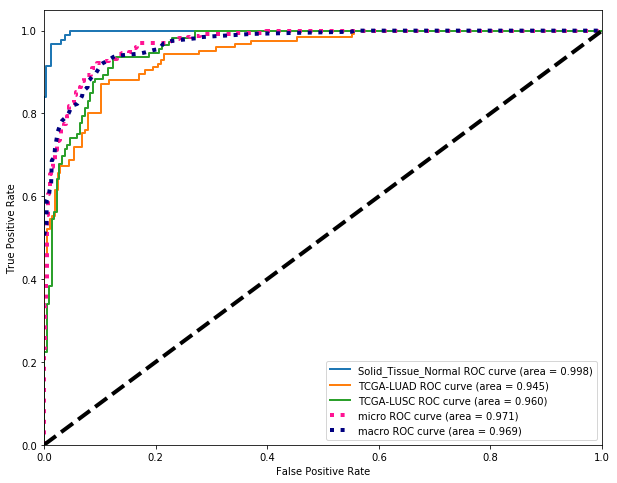

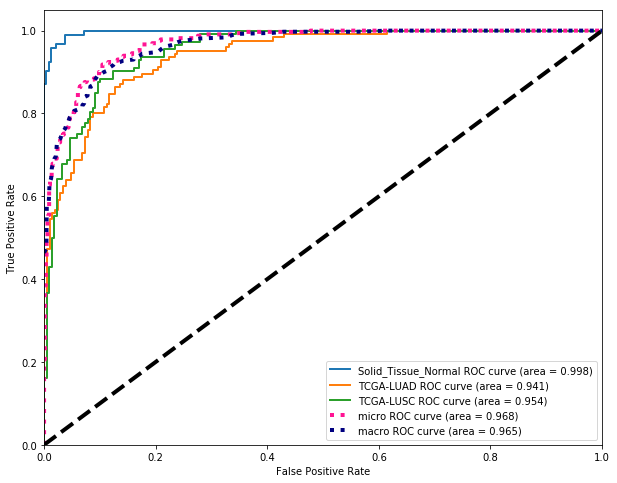

In [17]:
from utilities import draw_rocs
with open(p0.data_labels_path) as h:
    labels = [line.rstrip('\n') for line in h]
completed, current = completed_batches(p0.intermediate_checkpoints, p0.pretrained_checkpoints)
roc_curves_batch = join(p0.eval_results, '_' + completed, 'test_' + current + 'k')

# Draw curves based on average probability
roc_base = 'out2_roc_data_AvPb_'
draw_rocs(roc_base, roc_curves_batch, labels)

# Draw curves based on percent of correctly classified tiles
roc_base = 'out2_roc_data_PcSel_'
draw_rocs(roc_base, roc_curves_batch, labels)




### Test

In [ ]:
# Save results to a batch specific directory
# Derive completed batches
with open(join(p0.intermediate_checkpoints,'checkpoint')) as f: 
    checkpoint_path = f.readline().split('"')[1]
completed = completed_batches(p0.intermediate_checkpoints, p0.pretrained_checkpoints)
#completed = str(batches + int(checkpoint_path.split('-')[-1]))
test_results_batch = join(p0.test_results,'_' + completed)
try:
    shutil.rmtree(test_results_batch)
except:
    pass
os.mkdir(test_results_batch)

func = join(deeppath_code,'02_testing/xClasses/nc_imagenet_eval.py' )
root = func.rsplit('/',1)[1].split('.')[0]

#Redirect output because Jupyter has a limit on test output
out_log_file = join(p0.training_logs,root+'.test.out.log')
err_log_file = join(p0.training_logs,root+'.test.err.log')

!python $func --checkpoint_dir=$p0.intermediate_checkpoints --eval_dir=$test_results_batch \
    --data_dir=$p0.test_records  --batch_size=$batch_size --ImageSet_basename='test_' --run_once \
    --ClassNumber=$p0.class_number --mode=$p0.training_mode --TVmode='test' > $out_log_file 2> $err_log_file



### Generate ROC curve data for testing results

In [ ]:
# Save results to a batch specific directory
# Derive completed batches
with open(join(p0.intermediate_checkpoints,'checkpoint')) as f: 
    checkpoint_path = f.readline().split('"')[1]
completed = completed_batches(p0.intermediate_checkpoints, p0.pretrained_checkpoints)
#completed = str(batches + int(checkpoint_path.split('-')[-1]))
roc_curves_batch = join(p0.roc_curves, '_' + completed)
print("Generating ROC curve data at {}".format(roc_curves_batch))
try:
    shutil.rmtree(roc_curves_batch)
except:
    pass
os.mkdir(roc_curves_batch)

func = join(deeppath_code, '03_postprocessing/0h_ROC_MultiOutput_BootStrap.py')
root = func.rsplit('/',1)[1].split('.')[0]

file_stats = join(p0.test_results, '_' + completed, 'out_filename_Stats.txt')
!python $func  --file_stats=$file_stats --output_dir=$roc_curves_batch  --labels_names=$p0.data_labels_path \
    --ref_stats=''



### Optionally save training results to GCS

In [74]:
import tarfile

# Populate the tar file
# Note we don't save validation results.
loc = join(p0.training,'data.tar')
with tarfile.open(loc, "w") as tar:
    for name in [p0.intermediate_checkpoints, p0.training_logs,  p0.roc_curves,  p0.test_results]:
        tar.add(name)

# Copy it to GCS
gcs = join('gs://', deeppath_data_bucket, p0.training_path, 'data.tar')
!gsutil -m cp $loc $gcs 

# Delete the tar file
!rm $loc

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/data.tar [Content-Type=application/x-tar]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

| [1/1 files][  3.6 GiB/  3.6 GiB] 100% Done  69.5 MiB/s ETA 00:00:00           
Operation completed over 1 objects/3.6 GiB.                                      


## Analyze results

### Display ROC curves for testing results

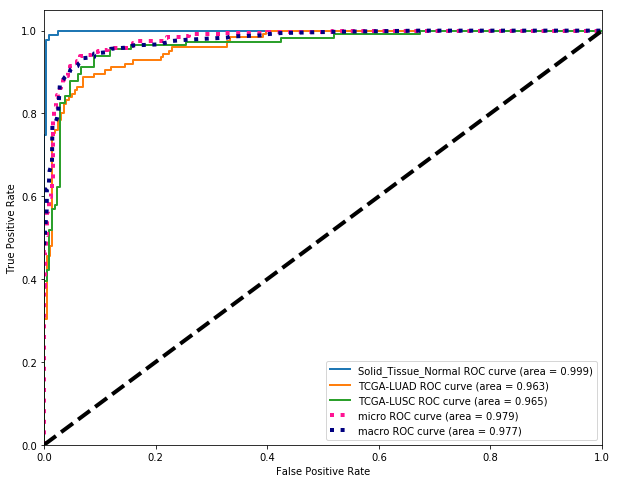

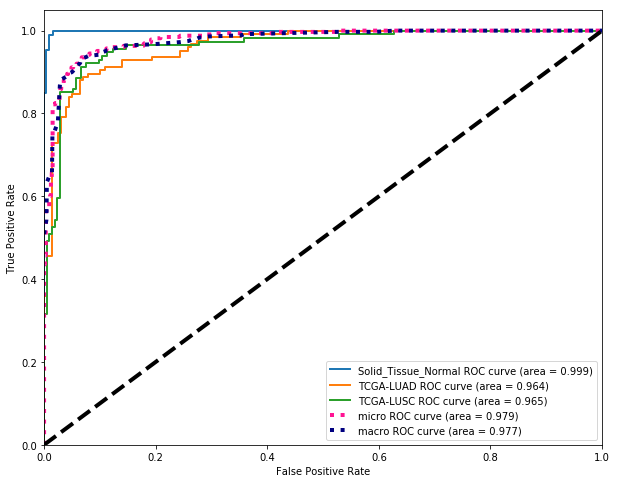

In [14]:
from utilities import draw_rocs
with open(p0.data_labels_path) as h:
    labels = [line.rstrip('\n') for line in h]
completed = completed_batches(p0.intermediate_checkpoints, p0.pretrained_checkpoints)
roc_curves_batch = join(p0.roc_curves, '_' + completed)

# Draw curves based on average probability
roc_base = 'out2_roc_data_AvPb_'
draw_rocs(roc_base, roc_curves_batch, labels)

# Draw curves based on percent of correctly classified tiles
roc_base = 'out2_roc_data_PcSel_'
draw_rocs(roc_base, roc_curves_batch, labels)




### Generate heatmaps of selected pathology images

In [ ]:
from IPython.display import Image
func = join(deeppath_code,'03_postprocessing/0f_HeatMap_nClasses.py' )
root = func.rsplit('/',1)[1].split('.')[0]

# Rendered tile size is reduced by the resample_factor
resample_factor = 10

# The Cmap parameter should be 'CancerType' for tumor classification, or one the mutations,
# e.g. 'EGFR', 'STK11', etc. for mutation classification
cmap = 'CancerType'

with open(join(p0.intermediate_checkpoints,'checkpoint')) as f: 
    checkpoint_path = f.readline().split('"')[1]
completed = completed_batches(p0.intermediate_checkpoints, p0.pretrained_checkpoints)
#completed = str(batches + int(checkpoint_path.split('-')[-1]))
test_results_batch = join(p0.test_results,'_' + completed)
tile_stats = join(test_results_batch, 'out_filename_Stats.txt')
!python $func  --image_file=$p0.sorted_tiles --tiles_overlap=$overlap --output_dir=$p0.heatmaps \
    --tiles_stats=$tile_stats --resample_factor=$resample_factor  --filter_tile='' \
    --Cmap=$cmap --tiles_size=$tile_size --slide_filter='test_TCGA-86-8673-01A-01-TS1'


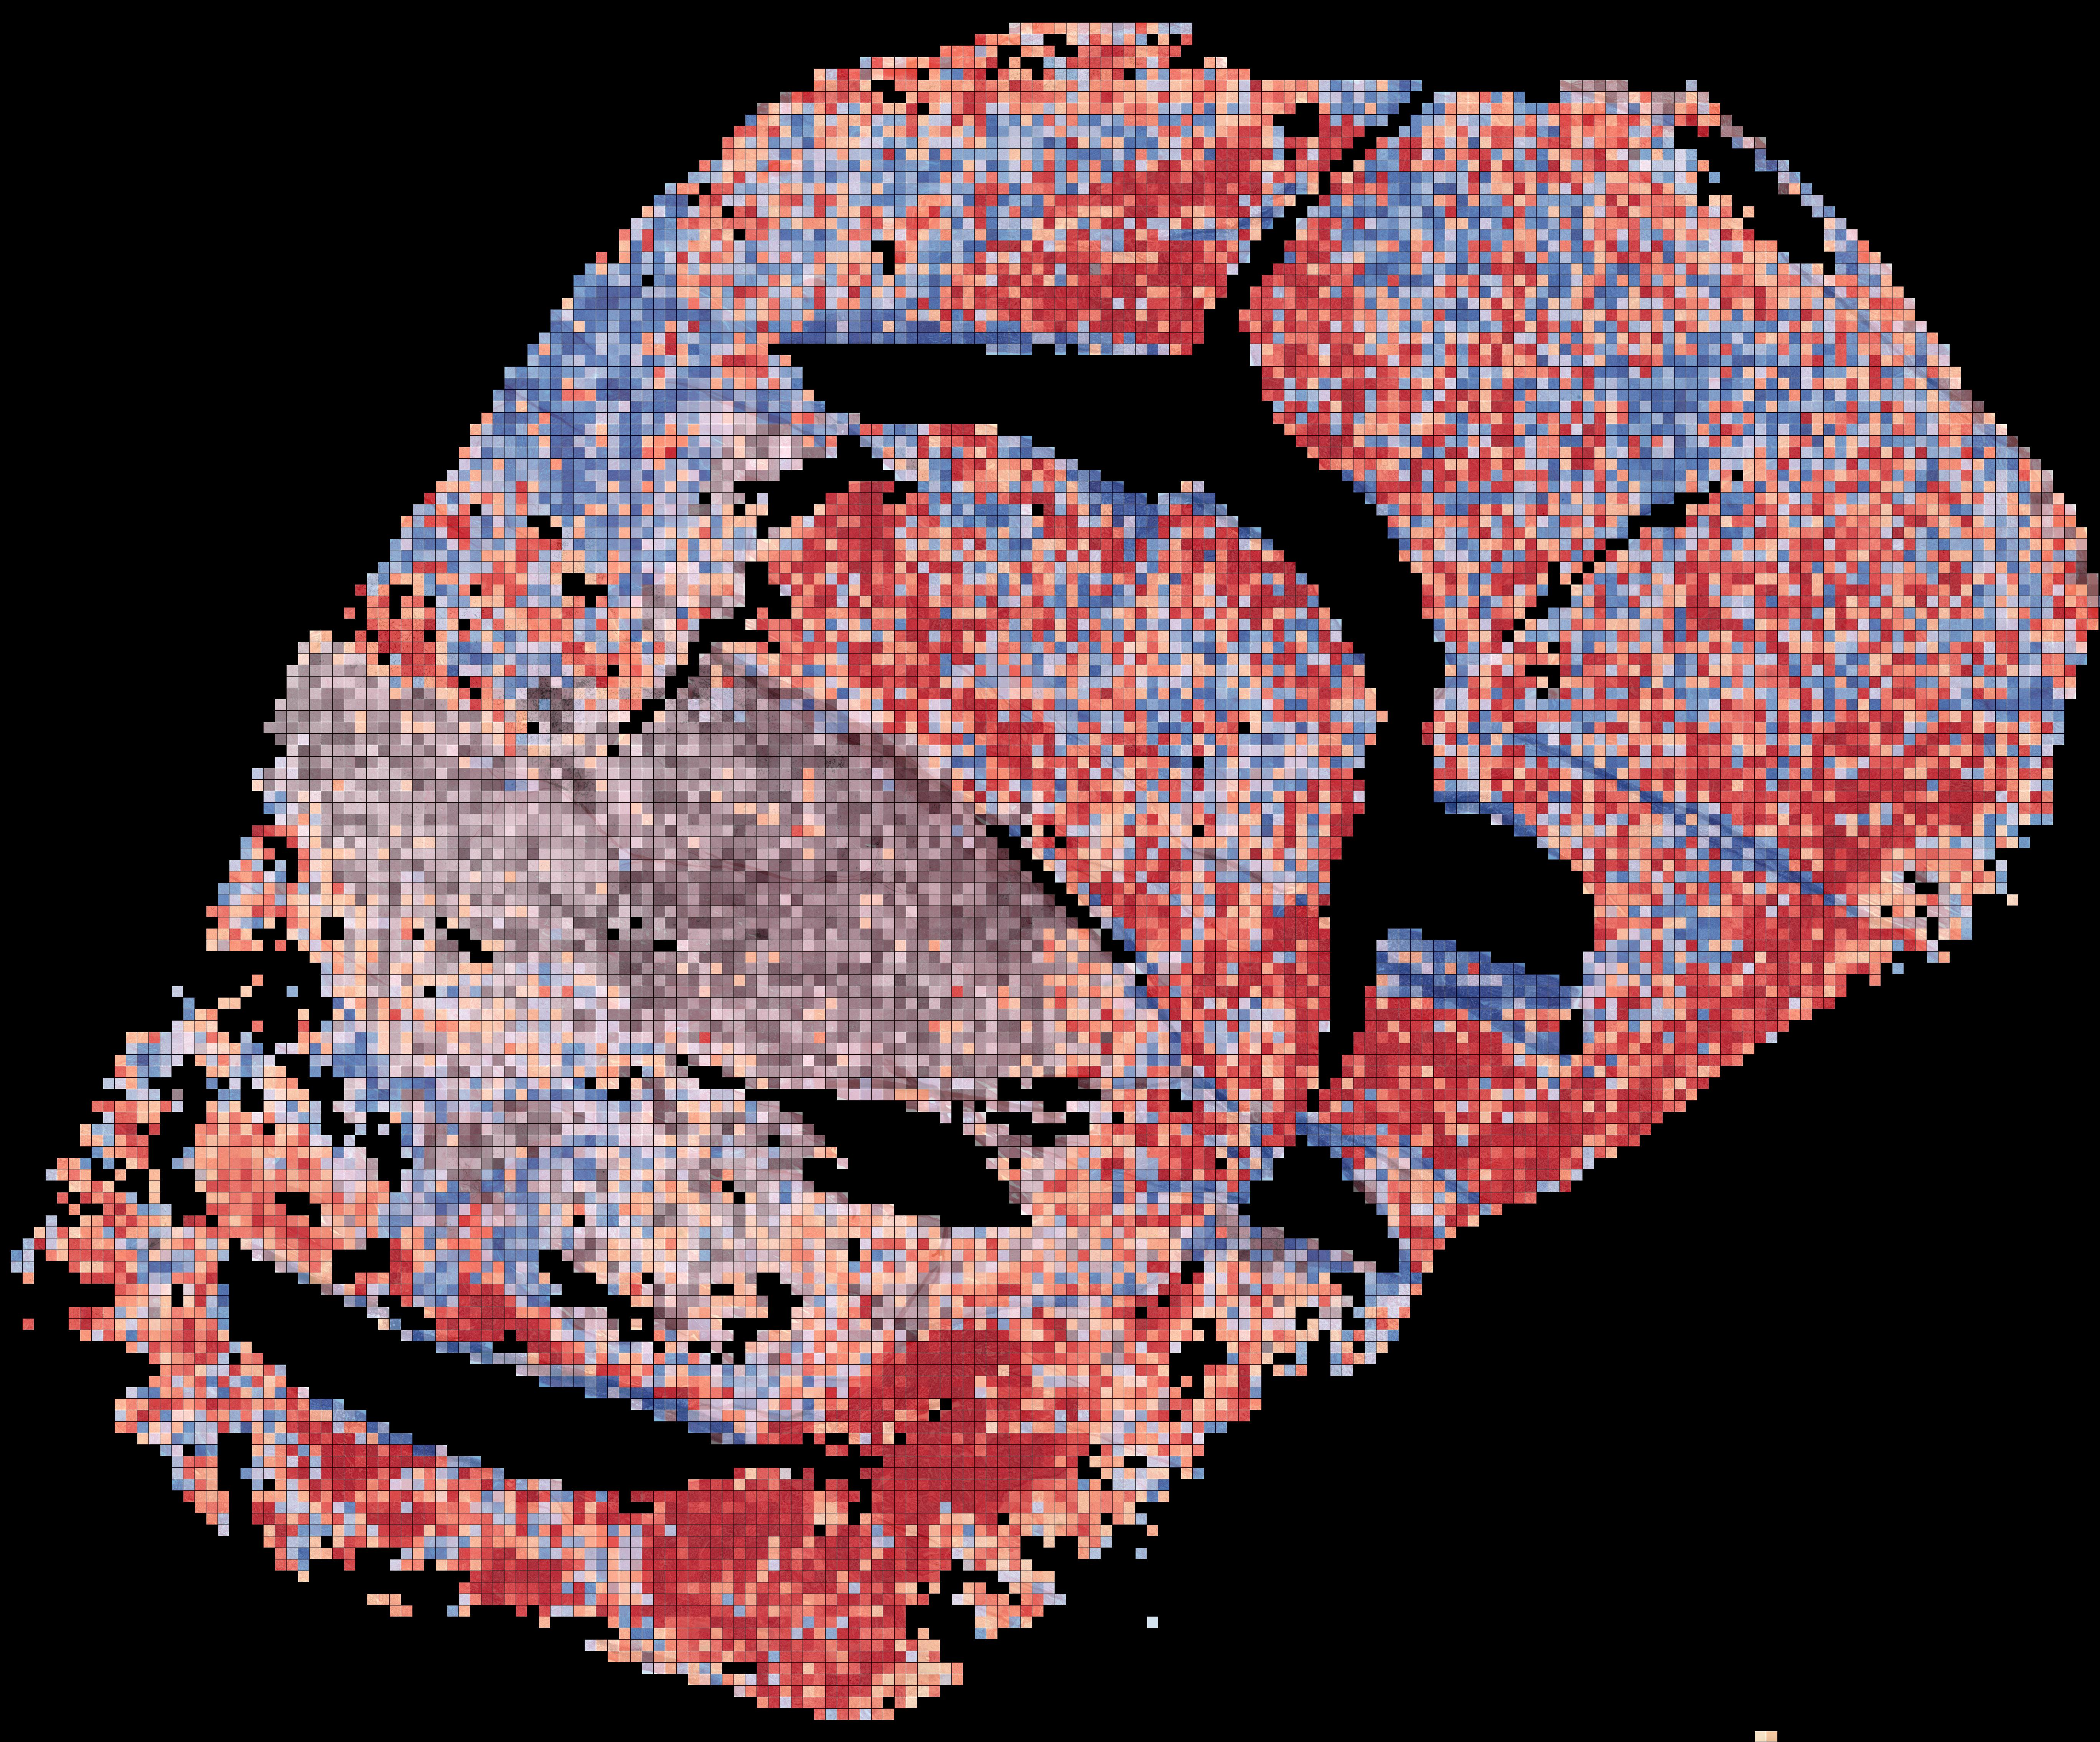

In [21]:
from IPython.display import Image
Image(join(p0.heatmaps, 
  'heatmaps/heatmap_CancerType_test_TCGA-86-8673-01A-01-TS1.07b1fc57-7059-42ef-87d8-f4c2002bf012_TCGA-LUAD.jpg'))


In [20]:
p0.heatmaps

'/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/heatmaps_Px299'

In [ ]:
Image("/home/bcliffor/tmp/j2.jpg")

# Phase 1

## Sort tiles


### Optionally load previously saved sorting results from GCS

In [ ]:
for name in [p1.trainValid_records, p1.test_records]:
    gcs = join('gs://', deeppath_data_bucket, name.lstrip(data_base))
    print(name,gcs)
    !gsutil -m cp -r $gcs $name 



### Perform the sort

In [44]:
# The sort routine outputs to the cwd. So change cwd as needed.
# First, remove existing sort results
os.chdir(os.environ['HOME'])
try:
    shutil.rmtree(p1.sorted_tiles)
except:
    pass
os.mkdir(p1.sorted_tiles)
os.chdir(p1.sorted_tiles)

func = join(deeppath_code,'00_preprocessing/0d_SortTiles.py' )
root = func.rsplit('/',1)[1].split('.')[0]

out_log_file = join(p1.sorting_logs,root+'.out.log')
err_log_file = join(p1.sorting_logs,root+'.err.log')

print("Started at {}".format(asctime()))
!python $func --SourceFolder=$tiles --JsonFile=$p1.images_metadata_path --PercentValid=$p1.PercentValid \
    --PercentTest=$p1.PercentTest --PatientID=12 --Magnification=$magnification --MagDiffAllowed=0.0 \
    --SortingOption=$p1.sorting_option --nSplit=0 > $out_log_file 2> $err_log_file
os.chdir(os.environ['HOME'])

# Need to have sorted subdirectories for normal and LUSC even though empty in order
# that TFRecord files have correct labels
os.mkdir(join(p1.sorted_tiles, 'Solid_Tissue_Normal'))
os.mkdir(join(p1.sorted_tiles, 'TCGA-LUSC'))
print("Finished at {}".format(asctime()))


Started at Wed Jul  3 16:00:42 2019
Finished at Wed Jul  3 16:20:45 2019


### Convert the JPEG tiles into TFRecord format

#### Only generate TFRecord formatted test data

In [56]:
# NOTE: num_threads must be 1. Using more than one thread causes corruption of the resulting files!
# Remove existing TFRecord conversion results
try:
    shutil.rmtree(p1.test_records)
except:
    pass
os.mkdir(p1.test_records)

func = join(deeppath_code,'00_preprocessing/TFRecord_2or3_Classes/build_TF_test.py' )
root = func.rsplit('/',1)[1].split('.')[0]
out_log_file = join(p1.sorting_logs,root+'.test.out.log')
err_log_file = join(p1.sorting_logs,root+'.test.err.log')
print("Started at {}".format(asctime()))
!python $func --directory=$p1.sorted_tiles --output_directory=$p1.test_records --num_threads=1 \
    --one_FT_per_Tile=False --ImageSet_basename='test' > $out_log_file 2> $err_log_file
print("Finished at {}".format(asctime()))


Started at Wed Jul  3 18:26:33 2019
Finished at Wed Jul  3 20:32:42 2019


### Optionally save TFRecord files to GCS

In [47]:
for name in [p1.trainValid_records, p1.test_records]:
    gcs = join('gs://', deeppath_data_bucket, name.lstrip(data_base))
    print(name,gcs)
    !gsutil -m cp -r $name $gcs 



('/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_TrainValid', 'gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_TrainValid')
CommandException: No URLs matched
('/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test', 'gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test')
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-50-5049-01A-01-BS1.eba2afd2-5c5d-4338-9919-8776e0ac1a8b_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-44-5645-01A-05-TSE.63FCBB75-8677-468D-8639-BCED1C55985E_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTru

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-93-A4JN-01A-01-TSA.22080F8B-B9FE-4534-879B-049AA07CCD99_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-55-6980-01A-01-TS1.d9c3a443-0b13-40f5-80fd-575d53f91ea1_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-62-8398-01A-01-TS1.5a4b83a1-c6de-4b08-9f81-fed7855dda3a_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-86-6851-01A-01-BS1.97632bcb-defa-4e56-bbf6-e23bef7cb685_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-35-4122-01A-01-BS1.3a66bb21-492c-41f0-b825-961b7583086f_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-64-5781-01A-01-TS1.21393a9e-867d-457b-853d-9dae2ae1cfbb_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-55-7910-01A-01-BS1.01e1cd48-7e71-445b-b624-ed9f185471fd_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-NJ-A4YQ-01A-01-TS1.E59FACAB-AB32-4D8D-BF11-C68DE16F2A8E_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-49-AARN-01A-02-TSB.8C881E03-94B4-42F8-96F7-D22B4A3AAEFC_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-44-5645-01A-01-TS1.16170220-fc14-4f39-80be-ef98d46dc3c8_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-50-5066-01A-01-TS1.0c7e8ed4-7458-4e11-93fb-46df485c414f_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-55-7281-01A-01-TS1.5ac0ea11-2c38-4021-a0b0-703b01ba23ba_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-05-4410-01A-01-BS1.9f17e837-5c04-4f1b-8438-d49fa409d361_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-97-A4M1-01A-01-TS1.88CE11B3-CE2E-427A-A5F3-53BA0BB5D0A8_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-44-6775-01A-03-TS3.DE1214F1-C47F-4710-BD72-3AFAF3D920E3_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-86-8280-01A-01-BS1.f22f351e-9942-46f4-bc80-5080e2632473_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-38-4627-01A-01-TS1.221bb9bb-9a72-4f33-89c1-d07eb422112e_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-91-6847-01A-01-TS1.9961f002-08f9-4406-ab62-59d39ae513bb_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-55-7573-01A-01-BS1.67eb9c3b-996a-4c70-9ee4-0283413fbc2f_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-73-4670-01A-01-TS1.3a37c541-d9b6-4a33-9249-34bb1efec740_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-78-8662-01A-01-TS1.50bbe95d-2c68-4b7e-97fa-1a76b9b10689_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-50-8460-01A-01-BS1.b6aaca18-0faf-42f9-a1ad-5b2547e7a5d6_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-50-8459-01A-01-TS1.ccd667c6-cc96-43a9-9afc-4f1c23935ffc_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-44-2657-01A-01-TS1.cee29017-5940-4c9c-89b8-8687aa6f9f5a_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-86-A4JF-01A-01-TSA.E1DCED94-3236-4C39-8DC3-A20A2471DDA5_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-97-7552-01A-01-TS1.65a251c4-b794-4fad-9c75-dcd048a50b5e_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-86-8358-01A-01-TS1.02d16568-bd4f-442e-8c09-cfa488e83f47_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-75-5126-01A-01-TS1.b2047eda-6fae-454d-a971-16e3cf8b0177_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-05-4390-01A-01-TS1.df635aeb-4e20-4e96-a64b-bd985c55bd62_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-62-A46R-01A-01-TSA.47CEC83A-9289-4A93-9F8D-95DFE5CFEF1B_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-62-A471-01A-01-TSA.040833CB-A6BE-49DF-93D0-17DC2E905C11_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-86-8669-01A-01-BS1.a68b7248-766f-4c1e-8a20-0fb5b7729b7f_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-86-6851-01A-01-TS1.17b19b68-834e-46da-9b9b-be5fd84e60b2_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-86-7714-01A-01-BS1.96ae5077-ba6a-47e1-893d-63e0bcea734d_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-44-2666-01A-01-BS1.7df801b9-da76-40b6-8d4b-1227cef4f002_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-86-A456-01A-01-TSA.996EFBE2-10E2-454B-B4E7-981FA24404B0_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-NJ-A4YI-01A-01-TS1.73EDF6BC-67F5-44E3-97F0-E2F6C0C6B638_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-75-5146-01A-01-BS1.aa8037ba-7da7-48fe-b287-def64abe78e6_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-05-4415-01A-01-BS1.5c754d4d-2888-474d-a008-3bfba54a9b3b_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-55-7574-01A-01-BS1.6dcbb8ec-0b23-4ef6-8072-f364f31cd7a4_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-NJ-A55A-01A-01-TSA.EB8E4F53-589A-4F7D-AC10-7D65DF72F1BB_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-67-6215-01A-01-BS1.d10d04fe-ce17-4011-ae46-7b8a10d8551d_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-05-5429-01A-01-BS1.23171dd0-7445-4341-b0ad-a67554cdaf48_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-55-5899-01A-01-TS1.cc1d9936-fc06-46a0-83c6-8afe05723f06_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-78-7535-01A-01-BS1.bece83ec-80c6-4163-b489-2495f624cd06_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-55-A4DF-01A-01-TS1.2FFEFF28-381E-4855-8FF0-6EFBC055DBBE_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-62-8395-01A-01-BS1.0f1436e6-0065-4dd7-a132-b6a21a097e48_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-05-4245-01A-01-BS1.41d3cf23-4e36-4e42-9e08-adfea139f37e_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-44-6775-01C-01-BS1.73DE5DC4-93DD-45B9-A12B-69FFFEE1269C_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-55-8514-01A-01-TS1.0e0f5cf3-96e9-4a35-aaed-4340df78d389_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-69-7765-01A-01-TS1.9ba2967f-d8c5-4ade-8f10-85851a7881fc_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-05-4396-01A-02-BS2.23cf2a72-6fe5-4fb4-91e8-fd855bfce541_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-91-6847-01A-01-BS1.42810728-6d6c-4116-bd23-71f502f4f6ed_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-38-4626-01A-01-TS1.b856b974-e498-4a8a-a649-bc321c90622a_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-99-7458-01A-01-TS1.d839bea7-a4d0-493e-833f-ca1a8eccdc3e_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-78-7159-01A-01-BS1.a248a614-881b-471b-a683-a9ede5b3ec1e_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-49-4486-01A-01-TS1.0022a845-3477-46c1-9af6-b840ac3aad1e_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-MP-A4T2-01A-01-TSA.6A132B42-1022-4E08-8801-1E4499B5EE25_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-86-8073-01A-01-BS1.69853b5d-bcc8-43b2-8ed2-557fbfcd0441_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-55-8089-01A-01-TS1.8881da70-0436-4123-b8f1-f55c5d467a69_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-67-3771-01A-01-BS1.8bcf3f0b-fedd-4eb0-8e29-585ddd074805_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-MP-A4SW-01A-02-TSB.B6EEFE44-2E1E-4EAD-8791-C1C7217BF25C_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-49-AARO-01A-01-TSA.FDA66180-A121-457C-AED9-636D9B113B01_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-44-3918-01A-01-TS1.92b19e7c-b1d8-4a7c-a555-7759be21014e_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-05-4417-01A-02-BS2.5e476601-0b01-498c-b97e-7f6daa5cbcf2_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-67-3772-01A-01-BS1.56a6f70b-02e3-4df0-bc16-f4ec8970f0ad_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-73-4675-01A-01-BS1.9d69c4fc-6be7-46ef-897c-e5fce0597839_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-86-7701-01A-01-BS1.01830866-acbf-4de5-8237-eea8ca06f8cd_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-MP-A4SY-01A-02-TSB.3E74E5C2-2D51-45CD-9A94-13FFB2F67A93_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-55-7994-01A-01-TS1.8b666cd9-9f50-4be5-a12f-df25b84934c3_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-91-6848-01A-01-BS1.5cbaab0b-bd1c-4f46-bc98-9a425ab08c19_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-64-1676-01A-01-TS1.21bb0241-8048-4c6a-b8cf-65725523ae05_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-50-5941-01A-01-TS1.c5010046-2d82-4e38-9e65-3a488061ded6_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-75-5146-01A-01-TS1.8da9013b-65b3-4378-b6f8-b8dfe123ce28_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-75-6206-01A-01-TS1.35324f87-d70a-4938-8384-1bade0824039_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-50-6594-01A-01-TS1.242fa6fa-59a4-49df-8fc5-5d9c91ab6030_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-55-6712-01A-01-BS1.7c7664b9-8268-4d99-82ca-92f57ef1ad84_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-75-5125-01A-01-TS1.4de89cad-8351-4954-901b-79bf24c752ad_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-78-8648-01A-01-TS1.861b33a9-153f-4115-a314-91e0d1a8d697_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-J2-8192-01A-01-TS1.c1e02088-1b30-40ce-b1b9-fce70d54b73c_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-53-7624-01A-01-TS1.c2f2da76-bd62-4025-b9e5-80ea33043acc_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-78-7152-01A-01-TS1.630cfba4-b1a5-4e4a-910f-aebdcb932a9c_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-78-7154-01A-01-BS1.b36a441e-a09d-4bcd-ac96-8076c14add71_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-44-2668-01B-01-BS1.A6278F3D-FCA6-4FEE-B5EB-AB16759649F3_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-62-8398-01A-01-BS1.55b3186a-ceda-4e8c-8376-f78e67b6cfb2_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-MP-A4TD-01A-03-TS3.678DF757-79E3-4E08-883B-8524F3C7B93F_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-62-8395-01A-01-TS1.9585aa9d-c95c-4025-a449-481f2d153636_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-86-8074-01A-01-BS1.9b6a32f7-07bb-4e59-aa64-487c6a43edab_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-97-8552-01A-01-TS1.24ca90a7-5762-4ab5-a404-67dfcd416f79_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-55-8614-01A-01-TS1.8614fe5d-8f1d-4c0e-8867-43e621e76018_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-50-6591-01A-01-TS1.037eb7c4-02fc-4e48-976c-6717d3ec2971_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-64-1676-01A-01-BS1.48c91c0b-928e-46c8-b3cc-f6b67edf5fc3_1.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

## Training

### Optionally load previously saved training results from GCS

In [70]:
import tarfile
gcs = join('gs://', deeppath_data_bucket, p1.training_path, 'data.tar')
loc = join(training,'data.tar')

result = !gsutil ls $gcs
if result[0] ==gcs:
    !gsutil -m cp $gcs $loc 

    with tarfile.open(loc) as tar:
        tar.extractall('/')

    !rm $loc
else:
    print('{} not found'.format(gcs))

gs://deeppath-data-whc/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/data.tar.gz not found


### Test

In Phase 1, we don't do any training or evaluation. We just run all the LUAD tiles through the intermediate checkpoint from Phase 1. Some of these tiles will be classified as normal tissue or LUSC. We need to eliminate those from mutation classification.

In [57]:
# Copy the checkpoints from phase 0 for use in phase 1
!cp -R -u $p0.intermediate_checkpoints $p1.training

# Save results to a batch specific directory
# Derive completed batches
with open(join(p1.intermediate_checkpoints,'checkpoint')) as f: 
    checkpoint_path = f.readline().split('"')[1]
completed = completed_batches(p1.intermediate_checkpoints, p1.pretrained_checkpoints)
#completed = str(batches + int(checkpoint_path.split('-')[-1]))
test_results_batch = join(p1.test_results,'_' + completed)
try:
    shutil.rmtree(test_results_batch)
except:
    pass
os.mkdir(test_results_batch)

func = join(deeppath_code,'02_testing/xClasses/nc_imagenet_eval.py' )
root = func.rsplit('/',1)[1].split('.')[0]

#Redirect output because Jupyter has a limit on test output
out_log_file = join(p1.training_logs,root+'.test.out.log')
err_log_file = join(p1.training_logs,root+'.test.err.log')

!python $func --checkpoint_dir=$p1.intermediate_checkpoints --eval_dir=$test_results_batch \
    --data_dir=$p1.test_records  --batch_size=$batch_size --ImageSet_basename='test_' --run_once \
    --ClassNumber=$p1.class_number --mode=$p1.training_mode --TVmode='test' > $out_log_file 2> $err_log_file



### Optionally save training results to GCS

In [75]:
for name in [p1.test_records]:
    gcs = join('gs://', deeppath_data_bucket, name.lstrip(data_base))
    print(name,gcs)
    !gsutil -m cp -r $name $gcs 
    !rm -r $name



('/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test', 'gs://deeppath-data-whc/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test')
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-97-A4M7-01A-01-TSA.968E9B8F-D1F7-486D-B2BF-D056F4A686A5_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-J2-A4AD-01A-01-TSA.1B4E7C9F-CBEA-4FCE-B109-BCE80EFDF018_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-49-4506-01A-01-TS1.23c0357f-59da-463d-9e13-13dff47b86d9_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-44-4112-01B-05-BS5.21F5BBD4-EE97-4093-875A-47EC7ABB9FBE_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-44-3918-01A-01-TS1.92b19e7c-b1d8-4a7c-a555-7759be21014e_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-64-1677-01A-01-BS1.5ac1dc67-40e3-43aa-87ed-29348d5de2c3_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-44-2664-01A-01-TS1.c7024c03-2eef-45fc-93f6-3f4319305217_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-91-A4BD-01A-01-TSA.93F9E15F-EAC4-4DE1-85A5-626B58BF7B99_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-86-8278-01A-01-BS1.19e62dcc-ceec-44b2-89dd-bc9f165d8159_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-64-5778-01A-01-TS1.e85c2800-9cf3-4e65-a002-342876faf327_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-78-7158-01A-01-BS1.3b9b6712-5409-45b1-8f2f-1d868d09be14_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-75-7027-01A-01-BS1.c25a28f7-788d-4215-a35e-2621d3a54c45_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-78-7539-01A-01-TS1.1f2c8802-8e2b-4acf-adfe-6ac9bbf745ae_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-99-7458-01A-01-TS1.d839bea7-a4d0-493e-833f-ca1a8eccdc3e_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-50-6597-01A-01-BS1.3e4e3440-5a91-404c-a98a-920ec36b179d_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-91-6831-01A-01-BS1.2d9c6566-9b9f-4f3a-b273-cb8be4fd93d1_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-62-A46S-01A-01-TS1.86557AB5-8FB3-411D-8CA9-EB015D4B8C48_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-67-6215-01A-01-BS1.d10d04fe-ce17-4011-ae46-7b8a10d8551d_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-97-7554-01A-01-BS1.73f4b031-69b0-4065-826f-7a46e0d8370d_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-05-4250-01A-01-TS1.5c50e0e0-1414-43f6-8fe1-13fbbcac5ec0_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-55-8090-01A-01-TS1.2deec958-f417-4485-a278-9cd2fc9779de_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-44-A4SS-01A-01-TSA.876AC692-397E-48F0-9626-8CE79A051679_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-44-6775-01A-01-BS1.dd1594a9-8973-490a-9c5c-c9a676a71f5f_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-55-8511-01A-01-TS1.65c0724b-97bf-431c-864c-176194c94a3d_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-78-8655-01A-01-TS1.5a514f0a-6e90-4ddb-9623-d053c48906c4_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-97-A4M2-01A-01-TSA.839A9095-E728-4251-85DA-DD29010D70A8_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-44-2656-01A-02-BS2.2c768435-cc25-4818-ad32-19933a9a7c67_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-55-8091-01A-01-TS1.ab1bfa91-9b10-41cf-8ffb-65e3aaf650d0_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-38-4629-01A-01-BS1.54a70eed-841a-4ec2-baca-f0546d78b60c_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-97-8177-01A-01-TS1.5b2fb8cf-2f14-41ac-8a47-81022f66fe53_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-86-A4P8-01A-01-TSA.24B363A7-C783-4351-AF50-FB0F09BFD014_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-38-7271-01A-01-TS1.8e38324c-8605-4f16-a842-082e4ffd94dd_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-64-1679-01A-01-BS1.06dc184d-224d-4602-8194-fcc9392033f4_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-78-7158-01A-01-TS1.7316cf99-dff8-4f59-a0e0-c3ba3eb8dce5_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-50-5051-01A-01-BS1.f3f92997-5cb7-477a-b819-dfc3679f488e_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-05-4382-01A-01-BS1.ac519a18-8590-4fab-8af6-bb43fbe65310_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-05-4415-01A-01-BS1.5c754d4d-2888-474d-a008-3bfba54a9b3b_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-05-5420-01A-01-BS1.baf2b018-7a89-4b11-9328-ce8ea70fdc84_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-MP-A4TE-01A-02-TS2.A7C25CC2-22F2-45B7-BD62-9DEFD67B2244_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-55-8508-01A-01-TS1.57e44e2e-5005-4517-9256-7e8757428e9f_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-64-1680-01A-02-BS2.b2193e4a-0f9b-46cd-91e7-5684c414ca39_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-69-7763-01A-01-BS1.357e610f-fd28-46a2-9f80-ae8a9d4e7b02_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-62-A472-01A-01-TSA.C466E996-B1B6-4AE9-8A4A-31BB4D7944E2_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-86-8280-01A-01-BS1.f22f351e-9942-46f4-bc80-5080e2632473_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-44-A4SU-01A-01-TSA.A91EA3BB-C675-4EEA-89AC-54D1221EA8B5_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-55-5899-01A-01-TS1.cc1d9936-fc06-46a0-83c6-8afe05723f06_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-50-6594-01A-01-BS1.b2ca274e-a9dc-491e-ac64-f6cc18108eac_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-44-2656-01B-06-BS6.69E221BD-0A26-4AF2-B76F-2D46226A2447_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-50-5932-01A-01-TS1.e89b93f1-255e-42ac-a0eb-7c3df060b669_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-50-6591-01A-01-TS1.037eb7c4-02fc-4e48-976c-6717d3ec2971_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-67-3774-01A-01-BS1.31cac0af-cd13-46e7-9383-505da43384a4_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-35-3615-01A-01-BS1.40ee8b17-cbd1-4b88-bfd9-0685f18f3829_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-49-4506-01A-01-BS1.4f66461a-5fe7-43ef-98ae-35c70b66b449_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-44-3919-01A-01-BS1.9251d6ad-dab8-42fd-836d-1b18e5d2afed_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-71-6725-01A-01-TS1.a0931313-70a2-4511-85d2-391eb1a52a7f_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-44-2666-01A-01-BS1.7df801b9-da76-40b6-8d4b-1227cef4f002_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-78-7143-01A-01-TS1.083d369f-9333-4fe9-99f2-115eb5db3a3c_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-55-6970-01A-01-BS1.4b65459d-7aa4-41b4-a811-fd46fa2ef112_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-95-8039-01A-01-TS1.1f7a1e11-9d0b-4c48-b8de-e8f2f812dbf3_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-78-7145-01A-01-TS1.8930eca1-bc4e-4ed6-a6fd-335eb553e057_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-05-4244-01A-01-TS1.6c46d8c3-d7b4-4513-af31-9170244d60a7_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-44-6145-01A-01-BS1.13a0cd77-3c3d-44d3-8985-d1272b84e5bd_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-93-7347-01A-01-TS1.02ce4270-8e0f-4e8d-a391-9bda489910ce_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-05-5428-01A-01-TS1.e65a4519-45c7-45b7-a85f-8e8c9a440cfe_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-97-A4M3-01A-01-TS1.DD77078C-6988-4137-94C2-C7F9A3000CE4_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-67-6216-01A-01-TS1.5d6a40a7-84d8-4c53-b081-42d6938d9cf1_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-75-6203-01A-01-BS1.16ef47e4-eb98-40c3-98c6-2c0ca500db68_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-75-5122-01A-01-BS1.3d8974bb-ca4f-4125-8ac5-5a0a7031ba11_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-55-6543-01A-01-BS1.9056c6b4-b8bc-4f5e-8e5d-fb8aedafc0d7_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-86-8054-01A-01-TS1.1ea30d7b-fce1-4660-baeb-2eba417800b4_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-62-A46O-01A-01-TSA.59B75044-364C-4C82-A389-1E3DEA0A1E89_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-55-8505-01A-01-TS1.9b370e90-be02-47eb-a036-858837d74e3a_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-05-4249-01A-01-BS1.38c41760-cc43-4904-9575-803d1d92b992_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-J2-8192-01A-01-TS1.c1e02088-1b30-40ce-b1b9-fce70d54b73c_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-55-6981-01A-01-TS1.55bea1ae-e14c-4110-b913-719b19225f5b_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-50-6590-01A-01-BS1.1310da67-1b19-4977-b0e4-aab8cc0d445b_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-49-4494-01A-01-TS1.2e7d510c-93e6-4413-8080-0fe2cf17a536_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-86-7714-01A-01-BS1.96ae5077-ba6a-47e1-893d-63e0bcea734d_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-44-3917-01B-01-BS1.CB6E28E3-D426-4A88-941A-63C65B869B15_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-55-A490-01A-01-TS1.1A2C5FC5-8C07-4F01-BDF1-BF57A6ADCA85_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-49-AARR-01A-01-TSA.227C90DC-DA98-4445-ACF3-2556BA23704F_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-55-8203-01A-01-TS1.b9b9a3cd-378d-41d1-b8c0-b2ac3db507a7_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-73-7499-01A-01-BS1.6bb1fb89-929d-49e3-9c2f-8741797abddc_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-50-5066-02A-01-BS1.3eed666c-e056-489e-86ea-ff6417b13886_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-78-7166-01A-01-BS1.610bd138-dabc-4599-a9af-a5768cb2506c_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-50-5044-01A-01-BS1.f9008630-fcf4-45e8-82e9-71f138350114_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-44-2668-01A-01-TS1.d4db0c2b-9247-458b-a931-62ff45e4f859_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-55-8085-01A-01-TS1.7d52c49e-a3d9-4fe8-806b-d96bbb1cc122_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-MP-A4SW-01A-02-TSB.B6EEFE44-2E1E-4EAD-8791-C1C7217BF25C_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-67-3776-01A-01-TS1.81654472-553b-4b12-af86-d716a028a76a_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/TFRecord_Test/test_TCGA-55-8206-01A-01-TS1.4188b107-092e-405f-b035-50b55ebd53c5_2.TFRecord [Content-Type=application/octet-stream]...
Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg2

# Phase 2

## Sort tiles


### Optionally load previously saved sorting results from GCS

In [ ]:
for name in [p2.trainValid_records, p2.test_records]:
    gcs = join('gs://', deeppath_data_bucket, name.lstrip(data_base))
    print(name,gcs)
    !gsutil -m cp -r $gcs $name 



### Perform the sort

As mentioned above, we want to include only tiles from TCGA-LUAD slides that are actually classified as LUAD by the previously trained classifier. For this purpose, we pass a file, out_filename_Stats.txt, that was generated in phase 1.

In [58]:
# The sort routine outputs to the cwd. So change cwd as needed.
# First, remove existing sort results
os.chdir(os.environ['HOME'])
try:
    shutil.rmtree(p2.sorted_tiles)
except:
    pass
os.mkdir(p2.sorted_tiles)
os.chdir(p2.sorted_tiles)

func = join(deeppath_code,'00_preprocessing/0d_SortTiles.py' )
root = func.rsplit('/',1)[1].split('.')[0]

out_log_file = join(p2.sorting_logs,root+'.out.log')
err_log_file = join(p2.sorting_logs,root+'.err.log')

# Note that we use out_filename_stats.txt from phase 1
file_stats = join(p1.test_results, '_' + completed, 'out_filename_Stats.txt')
print("Started at {}".format(asctime()))
!python $func --SourceFolder=$tiles --JsonFile=$p2.images_metadata_path --PercentValid=$p2.PercentValid \
    --PercentTest=$p2.PercentTest --PatientID=12 --Magnification=$magnification --MagDiffAllowed=0.0 \
    --SortingOption=$p2.sorting_option --nSplit=0 --outFilenameStats=$file_stats --expLabel=2 \
    > $out_log_file 2> $err_log_file
os.chdir(os.environ['HOME'])
print("Finished at {}".format(asctime()))


Started at Thu Jul  4 11:50:44 2019
Finished at Thu Jul  4 11:56:33 2019


### Convert the JPEG tiles into TFRecord format
#### First format the training and validation data

In [34]:
# Remove existing TFRecord conversion results
try:
    shutil.rmtree(p2.trainValid_records)
except:
    pass
os.mkdir(p2.trainValid_records)

%xmode Verbose

func = join(deeppath_code,'00_preprocessing/TFRecord_multi_Classes/build_image_data_multiClass.py' )
root = func.rsplit('/',1)[1].split('.')[0]
out_log_file = join(p2.sorting_logs,root+'.train.out.log')
err_log_file = join(p2.sorting_logs,root+'.train.err.log')
print("Started at {}".format(asctime()))
!python $func --directory=$p2.sorted_tiles/tiles --output_directory=$p2.trainValid_records \
    --train_shards=1024 --validation_shards=128 --num_threads=$num_cpus  --labels_names=$p2.data_labels_path \
    --labels=$mutations_metadata_path --PatientID=12 > $out_log_file 2> $err_log_file
print("Finished at {}".format(asctime()))


Exception reporting mode: Verbose
Starting to format training and validation data
Started at Thu Jul  4 12:21:13 2019
Finished at Thu Jul  4 15:38:55 2019


#### Now format the test data

In [24]:
# NOTE: num_threads must be 1. Using more than one thread causes corruption of the resulting files!
# Remove existing TFRecord conversion results
try:
    shutil.rmtree(p2.test_records)
except:
    pass
os.mkdir(p2.test_records)

func = join(deeppath_code,'00_preprocessing/TFRecord_multi_Classes/build_TF_test_multiClass.py' )
root = func.rsplit('/',1)[1].split('.')[0]
out_log_file = join(p2.sorting_logs,root+'.test.out.log')
err_log_file = join(p2.sorting_logs,root+'.test.err.log')
print("Started at {}".format(asctime()))
!python $func --directory=$p2.sorted_tiles/tiles --output_directory=$p2.test_records --train_shards=1024 \
    --validation_shards=128 --num_threads=1 --one_FT_per_Tile=False --ImageSet_basename='test' \
    --labels_names=$p2.data_labels_path --labels=$mutations_metadata_path \
    --PatientID=12 > $out_log_file 2> $err_log_file
print("Finished at {}".format(asctime()))


Started at Thu Jul  4 16:26:27 2019
Finished at Thu Jul  4 16:43:25 2019


### Optionally save TFRecord files to GCS

In [ ]:
for name in [p2.trainValid_records, p2.test_records]:
    gcs = join('gs://', deeppath_data_bucket, name.lstrip(data_base))
    print(name,gcs)
    !gsutil -m cp -r $name $gcs 



## Training

### Optionally load previously saved training results from GCS

In [70]:
import tarfile
gcs = join('gs://', deeppath_data_bucket, p2.training_path, 'data.tar')
loc = join(training,'data.tar')

result = !gsutil ls $gcs
if result[0] ==gcs:
    !gsutil -m cp $gcs $loc 

    with tarfile.open(loc) as tar:
        tar.extractall('/')

    !rm $loc
else:
    print('{} not found'.format(gcs))

gs://deeppath-data-whc/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/data.tar.gz not found


### Install the Bazel build tool, and  then build the inception model
We're training Inception from scratch so can't use the pre-trained model. Instead we build the Inception model, which is done using the Bazel build tool.

In [ ]:
!sudo apt-get install -y pkg-config zip g++ zlib1g-dev unzip python
!wget https://github.com/bazelbuild/bazel/releases/download/0.24.0/bazel-0.24.0-installer-linux-x86_64.sh
!chmod +x bazel-0.24.0-installer-linux-x86_64.sh
!./bazel-0.24.0-installer-linux-x86_64.sh --user
os.environ["PATH"] += ":" + join(os.getcwd(),'bin')
!rm bazel-0.24.0-installer-linux-x86_64.sh

#os.chdir(join(os.environ['HOME'],'DeepPATH/DeepPATH_code/s01_training/xClasses'))
cwd = os.getcwd()
os.chdir(join(deeppath_code,'01_training/xClasses'))
print(os.getcwd())
!bazel build inception/imagenet_train


 ### Train the model

In [27]:
func = join(deeppath_code,'01_training/xClasses/bazel-bin/inception/imagenet_train' )
root = func.rsplit('/',1)[1]

# Note that the --train_dir directory appears to be deleted and recreated
print("Performing training from scratch")
print("Started at {}".format(asctime()))
!python $func --num_gpus=$num_gpus --batch_size=$batch_size --train_dir=$p2.intermediate_checkpoints \
    --data_dir=$p2.trainValid_records --fine_tune=$p2.fine_tune --ClassNumber=$p2.class_number \
    --mode=$p2.training_mode
print("Finished at {}".format(asctime()))


Performing training from scratch
Started at Thu Jul  4 16:46:52 2019
!!!!!!!!!!!!!!
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/So10_Sort/TFRecord_TrainValid/train-*
Instructions for updating:
Colocations handled automatically by placer.
!!!!!!!!!!!!!!
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/So10_Sort/TFRecord_TrainValid/train-*
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updat

2019-07-04 16:49:47.833440: step 40, loss = 4.10 (24.1 examples/sec; 1.244 sec/batch)
2019-07-04 16:50:00.157319: step 50, loss = 3.98 (24.8 examples/sec; 1.211 sec/batch)
2019-07-04 16:50:12.346936: step 60, loss = 3.97 (25.0 examples/sec; 1.202 sec/batch)
2019-07-04 16:50:24.653661: step 70, loss = 3.94 (23.7 examples/sec; 1.265 sec/batch)
2019-07-04 16:50:36.796854: step 80, loss = 4.00 (24.6 examples/sec; 1.217 sec/batch)
2019-07-04 16:50:49.132782: step 90, loss = 3.96 (24.9 examples/sec; 1.205 sec/batch)
2019-07-04 16:51:01.335617: step 100, loss = 3.92 (24.5 examples/sec; 1.226 sec/batch)
2019-07-04 16:51:17.923145: step 110, loss = 3.98 (24.3 examples/sec; 1.236 sec/batch)
2019-07-04 16:51:30.439217: step 120, loss = 3.88 (24.5 examples/sec; 1.223 sec/batch)
2019-07-04 16:51:42.702140: step 130, loss = 3.99 (24.8 examples/sec; 1.210 sec/batch)
2019-07-04 16:51:54.930655: step 140, loss = 3.97 (24.3 examples/sec; 1.236 sec/batch)
2019-07-04 16:52:07.220615: step 150, loss = 4.00

2019-07-04 17:09:55.335957: step 990, loss = 3.74 (24.6 examples/sec; 1.219 sec/batch)
2019-07-04 17:10:07.647686: step 1000, loss = 3.67 (24.5 examples/sec; 1.223 sec/batch)
2019-07-04 17:10:24.273058: step 1010, loss = 3.76 (24.8 examples/sec; 1.208 sec/batch)
2019-07-04 17:10:36.582681: step 1020, loss = 3.68 (24.9 examples/sec; 1.204 sec/batch)
2019-07-04 17:10:48.799507: step 1030, loss = 3.66 (24.9 examples/sec; 1.206 sec/batch)
2019-07-04 17:11:00.976214: step 1040, loss = 3.74 (24.3 examples/sec; 1.232 sec/batch)
2019-07-04 17:11:13.198966: step 1050, loss = 3.68 (24.8 examples/sec; 1.209 sec/batch)
2019-07-04 17:11:25.303880: step 1060, loss = 3.71 (24.9 examples/sec; 1.207 sec/batch)
2019-07-04 17:11:37.558906: step 1070, loss = 3.63 (24.9 examples/sec; 1.202 sec/batch)
2019-07-04 17:11:49.787353: step 1080, loss = 3.72 (24.4 examples/sec; 1.232 sec/batch)
2019-07-04 17:12:02.159503: step 1090, loss = 3.70 (24.6 examples/sec; 1.219 sec/batch)
2019-07-04 17:12:14.444972: step 

2019-07-04 17:29:52.920410: step 1930, loss = 3.47 (23.8 examples/sec; 1.261 sec/batch)
2019-07-04 17:30:05.207385: step 1940, loss = 3.45 (25.0 examples/sec; 1.200 sec/batch)
2019-07-04 17:30:17.580198: step 1950, loss = 3.42 (22.9 examples/sec; 1.310 sec/batch)
2019-07-04 17:30:29.850442: step 1960, loss = 3.49 (24.9 examples/sec; 1.205 sec/batch)
2019-07-04 17:30:41.981663: step 1970, loss = 3.39 (24.9 examples/sec; 1.203 sec/batch)
2019-07-04 17:30:54.306715: step 1980, loss = 3.53 (24.8 examples/sec; 1.211 sec/batch)
2019-07-04 17:31:06.730482: step 1990, loss = 3.51 (22.8 examples/sec; 1.316 sec/batch)
2019-07-04 17:31:18.895117: step 2000, loss = 3.49 (24.6 examples/sec; 1.220 sec/batch)
2019-07-04 17:31:35.345597: step 2010, loss = 3.42 (22.8 examples/sec; 1.316 sec/batch)
2019-07-04 17:31:47.559506: step 2020, loss = 3.46 (24.0 examples/sec; 1.252 sec/batch)
2019-07-04 17:31:59.813415: step 2030, loss = 3.43 (25.0 examples/sec; 1.202 sec/batch)
2019-07-04 17:32:12.278068: step

2019-07-04 17:49:42.294098: step 2870, loss = 3.25 (24.6 examples/sec; 1.218 sec/batch)
2019-07-04 17:49:54.544526: step 2880, loss = 3.27 (24.9 examples/sec; 1.207 sec/batch)
2019-07-04 17:50:06.779398: step 2890, loss = 3.23 (24.7 examples/sec; 1.217 sec/batch)
2019-07-04 17:50:19.013185: step 2900, loss = 3.26 (23.2 examples/sec; 1.294 sec/batch)
2019-07-04 17:50:35.698730: step 2910, loss = 3.27 (24.3 examples/sec; 1.236 sec/batch)
2019-07-04 17:50:47.963612: step 2920, loss = 3.24 (24.9 examples/sec; 1.204 sec/batch)
2019-07-04 17:51:00.301832: step 2930, loss = 3.25 (25.0 examples/sec; 1.201 sec/batch)
2019-07-04 17:51:12.551116: step 2940, loss = 3.29 (24.6 examples/sec; 1.221 sec/batch)
2019-07-04 17:51:24.871549: step 2950, loss = 3.23 (24.9 examples/sec; 1.205 sec/batch)
2019-07-04 17:51:37.052093: step 2960, loss = 3.19 (24.6 examples/sec; 1.218 sec/batch)
2019-07-04 17:51:49.214246: step 2970, loss = 3.26 (24.9 examples/sec; 1.207 sec/batch)
2019-07-04 17:52:01.590411: step

2019-07-04 18:09:34.259325: step 3810, loss = 3.09 (24.8 examples/sec; 1.208 sec/batch)
2019-07-04 18:09:46.530336: step 3820, loss = 3.10 (24.7 examples/sec; 1.217 sec/batch)
2019-07-04 18:09:58.789146: step 3830, loss = 3.08 (24.2 examples/sec; 1.237 sec/batch)
2019-07-04 18:10:10.982975: step 3840, loss = 3.05 (23.7 examples/sec; 1.265 sec/batch)
2019-07-04 18:10:23.204992: step 3850, loss = 3.08 (24.8 examples/sec; 1.209 sec/batch)
2019-07-04 18:10:35.388931: step 3860, loss = 3.05 (25.0 examples/sec; 1.200 sec/batch)
2019-07-04 18:10:47.679263: step 3870, loss = 3.05 (24.7 examples/sec; 1.214 sec/batch)
2019-07-04 18:10:59.801298: step 3880, loss = 3.12 (24.8 examples/sec; 1.208 sec/batch)
2019-07-04 18:11:12.022073: step 3890, loss = 3.08 (24.4 examples/sec; 1.228 sec/batch)
2019-07-04 18:11:24.142549: step 3900, loss = 3.04 (25.1 examples/sec; 1.195 sec/batch)
2019-07-04 18:11:40.600758: step 3910, loss = 3.08 (23.9 examples/sec; 1.256 sec/batch)
2019-07-04 18:11:52.863544: step

2019-07-04 18:29:21.481937: step 4750, loss = 2.87 (24.8 examples/sec; 1.210 sec/batch)
2019-07-04 18:29:33.626025: step 4760, loss = 2.85 (25.0 examples/sec; 1.201 sec/batch)
2019-07-04 18:29:46.009372: step 4770, loss = 2.92 (24.2 examples/sec; 1.241 sec/batch)
2019-07-04 18:29:58.251304: step 4780, loss = 2.84 (24.7 examples/sec; 1.215 sec/batch)
2019-07-04 18:30:10.618359: step 4790, loss = 2.83 (25.0 examples/sec; 1.202 sec/batch)
2019-07-04 18:30:22.770100: step 4800, loss = 2.86 (24.8 examples/sec; 1.212 sec/batch)
2019-07-04 18:30:39.122270: step 4810, loss = 2.92 (24.9 examples/sec; 1.207 sec/batch)
2019-07-04 18:30:51.320342: step 4820, loss = 2.90 (24.6 examples/sec; 1.218 sec/batch)
2019-07-04 18:31:03.493107: step 4830, loss = 2.79 (24.8 examples/sec; 1.209 sec/batch)
2019-07-04 18:31:15.763015: step 4840, loss = 2.97 (24.6 examples/sec; 1.219 sec/batch)
2019-07-04 18:31:27.861216: step 4850, loss = 2.87 (24.6 examples/sec; 1.220 sec/batch)
2019-07-04 18:31:40.111559: step

2019-07-04 18:49:12.364269: step 5690, loss = 2.69 (24.8 examples/sec; 1.208 sec/batch)
2019-07-04 18:49:24.569426: step 5700, loss = 2.74 (24.8 examples/sec; 1.209 sec/batch)
2019-07-04 18:49:40.823277: step 5710, loss = 2.75 (24.7 examples/sec; 1.216 sec/batch)
2019-07-04 18:49:53.137063: step 5720, loss = 2.71 (24.3 examples/sec; 1.235 sec/batch)
2019-07-04 18:50:05.321341: step 5730, loss = 2.72 (24.3 examples/sec; 1.234 sec/batch)
2019-07-04 18:50:17.489003: step 5740, loss = 2.77 (24.9 examples/sec; 1.203 sec/batch)
2019-07-04 18:50:29.786941: step 5750, loss = 2.64 (24.5 examples/sec; 1.225 sec/batch)
2019-07-04 18:50:41.985113: step 5760, loss = 2.74 (24.7 examples/sec; 1.216 sec/batch)
2019-07-04 18:50:54.195445: step 5770, loss = 2.71 (24.7 examples/sec; 1.216 sec/batch)
2019-07-04 18:51:06.563849: step 5780, loss = 2.69 (22.7 examples/sec; 1.323 sec/batch)
2019-07-04 18:51:18.747400: step 5790, loss = 2.75 (24.3 examples/sec; 1.236 sec/batch)
2019-07-04 18:51:31.143620: step

2019-07-04 19:09:03.997592: step 6630, loss = 2.56 (24.7 examples/sec; 1.215 sec/batch)
2019-07-04 19:09:16.077761: step 6640, loss = 2.61 (25.0 examples/sec; 1.201 sec/batch)
2019-07-04 19:09:28.297669: step 6650, loss = 2.63 (24.7 examples/sec; 1.215 sec/batch)
2019-07-04 19:09:40.432001: step 6660, loss = 2.52 (24.9 examples/sec; 1.204 sec/batch)
2019-07-04 19:09:52.609736: step 6670, loss = 2.60 (24.7 examples/sec; 1.217 sec/batch)
2019-07-04 19:10:04.917226: step 6680, loss = 2.52 (24.6 examples/sec; 1.218 sec/batch)
2019-07-04 19:10:17.047884: step 6690, loss = 2.58 (24.9 examples/sec; 1.203 sec/batch)
2019-07-04 19:10:29.156223: step 6700, loss = 2.58 (24.6 examples/sec; 1.220 sec/batch)
2019-07-04 19:10:45.523641: step 6710, loss = 2.56 (24.8 examples/sec; 1.211 sec/batch)
2019-07-04 19:10:57.768607: step 6720, loss = 2.52 (24.0 examples/sec; 1.252 sec/batch)
2019-07-04 19:11:10.075298: step 6730, loss = 2.58 (24.7 examples/sec; 1.215 sec/batch)
2019-07-04 19:11:22.239440: step

2019-07-04 19:28:49.745514: step 7570, loss = 2.39 (24.9 examples/sec; 1.203 sec/batch)
2019-07-04 19:29:01.833316: step 7580, loss = 2.49 (24.7 examples/sec; 1.215 sec/batch)
2019-07-04 19:29:13.956070: step 7590, loss = 2.48 (24.7 examples/sec; 1.213 sec/batch)
2019-07-04 19:29:26.143049: step 7600, loss = 2.47 (24.9 examples/sec; 1.204 sec/batch)
2019-07-04 19:29:42.380559: step 7610, loss = 2.42 (24.6 examples/sec; 1.217 sec/batch)
2019-07-04 19:29:54.764962: step 7620, loss = 2.43 (22.7 examples/sec; 1.323 sec/batch)
2019-07-04 19:30:06.918124: step 7630, loss = 2.40 (24.9 examples/sec; 1.203 sec/batch)
2019-07-04 19:30:19.492340: step 7640, loss = 2.45 (24.6 examples/sec; 1.221 sec/batch)
2019-07-04 19:30:31.666692: step 7650, loss = 2.41 (24.5 examples/sec; 1.223 sec/batch)
2019-07-04 19:30:43.798442: step 7660, loss = 2.47 (24.6 examples/sec; 1.219 sec/batch)
2019-07-04 19:30:56.097569: step 7670, loss = 2.42 (24.8 examples/sec; 1.212 sec/batch)
2019-07-04 19:31:08.391978: step

2019-07-04 19:48:40.518524: step 8510, loss = 2.30 (24.7 examples/sec; 1.213 sec/batch)
2019-07-04 19:48:52.669291: step 8520, loss = 2.24 (24.2 examples/sec; 1.237 sec/batch)
2019-07-04 19:49:04.864829: step 8530, loss = 2.21 (24.9 examples/sec; 1.203 sec/batch)
2019-07-04 19:49:16.978877: step 8540, loss = 2.25 (24.6 examples/sec; 1.220 sec/batch)
2019-07-04 19:49:29.091713: step 8550, loss = 2.34 (24.7 examples/sec; 1.215 sec/batch)
2019-07-04 19:49:41.287646: step 8560, loss = 2.24 (24.3 examples/sec; 1.235 sec/batch)
2019-07-04 19:49:53.807537: step 8570, loss = 2.27 (24.7 examples/sec; 1.214 sec/batch)
2019-07-04 19:50:05.920145: step 8580, loss = 2.24 (24.4 examples/sec; 1.227 sec/batch)
2019-07-04 19:50:18.168714: step 8590, loss = 2.35 (24.6 examples/sec; 1.218 sec/batch)
2019-07-04 19:50:30.430228: step 8600, loss = 2.32 (22.8 examples/sec; 1.314 sec/batch)
2019-07-04 19:50:46.749006: step 8610, loss = 2.32 (24.8 examples/sec; 1.211 sec/batch)
2019-07-04 19:50:58.841391: step

2019-07-04 20:08:27.051225: step 9450, loss = 2.17 (22.8 examples/sec; 1.314 sec/batch)
2019-07-04 20:08:39.167295: step 9460, loss = 2.13 (24.8 examples/sec; 1.208 sec/batch)
2019-07-04 20:08:51.353180: step 9470, loss = 2.18 (24.7 examples/sec; 1.217 sec/batch)
2019-07-04 20:09:03.763678: step 9480, loss = 2.22 (24.7 examples/sec; 1.216 sec/batch)
2019-07-04 20:09:15.954562: step 9490, loss = 2.18 (24.6 examples/sec; 1.220 sec/batch)
2019-07-04 20:09:28.118954: step 9500, loss = 2.09 (24.2 examples/sec; 1.238 sec/batch)
2019-07-04 20:09:45.011227: step 9510, loss = 2.16 (24.2 examples/sec; 1.237 sec/batch)
2019-07-04 20:09:57.177905: step 9520, loss = 2.18 (24.9 examples/sec; 1.203 sec/batch)
2019-07-04 20:10:09.433596: step 9530, loss = 2.15 (24.2 examples/sec; 1.238 sec/batch)
2019-07-04 20:10:21.563879: step 9540, loss = 2.08 (25.0 examples/sec; 1.201 sec/batch)
2019-07-04 20:10:33.777619: step 9550, loss = 2.16 (24.5 examples/sec; 1.226 sec/batch)
2019-07-04 20:10:46.161460: step

2019-07-04 20:28:07.972546: step 10380, loss = 2.10 (24.8 examples/sec; 1.211 sec/batch)
2019-07-04 20:28:20.191299: step 10390, loss = 2.02 (25.0 examples/sec; 1.201 sec/batch)
2019-07-04 20:28:32.382914: step 10400, loss = 2.06 (24.8 examples/sec; 1.208 sec/batch)
2019-07-04 20:28:48.730130: step 10410, loss = 2.12 (24.9 examples/sec; 1.203 sec/batch)
2019-07-04 20:29:00.998631: step 10420, loss = 2.03 (25.1 examples/sec; 1.194 sec/batch)
2019-07-04 20:29:13.257941: step 10430, loss = 2.03 (24.3 examples/sec; 1.232 sec/batch)
2019-07-04 20:29:25.372034: step 10440, loss = 1.98 (24.6 examples/sec; 1.218 sec/batch)
2019-07-04 20:29:37.494578: step 10450, loss = 2.02 (24.8 examples/sec; 1.209 sec/batch)
2019-07-04 20:29:49.576376: step 10460, loss = 2.08 (25.0 examples/sec; 1.201 sec/batch)
2019-07-04 20:30:01.754246: step 10470, loss = 2.04 (25.0 examples/sec; 1.199 sec/batch)
2019-07-04 20:30:13.873351: step 10480, loss = 2.07 (24.5 examples/sec; 1.224 sec/batch)
2019-07-04 20:30:26.1

2019-07-04 20:47:46.440823: step 11310, loss = 1.95 (24.7 examples/sec; 1.214 sec/batch)
2019-07-04 20:47:58.611582: step 11320, loss = 1.89 (24.7 examples/sec; 1.216 sec/batch)
2019-07-04 20:48:10.833178: step 11330, loss = 1.93 (24.8 examples/sec; 1.209 sec/batch)
2019-07-04 20:48:22.943820: step 11340, loss = 1.93 (24.8 examples/sec; 1.209 sec/batch)
2019-07-04 20:48:35.190309: step 11350, loss = 1.98 (23.9 examples/sec; 1.253 sec/batch)
2019-07-04 20:48:47.411830: step 11360, loss = 1.96 (24.8 examples/sec; 1.212 sec/batch)
2019-07-04 20:48:59.604927: step 11370, loss = 1.91 (24.0 examples/sec; 1.248 sec/batch)
2019-07-04 20:49:11.762335: step 11380, loss = 1.94 (24.6 examples/sec; 1.217 sec/batch)
2019-07-04 20:49:24.012344: step 11390, loss = 1.92 (24.9 examples/sec; 1.203 sec/batch)
2019-07-04 20:49:36.180937: step 11400, loss = 1.86 (24.5 examples/sec; 1.223 sec/batch)
2019-07-04 20:49:52.694082: step 11410, loss = 1.96 (24.8 examples/sec; 1.208 sec/batch)
2019-07-04 20:50:05.0

2019-07-04 21:07:20.121595: step 12240, loss = 1.79 (25.0 examples/sec; 1.202 sec/batch)
2019-07-04 21:07:32.562981: step 12250, loss = 1.81 (24.9 examples/sec; 1.207 sec/batch)
2019-07-04 21:07:44.866666: step 12260, loss = 1.90 (24.6 examples/sec; 1.221 sec/batch)
2019-07-04 21:07:56.966452: step 12270, loss = 1.84 (24.3 examples/sec; 1.235 sec/batch)
2019-07-04 21:08:09.327927: step 12280, loss = 1.87 (24.5 examples/sec; 1.224 sec/batch)
2019-07-04 21:08:21.598760: step 12290, loss = 1.85 (25.0 examples/sec; 1.202 sec/batch)
2019-07-04 21:08:33.686576: step 12300, loss = 1.83 (24.9 examples/sec; 1.204 sec/batch)
2019-07-04 21:08:50.099056: step 12310, loss = 1.80 (24.1 examples/sec; 1.244 sec/batch)
2019-07-04 21:09:02.279071: step 12320, loss = 1.81 (24.2 examples/sec; 1.239 sec/batch)
2019-07-04 21:09:14.787687: step 12330, loss = 1.86 (24.3 examples/sec; 1.236 sec/batch)
2019-07-04 21:09:27.069160: step 12340, loss = 1.74 (24.3 examples/sec; 1.233 sec/batch)
2019-07-04 21:09:39.2

2019-07-04 21:26:56.777976: step 13170, loss = 1.79 (24.8 examples/sec; 1.212 sec/batch)
2019-07-04 21:27:08.889678: step 13180, loss = 1.77 (24.9 examples/sec; 1.204 sec/batch)
2019-07-04 21:27:21.059397: step 13190, loss = 1.71 (24.6 examples/sec; 1.219 sec/batch)
2019-07-04 21:27:33.215530: step 13200, loss = 1.70 (24.9 examples/sec; 1.205 sec/batch)
2019-07-04 21:27:49.489346: step 13210, loss = 1.84 (24.6 examples/sec; 1.218 sec/batch)
2019-07-04 21:28:01.730956: step 13220, loss = 1.76 (24.5 examples/sec; 1.226 sec/batch)
2019-07-04 21:28:14.000051: step 13230, loss = 1.74 (24.6 examples/sec; 1.218 sec/batch)
2019-07-04 21:28:26.350077: step 13240, loss = 1.81 (24.9 examples/sec; 1.203 sec/batch)
2019-07-04 21:28:38.598340: step 13250, loss = 1.73 (24.3 examples/sec; 1.234 sec/batch)
2019-07-04 21:28:50.746316: step 13260, loss = 1.83 (24.8 examples/sec; 1.208 sec/batch)
2019-07-04 21:29:03.113585: step 13270, loss = 1.76 (24.5 examples/sec; 1.224 sec/batch)
2019-07-04 21:29:15.3

2019-07-04 21:46:32.533886: step 14100, loss = 1.57 (24.1 examples/sec; 1.242 sec/batch)
2019-07-04 21:46:48.994629: step 14110, loss = 1.68 (24.4 examples/sec; 1.230 sec/batch)
2019-07-04 21:47:01.186686: step 14120, loss = 1.68 (24.0 examples/sec; 1.251 sec/batch)
2019-07-04 21:47:13.279634: step 14130, loss = 1.71 (25.0 examples/sec; 1.198 sec/batch)
2019-07-04 21:47:25.430945: step 14140, loss = 1.76 (24.8 examples/sec; 1.208 sec/batch)
2019-07-04 21:47:37.674895: step 14150, loss = 1.61 (24.6 examples/sec; 1.221 sec/batch)
2019-07-04 21:47:49.824586: step 14160, loss = 1.64 (24.4 examples/sec; 1.227 sec/batch)
2019-07-04 21:48:02.149779: step 14170, loss = 1.71 (25.0 examples/sec; 1.202 sec/batch)
2019-07-04 21:48:14.464343: step 14180, loss = 1.76 (24.8 examples/sec; 1.208 sec/batch)
2019-07-04 21:48:26.684357: step 14190, loss = 1.61 (24.4 examples/sec; 1.228 sec/batch)
2019-07-04 21:48:38.978410: step 14200, loss = 1.63 (23.4 examples/sec; 1.283 sec/batch)
2019-07-04 21:48:55.3

2019-07-04 22:06:15.985286: step 15030, loss = 1.56 (24.3 examples/sec; 1.235 sec/batch)
2019-07-04 22:06:28.137432: step 15040, loss = 1.55 (24.7 examples/sec; 1.213 sec/batch)
2019-07-04 22:06:40.310103: step 15050, loss = 1.59 (25.0 examples/sec; 1.202 sec/batch)
2019-07-04 22:06:52.402532: step 15060, loss = 1.57 (24.7 examples/sec; 1.214 sec/batch)
2019-07-04 22:07:04.568387: step 15070, loss = 1.53 (24.7 examples/sec; 1.217 sec/batch)
2019-07-04 22:07:16.723971: step 15080, loss = 1.58 (24.7 examples/sec; 1.213 sec/batch)
2019-07-04 22:07:29.177867: step 15090, loss = 1.62 (24.6 examples/sec; 1.218 sec/batch)
2019-07-04 22:07:41.466442: step 15100, loss = 1.50 (24.3 examples/sec; 1.234 sec/batch)
2019-07-04 22:07:57.935019: step 15110, loss = 1.59 (24.4 examples/sec; 1.231 sec/batch)
2019-07-04 22:08:10.209034: step 15120, loss = 1.59 (24.9 examples/sec; 1.206 sec/batch)
2019-07-04 22:08:22.333828: step 15130, loss = 1.62 (24.8 examples/sec; 1.210 sec/batch)
2019-07-04 22:08:34.4

2019-07-04 22:25:50.915324: step 15960, loss = 1.49 (24.8 examples/sec; 1.210 sec/batch)
2019-07-04 22:26:03.033701: step 15970, loss = 1.45 (24.8 examples/sec; 1.207 sec/batch)
2019-07-04 22:26:15.163875: step 15980, loss = 1.58 (24.9 examples/sec; 1.206 sec/batch)
2019-07-04 22:26:27.490163: step 15990, loss = 1.54 (24.2 examples/sec; 1.242 sec/batch)
2019-07-04 22:26:39.598949: step 16000, loss = 1.53 (24.6 examples/sec; 1.217 sec/batch)
2019-07-04 22:26:56.184623: step 16010, loss = 1.53 (24.7 examples/sec; 1.215 sec/batch)
2019-07-04 22:27:08.434396: step 16020, loss = 1.50 (24.8 examples/sec; 1.211 sec/batch)
2019-07-04 22:27:20.649995: step 16030, loss = 1.43 (24.6 examples/sec; 1.218 sec/batch)
2019-07-04 22:27:32.844941: step 16040, loss = 1.54 (24.5 examples/sec; 1.224 sec/batch)
2019-07-04 22:27:45.151396: step 16050, loss = 1.46 (24.7 examples/sec; 1.215 sec/batch)
2019-07-04 22:27:57.295116: step 16060, loss = 1.50 (24.4 examples/sec; 1.228 sec/batch)
2019-07-04 22:28:09.4

2019-07-04 22:45:25.561667: step 16890, loss = 1.43 (24.8 examples/sec; 1.207 sec/batch)
2019-07-04 22:45:37.901491: step 16900, loss = 1.51 (24.8 examples/sec; 1.211 sec/batch)
2019-07-04 22:45:54.422588: step 16910, loss = 1.43 (24.7 examples/sec; 1.213 sec/batch)
2019-07-04 22:46:06.665082: step 16920, loss = 1.41 (24.5 examples/sec; 1.226 sec/batch)
2019-07-04 22:46:18.789938: step 16930, loss = 1.40 (24.2 examples/sec; 1.241 sec/batch)
2019-07-04 22:46:31.014629: step 16940, loss = 1.45 (22.8 examples/sec; 1.318 sec/batch)
2019-07-04 22:46:43.287872: step 16950, loss = 1.46 (25.0 examples/sec; 1.202 sec/batch)
2019-07-04 22:46:55.430892: step 16960, loss = 1.42 (24.5 examples/sec; 1.223 sec/batch)
2019-07-04 22:47:07.581433: step 16970, loss = 1.42 (24.8 examples/sec; 1.211 sec/batch)
2019-07-04 22:47:19.710555: step 16980, loss = 1.45 (24.5 examples/sec; 1.226 sec/batch)
2019-07-04 22:47:31.859966: step 16990, loss = 1.44 (24.9 examples/sec; 1.206 sec/batch)
2019-07-04 22:47:44.0

2019-07-04 23:05:05.611796: step 17820, loss = 1.37 (24.2 examples/sec; 1.240 sec/batch)
2019-07-04 23:05:17.862009: step 17830, loss = 1.44 (24.6 examples/sec; 1.220 sec/batch)
2019-07-04 23:05:30.279471: step 17840, loss = 1.44 (22.8 examples/sec; 1.317 sec/batch)
2019-07-04 23:05:42.419534: step 17850, loss = 1.35 (24.4 examples/sec; 1.228 sec/batch)
2019-07-04 23:05:54.710864: step 17860, loss = 1.47 (24.5 examples/sec; 1.223 sec/batch)
2019-07-04 23:06:06.964831: step 17870, loss = 1.40 (24.9 examples/sec; 1.204 sec/batch)
2019-07-04 23:06:19.138927: step 17880, loss = 1.46 (24.7 examples/sec; 1.216 sec/batch)
2019-07-04 23:06:31.483057: step 17890, loss = 1.41 (22.9 examples/sec; 1.312 sec/batch)
2019-07-04 23:06:43.626657: step 17900, loss = 1.36 (24.7 examples/sec; 1.213 sec/batch)
2019-07-04 23:07:00.082960: step 17910, loss = 1.42 (24.6 examples/sec; 1.219 sec/batch)
2019-07-04 23:07:12.493228: step 17920, loss = 1.33 (24.4 examples/sec; 1.230 sec/batch)
2019-07-04 23:07:24.6

2019-07-04 23:24:41.973680: step 18750, loss = 1.44 (24.3 examples/sec; 1.235 sec/batch)
2019-07-04 23:24:54.231142: step 18760, loss = 1.29 (23.7 examples/sec; 1.264 sec/batch)
2019-07-04 23:25:06.389106: step 18770, loss = 1.29 (25.2 examples/sec; 1.192 sec/batch)
2019-07-04 23:25:18.360150: step 18780, loss = 1.29 (25.2 examples/sec; 1.188 sec/batch)
2019-07-04 23:25:30.639986: step 18790, loss = 1.28 (24.5 examples/sec; 1.223 sec/batch)
2019-07-04 23:25:42.796331: step 18800, loss = 1.32 (24.9 examples/sec; 1.204 sec/batch)
2019-07-04 23:25:59.286247: step 18810, loss = 1.39 (24.5 examples/sec; 1.223 sec/batch)
2019-07-04 23:26:11.464298: step 18820, loss = 1.35 (24.7 examples/sec; 1.217 sec/batch)
2019-07-04 23:26:23.622780: step 18830, loss = 1.34 (24.9 examples/sec; 1.205 sec/batch)
2019-07-04 23:26:35.805895: step 18840, loss = 1.32 (24.6 examples/sec; 1.221 sec/batch)
2019-07-04 23:26:48.105007: step 18850, loss = 1.24 (24.9 examples/sec; 1.207 sec/batch)
2019-07-04 23:27:00.3

2019-07-04 23:44:20.114437: step 19680, loss = 1.28 (22.6 examples/sec; 1.326 sec/batch)
2019-07-04 23:44:32.386576: step 19690, loss = 1.29 (24.6 examples/sec; 1.220 sec/batch)
2019-07-04 23:44:44.898559: step 19700, loss = 1.29 (24.4 examples/sec; 1.232 sec/batch)
2019-07-04 23:45:01.679738: step 19710, loss = 1.23 (24.4 examples/sec; 1.227 sec/batch)
2019-07-04 23:45:13.852561: step 19720, loss = 1.28 (24.9 examples/sec; 1.204 sec/batch)
2019-07-04 23:45:26.217103: step 19730, loss = 1.24 (24.6 examples/sec; 1.221 sec/batch)
2019-07-04 23:45:38.486176: step 19740, loss = 1.32 (24.7 examples/sec; 1.216 sec/batch)
2019-07-04 23:45:50.644600: step 19750, loss = 1.23 (24.7 examples/sec; 1.212 sec/batch)
2019-07-04 23:46:02.833475: step 19760, loss = 1.32 (24.4 examples/sec; 1.229 sec/batch)
2019-07-04 23:46:15.102232: step 19770, loss = 1.23 (24.8 examples/sec; 1.207 sec/batch)
2019-07-04 23:46:27.513601: step 19780, loss = 1.29 (25.0 examples/sec; 1.201 sec/batch)
2019-07-04 23:46:39.7

2019-07-05 00:04:05.210677: step 20610, loss = 1.21 (24.7 examples/sec; 1.213 sec/batch)
2019-07-05 00:04:17.370636: step 20620, loss = 1.20 (23.9 examples/sec; 1.255 sec/batch)
2019-07-05 00:04:29.589065: step 20630, loss = 1.25 (24.7 examples/sec; 1.216 sec/batch)
2019-07-05 00:04:41.818336: step 20640, loss = 1.24 (24.6 examples/sec; 1.219 sec/batch)
2019-07-05 00:04:54.098883: step 20650, loss = 1.23 (24.8 examples/sec; 1.211 sec/batch)
2019-07-05 00:05:06.263575: step 20660, loss = 1.26 (25.0 examples/sec; 1.202 sec/batch)
2019-07-05 00:05:18.448856: step 20670, loss = 1.23 (24.8 examples/sec; 1.212 sec/batch)
2019-07-05 00:05:30.678569: step 20680, loss = 1.20 (25.0 examples/sec; 1.201 sec/batch)
2019-07-05 00:05:42.924814: step 20690, loss = 1.19 (24.5 examples/sec; 1.225 sec/batch)
2019-07-05 00:05:55.146122: step 20700, loss = 1.11 (24.4 examples/sec; 1.229 sec/batch)
2019-07-05 00:06:11.889423: step 20710, loss = 1.21 (24.8 examples/sec; 1.208 sec/batch)
2019-07-05 00:06:24.0

2019-07-05 00:23:40.550452: step 21540, loss = 1.25 (24.3 examples/sec; 1.237 sec/batch)
2019-07-05 00:23:52.704333: step 21550, loss = 1.17 (24.8 examples/sec; 1.211 sec/batch)
2019-07-05 00:24:04.999305: step 21560, loss = 1.19 (25.0 examples/sec; 1.199 sec/batch)
2019-07-05 00:24:17.263819: step 21570, loss = 1.25 (24.3 examples/sec; 1.233 sec/batch)
2019-07-05 00:24:29.518686: step 21580, loss = 1.24 (24.6 examples/sec; 1.222 sec/batch)
2019-07-05 00:24:41.764380: step 21590, loss = 1.11 (25.0 examples/sec; 1.202 sec/batch)
2019-07-05 00:24:53.866354: step 21600, loss = 1.19 (24.6 examples/sec; 1.219 sec/batch)
2019-07-05 00:25:10.341676: step 21610, loss = 1.22 (24.3 examples/sec; 1.235 sec/batch)
2019-07-05 00:25:22.709152: step 21620, loss = 1.15 (25.1 examples/sec; 1.195 sec/batch)
2019-07-05 00:25:34.892931: step 21630, loss = 1.11 (24.5 examples/sec; 1.225 sec/batch)
2019-07-05 00:25:47.305137: step 21640, loss = 1.13 (24.3 examples/sec; 1.235 sec/batch)
2019-07-05 00:25:59.5

2019-07-05 00:43:16.495387: step 22470, loss = 1.14 (24.9 examples/sec; 1.203 sec/batch)
2019-07-05 00:43:28.736248: step 22480, loss = 1.10 (24.1 examples/sec; 1.244 sec/batch)
2019-07-05 00:43:40.954182: step 22490, loss = 1.14 (23.9 examples/sec; 1.253 sec/batch)
2019-07-05 00:43:53.080870: step 22500, loss = 1.13 (24.6 examples/sec; 1.221 sec/batch)
2019-07-05 00:44:09.512725: step 22510, loss = 1.14 (22.9 examples/sec; 1.309 sec/batch)
2019-07-05 00:44:21.913826: step 22520, loss = 1.08 (22.4 examples/sec; 1.340 sec/batch)
2019-07-05 00:44:34.146037: step 22530, loss = 1.06 (24.7 examples/sec; 1.217 sec/batch)
2019-07-05 00:44:46.312218: step 22540, loss = 1.09 (24.5 examples/sec; 1.224 sec/batch)
2019-07-05 00:44:58.433400: step 22550, loss = 1.09 (24.8 examples/sec; 1.211 sec/batch)
2019-07-05 00:45:10.712964: step 22560, loss = 1.11 (24.3 examples/sec; 1.234 sec/batch)
2019-07-05 00:45:22.900063: step 22570, loss = 1.13 (24.8 examples/sec; 1.208 sec/batch)
2019-07-05 00:45:35.0

2019-07-05 01:02:52.009204: step 23400, loss = 1.10 (24.4 examples/sec; 1.231 sec/batch)
2019-07-05 01:03:08.582010: step 23410, loss = 1.06 (24.1 examples/sec; 1.243 sec/batch)
2019-07-05 01:03:20.720591: step 23420, loss = 1.10 (24.9 examples/sec; 1.203 sec/batch)
2019-07-05 01:03:32.855758: step 23430, loss = 1.14 (24.8 examples/sec; 1.210 sec/batch)
2019-07-05 01:03:45.157656: step 23440, loss = 1.08 (24.8 examples/sec; 1.211 sec/batch)
2019-07-05 01:03:57.408116: step 23450, loss = 1.01 (24.5 examples/sec; 1.225 sec/batch)
2019-07-05 01:04:09.835041: step 23460, loss = 1.10 (24.8 examples/sec; 1.209 sec/batch)
2019-07-05 01:04:22.100380: step 23470, loss = 1.04 (24.8 examples/sec; 1.207 sec/batch)
2019-07-05 01:04:34.375426: step 23480, loss = 1.14 (25.0 examples/sec; 1.202 sec/batch)
2019-07-05 01:04:46.596825: step 23490, loss = 1.15 (23.9 examples/sec; 1.254 sec/batch)
2019-07-05 01:04:58.841485: step 23500, loss = 1.10 (24.8 examples/sec; 1.210 sec/batch)
2019-07-05 01:05:15.2

2019-07-05 01:22:30.128634: step 24330, loss = 1.08 (24.6 examples/sec; 1.218 sec/batch)
2019-07-05 01:22:42.699502: step 24340, loss = 1.01 (24.2 examples/sec; 1.240 sec/batch)
2019-07-05 01:22:54.949123: step 24350, loss = 1.14 (24.7 examples/sec; 1.214 sec/batch)
2019-07-05 01:23:07.209988: step 24360, loss = 1.06 (22.6 examples/sec; 1.327 sec/batch)
2019-07-05 01:23:19.512766: step 24370, loss = 1.07 (24.9 examples/sec; 1.207 sec/batch)
2019-07-05 01:23:31.709882: step 24380, loss = 1.03 (24.8 examples/sec; 1.208 sec/batch)
2019-07-05 01:23:43.866235: step 24390, loss = 1.06 (23.9 examples/sec; 1.255 sec/batch)
2019-07-05 01:23:56.013003: step 24400, loss = 1.02 (24.7 examples/sec; 1.215 sec/batch)
2019-07-05 01:24:12.621586: step 24410, loss = 1.10 (24.6 examples/sec; 1.221 sec/batch)
2019-07-05 01:24:24.894111: step 24420, loss = 1.07 (22.7 examples/sec; 1.322 sec/batch)
2019-07-05 01:24:37.024985: step 24430, loss = 1.05 (24.6 examples/sec; 1.221 sec/batch)
2019-07-05 01:24:49.2

2019-07-05 01:42:08.677613: step 25260, loss = 1.04 (24.9 examples/sec; 1.206 sec/batch)
2019-07-05 01:42:21.042989: step 25270, loss = 1.02 (22.8 examples/sec; 1.319 sec/batch)
2019-07-05 01:42:33.168574: step 25280, loss = 1.05 (24.8 examples/sec; 1.209 sec/batch)
2019-07-05 01:42:45.319463: step 25290, loss = 1.00 (24.4 examples/sec; 1.228 sec/batch)
2019-07-05 01:42:57.507742: step 25300, loss = 1.09 (24.5 examples/sec; 1.224 sec/batch)
2019-07-05 01:43:14.110888: step 25310, loss = 0.97 (24.6 examples/sec; 1.218 sec/batch)
2019-07-05 01:43:26.380731: step 25320, loss = 1.04 (24.8 examples/sec; 1.210 sec/batch)
2019-07-05 01:43:38.640434: step 25330, loss = 1.08 (24.9 examples/sec; 1.205 sec/batch)
2019-07-05 01:43:50.974450: step 25340, loss = 0.99 (22.8 examples/sec; 1.318 sec/batch)
2019-07-05 01:44:03.154115: step 25350, loss = 1.03 (25.0 examples/sec; 1.201 sec/batch)
2019-07-05 01:44:15.261415: step 25360, loss = 0.94 (24.8 examples/sec; 1.209 sec/batch)
2019-07-05 01:44:27.3

2019-07-05 02:01:43.402649: step 26190, loss = 0.99 (24.6 examples/sec; 1.219 sec/batch)
2019-07-05 02:01:55.580296: step 26200, loss = 0.98 (24.2 examples/sec; 1.238 sec/batch)
2019-07-05 02:02:11.991047: step 26210, loss = 1.00 (24.6 examples/sec; 1.221 sec/batch)
2019-07-05 02:02:24.227210: step 26220, loss = 1.01 (24.9 examples/sec; 1.207 sec/batch)
2019-07-05 02:02:36.313559: step 26230, loss = 1.02 (24.7 examples/sec; 1.213 sec/batch)
2019-07-05 02:02:48.478201: step 26240, loss = 0.97 (24.6 examples/sec; 1.222 sec/batch)
2019-07-05 02:03:00.646596: step 26250, loss = 1.07 (24.5 examples/sec; 1.225 sec/batch)
2019-07-05 02:03:12.915181: step 26260, loss = 1.01 (24.5 examples/sec; 1.224 sec/batch)
2019-07-05 02:03:25.043938: step 26270, loss = 0.90 (24.6 examples/sec; 1.220 sec/batch)
2019-07-05 02:03:37.237228: step 26280, loss = 0.95 (24.9 examples/sec; 1.205 sec/batch)
2019-07-05 02:03:49.382277: step 26290, loss = 1.08 (24.9 examples/sec; 1.204 sec/batch)
2019-07-05 02:04:01.5

2019-07-05 02:21:19.456344: step 27120, loss = 0.95 (24.8 examples/sec; 1.208 sec/batch)
2019-07-05 02:21:31.742098: step 27130, loss = 0.91 (24.6 examples/sec; 1.221 sec/batch)
2019-07-05 02:21:43.964051: step 27140, loss = 0.89 (24.3 examples/sec; 1.237 sec/batch)
2019-07-05 02:21:56.278028: step 27150, loss = 0.93 (24.3 examples/sec; 1.235 sec/batch)
2019-07-05 02:22:08.404375: step 27160, loss = 0.99 (24.8 examples/sec; 1.210 sec/batch)
2019-07-05 02:22:20.584367: step 27170, loss = 0.98 (23.9 examples/sec; 1.254 sec/batch)
2019-07-05 02:22:32.838028: step 27180, loss = 0.98 (24.8 examples/sec; 1.211 sec/batch)
2019-07-05 02:22:45.166804: step 27190, loss = 0.90 (23.8 examples/sec; 1.260 sec/batch)
2019-07-05 02:22:57.279710: step 27200, loss = 1.01 (25.0 examples/sec; 1.199 sec/batch)
2019-07-05 02:23:13.785914: step 27210, loss = 0.91 (24.6 examples/sec; 1.218 sec/batch)
2019-07-05 02:23:26.159700: step 27220, loss = 0.93 (25.0 examples/sec; 1.202 sec/batch)
2019-07-05 02:23:38.2

2019-07-05 02:40:54.231730: step 28050, loss = 0.93 (25.0 examples/sec; 1.200 sec/batch)
2019-07-05 02:41:06.327536: step 28060, loss = 0.90 (24.5 examples/sec; 1.226 sec/batch)
2019-07-05 02:41:18.462069: step 28070, loss = 0.96 (24.8 examples/sec; 1.211 sec/batch)
2019-07-05 02:41:30.643846: step 28080, loss = 0.88 (24.7 examples/sec; 1.216 sec/batch)
2019-07-05 02:41:42.934927: step 28090, loss = 0.90 (24.7 examples/sec; 1.214 sec/batch)
2019-07-05 02:41:55.002070: step 28100, loss = 0.99 (24.9 examples/sec; 1.203 sec/batch)
2019-07-05 02:42:11.369056: step 28110, loss = 1.02 (24.9 examples/sec; 1.205 sec/batch)
2019-07-05 02:42:23.616093: step 28120, loss = 0.94 (24.8 examples/sec; 1.210 sec/batch)
2019-07-05 02:42:35.858901: step 28130, loss = 0.96 (24.4 examples/sec; 1.231 sec/batch)
2019-07-05 02:42:48.082642: step 28140, loss = 0.96 (24.4 examples/sec; 1.227 sec/batch)
2019-07-05 02:43:00.248048: step 28150, loss = 0.93 (24.5 examples/sec; 1.225 sec/batch)
2019-07-05 02:43:12.5

2019-07-05 03:00:28.823090: step 28980, loss = 0.93 (24.9 examples/sec; 1.206 sec/batch)
2019-07-05 03:00:41.023355: step 28990, loss = 0.87 (24.9 examples/sec; 1.207 sec/batch)
2019-07-05 03:00:53.223620: step 29000, loss = 0.83 (24.7 examples/sec; 1.212 sec/batch)
2019-07-05 03:01:09.820329: step 29010, loss = 0.86 (23.2 examples/sec; 1.292 sec/batch)
2019-07-05 03:01:22.074863: step 29020, loss = 0.96 (24.6 examples/sec; 1.221 sec/batch)
2019-07-05 03:01:34.239847: step 29030, loss = 0.87 (23.7 examples/sec; 1.266 sec/batch)
2019-07-05 03:01:46.359823: step 29040, loss = 0.93 (25.0 examples/sec; 1.202 sec/batch)
2019-07-05 03:01:58.612609: step 29050, loss = 0.88 (24.8 examples/sec; 1.208 sec/batch)
2019-07-05 03:02:10.710115: step 29060, loss = 0.89 (24.9 examples/sec; 1.204 sec/batch)
2019-07-05 03:02:23.086874: step 29070, loss = 0.93 (22.7 examples/sec; 1.324 sec/batch)
2019-07-05 03:02:35.132685: step 29080, loss = 0.85 (25.0 examples/sec; 1.201 sec/batch)
2019-07-05 03:02:47.4

2019-07-05 03:20:05.901984: step 29910, loss = 0.91 (22.7 examples/sec; 1.322 sec/batch)
2019-07-05 03:20:18.079482: step 29920, loss = 0.89 (24.6 examples/sec; 1.218 sec/batch)
2019-07-05 03:20:30.452930: step 29930, loss = 0.92 (25.0 examples/sec; 1.201 sec/batch)
2019-07-05 03:20:42.730391: step 29940, loss = 0.88 (24.6 examples/sec; 1.218 sec/batch)
2019-07-05 03:20:55.014900: step 29950, loss = 0.92 (24.8 examples/sec; 1.209 sec/batch)
2019-07-05 03:21:07.185650: step 29960, loss = 0.87 (24.8 examples/sec; 1.212 sec/batch)
2019-07-05 03:21:19.350449: step 29970, loss = 0.90 (23.5 examples/sec; 1.278 sec/batch)
2019-07-05 03:21:31.681537: step 29980, loss = 0.87 (24.4 examples/sec; 1.231 sec/batch)
2019-07-05 03:21:43.795819: step 29990, loss = 0.87 (24.7 examples/sec; 1.214 sec/batch)
2019-07-05 03:21:55.947281: step 30000, loss = 0.91 (24.4 examples/sec; 1.230 sec/batch)
2019-07-05 03:22:15.621981: step 30010, loss = 0.86 (24.8 examples/sec; 1.211 sec/batch)
2019-07-05 03:22:27.9

2019-07-05 03:39:43.069828: step 30840, loss = 0.82 (24.8 examples/sec; 1.209 sec/batch)
2019-07-05 03:39:55.218096: step 30850, loss = 0.81 (24.7 examples/sec; 1.216 sec/batch)
2019-07-05 03:40:07.439802: step 30860, loss = 0.88 (24.6 examples/sec; 1.220 sec/batch)
2019-07-05 03:40:19.627785: step 30870, loss = 0.93 (24.6 examples/sec; 1.220 sec/batch)
2019-07-05 03:40:31.782083: step 30880, loss = 0.87 (24.8 examples/sec; 1.211 sec/batch)
2019-07-05 03:40:44.128725: step 30890, loss = 0.85 (22.7 examples/sec; 1.322 sec/batch)
2019-07-05 03:40:56.383302: step 30900, loss = 0.90 (24.9 examples/sec; 1.207 sec/batch)
2019-07-05 03:41:12.933544: step 30910, loss = 0.83 (24.7 examples/sec; 1.214 sec/batch)
2019-07-05 03:41:25.284812: step 30920, loss = 0.89 (24.9 examples/sec; 1.203 sec/batch)
2019-07-05 03:41:37.526759: step 30930, loss = 0.81 (24.8 examples/sec; 1.207 sec/batch)
2019-07-05 03:41:49.670654: step 30940, loss = 0.90 (24.0 examples/sec; 1.249 sec/batch)
2019-07-05 03:42:01.9

2019-07-05 03:59:16.793362: step 31770, loss = 0.80 (23.8 examples/sec; 1.260 sec/batch)
2019-07-05 03:59:29.082852: step 31780, loss = 0.85 (24.7 examples/sec; 1.213 sec/batch)
2019-07-05 03:59:41.239521: step 31790, loss = 0.82 (24.5 examples/sec; 1.222 sec/batch)
2019-07-05 03:59:53.347549: step 31800, loss = 0.84 (24.8 examples/sec; 1.212 sec/batch)
2019-07-05 04:00:09.775774: step 31810, loss = 0.93 (24.7 examples/sec; 1.215 sec/batch)
2019-07-05 04:00:21.974462: step 31820, loss = 0.87 (25.0 examples/sec; 1.198 sec/batch)
2019-07-05 04:00:34.147899: step 31830, loss = 0.78 (24.9 examples/sec; 1.206 sec/batch)
2019-07-05 04:00:46.608114: step 31840, loss = 0.77 (25.0 examples/sec; 1.201 sec/batch)
2019-07-05 04:00:58.799986: step 31850, loss = 0.87 (24.0 examples/sec; 1.249 sec/batch)
2019-07-05 04:01:11.144068: step 31860, loss = 0.90 (24.7 examples/sec; 1.213 sec/batch)
2019-07-05 04:01:23.428603: step 31870, loss = 0.81 (24.2 examples/sec; 1.239 sec/batch)
2019-07-05 04:01:35.7

2019-07-05 04:18:50.837371: step 32700, loss = 0.79 (24.8 examples/sec; 1.210 sec/batch)
2019-07-05 04:19:07.148050: step 32710, loss = 0.75 (24.7 examples/sec; 1.215 sec/batch)
2019-07-05 04:19:19.558521: step 32720, loss = 0.74 (24.6 examples/sec; 1.219 sec/batch)
2019-07-05 04:19:31.899680: step 32730, loss = 0.86 (24.8 examples/sec; 1.211 sec/batch)
2019-07-05 04:19:44.006520: step 32740, loss = 0.75 (24.6 examples/sec; 1.218 sec/batch)
2019-07-05 04:19:56.189897: step 32750, loss = 0.80 (24.8 examples/sec; 1.209 sec/batch)
2019-07-05 04:20:08.418471: step 32760, loss = 0.78 (24.6 examples/sec; 1.218 sec/batch)
2019-07-05 04:20:20.652542: step 32770, loss = 0.80 (24.4 examples/sec; 1.229 sec/batch)
2019-07-05 04:20:32.792641: step 32780, loss = 0.81 (24.5 examples/sec; 1.227 sec/batch)
2019-07-05 04:20:45.005271: step 32790, loss = 0.77 (24.8 examples/sec; 1.208 sec/batch)
2019-07-05 04:20:57.131995: step 32800, loss = 0.84 (24.8 examples/sec; 1.212 sec/batch)
2019-07-05 04:21:13.5

2019-07-05 04:38:30.307540: step 33630, loss = 0.73 (24.4 examples/sec; 1.232 sec/batch)
2019-07-05 04:38:42.459821: step 33640, loss = 0.74 (24.9 examples/sec; 1.203 sec/batch)
2019-07-05 04:38:54.573684: step 33650, loss = 0.79 (25.0 examples/sec; 1.199 sec/batch)
2019-07-05 04:39:06.720015: step 33660, loss = 0.78 (24.9 examples/sec; 1.203 sec/batch)
2019-07-05 04:39:18.888597: step 33670, loss = 0.82 (24.5 examples/sec; 1.224 sec/batch)
2019-07-05 04:39:31.010144: step 33680, loss = 0.86 (24.7 examples/sec; 1.217 sec/batch)
2019-07-05 04:39:43.377095: step 33690, loss = 0.83 (24.8 examples/sec; 1.209 sec/batch)
2019-07-05 04:39:55.584516: step 33700, loss = 0.84 (24.9 examples/sec; 1.204 sec/batch)
2019-07-05 04:40:12.317482: step 33710, loss = 0.80 (24.2 examples/sec; 1.238 sec/batch)
2019-07-05 04:40:24.475912: step 33720, loss = 0.78 (24.9 examples/sec; 1.207 sec/batch)
2019-07-05 04:40:36.876299: step 33730, loss = 0.79 (24.7 examples/sec; 1.214 sec/batch)
2019-07-05 04:40:49.1

2019-07-05 04:58:03.798852: step 34560, loss = 0.76 (24.6 examples/sec; 1.218 sec/batch)
2019-07-05 04:58:16.066762: step 34570, loss = 0.77 (24.7 examples/sec; 1.213 sec/batch)
2019-07-05 04:58:28.261986: step 34580, loss = 0.72 (24.9 examples/sec; 1.207 sec/batch)
2019-07-05 04:58:40.365132: step 34590, loss = 0.73 (24.9 examples/sec; 1.205 sec/batch)
2019-07-05 04:58:52.472143: step 34600, loss = 0.76 (24.5 examples/sec; 1.225 sec/batch)
2019-07-05 04:59:09.145845: step 34610, loss = 0.76 (24.7 examples/sec; 1.213 sec/batch)
2019-07-05 04:59:21.570398: step 34620, loss = 0.68 (24.5 examples/sec; 1.225 sec/batch)
2019-07-05 04:59:33.831804: step 34630, loss = 0.91 (22.7 examples/sec; 1.319 sec/batch)
2019-07-05 04:59:46.244340: step 34640, loss = 0.75 (24.8 examples/sec; 1.209 sec/batch)
2019-07-05 04:59:58.407751: step 34650, loss = 0.82 (24.7 examples/sec; 1.215 sec/batch)
2019-07-05 05:00:10.782354: step 34660, loss = 0.75 (24.5 examples/sec; 1.222 sec/batch)
2019-07-05 05:00:23.0

2019-07-05 05:17:41.939982: step 35490, loss = 0.78 (24.7 examples/sec; 1.217 sec/batch)
2019-07-05 05:17:54.194685: step 35500, loss = 0.79 (24.6 examples/sec; 1.220 sec/batch)
2019-07-05 05:18:10.788204: step 35510, loss = 0.76 (24.5 examples/sec; 1.222 sec/batch)
2019-07-05 05:18:22.981773: step 35520, loss = 0.77 (24.8 examples/sec; 1.211 sec/batch)
2019-07-05 05:18:35.202382: step 35530, loss = 0.80 (24.9 examples/sec; 1.206 sec/batch)
2019-07-05 05:18:47.455602: step 35540, loss = 0.76 (22.9 examples/sec; 1.308 sec/batch)
2019-07-05 05:18:59.654444: step 35550, loss = 0.75 (24.6 examples/sec; 1.218 sec/batch)
2019-07-05 05:19:12.028363: step 35560, loss = 0.80 (24.7 examples/sec; 1.215 sec/batch)
2019-07-05 05:19:24.147577: step 35570, loss = 0.78 (25.1 examples/sec; 1.197 sec/batch)
2019-07-05 05:19:36.607760: step 35580, loss = 0.73 (22.8 examples/sec; 1.316 sec/batch)
2019-07-05 05:19:48.901344: step 35590, loss = 0.83 (24.9 examples/sec; 1.207 sec/batch)
2019-07-05 05:20:01.1

2019-07-05 05:37:21.046792: step 36420, loss = 0.75 (24.2 examples/sec; 1.239 sec/batch)
2019-07-05 05:37:33.275362: step 36430, loss = 0.82 (25.0 examples/sec; 1.199 sec/batch)
2019-07-05 05:37:45.434627: step 36440, loss = 0.68 (24.5 examples/sec; 1.227 sec/batch)
2019-07-05 05:37:57.709834: step 36450, loss = 0.80 (24.7 examples/sec; 1.216 sec/batch)
2019-07-05 05:38:09.954229: step 36460, loss = 0.76 (24.8 examples/sec; 1.210 sec/batch)
2019-07-05 05:38:22.308297: step 36470, loss = 0.76 (24.7 examples/sec; 1.217 sec/batch)
2019-07-05 05:38:34.745407: step 36480, loss = 0.76 (24.9 examples/sec; 1.206 sec/batch)
2019-07-05 05:38:46.877175: step 36490, loss = 0.83 (24.9 examples/sec; 1.206 sec/batch)
2019-07-05 05:38:59.157836: step 36500, loss = 0.72 (24.7 examples/sec; 1.215 sec/batch)
2019-07-05 05:39:15.678642: step 36510, loss = 0.75 (22.7 examples/sec; 1.324 sec/batch)
2019-07-05 05:39:27.920714: step 36520, loss = 0.79 (24.7 examples/sec; 1.214 sec/batch)
2019-07-05 05:39:40.1

2019-07-05 05:56:56.779156: step 37350, loss = 0.72 (24.9 examples/sec; 1.206 sec/batch)
2019-07-05 05:57:08.927015: step 37360, loss = 0.74 (24.7 examples/sec; 1.215 sec/batch)
2019-07-05 05:57:21.177661: step 37370, loss = 0.68 (25.0 examples/sec; 1.199 sec/batch)
2019-07-05 05:57:33.430521: step 37380, loss = 0.75 (24.5 examples/sec; 1.226 sec/batch)
2019-07-05 05:57:45.687987: step 37390, loss = 0.77 (24.5 examples/sec; 1.226 sec/batch)
2019-07-05 05:57:57.864216: step 37400, loss = 0.73 (23.7 examples/sec; 1.267 sec/batch)
2019-07-05 05:58:14.165648: step 37410, loss = 0.73 (24.7 examples/sec; 1.213 sec/batch)
2019-07-05 05:58:26.288327: step 37420, loss = 0.68 (24.9 examples/sec; 1.206 sec/batch)
2019-07-05 05:58:38.667338: step 37430, loss = 0.76 (24.4 examples/sec; 1.229 sec/batch)
2019-07-05 05:58:51.002812: step 37440, loss = 0.72 (24.1 examples/sec; 1.246 sec/batch)
2019-07-05 05:59:03.107538: step 37450, loss = 0.71 (24.8 examples/sec; 1.208 sec/batch)
2019-07-05 05:59:15.3

2019-07-05 06:16:31.546727: step 38280, loss = 0.74 (25.0 examples/sec; 1.202 sec/batch)
2019-07-05 06:16:43.767002: step 38290, loss = 0.74 (24.8 examples/sec; 1.210 sec/batch)
2019-07-05 06:16:56.020427: step 38300, loss = 0.72 (24.7 examples/sec; 1.216 sec/batch)
2019-07-05 06:17:12.423020: step 38310, loss = 0.76 (24.9 examples/sec; 1.205 sec/batch)
2019-07-05 06:17:24.778139: step 38320, loss = 0.72 (24.5 examples/sec; 1.225 sec/batch)
2019-07-05 06:17:37.135064: step 38330, loss = 0.72 (24.4 examples/sec; 1.229 sec/batch)
2019-07-05 06:17:49.341297: step 38340, loss = 0.69 (24.8 examples/sec; 1.209 sec/batch)
2019-07-05 06:18:01.636232: step 38350, loss = 0.71 (22.7 examples/sec; 1.324 sec/batch)
2019-07-05 06:18:13.984230: step 38360, loss = 0.70 (24.4 examples/sec; 1.229 sec/batch)
2019-07-05 06:18:26.195828: step 38370, loss = 0.72 (24.6 examples/sec; 1.220 sec/batch)
2019-07-05 06:18:38.512811: step 38380, loss = 0.63 (22.7 examples/sec; 1.322 sec/batch)
2019-07-05 06:18:50.6

2019-07-05 06:36:11.673548: step 39210, loss = 0.76 (24.6 examples/sec; 1.218 sec/batch)
2019-07-05 06:36:24.013458: step 39220, loss = 0.72 (24.6 examples/sec; 1.219 sec/batch)
2019-07-05 06:36:36.262963: step 39230, loss = 0.66 (24.9 examples/sec; 1.205 sec/batch)
2019-07-05 06:36:48.612193: step 39240, loss = 0.62 (24.7 examples/sec; 1.213 sec/batch)
2019-07-05 06:37:00.719433: step 39250, loss = 0.77 (24.9 examples/sec; 1.203 sec/batch)
2019-07-05 06:37:12.864221: step 39260, loss = 0.66 (24.7 examples/sec; 1.215 sec/batch)
2019-07-05 06:37:25.018720: step 39270, loss = 0.66 (24.9 examples/sec; 1.203 sec/batch)
2019-07-05 06:37:37.150087: step 39280, loss = 0.74 (24.8 examples/sec; 1.208 sec/batch)
2019-07-05 06:37:49.608451: step 39290, loss = 0.69 (24.7 examples/sec; 1.214 sec/batch)
2019-07-05 06:38:01.911889: step 39300, loss = 0.71 (22.6 examples/sec; 1.325 sec/batch)
2019-07-05 06:38:18.558905: step 39310, loss = 0.73 (24.5 examples/sec; 1.224 sec/batch)
2019-07-05 06:38:30.7

2019-07-05 06:55:48.332253: step 40140, loss = 0.69 (24.7 examples/sec; 1.214 sec/batch)
2019-07-05 06:56:00.600520: step 40150, loss = 0.69 (24.9 examples/sec; 1.204 sec/batch)
2019-07-05 06:56:12.757232: step 40160, loss = 0.75 (24.8 examples/sec; 1.211 sec/batch)
2019-07-05 06:56:24.850943: step 40170, loss = 0.75 (24.8 examples/sec; 1.209 sec/batch)
2019-07-05 06:56:37.105021: step 40180, loss = 0.63 (25.0 examples/sec; 1.199 sec/batch)
2019-07-05 06:56:49.533467: step 40190, loss = 0.73 (22.7 examples/sec; 1.320 sec/batch)
2019-07-05 06:57:01.840312: step 40200, loss = 0.72 (22.7 examples/sec; 1.324 sec/batch)
2019-07-05 06:57:18.476287: step 40210, loss = 0.72 (24.9 examples/sec; 1.206 sec/batch)
2019-07-05 06:57:30.775627: step 40220, loss = 0.79 (24.8 examples/sec; 1.212 sec/batch)
2019-07-05 06:57:42.965034: step 40230, loss = 0.65 (24.7 examples/sec; 1.215 sec/batch)
2019-07-05 06:57:55.095303: step 40240, loss = 0.72 (24.9 examples/sec; 1.204 sec/batch)
2019-07-05 06:58:07.2

2019-07-05 07:15:23.652681: step 41070, loss = 0.67 (24.8 examples/sec; 1.209 sec/batch)
2019-07-05 07:15:35.891008: step 41080, loss = 0.68 (24.9 examples/sec; 1.207 sec/batch)
2019-07-05 07:15:48.046210: step 41090, loss = 0.72 (24.6 examples/sec; 1.219 sec/batch)
2019-07-05 07:16:00.174775: step 41100, loss = 0.67 (24.7 examples/sec; 1.213 sec/batch)
2019-07-05 07:16:16.994228: step 41110, loss = 0.63 (24.7 examples/sec; 1.212 sec/batch)
2019-07-05 07:16:29.113030: step 41120, loss = 0.75 (24.7 examples/sec; 1.215 sec/batch)
2019-07-05 07:16:41.346924: step 41130, loss = 0.67 (24.9 examples/sec; 1.204 sec/batch)
2019-07-05 07:16:53.622077: step 41140, loss = 0.63 (24.9 examples/sec; 1.207 sec/batch)
2019-07-05 07:17:05.798425: step 41150, loss = 0.69 (25.0 examples/sec; 1.201 sec/batch)
2019-07-05 07:17:18.104125: step 41160, loss = 0.77 (24.2 examples/sec; 1.239 sec/batch)
2019-07-05 07:17:30.314299: step 41170, loss = 0.71 (24.6 examples/sec; 1.219 sec/batch)
2019-07-05 07:17:42.4

2019-07-05 07:34:57.872805: step 42000, loss = 0.77 (24.8 examples/sec; 1.209 sec/batch)
2019-07-05 07:35:14.473047: step 42010, loss = 0.73 (24.9 examples/sec; 1.205 sec/batch)
2019-07-05 07:35:26.933408: step 42020, loss = 0.67 (24.7 examples/sec; 1.217 sec/batch)
2019-07-05 07:35:39.219997: step 42030, loss = 0.63 (24.8 examples/sec; 1.212 sec/batch)
2019-07-05 07:35:51.619588: step 42040, loss = 0.77 (24.1 examples/sec; 1.246 sec/batch)
2019-07-05 07:36:03.835116: step 42050, loss = 0.70 (25.0 examples/sec; 1.201 sec/batch)
2019-07-05 07:36:15.953135: step 42060, loss = 0.63 (24.8 examples/sec; 1.208 sec/batch)
2019-07-05 07:36:28.199416: step 42070, loss = 0.72 (24.7 examples/sec; 1.217 sec/batch)
2019-07-05 07:36:40.476143: step 42080, loss = 0.70 (24.7 examples/sec; 1.215 sec/batch)
2019-07-05 07:36:52.734665: step 42090, loss = 0.73 (24.5 examples/sec; 1.226 sec/batch)
2019-07-05 07:37:04.902865: step 42100, loss = 0.72 (24.7 examples/sec; 1.212 sec/batch)
2019-07-05 07:37:21.1

2019-07-05 07:54:36.633714: step 42930, loss = 0.70 (24.7 examples/sec; 1.217 sec/batch)
2019-07-05 07:54:48.820778: step 42940, loss = 0.65 (24.8 examples/sec; 1.211 sec/batch)
2019-07-05 07:55:00.954145: step 42950, loss = 0.68 (24.6 examples/sec; 1.220 sec/batch)
2019-07-05 07:55:13.142619: step 42960, loss = 0.68 (23.8 examples/sec; 1.263 sec/batch)
2019-07-05 07:55:25.641024: step 42970, loss = 0.71 (22.9 examples/sec; 1.310 sec/batch)
2019-07-05 07:55:37.872872: step 42980, loss = 0.72 (22.6 examples/sec; 1.326 sec/batch)
2019-07-05 07:55:50.056331: step 42990, loss = 0.64 (24.2 examples/sec; 1.239 sec/batch)
2019-07-05 07:56:02.252808: step 43000, loss = 0.65 (24.8 examples/sec; 1.210 sec/batch)
2019-07-05 07:56:18.574844: step 43010, loss = 0.64 (24.7 examples/sec; 1.216 sec/batch)
2019-07-05 07:56:30.710753: step 43020, loss = 0.67 (24.3 examples/sec; 1.236 sec/batch)
2019-07-05 07:56:42.823624: step 43030, loss = 0.65 (24.9 examples/sec; 1.204 sec/batch)
2019-07-05 07:56:55.0

2019-07-05 08:14:11.576035: step 43860, loss = 0.64 (24.9 examples/sec; 1.204 sec/batch)
2019-07-05 08:14:23.839938: step 43870, loss = 0.74 (24.6 examples/sec; 1.217 sec/batch)
2019-07-05 08:14:36.038068: step 43880, loss = 0.65 (24.4 examples/sec; 1.232 sec/batch)
2019-07-05 08:14:48.315678: step 43890, loss = 0.68 (24.5 examples/sec; 1.227 sec/batch)
2019-07-05 08:15:00.471468: step 43900, loss = 0.65 (24.7 examples/sec; 1.214 sec/batch)
2019-07-05 08:15:17.259788: step 43910, loss = 0.66 (25.0 examples/sec; 1.201 sec/batch)
2019-07-05 08:15:29.626070: step 43920, loss = 0.66 (24.6 examples/sec; 1.221 sec/batch)
2019-07-05 08:15:41.805966: step 43930, loss = 0.65 (24.5 examples/sec; 1.223 sec/batch)
2019-07-05 08:15:54.133146: step 43940, loss = 0.70 (25.0 examples/sec; 1.200 sec/batch)
2019-07-05 08:16:06.191663: step 43950, loss = 0.73 (24.8 examples/sec; 1.207 sec/batch)
2019-07-05 08:16:18.411540: step 43960, loss = 0.64 (24.5 examples/sec; 1.225 sec/batch)
2019-07-05 08:16:30.6

2019-07-05 08:33:47.005642: step 44790, loss = 0.64 (24.0 examples/sec; 1.250 sec/batch)
2019-07-05 08:33:59.429458: step 44800, loss = 0.69 (24.6 examples/sec; 1.217 sec/batch)
2019-07-05 08:34:15.925268: step 44810, loss = 0.67 (24.7 examples/sec; 1.215 sec/batch)
2019-07-05 08:34:28.253754: step 44820, loss = 0.61 (24.3 examples/sec; 1.233 sec/batch)
2019-07-05 08:34:40.406624: step 44830, loss = 0.66 (24.9 examples/sec; 1.206 sec/batch)
2019-07-05 08:34:52.727772: step 44840, loss = 0.71 (24.6 examples/sec; 1.220 sec/batch)
2019-07-05 08:35:04.933681: step 44850, loss = 0.73 (22.7 examples/sec; 1.323 sec/batch)
2019-07-05 08:35:17.011489: step 44860, loss = 0.70 (24.6 examples/sec; 1.221 sec/batch)
2019-07-05 08:35:29.213020: step 44870, loss = 0.70 (24.9 examples/sec; 1.205 sec/batch)
2019-07-05 08:35:41.377384: step 44880, loss = 0.65 (24.8 examples/sec; 1.208 sec/batch)
2019-07-05 08:35:53.666784: step 44890, loss = 0.70 (24.7 examples/sec; 1.212 sec/batch)
2019-07-05 08:36:06.0

2019-07-05 08:53:28.627265: step 45720, loss = 0.61 (24.9 examples/sec; 1.206 sec/batch)
2019-07-05 08:53:40.841474: step 45730, loss = 0.69 (24.8 examples/sec; 1.211 sec/batch)
2019-07-05 08:53:53.024963: step 45740, loss = 0.68 (25.0 examples/sec; 1.198 sec/batch)
2019-07-05 08:54:05.243200: step 45750, loss = 0.62 (24.8 examples/sec; 1.211 sec/batch)
2019-07-05 08:54:17.411512: step 45760, loss = 0.69 (24.9 examples/sec; 1.205 sec/batch)
2019-07-05 08:54:29.593555: step 45770, loss = 0.66 (23.7 examples/sec; 1.263 sec/batch)
2019-07-05 08:54:41.914166: step 45780, loss = 0.62 (24.9 examples/sec; 1.205 sec/batch)
2019-07-05 08:54:54.062476: step 45790, loss = 0.69 (25.0 examples/sec; 1.202 sec/batch)
2019-07-05 08:55:06.201064: step 45800, loss = 0.60 (24.9 examples/sec; 1.206 sec/batch)
2019-07-05 08:55:22.792381: step 45810, loss = 0.59 (24.9 examples/sec; 1.205 sec/batch)
2019-07-05 08:55:34.946213: step 45820, loss = 0.68 (25.0 examples/sec; 1.201 sec/batch)
2019-07-05 08:55:47.3

2019-07-05 09:13:03.866113: step 46650, loss = 0.62 (24.8 examples/sec; 1.210 sec/batch)
2019-07-05 09:13:15.963249: step 46660, loss = 0.63 (24.9 examples/sec; 1.205 sec/batch)
2019-07-05 09:13:28.121539: step 46670, loss = 0.70 (24.8 examples/sec; 1.210 sec/batch)
2019-07-05 09:13:40.281785: step 46680, loss = 0.62 (24.7 examples/sec; 1.215 sec/batch)
2019-07-05 09:13:52.651629: step 46690, loss = 0.60 (22.8 examples/sec; 1.318 sec/batch)
2019-07-05 09:14:04.773552: step 46700, loss = 0.63 (24.1 examples/sec; 1.244 sec/batch)
2019-07-05 09:14:21.861635: step 46710, loss = 0.68 (24.1 examples/sec; 1.244 sec/batch)
2019-07-05 09:14:34.080713: step 46720, loss = 0.64 (24.6 examples/sec; 1.222 sec/batch)
2019-07-05 09:14:46.420900: step 46730, loss = 0.70 (25.0 examples/sec; 1.199 sec/batch)
2019-07-05 09:14:58.682202: step 46740, loss = 0.62 (24.5 examples/sec; 1.226 sec/batch)
2019-07-05 09:15:10.888134: step 46750, loss = 0.68 (24.7 examples/sec; 1.217 sec/batch)
2019-07-05 09:15:23.2

2019-07-05 09:32:40.879440: step 47580, loss = 0.62 (24.9 examples/sec; 1.204 sec/batch)
2019-07-05 09:32:53.058710: step 47590, loss = 0.69 (24.6 examples/sec; 1.218 sec/batch)
2019-07-05 09:33:05.469658: step 47600, loss = 0.58 (24.7 examples/sec; 1.214 sec/batch)
2019-07-05 09:33:21.949324: step 47610, loss = 0.58 (24.9 examples/sec; 1.205 sec/batch)
2019-07-05 09:33:34.056697: step 47620, loss = 0.59 (24.6 examples/sec; 1.221 sec/batch)
2019-07-05 09:33:46.492340: step 47630, loss = 0.65 (24.9 examples/sec; 1.207 sec/batch)
2019-07-05 09:33:58.639085: step 47640, loss = 0.66 (24.5 examples/sec; 1.225 sec/batch)
2019-07-05 09:34:10.931400: step 47650, loss = 0.64 (24.8 examples/sec; 1.208 sec/batch)
2019-07-05 09:34:23.029538: step 47660, loss = 0.66 (24.9 examples/sec; 1.204 sec/batch)
2019-07-05 09:34:35.251542: step 47670, loss = 0.63 (24.9 examples/sec; 1.207 sec/batch)
2019-07-05 09:34:47.502133: step 47680, loss = 0.60 (25.1 examples/sec; 1.196 sec/batch)
2019-07-05 09:34:59.7

2019-07-05 09:52:20.015712: step 48510, loss = 0.65 (24.8 examples/sec; 1.210 sec/batch)
2019-07-05 09:52:32.247326: step 48520, loss = 0.61 (24.8 examples/sec; 1.209 sec/batch)
2019-07-05 09:52:44.630825: step 48530, loss = 0.61 (24.7 examples/sec; 1.213 sec/batch)
2019-07-05 09:52:56.981498: step 48540, loss = 0.70 (24.6 examples/sec; 1.220 sec/batch)
2019-07-05 09:53:09.109447: step 48550, loss = 0.61 (24.6 examples/sec; 1.218 sec/batch)
2019-07-05 09:53:21.347200: step 48560, loss = 0.64 (24.5 examples/sec; 1.225 sec/batch)
2019-07-05 09:53:33.454012: step 48570, loss = 0.58 (24.9 examples/sec; 1.203 sec/batch)
2019-07-05 09:53:45.603631: step 48580, loss = 0.60 (24.8 examples/sec; 1.209 sec/batch)
2019-07-05 09:53:57.785025: step 48590, loss = 0.69 (24.6 examples/sec; 1.219 sec/batch)
2019-07-05 09:54:10.041916: step 48600, loss = 0.61 (24.6 examples/sec; 1.220 sec/batch)
2019-07-05 09:54:26.537186: step 48610, loss = 0.70 (24.6 examples/sec; 1.220 sec/batch)
2019-07-05 09:54:38.6

2019-07-05 10:11:56.515628: step 49440, loss = 0.66 (24.8 examples/sec; 1.211 sec/batch)
2019-07-05 10:12:08.723083: step 49450, loss = 0.71 (24.7 examples/sec; 1.213 sec/batch)
2019-07-05 10:12:21.082235: step 49460, loss = 0.64 (24.7 examples/sec; 1.216 sec/batch)
2019-07-05 10:12:33.333217: step 49470, loss = 0.58 (24.8 examples/sec; 1.212 sec/batch)
2019-07-05 10:12:45.530852: step 49480, loss = 0.60 (24.5 examples/sec; 1.224 sec/batch)
2019-07-05 10:12:57.787080: step 49490, loss = 0.66 (24.1 examples/sec; 1.247 sec/batch)
2019-07-05 10:13:09.978713: step 49500, loss = 0.64 (24.6 examples/sec; 1.217 sec/batch)
2019-07-05 10:13:26.757032: step 49510, loss = 0.62 (24.4 examples/sec; 1.229 sec/batch)
2019-07-05 10:13:38.946058: step 49520, loss = 0.68 (24.6 examples/sec; 1.217 sec/batch)
2019-07-05 10:13:51.411398: step 49530, loss = 0.56 (22.4 examples/sec; 1.342 sec/batch)
2019-07-05 10:14:03.624393: step 49540, loss = 0.61 (24.7 examples/sec; 1.215 sec/batch)
2019-07-05 10:14:15.8

2019-07-05 10:31:38.879247: step 50370, loss = 0.56 (24.6 examples/sec; 1.219 sec/batch)
2019-07-05 10:31:51.222067: step 50380, loss = 0.66 (24.9 examples/sec; 1.207 sec/batch)
2019-07-05 10:32:03.374405: step 50390, loss = 0.60 (24.5 examples/sec; 1.222 sec/batch)
2019-07-05 10:32:15.703432: step 50400, loss = 0.63 (22.7 examples/sec; 1.321 sec/batch)
2019-07-05 10:32:32.295568: step 50410, loss = 0.69 (24.9 examples/sec; 1.207 sec/batch)
2019-07-05 10:32:44.538400: step 50420, loss = 0.68 (24.9 examples/sec; 1.204 sec/batch)
2019-07-05 10:32:56.806860: step 50430, loss = 0.59 (24.3 examples/sec; 1.236 sec/batch)
2019-07-05 10:33:09.051653: step 50440, loss = 0.60 (24.5 examples/sec; 1.223 sec/batch)
2019-07-05 10:33:21.373679: step 50450, loss = 0.58 (24.5 examples/sec; 1.225 sec/batch)
2019-07-05 10:33:33.575469: step 50460, loss = 0.65 (24.8 examples/sec; 1.209 sec/batch)
2019-07-05 10:33:45.906667: step 50470, loss = 0.63 (24.7 examples/sec; 1.213 sec/batch)
2019-07-05 10:33:58.3

2019-07-05 10:51:18.575986: step 51300, loss = 0.59 (24.7 examples/sec; 1.214 sec/batch)
2019-07-05 10:51:35.326431: step 51310, loss = 0.64 (24.6 examples/sec; 1.219 sec/batch)
2019-07-05 10:51:47.743482: step 51320, loss = 0.68 (24.5 examples/sec; 1.223 sec/batch)
2019-07-05 10:51:59.978368: step 51330, loss = 0.62 (24.7 examples/sec; 1.217 sec/batch)
2019-07-05 10:52:12.183510: step 51340, loss = 0.66 (24.0 examples/sec; 1.249 sec/batch)
2019-07-05 10:52:24.441378: step 51350, loss = 0.64 (24.6 examples/sec; 1.220 sec/batch)
2019-07-05 10:52:36.727283: step 51360, loss = 0.64 (24.0 examples/sec; 1.251 sec/batch)
2019-07-05 10:52:49.131042: step 51370, loss = 0.63 (22.5 examples/sec; 1.331 sec/batch)
2019-07-05 10:53:01.336344: step 51380, loss = 0.66 (24.5 examples/sec; 1.227 sec/batch)
2019-07-05 10:53:13.546269: step 51390, loss = 0.70 (24.6 examples/sec; 1.219 sec/batch)
2019-07-05 10:53:25.802359: step 51400, loss = 0.68 (24.9 examples/sec; 1.205 sec/batch)
2019-07-05 10:53:42.4

2019-07-05 11:11:03.319975: step 52230, loss = 0.58 (23.9 examples/sec; 1.257 sec/batch)
2019-07-05 11:11:15.646851: step 52240, loss = 0.67 (24.9 examples/sec; 1.203 sec/batch)
2019-07-05 11:11:27.894649: step 52250, loss = 0.61 (24.4 examples/sec; 1.231 sec/batch)
2019-07-05 11:11:40.102827: step 52260, loss = 0.60 (24.7 examples/sec; 1.213 sec/batch)
2019-07-05 11:11:52.362220: step 52270, loss = 0.59 (24.7 examples/sec; 1.214 sec/batch)
2019-07-05 11:12:04.683493: step 52280, loss = 0.64 (24.7 examples/sec; 1.216 sec/batch)
2019-07-05 11:12:16.876914: step 52290, loss = 0.61 (24.9 examples/sec; 1.205 sec/batch)
2019-07-05 11:12:29.130056: step 52300, loss = 0.59 (22.6 examples/sec; 1.326 sec/batch)
2019-07-05 11:12:45.808304: step 52310, loss = 0.61 (24.6 examples/sec; 1.218 sec/batch)
2019-07-05 11:12:58.058239: step 52320, loss = 0.62 (24.4 examples/sec; 1.230 sec/batch)
2019-07-05 11:13:10.276836: step 52330, loss = 0.53 (24.6 examples/sec; 1.221 sec/batch)
2019-07-05 11:13:22.4

2019-07-05 11:30:43.653970: step 53160, loss = 0.59 (24.5 examples/sec; 1.224 sec/batch)
2019-07-05 11:30:55.957434: step 53170, loss = 0.64 (24.8 examples/sec; 1.210 sec/batch)
2019-07-05 11:31:08.321825: step 53180, loss = 0.62 (24.6 examples/sec; 1.219 sec/batch)
2019-07-05 11:31:20.545854: step 53190, loss = 0.59 (24.6 examples/sec; 1.221 sec/batch)
2019-07-05 11:31:32.758119: step 53200, loss = 0.59 (24.1 examples/sec; 1.247 sec/batch)
2019-07-05 11:31:49.142111: step 53210, loss = 0.62 (24.7 examples/sec; 1.215 sec/batch)
2019-07-05 11:32:01.534619: step 53220, loss = 0.55 (24.5 examples/sec; 1.222 sec/batch)
2019-07-05 11:32:13.829432: step 53230, loss = 0.58 (24.5 examples/sec; 1.226 sec/batch)
2019-07-05 11:32:26.260444: step 53240, loss = 0.58 (24.4 examples/sec; 1.228 sec/batch)
2019-07-05 11:32:38.393145: step 53250, loss = 0.75 (24.8 examples/sec; 1.209 sec/batch)
2019-07-05 11:32:50.813860: step 53260, loss = 0.55 (22.4 examples/sec; 1.337 sec/batch)
2019-07-05 11:33:03.0

2019-07-05 11:50:23.801612: step 54090, loss = 0.61 (24.7 examples/sec; 1.212 sec/batch)
2019-07-05 11:50:36.077627: step 54100, loss = 0.66 (24.8 examples/sec; 1.209 sec/batch)
2019-07-05 11:50:52.584622: step 54110, loss = 0.62 (24.5 examples/sec; 1.223 sec/batch)
2019-07-05 11:51:04.794139: step 54120, loss = 0.64 (24.8 examples/sec; 1.211 sec/batch)
2019-07-05 11:51:17.324399: step 54130, loss = 0.61 (22.9 examples/sec; 1.311 sec/batch)
2019-07-05 11:51:29.496347: step 54140, loss = 0.51 (24.5 examples/sec; 1.223 sec/batch)
2019-07-05 11:51:41.777437: step 54150, loss = 0.63 (24.4 examples/sec; 1.229 sec/batch)
2019-07-05 11:51:53.978471: step 54160, loss = 0.59 (24.5 examples/sec; 1.226 sec/batch)
2019-07-05 11:52:06.230408: step 54170, loss = 0.60 (24.6 examples/sec; 1.220 sec/batch)
2019-07-05 11:52:18.645105: step 54180, loss = 0.57 (22.5 examples/sec; 1.333 sec/batch)
2019-07-05 11:52:30.968552: step 54190, loss = 0.61 (24.8 examples/sec; 1.210 sec/batch)
2019-07-05 11:52:43.1

2019-07-05 12:10:15.278822: step 55020, loss = 0.57 (24.7 examples/sec; 1.215 sec/batch)
2019-07-05 12:10:27.405014: step 55030, loss = 0.62 (24.6 examples/sec; 1.219 sec/batch)
2019-07-05 12:10:39.591400: step 55040, loss = 0.58 (24.6 examples/sec; 1.219 sec/batch)
2019-07-05 12:10:51.775305: step 55050, loss = 0.60 (24.4 examples/sec; 1.231 sec/batch)
2019-07-05 12:11:03.976493: step 55060, loss = 0.53 (24.6 examples/sec; 1.221 sec/batch)
2019-07-05 12:11:16.211937: step 55070, loss = 0.64 (24.7 examples/sec; 1.212 sec/batch)
2019-07-05 12:11:28.439447: step 55080, loss = 0.59 (24.7 examples/sec; 1.216 sec/batch)
2019-07-05 12:11:40.602986: step 55090, loss = 0.53 (24.1 examples/sec; 1.245 sec/batch)
2019-07-05 12:11:52.823323: step 55100, loss = 0.57 (25.0 examples/sec; 1.199 sec/batch)
2019-07-05 12:12:09.472986: step 55110, loss = 0.55 (24.8 examples/sec; 1.211 sec/batch)
2019-07-05 12:12:21.672640: step 55120, loss = 0.62 (24.7 examples/sec; 1.214 sec/batch)
2019-07-05 12:12:33.8

2019-07-05 12:29:54.249482: step 55950, loss = 0.67 (24.6 examples/sec; 1.217 sec/batch)
2019-07-05 12:30:06.523539: step 55960, loss = 0.62 (24.4 examples/sec; 1.228 sec/batch)
2019-07-05 12:30:18.660422: step 55970, loss = 0.62 (24.6 examples/sec; 1.221 sec/batch)
2019-07-05 12:30:31.081326: step 55980, loss = 0.68 (24.4 examples/sec; 1.229 sec/batch)
2019-07-05 12:30:43.247236: step 55990, loss = 0.63 (24.7 examples/sec; 1.217 sec/batch)
2019-07-05 12:30:55.554469: step 56000, loss = 0.61 (24.7 examples/sec; 1.214 sec/batch)
2019-07-05 12:31:12.390020: step 56010, loss = 0.65 (24.6 examples/sec; 1.221 sec/batch)
2019-07-05 12:31:24.675957: step 56020, loss = 0.57 (24.7 examples/sec; 1.215 sec/batch)
2019-07-05 12:31:37.012457: step 56030, loss = 0.58 (24.7 examples/sec; 1.212 sec/batch)
2019-07-05 12:31:49.270705: step 56040, loss = 0.65 (24.7 examples/sec; 1.215 sec/batch)
2019-07-05 12:32:01.554969: step 56050, loss = 0.66 (24.6 examples/sec; 1.220 sec/batch)
2019-07-05 12:32:13.7

### Continue training
After halting initial training, you can resume traioning by executiong the following cell.
Note that when you continue training, --fine_tune should be False to preserve the results of previous training. If True, the final layer of weights will be randomly reset.

In [23]:
func = join(deeppath_code,'01_training/xClasses/bazel-bin/inception/imagenet_train' )

# The first line in the checkpoint file contains the path to the latest checkpoint file set.
with open(join(p2.intermediate_checkpoints,'checkpoint')) as f: 
    checkpoint_path = f.readline().split('"')[1]
# Maintain a total count of training batches 
completed = completed_batches(p2.intermediate_checkpoints, p2.pretrained_checkpoints)
print('Continuing with {} completed batches'.format(completed))

# The --train_dir directory is immediately deleted, so save intermediate checkpoints by moving into 
# pretrained_checkpoints and renaming according to current batches
os.rename(p2.intermediate_checkpoints, join(p2.pretrained_checkpoints,'_' + completed))

# Change checkpoint_path to point to pretrained_checkpoints
checkpoint_path = checkpoint_path.replace('intermediate_checkpoints','pretrained_checkpoints'  + '/_' + completed)
os.makedirs(p2.intermediate_checkpoints)      
          
!python $func \
    --num_gpus=$num_gpus --batch_size=$batch_size --train_dir=$p2.intermediate_checkpoints \
    --data_dir=$p2.trainValid_records --ClassNumber=$p2.class_number --mode=$p2.training_mode \
    --pretrained_model_checkpoint_path=$checkpoint_path --fine_tune=False \
    --initial_learning_rate=$p2.initial_learning_rate

Continuing with 440000 completed batches
!!!!!!!!!!!!!!
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/So10_Sort/TFRecord_TrainValid/train-*
Instructions for updating:
Colocations handled automatically by placer.
!!!!!!!!!!!!!!
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/So10_Sort/TFRecord_TrainValid/train-*
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipel

2019-07-12 15:54:20.170937: step 10, loss = 0.48 (24.7 examples/sec; 1.213 sec/batch)
2019-07-12 15:54:32.365787: step 20, loss = 0.40 (25.0 examples/sec; 1.200 sec/batch)
2019-07-12 15:54:44.567440: step 30, loss = 0.44 (22.9 examples/sec; 1.309 sec/batch)
2019-07-12 15:54:56.702467: step 40, loss = 0.39 (25.2 examples/sec; 1.192 sec/batch)
2019-07-12 15:55:08.822986: step 50, loss = 0.35 (24.9 examples/sec; 1.205 sec/batch)
2019-07-12 15:55:21.209282: step 60, loss = 0.42 (23.8 examples/sec; 1.263 sec/batch)
2019-07-12 15:55:33.407155: step 70, loss = 0.37 (24.7 examples/sec; 1.214 sec/batch)
2019-07-12 15:55:45.654849: step 80, loss = 0.39 (24.7 examples/sec; 1.216 sec/batch)
2019-07-12 15:55:57.932290: step 90, loss = 0.43 (24.9 examples/sec; 1.206 sec/batch)
2019-07-12 15:56:10.274895: step 100, loss = 0.49 (24.0 examples/sec; 1.252 sec/batch)
2019-07-12 15:56:26.857120: step 110, loss = 0.40 (24.6 examples/sec; 1.218 sec/batch)
2019-07-12 15:56:39.187180: step 120, loss = 0.40 (2

2019-07-12 16:14:26.271365: step 960, loss = 0.39 (24.5 examples/sec; 1.224 sec/batch)
2019-07-12 16:14:38.472085: step 970, loss = 0.43 (24.7 examples/sec; 1.217 sec/batch)
2019-07-12 16:14:50.913168: step 980, loss = 0.41 (22.6 examples/sec; 1.326 sec/batch)
2019-07-12 16:15:03.105411: step 990, loss = 0.40 (24.8 examples/sec; 1.208 sec/batch)
2019-07-12 16:15:15.335732: step 1000, loss = 0.43 (24.7 examples/sec; 1.215 sec/batch)
2019-07-12 16:15:32.144538: step 1010, loss = 0.51 (24.6 examples/sec; 1.220 sec/batch)
2019-07-12 16:15:44.284084: step 1020, loss = 0.45 (24.7 examples/sec; 1.214 sec/batch)
2019-07-12 16:15:56.511650: step 1030, loss = 0.43 (24.9 examples/sec; 1.204 sec/batch)
2019-07-12 16:16:08.735131: step 1040, loss = 0.36 (24.7 examples/sec; 1.214 sec/batch)
2019-07-12 16:16:20.916834: step 1050, loss = 0.37 (24.7 examples/sec; 1.215 sec/batch)
2019-07-12 16:16:33.039080: step 1060, loss = 0.39 (25.0 examples/sec; 1.202 sec/batch)
2019-07-12 16:16:45.209157: step 107

2019-07-12 16:34:20.276506: step 1900, loss = 0.38 (24.6 examples/sec; 1.217 sec/batch)
2019-07-12 16:34:36.962163: step 1910, loss = 0.45 (24.7 examples/sec; 1.214 sec/batch)
2019-07-12 16:34:49.300639: step 1920, loss = 0.48 (24.5 examples/sec; 1.227 sec/batch)
2019-07-12 16:35:01.473291: step 1930, loss = 0.42 (24.8 examples/sec; 1.210 sec/batch)
2019-07-12 16:35:13.709115: step 1940, loss = 0.46 (24.5 examples/sec; 1.226 sec/batch)
2019-07-12 16:35:25.975149: step 1950, loss = 0.40 (23.5 examples/sec; 1.275 sec/batch)
2019-07-12 16:35:38.243482: step 1960, loss = 0.39 (24.6 examples/sec; 1.220 sec/batch)
2019-07-12 16:35:50.700590: step 1970, loss = 0.39 (24.8 examples/sec; 1.210 sec/batch)
2019-07-12 16:36:02.867368: step 1980, loss = 0.45 (24.9 examples/sec; 1.207 sec/batch)
2019-07-12 16:36:15.120665: step 1990, loss = 0.37 (24.6 examples/sec; 1.219 sec/batch)
2019-07-12 16:36:27.393897: step 2000, loss = 0.42 (24.8 examples/sec; 1.211 sec/batch)
2019-07-12 16:36:44.188682: step

2019-07-12 16:54:18.698191: step 2840, loss = 0.39 (24.2 examples/sec; 1.239 sec/batch)
2019-07-12 16:54:31.017888: step 2850, loss = 0.39 (24.7 examples/sec; 1.212 sec/batch)
2019-07-12 16:54:43.144239: step 2860, loss = 0.47 (24.9 examples/sec; 1.204 sec/batch)
2019-07-12 16:54:55.400853: step 2870, loss = 0.40 (24.2 examples/sec; 1.238 sec/batch)
2019-07-12 16:55:07.679668: step 2880, loss = 0.35 (24.7 examples/sec; 1.214 sec/batch)
2019-07-12 16:55:19.972067: step 2890, loss = 0.48 (23.2 examples/sec; 1.293 sec/batch)
2019-07-12 16:55:32.234169: step 2900, loss = 0.40 (25.1 examples/sec; 1.196 sec/batch)
2019-07-12 16:55:49.131905: step 2910, loss = 0.38 (24.4 examples/sec; 1.228 sec/batch)
2019-07-12 16:56:01.369147: step 2920, loss = 0.35 (24.7 examples/sec; 1.217 sec/batch)
2019-07-12 16:56:13.513084: step 2930, loss = 0.34 (24.6 examples/sec; 1.221 sec/batch)
2019-07-12 16:56:25.833232: step 2940, loss = 0.53 (24.2 examples/sec; 1.237 sec/batch)
2019-07-12 16:56:38.044620: step

2019-07-12 17:14:11.543888: step 3780, loss = 0.43 (24.3 examples/sec; 1.234 sec/batch)
2019-07-12 17:14:23.904369: step 3790, loss = 0.45 (22.6 examples/sec; 1.325 sec/batch)
2019-07-12 17:14:36.419556: step 3800, loss = 0.39 (25.0 examples/sec; 1.199 sec/batch)
2019-07-12 17:14:53.205086: step 3810, loss = 0.42 (24.8 examples/sec; 1.210 sec/batch)
2019-07-12 17:15:05.341767: step 3820, loss = 0.36 (24.8 examples/sec; 1.209 sec/batch)
2019-07-12 17:15:17.741366: step 3830, loss = 0.41 (24.4 examples/sec; 1.228 sec/batch)
2019-07-12 17:15:29.915398: step 3840, loss = 0.41 (24.7 examples/sec; 1.214 sec/batch)
2019-07-12 17:15:42.074285: step 3850, loss = 0.38 (24.5 examples/sec; 1.224 sec/batch)
2019-07-12 17:15:54.248016: step 3860, loss = 0.37 (24.6 examples/sec; 1.218 sec/batch)
2019-07-12 17:16:06.456415: step 3870, loss = 0.37 (24.4 examples/sec; 1.228 sec/batch)
2019-07-12 17:16:18.740487: step 3880, loss = 0.35 (24.4 examples/sec; 1.227 sec/batch)
2019-07-12 17:16:30.907319: step

2019-07-12 17:34:09.856026: step 4720, loss = 0.35 (23.4 examples/sec; 1.285 sec/batch)
2019-07-12 17:34:22.093287: step 4730, loss = 0.38 (24.6 examples/sec; 1.218 sec/batch)
2019-07-12 17:34:34.478748: step 4740, loss = 0.40 (22.8 examples/sec; 1.318 sec/batch)
2019-07-12 17:34:46.718680: step 4750, loss = 0.45 (24.8 examples/sec; 1.208 sec/batch)
2019-07-12 17:34:58.899799: step 4760, loss = 0.36 (24.9 examples/sec; 1.205 sec/batch)
2019-07-12 17:35:11.459960: step 4770, loss = 0.49 (24.5 examples/sec; 1.223 sec/batch)
2019-07-12 17:35:23.836312: step 4780, loss = 0.39 (24.8 examples/sec; 1.209 sec/batch)
2019-07-12 17:35:36.108718: step 4790, loss = 0.41 (24.4 examples/sec; 1.230 sec/batch)
2019-07-12 17:35:48.518098: step 4800, loss = 0.60 (23.9 examples/sec; 1.257 sec/batch)
2019-07-12 17:36:05.107337: step 4810, loss = 0.41 (24.9 examples/sec; 1.204 sec/batch)
2019-07-12 17:36:17.382345: step 4820, loss = 0.44 (24.4 examples/sec; 1.232 sec/batch)
2019-07-12 17:36:29.672115: step

2019-07-12 17:54:09.852882: step 5660, loss = 0.44 (24.7 examples/sec; 1.213 sec/batch)
2019-07-12 17:54:22.037891: step 5670, loss = 0.40 (24.7 examples/sec; 1.215 sec/batch)
2019-07-12 17:54:34.367555: step 5680, loss = 0.40 (22.9 examples/sec; 1.311 sec/batch)
2019-07-12 17:54:46.512755: step 5690, loss = 0.39 (24.9 examples/sec; 1.205 sec/batch)
2019-07-12 17:54:58.691790: step 5700, loss = 0.37 (24.5 examples/sec; 1.226 sec/batch)
2019-07-12 17:55:15.601124: step 5710, loss = 0.44 (24.6 examples/sec; 1.220 sec/batch)
2019-07-12 17:55:27.938028: step 5720, loss = 0.37 (23.0 examples/sec; 1.305 sec/batch)
2019-07-12 17:55:40.276887: step 5730, loss = 0.40 (24.4 examples/sec; 1.230 sec/batch)
2019-07-12 17:55:52.481399: step 5740, loss = 0.33 (24.6 examples/sec; 1.221 sec/batch)
2019-07-12 17:56:04.844194: step 5750, loss = 0.43 (24.7 examples/sec; 1.215 sec/batch)
2019-07-12 17:56:17.454277: step 5760, loss = 0.45 (22.5 examples/sec; 1.332 sec/batch)
2019-07-12 17:56:29.754513: step

2019-07-12 18:14:04.144564: step 6600, loss = 0.41 (22.7 examples/sec; 1.320 sec/batch)
2019-07-12 18:14:20.675341: step 6610, loss = 0.33 (24.4 examples/sec; 1.231 sec/batch)
2019-07-12 18:14:33.045178: step 6620, loss = 0.50 (24.8 examples/sec; 1.209 sec/batch)
2019-07-12 18:14:45.277068: step 6630, loss = 0.48 (24.9 examples/sec; 1.204 sec/batch)
2019-07-12 18:14:57.703884: step 6640, loss = 0.40 (23.6 examples/sec; 1.273 sec/batch)
2019-07-12 18:15:09.848806: step 6650, loss = 0.41 (24.7 examples/sec; 1.215 sec/batch)
2019-07-12 18:15:22.048788: step 6660, loss = 0.43 (25.1 examples/sec; 1.193 sec/batch)
2019-07-12 18:15:34.412248: step 6670, loss = 0.41 (24.9 examples/sec; 1.206 sec/batch)
2019-07-12 18:15:46.705801: step 6680, loss = 0.42 (24.7 examples/sec; 1.215 sec/batch)
2019-07-12 18:15:59.042211: step 6690, loss = 0.39 (23.7 examples/sec; 1.266 sec/batch)
2019-07-12 18:16:11.297664: step 6700, loss = 0.34 (24.5 examples/sec; 1.224 sec/batch)
2019-07-12 18:16:27.813815: step

2019-07-12 18:34:03.934939: step 7540, loss = 0.35 (24.6 examples/sec; 1.218 sec/batch)
2019-07-12 18:34:16.225784: step 7550, loss = 0.41 (24.6 examples/sec; 1.220 sec/batch)
2019-07-12 18:34:28.510248: step 7560, loss = 0.37 (24.0 examples/sec; 1.250 sec/batch)
2019-07-12 18:34:40.696386: step 7570, loss = 0.47 (24.4 examples/sec; 1.228 sec/batch)
2019-07-12 18:34:53.047331: step 7580, loss = 0.49 (24.6 examples/sec; 1.219 sec/batch)
2019-07-12 18:35:05.446716: step 7590, loss = 0.39 (24.8 examples/sec; 1.212 sec/batch)
2019-07-12 18:35:17.993689: step 7600, loss = 0.39 (22.6 examples/sec; 1.325 sec/batch)
2019-07-12 18:35:34.585204: step 7610, loss = 0.49 (24.8 examples/sec; 1.209 sec/batch)
2019-07-12 18:35:47.058136: step 7620, loss = 0.39 (24.3 examples/sec; 1.235 sec/batch)
2019-07-12 18:35:59.229223: step 7630, loss = 0.42 (24.6 examples/sec; 1.219 sec/batch)
2019-07-12 18:36:11.411044: step 7640, loss = 0.42 (24.6 examples/sec; 1.218 sec/batch)
2019-07-12 18:36:23.762722: step

2019-07-12 18:53:59.508805: step 8480, loss = 0.46 (24.1 examples/sec; 1.247 sec/batch)
2019-07-12 18:54:11.755302: step 8490, loss = 0.47 (24.8 examples/sec; 1.207 sec/batch)
2019-07-12 18:54:24.082902: step 8500, loss = 0.46 (22.7 examples/sec; 1.322 sec/batch)
2019-07-12 18:54:41.126816: step 8510, loss = 0.44 (24.5 examples/sec; 1.227 sec/batch)
2019-07-12 18:54:53.355941: step 8520, loss = 0.43 (24.5 examples/sec; 1.223 sec/batch)
2019-07-12 18:55:05.591384: step 8530, loss = 0.40 (24.4 examples/sec; 1.229 sec/batch)
2019-07-12 18:55:17.884243: step 8540, loss = 0.50 (24.5 examples/sec; 1.222 sec/batch)
2019-07-12 18:55:30.199734: step 8550, loss = 0.44 (24.2 examples/sec; 1.237 sec/batch)
2019-07-12 18:55:42.618312: step 8560, loss = 0.39 (24.1 examples/sec; 1.243 sec/batch)
2019-07-12 18:55:54.853487: step 8570, loss = 0.36 (25.0 examples/sec; 1.202 sec/batch)
2019-07-12 18:56:07.112738: step 8580, loss = 0.45 (23.7 examples/sec; 1.264 sec/batch)
2019-07-12 18:56:19.307846: step

2019-07-12 19:13:59.414623: step 9420, loss = 0.45 (24.9 examples/sec; 1.203 sec/batch)
2019-07-12 19:14:11.608842: step 9430, loss = 0.42 (24.9 examples/sec; 1.202 sec/batch)
2019-07-12 19:14:23.778938: step 9440, loss = 0.38 (24.5 examples/sec; 1.225 sec/batch)
2019-07-12 19:14:36.047276: step 9450, loss = 0.46 (25.0 examples/sec; 1.198 sec/batch)
2019-07-12 19:14:48.267291: step 9460, loss = 0.40 (24.7 examples/sec; 1.215 sec/batch)
2019-07-12 19:15:00.527039: step 9470, loss = 0.49 (24.5 examples/sec; 1.222 sec/batch)
2019-07-12 19:15:12.713786: step 9480, loss = 0.41 (24.9 examples/sec; 1.207 sec/batch)
2019-07-12 19:15:25.172078: step 9490, loss = 0.46 (24.3 examples/sec; 1.236 sec/batch)
2019-07-12 19:15:37.651703: step 9500, loss = 0.35 (24.5 examples/sec; 1.223 sec/batch)
2019-07-12 19:15:54.295219: step 9510, loss = 0.48 (24.8 examples/sec; 1.211 sec/batch)
2019-07-12 19:16:06.539765: step 9520, loss = 0.35 (24.7 examples/sec; 1.215 sec/batch)
2019-07-12 19:16:18.755731: step

2019-07-12 19:33:47.321706: step 10350, loss = 0.40 (24.5 examples/sec; 1.225 sec/batch)
2019-07-12 19:33:59.736934: step 10360, loss = 0.37 (24.9 examples/sec; 1.204 sec/batch)
2019-07-12 19:34:12.016665: step 10370, loss = 0.36 (24.4 examples/sec; 1.228 sec/batch)
2019-07-12 19:34:24.286960: step 10380, loss = 0.41 (24.3 examples/sec; 1.234 sec/batch)
2019-07-12 19:34:36.684043: step 10390, loss = 0.45 (22.8 examples/sec; 1.315 sec/batch)
2019-07-12 19:34:49.164855: step 10400, loss = 0.42 (24.5 examples/sec; 1.222 sec/batch)
2019-07-12 19:35:05.806125: step 10410, loss = 0.38 (24.7 examples/sec; 1.214 sec/batch)
2019-07-12 19:35:18.028078: step 10420, loss = 0.43 (24.5 examples/sec; 1.223 sec/batch)
2019-07-12 19:35:30.338364: step 10430, loss = 0.42 (24.5 examples/sec; 1.226 sec/batch)
2019-07-12 19:35:42.608364: step 10440, loss = 0.42 (24.7 examples/sec; 1.217 sec/batch)
2019-07-12 19:35:55.025159: step 10450, loss = 0.44 (23.6 examples/sec; 1.273 sec/batch)
2019-07-12 19:36:07.3

2019-07-12 19:53:33.689085: step 11280, loss = 0.37 (22.7 examples/sec; 1.322 sec/batch)
2019-07-12 19:53:45.953188: step 11290, loss = 0.35 (24.3 examples/sec; 1.236 sec/batch)
2019-07-12 19:53:58.390388: step 11300, loss = 0.34 (24.5 examples/sec; 1.222 sec/batch)
2019-07-12 19:54:15.361113: step 11310, loss = 0.39 (23.9 examples/sec; 1.257 sec/batch)
2019-07-12 19:54:27.629869: step 11320, loss = 0.46 (24.4 examples/sec; 1.227 sec/batch)
2019-07-12 19:54:39.982534: step 11330, loss = 0.43 (24.5 examples/sec; 1.224 sec/batch)
2019-07-12 19:54:52.195526: step 11340, loss = 0.47 (24.8 examples/sec; 1.211 sec/batch)
2019-07-12 19:55:04.484124: step 11350, loss = 0.39 (24.6 examples/sec; 1.219 sec/batch)
2019-07-12 19:55:16.950947: step 11360, loss = 0.43 (24.6 examples/sec; 1.222 sec/batch)
2019-07-12 19:55:29.228704: step 11370, loss = 0.39 (24.4 examples/sec; 1.232 sec/batch)
2019-07-12 19:55:41.541055: step 11380, loss = 0.43 (24.9 examples/sec; 1.205 sec/batch)
2019-07-12 19:55:53.9

2019-07-12 20:13:23.009929: step 12210, loss = 0.42 (24.8 examples/sec; 1.209 sec/batch)
2019-07-12 20:13:35.356812: step 12220, loss = 0.39 (24.6 examples/sec; 1.221 sec/batch)
2019-07-12 20:13:47.820370: step 12230, loss = 0.41 (23.0 examples/sec; 1.303 sec/batch)
2019-07-12 20:14:00.136936: step 12240, loss = 0.39 (24.7 examples/sec; 1.216 sec/batch)
2019-07-12 20:14:12.392838: step 12250, loss = 0.37 (24.9 examples/sec; 1.206 sec/batch)
2019-07-12 20:14:24.625068: step 12260, loss = 0.42 (24.6 examples/sec; 1.219 sec/batch)
2019-07-12 20:14:37.001731: step 12270, loss = 0.44 (24.6 examples/sec; 1.219 sec/batch)
2019-07-12 20:14:49.204921: step 12280, loss = 0.44 (24.5 examples/sec; 1.226 sec/batch)
2019-07-12 20:15:01.702368: step 12290, loss = 0.38 (24.3 examples/sec; 1.235 sec/batch)
2019-07-12 20:15:14.040749: step 12300, loss = 0.37 (23.3 examples/sec; 1.287 sec/batch)
2019-07-12 20:15:31.099229: step 12310, loss = 0.42 (24.4 examples/sec; 1.231 sec/batch)
2019-07-12 20:15:43.2

2019-07-12 20:33:08.660801: step 13140, loss = 0.52 (24.8 examples/sec; 1.208 sec/batch)
2019-07-12 20:33:20.934957: step 13150, loss = 0.46 (24.6 examples/sec; 1.218 sec/batch)
2019-07-12 20:33:33.174107: step 13160, loss = 0.41 (24.4 examples/sec; 1.232 sec/batch)
2019-07-12 20:33:45.356309: step 13170, loss = 0.38 (24.5 examples/sec; 1.224 sec/batch)
2019-07-12 20:33:57.876950: step 13180, loss = 0.44 (22.7 examples/sec; 1.320 sec/batch)
2019-07-12 20:34:10.210025: step 13190, loss = 0.43 (24.7 examples/sec; 1.217 sec/batch)
2019-07-12 20:34:22.463259: step 13200, loss = 0.37 (23.9 examples/sec; 1.256 sec/batch)
2019-07-12 20:34:39.460615: step 13210, loss = 0.37 (24.6 examples/sec; 1.220 sec/batch)
2019-07-12 20:34:51.765433: step 13220, loss = 0.41 (23.8 examples/sec; 1.263 sec/batch)
2019-07-12 20:35:03.979193: step 13230, loss = 0.38 (24.8 examples/sec; 1.212 sec/batch)
2019-07-12 20:35:16.374201: step 13240, loss = 0.50 (24.0 examples/sec; 1.249 sec/batch)
2019-07-12 20:35:28.5

2019-07-12 20:52:52.764675: step 14070, loss = 0.41 (24.7 examples/sec; 1.217 sec/batch)
2019-07-12 20:53:05.059272: step 14080, loss = 0.39 (24.8 examples/sec; 1.209 sec/batch)
2019-07-12 20:53:17.324245: step 14090, loss = 0.42 (24.8 examples/sec; 1.208 sec/batch)
2019-07-12 20:53:29.561026: step 14100, loss = 0.46 (24.5 examples/sec; 1.223 sec/batch)
2019-07-12 20:53:46.459683: step 14110, loss = 0.39 (24.3 examples/sec; 1.232 sec/batch)
2019-07-12 20:53:58.641896: step 14120, loss = 0.40 (24.6 examples/sec; 1.222 sec/batch)
2019-07-12 20:54:10.837570: step 14130, loss = 0.41 (24.5 examples/sec; 1.227 sec/batch)
2019-07-12 20:54:23.110466: step 14140, loss = 0.38 (22.6 examples/sec; 1.326 sec/batch)
2019-07-12 20:54:35.472294: step 14150, loss = 0.40 (24.4 examples/sec; 1.229 sec/batch)
2019-07-12 20:54:47.715691: step 14160, loss = 0.46 (24.2 examples/sec; 1.241 sec/batch)
2019-07-12 20:54:59.991541: step 14170, loss = 0.43 (24.0 examples/sec; 1.251 sec/batch)
2019-07-12 20:55:12.3

2019-07-12 21:12:36.666679: step 15000, loss = 0.35 (24.8 examples/sec; 1.210 sec/batch)
2019-07-12 21:12:56.857047: step 15010, loss = 0.39 (24.1 examples/sec; 1.245 sec/batch)
2019-07-12 21:13:09.111907: step 15020, loss = 0.42 (24.8 examples/sec; 1.208 sec/batch)
2019-07-12 21:13:21.304835: step 15030, loss = 0.39 (24.5 examples/sec; 1.225 sec/batch)
2019-07-12 21:13:33.769028: step 15040, loss = 0.44 (24.7 examples/sec; 1.215 sec/batch)
2019-07-12 21:13:46.039851: step 15050, loss = 0.44 (24.6 examples/sec; 1.218 sec/batch)
2019-07-12 21:13:58.324070: step 15060, loss = 0.40 (24.6 examples/sec; 1.217 sec/batch)
2019-07-12 21:14:10.645656: step 15070, loss = 0.37 (24.6 examples/sec; 1.217 sec/batch)
2019-07-12 21:14:23.007788: step 15080, loss = 0.45 (24.7 examples/sec; 1.216 sec/batch)
2019-07-12 21:14:35.219230: step 15090, loss = 0.42 (24.0 examples/sec; 1.251 sec/batch)
2019-07-12 21:14:47.572909: step 15100, loss = 0.34 (22.8 examples/sec; 1.314 sec/batch)
2019-07-12 21:15:04.1

2019-07-12 21:32:26.833873: step 15930, loss = 0.40 (24.6 examples/sec; 1.218 sec/batch)
2019-07-12 21:32:39.121964: step 15940, loss = 0.37 (24.4 examples/sec; 1.229 sec/batch)
2019-07-12 21:32:51.302605: step 15950, loss = 0.47 (24.9 examples/sec; 1.207 sec/batch)
2019-07-12 21:33:03.696351: step 15960, loss = 0.45 (23.9 examples/sec; 1.256 sec/batch)
2019-07-12 21:33:15.894688: step 15970, loss = 0.43 (24.8 examples/sec; 1.212 sec/batch)
2019-07-12 21:33:28.369650: step 15980, loss = 0.45 (24.1 examples/sec; 1.247 sec/batch)
2019-07-12 21:33:40.605419: step 15990, loss = 0.46 (24.7 examples/sec; 1.216 sec/batch)
2019-07-12 21:33:52.944922: step 16000, loss = 0.40 (24.8 examples/sec; 1.209 sec/batch)
2019-07-12 21:34:09.961227: step 16010, loss = 0.41 (24.6 examples/sec; 1.218 sec/batch)
2019-07-12 21:34:22.286787: step 16020, loss = 0.45 (24.9 examples/sec; 1.203 sec/batch)
2019-07-12 21:34:34.676603: step 16030, loss = 0.51 (24.5 examples/sec; 1.223 sec/batch)
2019-07-12 21:34:47.0

2019-07-12 21:52:12.324090: step 16860, loss = 0.49 (23.8 examples/sec; 1.262 sec/batch)
2019-07-12 21:52:24.588547: step 16870, loss = 0.40 (24.6 examples/sec; 1.221 sec/batch)
2019-07-12 21:52:36.864720: step 16880, loss = 0.44 (24.0 examples/sec; 1.250 sec/batch)
2019-07-12 21:52:49.109181: step 16890, loss = 0.49 (24.4 examples/sec; 1.230 sec/batch)
2019-07-12 21:53:01.412514: step 16900, loss = 0.45 (24.7 examples/sec; 1.214 sec/batch)
2019-07-12 21:53:18.147223: step 16910, loss = 0.34 (24.9 examples/sec; 1.203 sec/batch)
2019-07-12 21:53:30.502185: step 16920, loss = 0.33 (24.7 examples/sec; 1.216 sec/batch)
2019-07-12 21:53:42.973623: step 16930, loss = 0.45 (24.3 examples/sec; 1.233 sec/batch)
2019-07-12 21:53:55.432884: step 16940, loss = 0.42 (24.5 examples/sec; 1.223 sec/batch)
2019-07-12 21:54:07.568702: step 16950, loss = 0.44 (24.7 examples/sec; 1.215 sec/batch)
2019-07-12 21:54:20.032566: step 16960, loss = 0.36 (24.0 examples/sec; 1.249 sec/batch)
2019-07-12 21:54:32.1

2019-07-12 22:11:56.682990: step 17790, loss = 0.37 (24.4 examples/sec; 1.231 sec/batch)
2019-07-12 22:12:09.020822: step 17800, loss = 0.39 (24.6 examples/sec; 1.219 sec/batch)
2019-07-12 22:12:25.569668: step 17810, loss = 0.44 (23.2 examples/sec; 1.294 sec/batch)
2019-07-12 22:12:37.887333: step 17820, loss = 0.42 (24.8 examples/sec; 1.208 sec/batch)
2019-07-12 22:12:50.303116: step 17830, loss = 0.40 (24.7 examples/sec; 1.215 sec/batch)
2019-07-12 22:13:02.659009: step 17840, loss = 0.41 (24.6 examples/sec; 1.218 sec/batch)
2019-07-12 22:13:15.091295: step 17850, loss = 0.46 (24.5 examples/sec; 1.225 sec/batch)
2019-07-12 22:13:27.387585: step 17860, loss = 0.46 (24.9 examples/sec; 1.205 sec/batch)
2019-07-12 22:13:39.605157: step 17870, loss = 0.39 (24.6 examples/sec; 1.220 sec/batch)
2019-07-12 22:13:52.002340: step 17880, loss = 0.37 (24.6 examples/sec; 1.221 sec/batch)
2019-07-12 22:14:04.279288: step 17890, loss = 0.39 (24.6 examples/sec; 1.222 sec/batch)
2019-07-12 22:14:16.6

2019-07-12 22:31:44.630762: step 18720, loss = 0.36 (24.6 examples/sec; 1.218 sec/batch)
2019-07-12 22:31:57.092445: step 18730, loss = 0.40 (24.8 examples/sec; 1.209 sec/batch)
2019-07-12 22:32:09.272839: step 18740, loss = 0.45 (24.5 examples/sec; 1.227 sec/batch)
2019-07-12 22:32:21.486789: step 18750, loss = 0.46 (24.6 examples/sec; 1.222 sec/batch)
2019-07-12 22:32:33.727224: step 18760, loss = 0.46 (24.7 examples/sec; 1.216 sec/batch)
2019-07-12 22:32:45.901034: step 18770, loss = 0.48 (24.9 examples/sec; 1.206 sec/batch)
2019-07-12 22:32:58.185072: step 18780, loss = 0.45 (24.7 examples/sec; 1.213 sec/batch)
2019-07-12 22:33:10.391845: step 18790, loss = 0.33 (24.4 examples/sec; 1.228 sec/batch)
2019-07-12 22:33:22.790129: step 18800, loss = 0.43 (24.2 examples/sec; 1.239 sec/batch)
2019-07-12 22:33:39.288385: step 18810, loss = 0.41 (24.1 examples/sec; 1.243 sec/batch)
2019-07-12 22:33:51.550756: step 18820, loss = 0.39 (24.8 examples/sec; 1.211 sec/batch)
2019-07-12 22:34:03.7

2019-07-12 22:51:28.871530: step 19650, loss = 0.46 (24.7 examples/sec; 1.215 sec/batch)
2019-07-12 22:51:41.360256: step 19660, loss = 0.40 (24.7 examples/sec; 1.214 sec/batch)
2019-07-12 22:51:53.601643: step 19670, loss = 0.41 (24.8 examples/sec; 1.211 sec/batch)
2019-07-12 22:52:05.845674: step 19680, loss = 0.38 (24.2 examples/sec; 1.238 sec/batch)
2019-07-12 22:52:18.087794: step 19690, loss = 0.38 (24.7 examples/sec; 1.215 sec/batch)
2019-07-12 22:52:30.293796: step 19700, loss = 0.41 (24.3 examples/sec; 1.236 sec/batch)
2019-07-12 22:52:47.214567: step 19710, loss = 0.44 (24.6 examples/sec; 1.221 sec/batch)
2019-07-12 22:52:59.749315: step 19720, loss = 0.37 (24.7 examples/sec; 1.216 sec/batch)
2019-07-12 22:53:12.119054: step 19730, loss = 0.48 (24.6 examples/sec; 1.220 sec/batch)
2019-07-12 22:53:24.327095: step 19740, loss = 0.40 (24.1 examples/sec; 1.243 sec/batch)
2019-07-12 22:53:36.796525: step 19750, loss = 0.41 (22.9 examples/sec; 1.311 sec/batch)
2019-07-12 22:53:49.0

2019-07-12 23:11:19.120460: step 20580, loss = 0.46 (23.8 examples/sec; 1.260 sec/batch)
2019-07-12 23:11:31.374154: step 20590, loss = 0.46 (23.9 examples/sec; 1.256 sec/batch)
2019-07-12 23:11:43.670538: step 20600, loss = 0.39 (25.1 examples/sec; 1.196 sec/batch)
2019-07-12 23:12:00.550787: step 20610, loss = 0.46 (24.6 examples/sec; 1.220 sec/batch)
2019-07-12 23:12:12.791256: step 20620, loss = 0.39 (24.4 examples/sec; 1.228 sec/batch)
2019-07-12 23:12:25.279105: step 20630, loss = 0.38 (24.8 examples/sec; 1.210 sec/batch)
2019-07-12 23:12:37.682556: step 20640, loss = 0.40 (24.7 examples/sec; 1.213 sec/batch)
2019-07-12 23:12:49.969569: step 20650, loss = 0.46 (24.9 examples/sec; 1.204 sec/batch)
2019-07-12 23:13:02.391358: step 20660, loss = 0.39 (24.8 examples/sec; 1.210 sec/batch)
2019-07-12 23:13:14.646795: step 20670, loss = 0.42 (24.4 examples/sec; 1.230 sec/batch)
2019-07-12 23:13:26.913742: step 20680, loss = 0.37 (24.7 examples/sec; 1.213 sec/batch)
2019-07-12 23:13:39.4

2019-07-12 23:31:08.317794: step 21510, loss = 0.50 (24.8 examples/sec; 1.210 sec/batch)
2019-07-12 23:31:20.607286: step 21520, loss = 0.44 (24.5 examples/sec; 1.224 sec/batch)
2019-07-12 23:31:32.936981: step 21530, loss = 0.46 (24.7 examples/sec; 1.214 sec/batch)
2019-07-12 23:31:45.520831: step 21540, loss = 0.36 (24.7 examples/sec; 1.213 sec/batch)
2019-07-12 23:31:57.789699: step 21550, loss = 0.35 (24.1 examples/sec; 1.244 sec/batch)
2019-07-12 23:32:10.044814: step 21560, loss = 0.36 (24.6 examples/sec; 1.219 sec/batch)
2019-07-12 23:32:22.365388: step 21570, loss = 0.37 (24.3 examples/sec; 1.237 sec/batch)
2019-07-12 23:32:34.780663: step 21580, loss = 0.40 (24.4 examples/sec; 1.228 sec/batch)
2019-07-12 23:32:47.317443: step 21590, loss = 0.48 (23.9 examples/sec; 1.255 sec/batch)
2019-07-12 23:32:59.477968: step 21600, loss = 0.36 (24.8 examples/sec; 1.210 sec/batch)
2019-07-12 23:33:16.199622: step 21610, loss = 0.43 (24.3 examples/sec; 1.233 sec/batch)
2019-07-12 23:33:28.4

2019-07-12 23:50:52.307113: step 22440, loss = 0.42 (24.2 examples/sec; 1.238 sec/batch)
2019-07-12 23:51:04.522584: step 22450, loss = 0.39 (24.1 examples/sec; 1.247 sec/batch)
2019-07-12 23:51:16.852454: step 22460, loss = 0.39 (24.4 examples/sec; 1.231 sec/batch)
2019-07-12 23:51:29.032967: step 22470, loss = 0.39 (24.6 examples/sec; 1.221 sec/batch)
2019-07-12 23:51:41.415256: step 22480, loss = 0.42 (22.9 examples/sec; 1.309 sec/batch)
2019-07-12 23:51:53.576389: step 22490, loss = 0.48 (24.9 examples/sec; 1.207 sec/batch)
2019-07-12 23:52:05.957304: step 22500, loss = 0.37 (24.5 examples/sec; 1.227 sec/batch)
2019-07-12 23:52:22.369698: step 22510, loss = 0.48 (24.8 examples/sec; 1.208 sec/batch)
2019-07-12 23:52:34.647719: step 22520, loss = 0.44 (24.1 examples/sec; 1.246 sec/batch)
2019-07-12 23:52:47.071355: step 22530, loss = 0.43 (25.0 examples/sec; 1.199 sec/batch)
2019-07-12 23:52:59.430424: step 22540, loss = 0.39 (24.3 examples/sec; 1.234 sec/batch)
2019-07-12 23:53:11.6

2019-07-13 00:10:34.129693: step 23370, loss = 0.42 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 00:10:46.458974: step 23380, loss = 0.34 (25.1 examples/sec; 1.197 sec/batch)
2019-07-13 00:10:58.825150: step 23390, loss = 0.53 (24.6 examples/sec; 1.220 sec/batch)
2019-07-13 00:11:11.124502: step 23400, loss = 0.37 (24.4 examples/sec; 1.229 sec/batch)
2019-07-13 00:11:27.886815: step 23410, loss = 0.45 (24.7 examples/sec; 1.217 sec/batch)
2019-07-13 00:11:40.118575: step 23420, loss = 0.42 (24.2 examples/sec; 1.242 sec/batch)
2019-07-13 00:11:52.519659: step 23430, loss = 0.38 (22.9 examples/sec; 1.309 sec/batch)
2019-07-13 00:12:04.737154: step 23440, loss = 0.41 (24.0 examples/sec; 1.252 sec/batch)
2019-07-13 00:12:17.052129: step 23450, loss = 0.40 (24.6 examples/sec; 1.218 sec/batch)
2019-07-13 00:12:29.322447: step 23460, loss = 0.43 (24.5 examples/sec; 1.222 sec/batch)
2019-07-13 00:12:41.613193: step 23470, loss = 0.40 (24.9 examples/sec; 1.206 sec/batch)
2019-07-13 00:12:53.8

2019-07-13 00:30:20.049299: step 24300, loss = 0.43 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 00:30:36.621936: step 24310, loss = 0.49 (24.8 examples/sec; 1.211 sec/batch)
2019-07-13 00:30:48.968750: step 24320, loss = 0.36 (24.5 examples/sec; 1.224 sec/batch)
2019-07-13 00:31:01.280849: step 24330, loss = 0.45 (24.8 examples/sec; 1.210 sec/batch)
2019-07-13 00:31:13.485455: step 24340, loss = 0.33 (24.4 examples/sec; 1.232 sec/batch)
2019-07-13 00:31:25.920093: step 24350, loss = 0.42 (24.4 examples/sec; 1.228 sec/batch)
2019-07-13 00:31:38.117923: step 24360, loss = 0.43 (24.6 examples/sec; 1.218 sec/batch)
2019-07-13 00:31:50.437532: step 24370, loss = 0.38 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 00:32:02.678229: step 24380, loss = 0.41 (24.8 examples/sec; 1.208 sec/batch)
2019-07-13 00:32:14.998422: step 24390, loss = 0.44 (24.4 examples/sec; 1.230 sec/batch)
2019-07-13 00:32:27.247623: step 24400, loss = 0.45 (24.7 examples/sec; 1.217 sec/batch)
2019-07-13 00:32:44.0

2019-07-13 00:50:11.391828: step 25230, loss = 0.47 (22.9 examples/sec; 1.311 sec/batch)
2019-07-13 00:50:23.989749: step 25240, loss = 0.43 (24.0 examples/sec; 1.252 sec/batch)
2019-07-13 00:50:36.447840: step 25250, loss = 0.57 (23.9 examples/sec; 1.256 sec/batch)
2019-07-13 00:50:48.791851: step 25260, loss = 0.37 (22.7 examples/sec; 1.324 sec/batch)
2019-07-13 00:51:01.036696: step 25270, loss = 0.43 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 00:51:13.397351: step 25280, loss = 0.40 (24.1 examples/sec; 1.247 sec/batch)
2019-07-13 00:51:25.775649: step 25290, loss = 0.46 (24.8 examples/sec; 1.211 sec/batch)
2019-07-13 00:51:38.223460: step 25300, loss = 0.48 (24.2 examples/sec; 1.239 sec/batch)
2019-07-13 00:51:54.649852: step 25310, loss = 0.46 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 00:52:06.851341: step 25320, loss = 0.41 (24.2 examples/sec; 1.240 sec/batch)
2019-07-13 00:52:19.051317: step 25330, loss = 0.46 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 00:52:31.3

2019-07-13 01:09:56.892136: step 26160, loss = 0.39 (24.3 examples/sec; 1.236 sec/batch)
2019-07-13 01:10:09.073056: step 26170, loss = 0.36 (24.4 examples/sec; 1.228 sec/batch)
2019-07-13 01:10:21.363048: step 26180, loss = 0.42 (24.5 examples/sec; 1.223 sec/batch)
2019-07-13 01:10:33.578675: step 26190, loss = 0.42 (24.5 examples/sec; 1.222 sec/batch)
2019-07-13 01:10:46.098663: step 26200, loss = 0.41 (24.2 examples/sec; 1.241 sec/batch)
2019-07-13 01:11:02.789309: step 26210, loss = 0.40 (24.1 examples/sec; 1.244 sec/batch)
2019-07-13 01:11:15.274976: step 26220, loss = 0.41 (24.7 examples/sec; 1.213 sec/batch)
2019-07-13 01:11:27.615102: step 26230, loss = 0.39 (24.5 examples/sec; 1.225 sec/batch)
2019-07-13 01:11:39.929420: step 26240, loss = 0.41 (24.8 examples/sec; 1.211 sec/batch)
2019-07-13 01:11:52.087052: step 26250, loss = 0.40 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 01:12:04.395330: step 26260, loss = 0.44 (24.5 examples/sec; 1.223 sec/batch)
2019-07-13 01:12:16.5

2019-07-13 01:29:42.766379: step 27090, loss = 0.40 (25.1 examples/sec; 1.196 sec/batch)
2019-07-13 01:29:55.114850: step 27100, loss = 0.44 (22.9 examples/sec; 1.312 sec/batch)
2019-07-13 01:30:11.646425: step 27110, loss = 0.38 (24.7 examples/sec; 1.212 sec/batch)
2019-07-13 01:30:23.922447: step 27120, loss = 0.41 (25.0 examples/sec; 1.201 sec/batch)
2019-07-13 01:30:36.628877: step 27130, loss = 0.51 (22.0 examples/sec; 1.364 sec/batch)
2019-07-13 01:30:49.058803: step 27140, loss = 0.39 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 01:31:01.297969: step 27150, loss = 0.41 (24.4 examples/sec; 1.228 sec/batch)
2019-07-13 01:31:13.866536: step 27160, loss = 0.40 (24.4 examples/sec; 1.229 sec/batch)
2019-07-13 01:31:26.201521: step 27170, loss = 0.45 (22.6 examples/sec; 1.330 sec/batch)
2019-07-13 01:31:38.614345: step 27180, loss = 0.49 (24.9 examples/sec; 1.205 sec/batch)
2019-07-13 01:31:50.812217: step 27190, loss = 0.42 (23.7 examples/sec; 1.268 sec/batch)
2019-07-13 01:32:02.9

2019-07-13 01:49:30.326960: step 28020, loss = 0.45 (24.5 examples/sec; 1.226 sec/batch)
2019-07-13 01:49:42.589755: step 28030, loss = 0.45 (24.5 examples/sec; 1.226 sec/batch)
2019-07-13 01:49:54.867186: step 28040, loss = 0.43 (24.9 examples/sec; 1.205 sec/batch)
2019-07-13 01:50:07.270194: step 28050, loss = 0.38 (24.9 examples/sec; 1.206 sec/batch)
2019-07-13 01:50:19.697859: step 28060, loss = 0.44 (23.7 examples/sec; 1.263 sec/batch)
2019-07-13 01:50:32.065641: step 28070, loss = 0.43 (23.8 examples/sec; 1.259 sec/batch)
2019-07-13 01:50:44.313781: step 28080, loss = 0.40 (25.0 examples/sec; 1.201 sec/batch)
2019-07-13 01:50:56.543018: step 28090, loss = 0.46 (23.9 examples/sec; 1.254 sec/batch)
2019-07-13 01:51:08.835302: step 28100, loss = 0.40 (22.7 examples/sec; 1.320 sec/batch)
2019-07-13 01:51:25.731708: step 28110, loss = 0.43 (23.9 examples/sec; 1.253 sec/batch)
2019-07-13 01:51:38.021442: step 28120, loss = 0.41 (24.3 examples/sec; 1.237 sec/batch)
2019-07-13 01:51:50.5

2019-07-13 02:09:14.265946: step 28950, loss = 0.46 (24.5 examples/sec; 1.224 sec/batch)
2019-07-13 02:09:26.460872: step 28960, loss = 0.48 (24.8 examples/sec; 1.210 sec/batch)
2019-07-13 02:09:38.702710: step 28970, loss = 0.50 (24.4 examples/sec; 1.231 sec/batch)
2019-07-13 02:09:50.923288: step 28980, loss = 0.44 (24.7 examples/sec; 1.217 sec/batch)
2019-07-13 02:10:03.259050: step 28990, loss = 0.38 (24.5 examples/sec; 1.224 sec/batch)
2019-07-13 02:10:15.696149: step 29000, loss = 0.36 (24.5 examples/sec; 1.226 sec/batch)
2019-07-13 02:10:32.309645: step 29010, loss = 0.39 (24.1 examples/sec; 1.245 sec/batch)
2019-07-13 02:10:44.683476: step 29020, loss = 0.40 (24.4 examples/sec; 1.231 sec/batch)
2019-07-13 02:10:56.986286: step 29030, loss = 0.44 (23.2 examples/sec; 1.295 sec/batch)
2019-07-13 02:11:09.230147: step 29040, loss = 0.43 (24.4 examples/sec; 1.228 sec/batch)
2019-07-13 02:11:21.623914: step 29050, loss = 0.41 (24.9 examples/sec; 1.207 sec/batch)
2019-07-13 02:11:33.8

2019-07-13 02:28:58.219549: step 29880, loss = 0.43 (24.8 examples/sec; 1.208 sec/batch)
2019-07-13 02:29:10.559361: step 29890, loss = 0.40 (24.8 examples/sec; 1.208 sec/batch)
2019-07-13 02:29:22.892034: step 29900, loss = 0.39 (24.4 examples/sec; 1.229 sec/batch)
2019-07-13 02:29:39.408288: step 29910, loss = 0.38 (24.2 examples/sec; 1.241 sec/batch)
2019-07-13 02:29:51.814021: step 29920, loss = 0.40 (22.7 examples/sec; 1.324 sec/batch)
2019-07-13 02:30:04.279923: step 29930, loss = 0.34 (24.7 examples/sec; 1.217 sec/batch)
2019-07-13 02:30:16.519412: step 29940, loss = 0.42 (25.0 examples/sec; 1.201 sec/batch)
2019-07-13 02:30:28.834876: step 29950, loss = 0.50 (23.8 examples/sec; 1.263 sec/batch)
2019-07-13 02:30:41.041554: step 29960, loss = 0.40 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 02:30:53.585241: step 29970, loss = 0.37 (25.0 examples/sec; 1.202 sec/batch)
2019-07-13 02:31:05.924621: step 29980, loss = 0.40 (25.0 examples/sec; 1.200 sec/batch)
2019-07-13 02:31:18.3

2019-07-13 02:48:49.367712: step 30810, loss = 0.41 (24.4 examples/sec; 1.232 sec/batch)
2019-07-13 02:49:01.760308: step 30820, loss = 0.34 (24.8 examples/sec; 1.211 sec/batch)
2019-07-13 02:49:13.922744: step 30830, loss = 0.45 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 02:49:26.152568: step 30840, loss = 0.43 (24.5 examples/sec; 1.222 sec/batch)
2019-07-13 02:49:38.522851: step 30850, loss = 0.44 (24.8 examples/sec; 1.210 sec/batch)
2019-07-13 02:49:51.140699: step 30860, loss = 0.43 (24.1 examples/sec; 1.247 sec/batch)
2019-07-13 02:50:03.332126: step 30870, loss = 0.44 (24.9 examples/sec; 1.207 sec/batch)
2019-07-13 02:50:15.788531: step 30880, loss = 0.42 (24.4 examples/sec; 1.229 sec/batch)
2019-07-13 02:50:28.173874: step 30890, loss = 0.41 (24.7 examples/sec; 1.216 sec/batch)
2019-07-13 02:50:40.464290: step 30900, loss = 0.52 (23.4 examples/sec; 1.279 sec/batch)
2019-07-13 02:50:57.029369: step 30910, loss = 0.57 (24.0 examples/sec; 1.249 sec/batch)
2019-07-13 02:51:09.3

2019-07-13 03:08:34.254536: step 31740, loss = 0.43 (24.1 examples/sec; 1.245 sec/batch)
2019-07-13 03:08:46.503853: step 31750, loss = 0.40 (24.7 examples/sec; 1.217 sec/batch)
2019-07-13 03:08:58.921654: step 31760, loss = 0.44 (23.9 examples/sec; 1.253 sec/batch)
2019-07-13 03:09:11.150409: step 31770, loss = 0.37 (25.0 examples/sec; 1.202 sec/batch)
2019-07-13 03:09:23.476302: step 31780, loss = 0.39 (24.4 examples/sec; 1.230 sec/batch)
2019-07-13 03:09:35.721850: step 31790, loss = 0.42 (24.7 examples/sec; 1.215 sec/batch)
2019-07-13 03:09:47.914212: step 31800, loss = 0.42 (24.9 examples/sec; 1.204 sec/batch)
2019-07-13 03:10:04.492754: step 31810, loss = 0.48 (24.4 examples/sec; 1.231 sec/batch)
2019-07-13 03:10:16.744820: step 31820, loss = 0.43 (24.6 examples/sec; 1.220 sec/batch)
2019-07-13 03:10:28.955881: step 31830, loss = 0.50 (24.4 examples/sec; 1.228 sec/batch)
2019-07-13 03:10:41.163371: step 31840, loss = 0.48 (24.9 examples/sec; 1.207 sec/batch)
2019-07-13 03:10:53.5

2019-07-13 03:28:14.033763: step 32670, loss = 0.44 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 03:28:26.359722: step 32680, loss = 0.41 (24.1 examples/sec; 1.243 sec/batch)
2019-07-13 03:28:38.441118: step 32690, loss = 0.41 (24.9 examples/sec; 1.205 sec/batch)
2019-07-13 03:28:50.871916: step 32700, loss = 0.45 (24.1 examples/sec; 1.245 sec/batch)
2019-07-13 03:29:07.642250: step 32710, loss = 0.46 (25.0 examples/sec; 1.199 sec/batch)
2019-07-13 03:29:20.014466: step 32720, loss = 0.49 (24.9 examples/sec; 1.203 sec/batch)
2019-07-13 03:29:32.250010: step 32730, loss = 0.40 (24.4 examples/sec; 1.228 sec/batch)
2019-07-13 03:29:44.646111: step 32740, loss = 0.40 (23.5 examples/sec; 1.279 sec/batch)
2019-07-13 03:29:57.031688: step 32750, loss = 0.44 (25.0 examples/sec; 1.199 sec/batch)
2019-07-13 03:30:09.494970: step 32760, loss = 0.46 (24.7 examples/sec; 1.216 sec/batch)
2019-07-13 03:30:21.845507: step 32770, loss = 0.47 (22.9 examples/sec; 1.310 sec/batch)
2019-07-13 03:30:34.0

2019-07-13 03:47:57.245563: step 33600, loss = 0.40 (24.7 examples/sec; 1.215 sec/batch)
2019-07-13 03:48:13.718158: step 33610, loss = 0.44 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 03:48:26.122112: step 33620, loss = 0.37 (24.2 examples/sec; 1.239 sec/batch)
2019-07-13 03:48:38.294096: step 33630, loss = 0.46 (24.9 examples/sec; 1.207 sec/batch)
2019-07-13 03:48:50.515543: step 33640, loss = 0.49 (24.2 examples/sec; 1.241 sec/batch)
2019-07-13 03:49:02.681675: step 33650, loss = 0.45 (24.9 examples/sec; 1.207 sec/batch)
2019-07-13 03:49:14.975207: step 33660, loss = 0.40 (24.4 examples/sec; 1.231 sec/batch)
2019-07-13 03:49:27.314306: step 33670, loss = 0.44 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 03:49:39.523814: step 33680, loss = 0.48 (25.0 examples/sec; 1.200 sec/batch)
2019-07-13 03:49:51.816439: step 33690, loss = 0.36 (23.4 examples/sec; 1.284 sec/batch)
2019-07-13 03:50:04.087488: step 33700, loss = 0.40 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 03:50:20.7

2019-07-13 04:07:45.358361: step 34530, loss = 0.44 (24.9 examples/sec; 1.207 sec/batch)
2019-07-13 04:07:57.758906: step 34540, loss = 0.47 (24.6 examples/sec; 1.217 sec/batch)
2019-07-13 04:08:10.091499: step 34550, loss = 0.40 (24.2 examples/sec; 1.241 sec/batch)
2019-07-13 04:08:22.157025: step 34560, loss = 0.46 (24.4 examples/sec; 1.232 sec/batch)
2019-07-13 04:08:34.658215: step 34570, loss = 0.39 (22.9 examples/sec; 1.312 sec/batch)
2019-07-13 04:08:47.179989: step 34580, loss = 0.39 (24.5 examples/sec; 1.223 sec/batch)
2019-07-13 04:08:59.432058: step 34590, loss = 0.57 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 04:09:11.721655: step 34600, loss = 0.37 (24.6 examples/sec; 1.218 sec/batch)
2019-07-13 04:09:28.163560: step 34610, loss = 0.44 (24.5 examples/sec; 1.224 sec/batch)
2019-07-13 04:09:40.490984: step 34620, loss = 0.40 (22.6 examples/sec; 1.328 sec/batch)
2019-07-13 04:09:52.853010: step 34630, loss = 0.45 (24.3 examples/sec; 1.235 sec/batch)
2019-07-13 04:10:05.2

2019-07-13 04:27:31.027127: step 35460, loss = 0.39 (24.0 examples/sec; 1.248 sec/batch)
2019-07-13 04:27:43.262456: step 35470, loss = 0.41 (24.3 examples/sec; 1.232 sec/batch)
2019-07-13 04:27:55.629098: step 35480, loss = 0.44 (23.7 examples/sec; 1.268 sec/batch)
2019-07-13 04:28:08.023137: step 35490, loss = 0.38 (22.7 examples/sec; 1.323 sec/batch)
2019-07-13 04:28:20.261340: step 35500, loss = 0.43 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 04:28:36.659935: step 35510, loss = 0.42 (24.8 examples/sec; 1.207 sec/batch)
2019-07-13 04:28:48.813581: step 35520, loss = 0.38 (24.6 examples/sec; 1.221 sec/batch)
2019-07-13 04:29:01.116434: step 35530, loss = 0.45 (24.6 examples/sec; 1.218 sec/batch)
2019-07-13 04:29:13.277344: step 35540, loss = 0.36 (24.9 examples/sec; 1.203 sec/batch)
2019-07-13 04:29:25.613279: step 35550, loss = 0.43 (24.0 examples/sec; 1.252 sec/batch)
2019-07-13 04:29:37.836407: step 35560, loss = 0.48 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 04:29:50.1

2019-07-13 04:47:13.277094: step 36390, loss = 0.48 (24.6 examples/sec; 1.218 sec/batch)
2019-07-13 04:47:25.603696: step 36400, loss = 0.38 (24.1 examples/sec; 1.243 sec/batch)
2019-07-13 04:47:42.235245: step 36410, loss = 0.58 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 04:47:54.792771: step 36420, loss = 0.39 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 04:48:07.111411: step 36430, loss = 0.41 (24.7 examples/sec; 1.215 sec/batch)
2019-07-13 04:48:19.444117: step 36440, loss = 0.38 (24.5 examples/sec; 1.225 sec/batch)
2019-07-13 04:48:31.642034: step 36450, loss = 0.38 (24.8 examples/sec; 1.211 sec/batch)
2019-07-13 04:48:43.808291: step 36460, loss = 0.38 (25.0 examples/sec; 1.202 sec/batch)
2019-07-13 04:48:56.086601: step 36470, loss = 0.42 (24.8 examples/sec; 1.210 sec/batch)
2019-07-13 04:49:08.378873: step 36480, loss = 0.40 (24.8 examples/sec; 1.208 sec/batch)
2019-07-13 04:49:20.715177: step 36490, loss = 0.39 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 04:49:33.1

2019-07-13 05:07:00.302741: step 37320, loss = 0.37 (24.9 examples/sec; 1.205 sec/batch)
2019-07-13 05:07:12.484683: step 37330, loss = 0.40 (24.7 examples/sec; 1.217 sec/batch)
2019-07-13 05:07:24.956282: step 37340, loss = 0.48 (24.7 examples/sec; 1.213 sec/batch)
2019-07-13 05:07:37.372254: step 37350, loss = 0.42 (24.5 examples/sec; 1.223 sec/batch)
2019-07-13 05:07:49.611057: step 37360, loss = 0.47 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 05:08:01.776396: step 37370, loss = 0.46 (24.5 examples/sec; 1.224 sec/batch)
2019-07-13 05:08:13.955729: step 37380, loss = 0.46 (24.8 examples/sec; 1.212 sec/batch)
2019-07-13 05:08:26.255094: step 37390, loss = 0.45 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 05:08:38.435646: step 37400, loss = 0.47 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 05:08:55.037270: step 37410, loss = 0.41 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 05:09:07.318273: step 37420, loss = 0.38 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 05:09:19.5

2019-07-13 05:26:42.453415: step 38250, loss = 0.34 (24.4 examples/sec; 1.229 sec/batch)
2019-07-13 05:26:54.957666: step 38260, loss = 0.51 (23.8 examples/sec; 1.262 sec/batch)
2019-07-13 05:27:07.269104: step 38270, loss = 0.44 (23.9 examples/sec; 1.253 sec/batch)
2019-07-13 05:27:19.452244: step 38280, loss = 0.41 (24.8 examples/sec; 1.211 sec/batch)
2019-07-13 05:27:31.748545: step 38290, loss = 0.48 (24.2 examples/sec; 1.240 sec/batch)
2019-07-13 05:27:43.916091: step 38300, loss = 0.38 (25.1 examples/sec; 1.195 sec/batch)
2019-07-13 05:28:00.740710: step 38310, loss = 0.37 (23.7 examples/sec; 1.264 sec/batch)
2019-07-13 05:28:13.372536: step 38320, loss = 0.38 (23.4 examples/sec; 1.283 sec/batch)
2019-07-13 05:28:25.548113: step 38330, loss = 0.40 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 05:28:37.769360: step 38340, loss = 0.42 (24.8 examples/sec; 1.210 sec/batch)
2019-07-13 05:28:49.988404: step 38350, loss = 0.38 (24.5 examples/sec; 1.223 sec/batch)
2019-07-13 05:29:02.2

2019-07-13 05:46:23.757742: step 39180, loss = 0.46 (24.7 examples/sec; 1.216 sec/batch)
2019-07-13 05:46:36.037923: step 39190, loss = 0.40 (24.7 examples/sec; 1.216 sec/batch)
2019-07-13 05:46:48.234270: step 39200, loss = 0.43 (25.1 examples/sec; 1.197 sec/batch)
2019-07-13 05:47:05.027327: step 39210, loss = 0.37 (24.6 examples/sec; 1.218 sec/batch)
2019-07-13 05:47:17.218269: step 39220, loss = 0.50 (24.8 examples/sec; 1.208 sec/batch)
2019-07-13 05:47:29.428906: step 39230, loss = 0.42 (24.6 examples/sec; 1.222 sec/batch)
2019-07-13 05:47:41.514036: step 39240, loss = 0.38 (25.0 examples/sec; 1.201 sec/batch)
2019-07-13 05:47:53.642572: step 39250, loss = 0.33 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 05:48:05.836713: step 39260, loss = 0.43 (24.3 examples/sec; 1.233 sec/batch)
2019-07-13 05:48:17.965413: step 39270, loss = 0.42 (24.6 examples/sec; 1.221 sec/batch)
2019-07-13 05:48:30.045739: step 39280, loss = 0.38 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 05:48:42.2

2019-07-13 06:06:12.365795: step 40110, loss = 0.49 (24.5 examples/sec; 1.224 sec/batch)
2019-07-13 06:06:24.577980: step 40120, loss = 0.35 (24.2 examples/sec; 1.240 sec/batch)
2019-07-13 06:06:36.863378: step 40130, loss = 0.39 (24.4 examples/sec; 1.228 sec/batch)
2019-07-13 06:06:49.154685: step 40140, loss = 0.39 (25.0 examples/sec; 1.199 sec/batch)
2019-07-13 06:07:01.495923: step 40150, loss = 0.40 (22.9 examples/sec; 1.308 sec/batch)
2019-07-13 06:07:13.895885: step 40160, loss = 0.35 (23.9 examples/sec; 1.256 sec/batch)
2019-07-13 06:07:26.047221: step 40170, loss = 0.38 (24.3 examples/sec; 1.235 sec/batch)
2019-07-13 06:07:38.478754: step 40180, loss = 0.35 (22.9 examples/sec; 1.309 sec/batch)
2019-07-13 06:07:50.671803: step 40190, loss = 0.47 (23.6 examples/sec; 1.274 sec/batch)
2019-07-13 06:08:02.896924: step 40200, loss = 0.43 (24.8 examples/sec; 1.212 sec/batch)
2019-07-13 06:08:19.330962: step 40210, loss = 0.35 (24.2 examples/sec; 1.238 sec/batch)
2019-07-13 06:08:31.6

2019-07-13 06:25:58.839760: step 41040, loss = 0.48 (23.3 examples/sec; 1.288 sec/batch)
2019-07-13 06:26:11.153656: step 41050, loss = 0.39 (24.7 examples/sec; 1.215 sec/batch)
2019-07-13 06:26:23.336763: step 41060, loss = 0.43 (24.7 examples/sec; 1.212 sec/batch)
2019-07-13 06:26:35.693073: step 41070, loss = 0.43 (24.4 examples/sec; 1.230 sec/batch)
2019-07-13 06:26:47.913774: step 41080, loss = 0.50 (24.5 examples/sec; 1.224 sec/batch)
2019-07-13 06:27:00.229831: step 41090, loss = 0.36 (24.4 examples/sec; 1.229 sec/batch)
2019-07-13 06:27:12.517177: step 41100, loss = 0.46 (24.4 examples/sec; 1.231 sec/batch)
2019-07-13 06:27:29.644892: step 41110, loss = 0.42 (23.8 examples/sec; 1.261 sec/batch)
2019-07-13 06:27:42.010974: step 41120, loss = 0.41 (24.5 examples/sec; 1.223 sec/batch)
2019-07-13 06:27:54.266690: step 41130, loss = 0.44 (24.9 examples/sec; 1.207 sec/batch)
2019-07-13 06:28:06.543368: step 41140, loss = 0.37 (22.8 examples/sec; 1.315 sec/batch)
2019-07-13 06:28:18.7

2019-07-13 06:45:42.125998: step 41970, loss = 0.41 (24.5 examples/sec; 1.222 sec/batch)
2019-07-13 06:45:54.320082: step 41980, loss = 0.39 (24.6 examples/sec; 1.221 sec/batch)
2019-07-13 06:46:06.652401: step 41990, loss = 0.48 (23.7 examples/sec; 1.264 sec/batch)
2019-07-13 06:46:18.861924: step 42000, loss = 0.38 (24.3 examples/sec; 1.235 sec/batch)
2019-07-13 06:46:35.356923: step 42010, loss = 0.48 (24.4 examples/sec; 1.230 sec/batch)
2019-07-13 06:46:47.879313: step 42020, loss = 0.35 (24.9 examples/sec; 1.204 sec/batch)
2019-07-13 06:47:00.203940: step 42030, loss = 0.42 (24.3 examples/sec; 1.232 sec/batch)
2019-07-13 06:47:12.555897: step 42040, loss = 0.43 (24.4 examples/sec; 1.229 sec/batch)
2019-07-13 06:47:24.823235: step 42050, loss = 0.41 (24.0 examples/sec; 1.248 sec/batch)
2019-07-13 06:47:37.033380: step 42060, loss = 0.43 (25.1 examples/sec; 1.193 sec/batch)
2019-07-13 06:47:49.219878: step 42070, loss = 0.40 (24.7 examples/sec; 1.213 sec/batch)
2019-07-13 06:48:01.4

2019-07-13 07:05:25.050306: step 42900, loss = 0.42 (24.9 examples/sec; 1.203 sec/batch)
2019-07-13 07:05:41.824931: step 42910, loss = 0.47 (24.1 examples/sec; 1.246 sec/batch)
2019-07-13 07:05:53.975529: step 42920, loss = 0.44 (24.9 examples/sec; 1.205 sec/batch)
2019-07-13 07:06:06.262436: step 42930, loss = 0.41 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 07:06:18.611450: step 42940, loss = 0.42 (24.5 examples/sec; 1.222 sec/batch)
2019-07-13 07:06:31.024432: step 42950, loss = 0.40 (24.4 examples/sec; 1.227 sec/batch)
2019-07-13 07:06:43.379924: step 42960, loss = 0.45 (25.0 examples/sec; 1.201 sec/batch)
2019-07-13 07:06:55.661235: step 42970, loss = 0.44 (24.7 examples/sec; 1.215 sec/batch)
2019-07-13 07:07:07.845396: step 42980, loss = 0.51 (24.8 examples/sec; 1.212 sec/batch)
2019-07-13 07:07:20.176688: step 42990, loss = 0.37 (22.8 examples/sec; 1.316 sec/batch)
2019-07-13 07:07:32.572284: step 43000, loss = 0.41 (24.2 examples/sec; 1.242 sec/batch)
2019-07-13 07:07:49.3

2019-07-13 07:25:12.991841: step 43830, loss = 0.35 (24.0 examples/sec; 1.249 sec/batch)
2019-07-13 07:25:25.186219: step 43840, loss = 0.40 (24.8 examples/sec; 1.208 sec/batch)
2019-07-13 07:25:37.425980: step 43850, loss = 0.36 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 07:25:49.622105: step 43860, loss = 0.44 (24.7 examples/sec; 1.215 sec/batch)
2019-07-13 07:26:01.930989: step 43870, loss = 0.47 (24.7 examples/sec; 1.217 sec/batch)
2019-07-13 07:26:14.167607: step 43880, loss = 0.38 (24.4 examples/sec; 1.229 sec/batch)
2019-07-13 07:26:26.345813: step 43890, loss = 0.37 (24.5 examples/sec; 1.225 sec/batch)
2019-07-13 07:26:38.666915: step 43900, loss = 0.44 (24.9 examples/sec; 1.205 sec/batch)
2019-07-13 07:26:55.845887: step 43910, loss = 0.38 (22.7 examples/sec; 1.321 sec/batch)
2019-07-13 07:27:08.166743: step 43920, loss = 0.40 (23.8 examples/sec; 1.263 sec/batch)
2019-07-13 07:27:20.508679: step 43930, loss = 0.38 (24.5 examples/sec; 1.227 sec/batch)
2019-07-13 07:27:32.7

2019-07-13 07:44:56.239878: step 44760, loss = 0.38 (23.4 examples/sec; 1.282 sec/batch)
2019-07-13 07:45:08.416243: step 44770, loss = 0.45 (24.2 examples/sec; 1.240 sec/batch)
2019-07-13 07:45:20.683966: step 44780, loss = 0.42 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 07:45:32.952038: step 44790, loss = 0.42 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 07:45:45.160749: step 44800, loss = 0.46 (24.8 examples/sec; 1.211 sec/batch)
2019-07-13 07:46:01.947158: step 44810, loss = 0.39 (24.9 examples/sec; 1.205 sec/batch)
2019-07-13 07:46:14.292257: step 44820, loss = 0.37 (23.8 examples/sec; 1.260 sec/batch)
2019-07-13 07:46:26.460765: step 44830, loss = 0.40 (24.6 examples/sec; 1.221 sec/batch)
2019-07-13 07:46:38.761159: step 44840, loss = 0.40 (24.3 examples/sec; 1.237 sec/batch)
2019-07-13 07:46:50.922724: step 44850, loss = 0.48 (24.3 examples/sec; 1.235 sec/batch)
2019-07-13 07:47:03.210931: step 44860, loss = 0.43 (24.3 examples/sec; 1.235 sec/batch)
2019-07-13 07:47:15.5

2019-07-13 08:04:42.942877: step 45690, loss = 0.42 (24.6 examples/sec; 1.218 sec/batch)
2019-07-13 08:04:55.114024: step 45700, loss = 0.38 (24.2 examples/sec; 1.240 sec/batch)
2019-07-13 08:05:11.780081: step 45710, loss = 0.44 (24.2 examples/sec; 1.238 sec/batch)
2019-07-13 08:05:24.156633: step 45720, loss = 0.37 (24.0 examples/sec; 1.251 sec/batch)
2019-07-13 08:05:36.418623: step 45730, loss = 0.34 (24.8 examples/sec; 1.208 sec/batch)
2019-07-13 08:05:48.757081: step 45740, loss = 0.49 (24.7 examples/sec; 1.216 sec/batch)
2019-07-13 08:06:00.926751: step 45750, loss = 0.37 (24.9 examples/sec; 1.206 sec/batch)
2019-07-13 08:06:13.283729: step 45760, loss = 0.40 (24.6 examples/sec; 1.221 sec/batch)
2019-07-13 08:06:25.802011: step 45770, loss = 0.39 (22.7 examples/sec; 1.324 sec/batch)
2019-07-13 08:06:38.089051: step 45780, loss = 0.42 (24.9 examples/sec; 1.207 sec/batch)
2019-07-13 08:06:50.273093: step 45790, loss = 0.38 (24.8 examples/sec; 1.211 sec/batch)
2019-07-13 08:07:02.5

2019-07-13 08:24:29.066895: step 46620, loss = 0.45 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 08:24:41.362300: step 46630, loss = 0.39 (24.8 examples/sec; 1.210 sec/batch)
2019-07-13 08:24:53.514342: step 46640, loss = 0.42 (24.9 examples/sec; 1.205 sec/batch)
2019-07-13 08:25:05.941896: step 46650, loss = 0.40 (24.4 examples/sec; 1.231 sec/batch)
2019-07-13 08:25:18.199367: step 46660, loss = 0.38 (24.4 examples/sec; 1.227 sec/batch)
2019-07-13 08:25:30.600484: step 46670, loss = 0.40 (23.8 examples/sec; 1.258 sec/batch)
2019-07-13 08:25:42.889522: step 46680, loss = 0.44 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 08:25:55.198567: step 46690, loss = 0.44 (24.9 examples/sec; 1.203 sec/batch)
2019-07-13 08:26:07.499845: step 46700, loss = 0.38 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 08:26:24.106107: step 46710, loss = 0.39 (24.3 examples/sec; 1.234 sec/batch)
2019-07-13 08:26:36.435520: step 46720, loss = 0.44 (24.6 examples/sec; 1.218 sec/batch)
2019-07-13 08:26:48.7

2019-07-13 08:44:12.984473: step 47550, loss = 0.37 (24.5 examples/sec; 1.222 sec/batch)
2019-07-13 08:44:25.139901: step 47560, loss = 0.40 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 08:44:37.401471: step 47570, loss = 0.37 (22.8 examples/sec; 1.317 sec/batch)
2019-07-13 08:44:49.738679: step 47580, loss = 0.39 (24.8 examples/sec; 1.211 sec/batch)
2019-07-13 08:45:02.081187: step 47590, loss = 0.40 (23.8 examples/sec; 1.260 sec/batch)
2019-07-13 08:45:14.480197: step 47600, loss = 0.39 (22.7 examples/sec; 1.319 sec/batch)
2019-07-13 08:45:31.008585: step 47610, loss = 0.47 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 08:45:43.171448: step 47620, loss = 0.47 (24.8 examples/sec; 1.211 sec/batch)
2019-07-13 08:45:55.555058: step 47630, loss = 0.40 (22.8 examples/sec; 1.317 sec/batch)
2019-07-13 08:46:07.841256: step 47640, loss = 0.43 (24.3 examples/sec; 1.233 sec/batch)
2019-07-13 08:46:20.017651: step 47650, loss = 0.41 (24.7 examples/sec; 1.215 sec/batch)
2019-07-13 08:46:32.2

2019-07-13 09:03:55.322784: step 48480, loss = 0.53 (22.6 examples/sec; 1.326 sec/batch)
2019-07-13 09:04:07.743578: step 48490, loss = 0.44 (24.4 examples/sec; 1.228 sec/batch)
2019-07-13 09:04:19.979846: step 48500, loss = 0.42 (24.6 examples/sec; 1.218 sec/batch)
2019-07-13 09:04:36.542320: step 48510, loss = 0.46 (24.6 examples/sec; 1.217 sec/batch)
2019-07-13 09:04:48.966570: step 48520, loss = 0.46 (24.5 examples/sec; 1.226 sec/batch)
2019-07-13 09:05:01.238924: step 48530, loss = 0.48 (24.4 examples/sec; 1.231 sec/batch)
2019-07-13 09:05:13.567094: step 48540, loss = 0.43 (24.3 examples/sec; 1.235 sec/batch)
2019-07-13 09:05:26.108957: step 48550, loss = 0.45 (22.7 examples/sec; 1.322 sec/batch)
2019-07-13 09:05:38.362291: step 48560, loss = 0.47 (23.8 examples/sec; 1.260 sec/batch)
2019-07-13 09:05:50.585736: step 48570, loss = 0.41 (24.7 examples/sec; 1.216 sec/batch)
2019-07-13 09:06:02.758406: step 48580, loss = 0.40 (24.5 examples/sec; 1.222 sec/batch)
2019-07-13 09:06:14.9

2019-07-13 09:23:44.067936: step 49410, loss = 0.35 (22.9 examples/sec; 1.309 sec/batch)
2019-07-13 09:23:56.324442: step 49420, loss = 0.33 (24.9 examples/sec; 1.206 sec/batch)
2019-07-13 09:24:08.517476: step 49430, loss = 0.38 (24.6 examples/sec; 1.221 sec/batch)
2019-07-13 09:24:20.780647: step 49440, loss = 0.48 (24.5 examples/sec; 1.225 sec/batch)
2019-07-13 09:24:33.002789: step 49450, loss = 0.56 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 09:24:45.306650: step 49460, loss = 0.39 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 09:24:57.488053: step 49470, loss = 0.41 (24.4 examples/sec; 1.227 sec/batch)
2019-07-13 09:25:09.851836: step 49480, loss = 0.44 (24.6 examples/sec; 1.221 sec/batch)
2019-07-13 09:25:22.011286: step 49490, loss = 0.41 (24.6 examples/sec; 1.222 sec/batch)
2019-07-13 09:25:34.355223: step 49500, loss = 0.38 (24.6 examples/sec; 1.222 sec/batch)
2019-07-13 09:25:51.286219: step 49510, loss = 0.43 (24.6 examples/sec; 1.220 sec/batch)
2019-07-13 09:26:03.4

2019-07-13 09:43:31.191533: step 50340, loss = 0.53 (22.6 examples/sec; 1.328 sec/batch)
2019-07-13 09:43:43.379672: step 50350, loss = 0.35 (24.8 examples/sec; 1.211 sec/batch)
2019-07-13 09:43:55.941279: step 50360, loss = 0.50 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 09:44:08.432922: step 50370, loss = 0.44 (24.8 examples/sec; 1.210 sec/batch)
2019-07-13 09:44:21.117744: step 50380, loss = 0.36 (24.1 examples/sec; 1.242 sec/batch)
2019-07-13 09:44:33.448930: step 50390, loss = 0.36 (24.3 examples/sec; 1.236 sec/batch)
2019-07-13 09:44:45.777657: step 50400, loss = 0.41 (24.5 examples/sec; 1.226 sec/batch)
2019-07-13 09:45:02.175238: step 50410, loss = 0.40 (24.9 examples/sec; 1.206 sec/batch)
2019-07-13 09:45:14.487398: step 50420, loss = 0.47 (23.9 examples/sec; 1.256 sec/batch)
2019-07-13 09:45:26.839802: step 50430, loss = 0.38 (24.4 examples/sec; 1.228 sec/batch)
2019-07-13 09:45:39.204756: step 50440, loss = 0.39 (24.7 examples/sec; 1.212 sec/batch)
2019-07-13 09:45:51.5

2019-07-13 10:03:16.057372: step 51270, loss = 0.34 (23.3 examples/sec; 1.287 sec/batch)
2019-07-13 10:03:28.274225: step 51280, loss = 0.44 (24.7 examples/sec; 1.212 sec/batch)
2019-07-13 10:03:40.683094: step 51290, loss = 0.36 (24.9 examples/sec; 1.206 sec/batch)
2019-07-13 10:03:52.989687: step 51300, loss = 0.35 (24.8 examples/sec; 1.210 sec/batch)
2019-07-13 10:04:09.804279: step 51310, loss = 0.38 (24.8 examples/sec; 1.210 sec/batch)
2019-07-13 10:04:21.985519: step 51320, loss = 0.45 (24.4 examples/sec; 1.231 sec/batch)
2019-07-13 10:04:34.170945: step 51330, loss = 0.42 (24.7 examples/sec; 1.216 sec/batch)
2019-07-13 10:04:46.446495: step 51340, loss = 0.46 (24.8 examples/sec; 1.212 sec/batch)
2019-07-13 10:04:58.830901: step 51350, loss = 0.37 (24.5 examples/sec; 1.223 sec/batch)
2019-07-13 10:05:11.087832: step 51360, loss = 0.39 (23.9 examples/sec; 1.253 sec/batch)
2019-07-13 10:05:23.411070: step 51370, loss = 0.40 (24.7 examples/sec; 1.215 sec/batch)
2019-07-13 10:05:35.7

2019-07-13 10:22:59.281585: step 52200, loss = 0.39 (24.5 examples/sec; 1.226 sec/batch)
2019-07-13 10:23:15.877750: step 52210, loss = 0.43 (23.7 examples/sec; 1.265 sec/batch)
2019-07-13 10:23:28.518985: step 52220, loss = 0.43 (24.8 examples/sec; 1.211 sec/batch)
2019-07-13 10:23:40.719594: step 52230, loss = 0.37 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 10:23:53.023295: step 52240, loss = 0.37 (24.6 examples/sec; 1.220 sec/batch)
2019-07-13 10:24:05.379299: step 52250, loss = 0.46 (24.5 examples/sec; 1.225 sec/batch)
2019-07-13 10:24:17.686012: step 52260, loss = 0.37 (24.8 examples/sec; 1.210 sec/batch)
2019-07-13 10:24:30.114789: step 52270, loss = 0.43 (24.9 examples/sec; 1.206 sec/batch)
2019-07-13 10:24:42.421264: step 52280, loss = 0.48 (24.7 examples/sec; 1.212 sec/batch)
2019-07-13 10:24:54.906194: step 52290, loss = 0.43 (24.5 examples/sec; 1.222 sec/batch)
2019-07-13 10:25:07.196643: step 52300, loss = 0.41 (24.4 examples/sec; 1.229 sec/batch)
2019-07-13 10:25:23.8

2019-07-13 10:42:48.961588: step 53130, loss = 0.40 (24.7 examples/sec; 1.215 sec/batch)
2019-07-13 10:43:01.346167: step 53140, loss = 0.50 (24.9 examples/sec; 1.206 sec/batch)
2019-07-13 10:43:13.669339: step 53150, loss = 0.39 (24.3 examples/sec; 1.233 sec/batch)
2019-07-13 10:43:25.938192: step 53160, loss = 0.43 (24.0 examples/sec; 1.252 sec/batch)
2019-07-13 10:43:38.406102: step 53170, loss = 0.37 (24.5 examples/sec; 1.224 sec/batch)
2019-07-13 10:43:50.682498: step 53180, loss = 0.43 (23.9 examples/sec; 1.256 sec/batch)
2019-07-13 10:44:02.923131: step 53190, loss = 0.41 (24.9 examples/sec; 1.203 sec/batch)
2019-07-13 10:44:15.524426: step 53200, loss = 0.44 (24.6 examples/sec; 1.217 sec/batch)
2019-07-13 10:44:32.441359: step 53210, loss = 0.39 (24.2 examples/sec; 1.240 sec/batch)
2019-07-13 10:44:44.859004: step 53220, loss = 0.41 (23.5 examples/sec; 1.274 sec/batch)
2019-07-13 10:44:57.369666: step 53230, loss = 0.42 (22.7 examples/sec; 1.324 sec/batch)
2019-07-13 10:45:09.9

2019-07-13 11:02:34.913585: step 54060, loss = 0.42 (24.8 examples/sec; 1.210 sec/batch)
2019-07-13 11:02:47.165253: step 54070, loss = 0.47 (24.9 examples/sec; 1.203 sec/batch)
2019-07-13 11:02:59.358895: step 54080, loss = 0.37 (24.7 examples/sec; 1.215 sec/batch)
2019-07-13 11:03:11.651821: step 54090, loss = 0.40 (24.6 examples/sec; 1.221 sec/batch)
2019-07-13 11:03:23.889144: step 54100, loss = 0.37 (24.4 examples/sec; 1.231 sec/batch)
2019-07-13 11:03:40.623251: step 54110, loss = 0.45 (24.7 examples/sec; 1.216 sec/batch)
2019-07-13 11:03:53.005402: step 54120, loss = 0.45 (23.8 examples/sec; 1.263 sec/batch)
2019-07-13 11:04:05.353235: step 54130, loss = 0.46 (25.0 examples/sec; 1.202 sec/batch)
2019-07-13 11:04:17.599978: step 54140, loss = 0.38 (24.6 examples/sec; 1.217 sec/batch)
2019-07-13 11:04:29.947071: step 54150, loss = 0.46 (24.8 examples/sec; 1.208 sec/batch)
2019-07-13 11:04:42.176273: step 54160, loss = 0.39 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 11:04:54.4

2019-07-13 11:22:18.238682: step 54990, loss = 0.35 (24.4 examples/sec; 1.230 sec/batch)
2019-07-13 11:22:30.484875: step 55000, loss = 0.40 (24.4 examples/sec; 1.227 sec/batch)
2019-07-13 11:22:50.990800: step 55010, loss = 0.39 (25.0 examples/sec; 1.201 sec/batch)
2019-07-13 11:23:03.365595: step 55020, loss = 0.42 (23.9 examples/sec; 1.256 sec/batch)
2019-07-13 11:23:15.541994: step 55030, loss = 0.40 (24.6 examples/sec; 1.220 sec/batch)
2019-07-13 11:23:27.743576: step 55040, loss = 0.46 (24.3 examples/sec; 1.233 sec/batch)
2019-07-13 11:23:40.058558: step 55050, loss = 0.40 (22.7 examples/sec; 1.322 sec/batch)
2019-07-13 11:23:52.329599: step 55060, loss = 0.48 (24.6 examples/sec; 1.220 sec/batch)
2019-07-13 11:24:04.509916: step 55070, loss = 0.37 (24.4 examples/sec; 1.231 sec/batch)
2019-07-13 11:24:16.780916: step 55080, loss = 0.42 (23.5 examples/sec; 1.279 sec/batch)
2019-07-13 11:24:29.147683: step 55090, loss = 0.47 (23.8 examples/sec; 1.260 sec/batch)
2019-07-13 11:24:41.3

2019-07-13 11:42:12.018220: step 55920, loss = 0.38 (23.9 examples/sec; 1.255 sec/batch)
2019-07-13 11:42:24.420589: step 55930, loss = 0.47 (24.1 examples/sec; 1.245 sec/batch)
2019-07-13 11:42:36.614138: step 55940, loss = 0.40 (24.6 examples/sec; 1.220 sec/batch)
2019-07-13 11:42:48.851309: step 55950, loss = 0.41 (24.5 examples/sec; 1.225 sec/batch)
2019-07-13 11:43:01.137130: step 55960, loss = 0.38 (23.7 examples/sec; 1.265 sec/batch)
2019-07-13 11:43:13.331116: step 55970, loss = 0.40 (24.7 examples/sec; 1.213 sec/batch)
2019-07-13 11:43:25.515023: step 55980, loss = 0.37 (24.9 examples/sec; 1.207 sec/batch)
2019-07-13 11:43:37.850728: step 55990, loss = 0.53 (24.0 examples/sec; 1.247 sec/batch)
2019-07-13 11:43:50.115947: step 56000, loss = 0.37 (24.9 examples/sec; 1.203 sec/batch)
2019-07-13 11:44:06.787962: step 56010, loss = 0.40 (25.0 examples/sec; 1.199 sec/batch)
2019-07-13 11:44:19.153166: step 56020, loss = 0.38 (24.7 examples/sec; 1.216 sec/batch)
2019-07-13 11:44:31.4

2019-07-13 12:01:58.558667: step 56850, loss = 0.32 (24.3 examples/sec; 1.237 sec/batch)
2019-07-13 12:02:10.924867: step 56860, loss = 0.40 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 12:02:23.218878: step 56870, loss = 0.54 (24.9 examples/sec; 1.205 sec/batch)
2019-07-13 12:02:35.569927: step 56880, loss = 0.42 (24.6 examples/sec; 1.218 sec/batch)
2019-07-13 12:02:48.088622: step 56890, loss = 0.38 (24.9 examples/sec; 1.206 sec/batch)
2019-07-13 12:03:00.415788: step 56900, loss = 0.38 (24.6 examples/sec; 1.221 sec/batch)
2019-07-13 12:03:17.007976: step 56910, loss = 0.39 (24.5 examples/sec; 1.227 sec/batch)
2019-07-13 12:03:29.188575: step 56920, loss = 0.32 (24.3 examples/sec; 1.233 sec/batch)
2019-07-13 12:03:41.494601: step 56930, loss = 0.42 (24.3 examples/sec; 1.232 sec/batch)
2019-07-13 12:03:53.762619: step 56940, loss = 0.45 (24.3 examples/sec; 1.236 sec/batch)
2019-07-13 12:04:06.165127: step 56950, loss = 0.40 (24.9 examples/sec; 1.206 sec/batch)
2019-07-13 12:04:18.4

2019-07-13 12:21:42.176147: step 57780, loss = 0.41 (24.7 examples/sec; 1.213 sec/batch)
2019-07-13 12:21:54.547637: step 57790, loss = 0.47 (24.6 examples/sec; 1.221 sec/batch)
2019-07-13 12:22:07.025077: step 57800, loss = 0.46 (22.6 examples/sec; 1.328 sec/batch)
2019-07-13 12:22:24.001045: step 57810, loss = 0.39 (24.3 examples/sec; 1.232 sec/batch)
2019-07-13 12:22:36.395162: step 57820, loss = 0.42 (24.5 examples/sec; 1.225 sec/batch)
2019-07-13 12:22:48.606694: step 57830, loss = 0.45 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 12:23:00.917974: step 57840, loss = 0.42 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 12:23:13.191676: step 57850, loss = 0.40 (23.5 examples/sec; 1.278 sec/batch)
2019-07-13 12:23:25.778989: step 57860, loss = 0.41 (24.7 examples/sec; 1.213 sec/batch)
2019-07-13 12:23:38.335076: step 57870, loss = 0.37 (22.7 examples/sec; 1.321 sec/batch)
2019-07-13 12:23:50.690370: step 57880, loss = 0.47 (23.6 examples/sec; 1.273 sec/batch)
2019-07-13 12:24:02.9

2019-07-13 12:41:32.181258: step 58710, loss = 0.43 (24.3 examples/sec; 1.233 sec/batch)
2019-07-13 12:41:44.369844: step 58720, loss = 0.42 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 12:41:56.737867: step 58730, loss = 0.41 (24.5 examples/sec; 1.226 sec/batch)
2019-07-13 12:42:09.138864: step 58740, loss = 0.44 (24.0 examples/sec; 1.249 sec/batch)
2019-07-13 12:42:21.558247: step 58750, loss = 0.49 (24.4 examples/sec; 1.232 sec/batch)
2019-07-13 12:42:33.964075: step 58760, loss = 0.40 (24.4 examples/sec; 1.231 sec/batch)
2019-07-13 12:42:46.132494: step 58770, loss = 0.41 (24.5 examples/sec; 1.223 sec/batch)
2019-07-13 12:42:58.546185: step 58780, loss = 0.39 (23.6 examples/sec; 1.272 sec/batch)
2019-07-13 12:43:10.747905: step 58790, loss = 0.40 (24.3 examples/sec; 1.233 sec/batch)
2019-07-13 12:43:23.317909: step 58800, loss = 0.34 (24.7 examples/sec; 1.217 sec/batch)
2019-07-13 12:43:39.905676: step 58810, loss = 0.42 (24.5 examples/sec; 1.224 sec/batch)
2019-07-13 12:43:52.1

2019-07-13 13:01:18.728212: step 59640, loss = 0.39 (23.9 examples/sec; 1.254 sec/batch)
2019-07-13 13:01:31.227947: step 59650, loss = 0.40 (24.2 examples/sec; 1.237 sec/batch)
2019-07-13 13:01:43.523752: step 59660, loss = 0.44 (24.6 examples/sec; 1.220 sec/batch)
2019-07-13 13:01:55.785936: step 59670, loss = 0.39 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 13:02:08.050079: step 59680, loss = 0.42 (24.8 examples/sec; 1.208 sec/batch)
2019-07-13 13:02:20.339086: step 59690, loss = 0.55 (24.4 examples/sec; 1.228 sec/batch)
2019-07-13 13:02:32.584621: step 59700, loss = 0.37 (24.7 examples/sec; 1.216 sec/batch)
2019-07-13 13:02:49.919965: step 59710, loss = 0.45 (22.6 examples/sec; 1.325 sec/batch)
2019-07-13 13:03:02.249907: step 59720, loss = 0.37 (24.6 examples/sec; 1.221 sec/batch)
2019-07-13 13:03:14.520798: step 59730, loss = 0.43 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 13:03:26.886554: step 59740, loss = 0.45 (24.9 examples/sec; 1.207 sec/batch)
2019-07-13 13:03:39.1

2019-07-13 13:21:06.239677: step 60570, loss = 0.40 (24.8 examples/sec; 1.210 sec/batch)
2019-07-13 13:21:18.471082: step 60580, loss = 0.45 (24.5 examples/sec; 1.225 sec/batch)
2019-07-13 13:21:30.825740: step 60590, loss = 0.48 (24.7 examples/sec; 1.213 sec/batch)
2019-07-13 13:21:43.138014: step 60600, loss = 0.43 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 13:21:59.550223: step 60610, loss = 0.34 (24.4 examples/sec; 1.228 sec/batch)
2019-07-13 13:22:11.757554: step 60620, loss = 0.44 (24.8 examples/sec; 1.208 sec/batch)
2019-07-13 13:22:24.039631: step 60630, loss = 0.40 (24.6 examples/sec; 1.222 sec/batch)
2019-07-13 13:22:36.303541: step 60640, loss = 0.49 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 13:22:48.544218: step 60650, loss = 0.39 (25.0 examples/sec; 1.198 sec/batch)
2019-07-13 13:23:00.873301: step 60660, loss = 0.49 (24.4 examples/sec; 1.232 sec/batch)
2019-07-13 13:23:13.207991: step 60670, loss = 0.39 (24.3 examples/sec; 1.234 sec/batch)
2019-07-13 13:23:25.4

2019-07-13 13:40:50.744303: step 61500, loss = 0.39 (24.7 examples/sec; 1.217 sec/batch)
2019-07-13 13:41:07.335829: step 61510, loss = 0.43 (24.7 examples/sec; 1.212 sec/batch)
2019-07-13 13:41:19.514666: step 61520, loss = 0.41 (24.4 examples/sec; 1.228 sec/batch)
2019-07-13 13:41:31.905183: step 61530, loss = 0.51 (23.7 examples/sec; 1.264 sec/batch)
2019-07-13 13:41:44.151220: step 61540, loss = 0.41 (24.2 examples/sec; 1.240 sec/batch)
2019-07-13 13:41:56.352246: step 61550, loss = 0.39 (24.7 examples/sec; 1.213 sec/batch)
2019-07-13 13:42:08.628839: step 61560, loss = 0.49 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 13:42:20.808312: step 61570, loss = 0.37 (25.1 examples/sec; 1.196 sec/batch)
2019-07-13 13:42:32.957818: step 61580, loss = 0.41 (24.6 examples/sec; 1.218 sec/batch)
2019-07-13 13:42:45.323670: step 61590, loss = 0.46 (23.5 examples/sec; 1.279 sec/batch)
2019-07-13 13:42:57.605931: step 61600, loss = 0.40 (24.6 examples/sec; 1.220 sec/batch)
2019-07-13 13:43:14.3

2019-07-13 14:00:38.198558: step 62430, loss = 0.36 (24.0 examples/sec; 1.248 sec/batch)
2019-07-13 14:00:50.624349: step 62440, loss = 0.40 (24.4 examples/sec; 1.231 sec/batch)
2019-07-13 14:01:02.820815: step 62450, loss = 0.37 (25.0 examples/sec; 1.202 sec/batch)
2019-07-13 14:01:15.011530: step 62460, loss = 0.44 (24.6 examples/sec; 1.220 sec/batch)
2019-07-13 14:01:27.539030: step 62470, loss = 0.40 (24.1 examples/sec; 1.245 sec/batch)
2019-07-13 14:01:39.853663: step 62480, loss = 0.52 (24.1 examples/sec; 1.243 sec/batch)
2019-07-13 14:01:52.283431: step 62490, loss = 0.49 (23.7 examples/sec; 1.266 sec/batch)
2019-07-13 14:02:04.714998: step 62500, loss = 0.39 (24.5 examples/sec; 1.223 sec/batch)
2019-07-13 14:02:21.447935: step 62510, loss = 0.43 (24.1 examples/sec; 1.247 sec/batch)
2019-07-13 14:02:33.641193: step 62520, loss = 0.46 (24.8 examples/sec; 1.212 sec/batch)
2019-07-13 14:02:45.928948: step 62530, loss = 0.35 (24.5 examples/sec; 1.226 sec/batch)
2019-07-13 14:02:58.2

2019-07-13 14:20:22.817565: step 63360, loss = 0.59 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 14:20:35.318307: step 63370, loss = 0.37 (24.7 examples/sec; 1.213 sec/batch)
2019-07-13 14:20:47.665454: step 63380, loss = 0.39 (24.4 examples/sec; 1.231 sec/batch)
2019-07-13 14:20:59.870784: step 63390, loss = 0.50 (24.7 examples/sec; 1.215 sec/batch)
2019-07-13 14:21:12.071623: step 63400, loss = 0.37 (24.7 examples/sec; 1.213 sec/batch)
2019-07-13 14:21:28.833649: step 63410, loss = 0.49 (24.7 examples/sec; 1.215 sec/batch)
2019-07-13 14:21:41.108416: step 63420, loss = 0.43 (24.5 examples/sec; 1.226 sec/batch)
2019-07-13 14:21:53.597596: step 63430, loss = 0.41 (23.8 examples/sec; 1.263 sec/batch)
2019-07-13 14:22:05.927636: step 63440, loss = 0.38 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 14:22:18.366277: step 63450, loss = 0.34 (24.2 examples/sec; 1.240 sec/batch)
2019-07-13 14:22:30.642678: step 63460, loss = 0.39 (24.8 examples/sec; 1.212 sec/batch)
2019-07-13 14:22:42.9

2019-07-13 14:40:08.961791: step 64290, loss = 0.43 (24.7 examples/sec; 1.216 sec/batch)
2019-07-13 14:40:21.227192: step 64300, loss = 0.48 (24.8 examples/sec; 1.211 sec/batch)
2019-07-13 14:40:37.707820: step 64310, loss = 0.49 (24.8 examples/sec; 1.210 sec/batch)
2019-07-13 14:40:50.032653: step 64320, loss = 0.39 (24.3 examples/sec; 1.237 sec/batch)
2019-07-13 14:41:02.186191: step 64330, loss = 0.41 (24.8 examples/sec; 1.212 sec/batch)
2019-07-13 14:41:14.590265: step 64340, loss = 0.36 (24.6 examples/sec; 1.218 sec/batch)
2019-07-13 14:41:26.842410: step 64350, loss = 0.43 (24.8 examples/sec; 1.211 sec/batch)
2019-07-13 14:41:39.331616: step 64360, loss = 0.43 (22.6 examples/sec; 1.328 sec/batch)
2019-07-13 14:41:51.600051: step 64370, loss = 0.47 (24.4 examples/sec; 1.227 sec/batch)
2019-07-13 14:42:04.127128: step 64380, loss = 0.46 (22.4 examples/sec; 1.337 sec/batch)
2019-07-13 14:42:16.345917: step 64390, loss = 0.41 (24.8 examples/sec; 1.212 sec/batch)
2019-07-13 14:42:28.6

2019-07-13 15:00:02.157245: step 65220, loss = 0.38 (24.6 examples/sec; 1.220 sec/batch)
2019-07-13 15:00:14.482801: step 65230, loss = 0.40 (25.0 examples/sec; 1.202 sec/batch)
2019-07-13 15:00:26.868605: step 65240, loss = 0.38 (23.7 examples/sec; 1.267 sec/batch)
2019-07-13 15:00:39.084953: step 65250, loss = 0.38 (24.8 examples/sec; 1.211 sec/batch)
2019-07-13 15:00:51.465844: step 65260, loss = 0.35 (24.8 examples/sec; 1.210 sec/batch)
2019-07-13 15:01:03.871393: step 65270, loss = 0.44 (24.1 examples/sec; 1.246 sec/batch)
2019-07-13 15:01:16.122310: step 65280, loss = 0.47 (24.4 examples/sec; 1.231 sec/batch)
2019-07-13 15:01:28.371810: step 65290, loss = 0.40 (24.3 examples/sec; 1.234 sec/batch)
2019-07-13 15:01:40.753102: step 65300, loss = 0.47 (24.8 examples/sec; 1.211 sec/batch)
2019-07-13 15:01:57.402774: step 65310, loss = 0.47 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 15:02:09.828129: step 65320, loss = 0.45 (22.8 examples/sec; 1.318 sec/batch)
2019-07-13 15:02:22.1

2019-07-13 15:19:48.197203: step 66150, loss = 0.41 (24.0 examples/sec; 1.251 sec/batch)
2019-07-13 15:20:00.545512: step 66160, loss = 0.38 (24.8 examples/sec; 1.212 sec/batch)
2019-07-13 15:20:12.734746: step 66170, loss = 0.46 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 15:20:24.926361: step 66180, loss = 0.44 (24.4 examples/sec; 1.228 sec/batch)
2019-07-13 15:20:37.170347: step 66190, loss = 0.43 (24.5 examples/sec; 1.222 sec/batch)
2019-07-13 15:20:49.313556: step 66200, loss = 0.47 (24.7 examples/sec; 1.213 sec/batch)
2019-07-13 15:21:06.103057: step 66210, loss = 0.44 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 15:21:18.271704: step 66220, loss = 0.41 (24.5 examples/sec; 1.226 sec/batch)
2019-07-13 15:21:30.549541: step 66230, loss = 0.38 (24.6 examples/sec; 1.218 sec/batch)
2019-07-13 15:21:42.770818: step 66240, loss = 0.44 (24.6 examples/sec; 1.218 sec/batch)
2019-07-13 15:21:55.050401: step 66250, loss = 0.43 (24.8 examples/sec; 1.210 sec/batch)
2019-07-13 15:22:07.3

2019-07-13 15:39:30.642617: step 67080, loss = 0.46 (24.7 examples/sec; 1.217 sec/batch)
2019-07-13 15:39:42.925889: step 67090, loss = 0.39 (24.7 examples/sec; 1.213 sec/batch)
2019-07-13 15:39:55.214238: step 67100, loss = 0.45 (24.0 examples/sec; 1.251 sec/batch)
2019-07-13 15:40:11.790000: step 67110, loss = 0.46 (24.5 examples/sec; 1.222 sec/batch)
2019-07-13 15:40:24.044994: step 67120, loss = 0.45 (24.8 examples/sec; 1.210 sec/batch)
2019-07-13 15:40:36.244647: step 67130, loss = 0.48 (24.6 examples/sec; 1.220 sec/batch)
2019-07-13 15:40:48.579217: step 67140, loss = 0.43 (24.7 examples/sec; 1.216 sec/batch)
2019-07-13 15:41:00.869559: step 67150, loss = 0.37 (24.6 examples/sec; 1.221 sec/batch)
2019-07-13 15:41:13.169293: step 67160, loss = 0.41 (24.3 examples/sec; 1.236 sec/batch)
2019-07-13 15:41:25.431709: step 67170, loss = 0.44 (24.1 examples/sec; 1.247 sec/batch)
2019-07-13 15:41:37.607653: step 67180, loss = 0.45 (24.9 examples/sec; 1.203 sec/batch)
2019-07-13 15:41:50.0

2019-07-13 15:59:19.094716: step 68010, loss = 0.40 (24.4 examples/sec; 1.229 sec/batch)
2019-07-13 15:59:31.275213: step 68020, loss = 0.43 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 15:59:43.501885: step 68030, loss = 0.39 (24.8 examples/sec; 1.208 sec/batch)
2019-07-13 15:59:55.698675: step 68040, loss = 0.37 (23.7 examples/sec; 1.267 sec/batch)
2019-07-13 16:00:07.968877: step 68050, loss = 0.41 (24.6 examples/sec; 1.221 sec/batch)
2019-07-13 16:00:20.210881: step 68060, loss = 0.37 (24.3 examples/sec; 1.235 sec/batch)
2019-07-13 16:00:32.446701: step 68070, loss = 0.40 (24.7 examples/sec; 1.215 sec/batch)
2019-07-13 16:00:44.658426: step 68080, loss = 0.43 (24.3 examples/sec; 1.234 sec/batch)
2019-07-13 16:00:57.265755: step 68090, loss = 0.43 (24.9 examples/sec; 1.204 sec/batch)
2019-07-13 16:01:09.569426: step 68100, loss = 0.41 (24.6 examples/sec; 1.217 sec/batch)
2019-07-13 16:01:26.414364: step 68110, loss = 0.40 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 16:01:38.5

2019-07-13 16:19:00.965623: step 68940, loss = 0.40 (24.6 examples/sec; 1.221 sec/batch)
2019-07-13 16:19:13.246267: step 68950, loss = 0.38 (24.7 examples/sec; 1.216 sec/batch)
2019-07-13 16:19:25.496610: step 68960, loss = 0.47 (24.5 examples/sec; 1.224 sec/batch)
2019-07-13 16:19:37.687465: step 68970, loss = 0.42 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 16:19:50.054687: step 68980, loss = 0.46 (22.7 examples/sec; 1.319 sec/batch)
2019-07-13 16:20:02.416153: step 68990, loss = 0.41 (24.3 examples/sec; 1.236 sec/batch)
2019-07-13 16:20:14.628315: step 69000, loss = 0.45 (24.5 examples/sec; 1.226 sec/batch)
2019-07-13 16:20:31.096376: step 69010, loss = 0.40 (22.9 examples/sec; 1.310 sec/batch)
2019-07-13 16:20:43.461629: step 69020, loss = 0.50 (22.5 examples/sec; 1.334 sec/batch)
2019-07-13 16:20:55.863143: step 69030, loss = 0.40 (24.4 examples/sec; 1.231 sec/batch)
2019-07-13 16:21:08.017052: step 69040, loss = 0.45 (24.9 examples/sec; 1.207 sec/batch)
2019-07-13 16:21:20.4

2019-07-13 16:38:44.944683: step 69870, loss = 0.42 (23.5 examples/sec; 1.277 sec/batch)
2019-07-13 16:38:57.215514: step 69880, loss = 0.40 (22.8 examples/sec; 1.313 sec/batch)
2019-07-13 16:39:09.495618: step 69890, loss = 0.48 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 16:39:21.759404: step 69900, loss = 0.37 (24.6 examples/sec; 1.221 sec/batch)
2019-07-13 16:39:38.307626: step 69910, loss = 0.41 (24.8 examples/sec; 1.211 sec/batch)
2019-07-13 16:39:50.578517: step 69920, loss = 0.42 (23.8 examples/sec; 1.261 sec/batch)
2019-07-13 16:40:02.884627: step 69930, loss = 0.42 (24.7 examples/sec; 1.216 sec/batch)
2019-07-13 16:40:15.113902: step 69940, loss = 0.49 (24.9 examples/sec; 1.203 sec/batch)
2019-07-13 16:40:27.676119: step 69950, loss = 0.38 (24.6 examples/sec; 1.217 sec/batch)
2019-07-13 16:40:39.912051: step 69960, loss = 0.38 (24.8 examples/sec; 1.208 sec/batch)
2019-07-13 16:40:52.241946: step 69970, loss = 0.33 (24.9 examples/sec; 1.203 sec/batch)
2019-07-13 16:41:04.4

2019-07-13 16:58:34.062882: step 70800, loss = 0.38 (22.7 examples/sec; 1.321 sec/batch)
2019-07-13 16:58:50.835054: step 70810, loss = 0.46 (24.6 examples/sec; 1.221 sec/batch)
2019-07-13 16:59:03.165293: step 70820, loss = 0.44 (23.2 examples/sec; 1.294 sec/batch)
2019-07-13 16:59:15.347711: step 70830, loss = 0.46 (24.4 examples/sec; 1.231 sec/batch)
2019-07-13 16:59:27.553628: step 70840, loss = 0.43 (24.1 examples/sec; 1.245 sec/batch)
2019-07-13 16:59:39.959581: step 70850, loss = 0.43 (24.4 examples/sec; 1.232 sec/batch)
2019-07-13 16:59:52.105488: step 70860, loss = 0.41 (24.9 examples/sec; 1.204 sec/batch)
2019-07-13 17:00:04.570774: step 70870, loss = 0.41 (25.0 examples/sec; 1.199 sec/batch)
2019-07-13 17:00:16.996573: step 70880, loss = 0.34 (24.6 examples/sec; 1.220 sec/batch)
2019-07-13 17:00:29.150374: step 70890, loss = 0.41 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 17:00:41.539468: step 70900, loss = 0.35 (24.8 examples/sec; 1.210 sec/batch)
2019-07-13 17:00:58.1

2019-07-13 17:18:23.572534: step 71730, loss = 0.41 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 17:18:36.063473: step 71740, loss = 0.40 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 17:18:48.293226: step 71750, loss = 0.42 (24.3 examples/sec; 1.232 sec/batch)
2019-07-13 17:19:00.679742: step 71760, loss = 0.46 (24.8 examples/sec; 1.211 sec/batch)
2019-07-13 17:19:13.211492: step 71770, loss = 0.43 (24.9 examples/sec; 1.204 sec/batch)
2019-07-13 17:19:25.537361: step 71780, loss = 0.52 (24.7 examples/sec; 1.213 sec/batch)
2019-07-13 17:19:37.928261: step 71790, loss = 0.40 (24.9 examples/sec; 1.203 sec/batch)
2019-07-13 17:19:50.337814: step 71800, loss = 0.41 (24.9 examples/sec; 1.207 sec/batch)
2019-07-13 17:20:06.859870: step 71810, loss = 0.40 (24.8 examples/sec; 1.208 sec/batch)
2019-07-13 17:20:19.043410: step 71820, loss = 0.38 (24.9 examples/sec; 1.203 sec/batch)
2019-07-13 17:20:31.261243: step 71830, loss = 0.42 (24.5 examples/sec; 1.223 sec/batch)
2019-07-13 17:20:43.5

2019-07-13 17:38:08.610711: step 72660, loss = 0.38 (24.8 examples/sec; 1.212 sec/batch)
2019-07-13 17:38:20.820007: step 72670, loss = 0.47 (23.8 examples/sec; 1.261 sec/batch)
2019-07-13 17:38:33.093722: step 72680, loss = 0.43 (24.6 examples/sec; 1.220 sec/batch)
2019-07-13 17:38:45.332002: step 72690, loss = 0.42 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 17:38:57.511750: step 72700, loss = 0.37 (24.6 examples/sec; 1.222 sec/batch)
2019-07-13 17:39:14.460112: step 72710, loss = 0.41 (24.2 examples/sec; 1.238 sec/batch)
2019-07-13 17:39:26.687121: step 72720, loss = 0.48 (24.5 examples/sec; 1.224 sec/batch)
2019-07-13 17:39:39.058664: step 72730, loss = 0.46 (24.2 examples/sec; 1.240 sec/batch)
2019-07-13 17:39:51.578918: step 72740, loss = 0.38 (24.6 examples/sec; 1.218 sec/batch)
2019-07-13 17:40:03.737643: step 72750, loss = 0.38 (24.9 examples/sec; 1.206 sec/batch)
2019-07-13 17:40:16.139936: step 72760, loss = 0.36 (22.7 examples/sec; 1.322 sec/batch)
2019-07-13 17:40:28.4

2019-07-13 17:57:55.390509: step 73590, loss = 0.38 (24.8 examples/sec; 1.211 sec/batch)
2019-07-13 17:58:07.661962: step 73600, loss = 0.36 (24.6 examples/sec; 1.222 sec/batch)
2019-07-13 17:58:24.451353: step 73610, loss = 0.43 (22.8 examples/sec; 1.318 sec/batch)
2019-07-13 17:58:36.838194: step 73620, loss = 0.43 (24.0 examples/sec; 1.252 sec/batch)
2019-07-13 17:58:49.313008: step 73630, loss = 0.42 (22.6 examples/sec; 1.327 sec/batch)
2019-07-13 17:59:01.607276: step 73640, loss = 0.48 (24.6 examples/sec; 1.217 sec/batch)
2019-07-13 17:59:13.843902: step 73650, loss = 0.38 (24.0 examples/sec; 1.249 sec/batch)
2019-07-13 17:59:26.071463: step 73660, loss = 0.48 (24.6 examples/sec; 1.220 sec/batch)
2019-07-13 17:59:38.315999: step 73670, loss = 0.35 (24.3 examples/sec; 1.236 sec/batch)
2019-07-13 17:59:50.664619: step 73680, loss = 0.41 (24.7 examples/sec; 1.213 sec/batch)
2019-07-13 18:00:02.801368: step 73690, loss = 0.46 (24.9 examples/sec; 1.204 sec/batch)
2019-07-13 18:00:15.1

2019-07-13 18:17:45.608259: step 74520, loss = 0.36 (24.6 examples/sec; 1.221 sec/batch)
2019-07-13 18:17:57.846169: step 74530, loss = 0.42 (24.2 examples/sec; 1.239 sec/batch)
2019-07-13 18:18:10.086345: step 74540, loss = 0.41 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 18:18:22.516417: step 74550, loss = 0.44 (24.6 examples/sec; 1.218 sec/batch)
2019-07-13 18:18:34.796397: step 74560, loss = 0.43 (24.5 examples/sec; 1.223 sec/batch)
2019-07-13 18:18:46.999382: step 74570, loss = 0.44 (24.2 examples/sec; 1.241 sec/batch)
2019-07-13 18:18:59.465288: step 74580, loss = 0.45 (23.0 examples/sec; 1.302 sec/batch)
2019-07-13 18:19:11.805207: step 74590, loss = 0.43 (24.3 examples/sec; 1.235 sec/batch)
2019-07-13 18:19:24.179444: step 74600, loss = 0.36 (24.8 examples/sec; 1.212 sec/batch)
2019-07-13 18:19:41.446237: step 74610, loss = 0.41 (24.7 examples/sec; 1.213 sec/batch)
2019-07-13 18:19:53.833854: step 74620, loss = 0.44 (24.7 examples/sec; 1.215 sec/batch)
2019-07-13 18:20:06.1

2019-07-13 18:37:34.370924: step 75450, loss = 0.55 (24.3 examples/sec; 1.237 sec/batch)
2019-07-13 18:37:46.690804: step 75460, loss = 0.47 (22.6 examples/sec; 1.329 sec/batch)
2019-07-13 18:37:58.980848: step 75470, loss = 0.41 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 18:38:11.198434: step 75480, loss = 0.38 (23.6 examples/sec; 1.269 sec/batch)
2019-07-13 18:38:23.370282: step 75490, loss = 0.35 (24.9 examples/sec; 1.206 sec/batch)
2019-07-13 18:38:35.754079: step 75500, loss = 0.49 (24.4 examples/sec; 1.230 sec/batch)
2019-07-13 18:38:52.471087: step 75510, loss = 0.42 (24.2 examples/sec; 1.242 sec/batch)
2019-07-13 18:39:04.728980: step 75520, loss = 0.35 (23.6 examples/sec; 1.271 sec/batch)
2019-07-13 18:39:17.043253: step 75530, loss = 0.36 (24.8 examples/sec; 1.212 sec/batch)
2019-07-13 18:39:29.316604: step 75540, loss = 0.41 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 18:39:41.750563: step 75550, loss = 0.36 (23.9 examples/sec; 1.253 sec/batch)
2019-07-13 18:39:54.1

2019-07-13 18:57:18.014192: step 76380, loss = 0.37 (24.3 examples/sec; 1.233 sec/batch)
2019-07-13 18:57:30.341693: step 76390, loss = 0.41 (24.4 examples/sec; 1.229 sec/batch)
2019-07-13 18:57:42.625630: step 76400, loss = 0.43 (24.7 examples/sec; 1.216 sec/batch)
2019-07-13 18:57:59.289607: step 76410, loss = 0.39 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 18:58:11.740203: step 76420, loss = 0.44 (22.7 examples/sec; 1.319 sec/batch)
2019-07-13 18:58:24.104553: step 76430, loss = 0.42 (22.7 examples/sec; 1.321 sec/batch)
2019-07-13 18:58:36.419626: step 76440, loss = 0.40 (24.5 examples/sec; 1.223 sec/batch)
2019-07-13 18:58:48.854569: step 76450, loss = 0.41 (24.2 examples/sec; 1.238 sec/batch)
2019-07-13 18:59:01.278043: step 76460, loss = 0.43 (22.7 examples/sec; 1.324 sec/batch)
2019-07-13 18:59:13.470848: step 76470, loss = 0.40 (24.5 examples/sec; 1.224 sec/batch)
2019-07-13 18:59:25.975893: step 76480, loss = 0.41 (24.6 examples/sec; 1.221 sec/batch)
2019-07-13 18:59:38.3

2019-07-13 19:17:08.904137: step 77310, loss = 0.43 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 19:17:21.117710: step 77320, loss = 0.38 (25.0 examples/sec; 1.199 sec/batch)
2019-07-13 19:17:33.453621: step 77330, loss = 0.43 (24.7 examples/sec; 1.216 sec/batch)
2019-07-13 19:17:45.635996: step 77340, loss = 0.43 (24.7 examples/sec; 1.213 sec/batch)
2019-07-13 19:17:58.007651: step 77350, loss = 0.39 (24.7 examples/sec; 1.213 sec/batch)
2019-07-13 19:18:10.235842: step 77360, loss = 0.43 (24.7 examples/sec; 1.217 sec/batch)
2019-07-13 19:18:22.689509: step 77370, loss = 0.36 (25.1 examples/sec; 1.196 sec/batch)
2019-07-13 19:18:34.875200: step 77380, loss = 0.43 (24.5 examples/sec; 1.225 sec/batch)
2019-07-13 19:18:47.299168: step 77390, loss = 0.41 (22.7 examples/sec; 1.322 sec/batch)
2019-07-13 19:18:59.529573: step 77400, loss = 0.41 (24.9 examples/sec; 1.204 sec/batch)
2019-07-13 19:19:16.050141: step 77410, loss = 0.45 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 19:19:28.4

2019-07-13 19:36:54.671462: step 78240, loss = 0.41 (24.5 examples/sec; 1.223 sec/batch)
2019-07-13 19:37:07.109385: step 78250, loss = 0.43 (23.0 examples/sec; 1.304 sec/batch)
2019-07-13 19:37:19.317134: step 78260, loss = 0.39 (23.9 examples/sec; 1.255 sec/batch)
2019-07-13 19:37:31.624929: step 78270, loss = 0.40 (24.3 examples/sec; 1.234 sec/batch)
2019-07-13 19:37:43.924248: step 78280, loss = 0.38 (24.6 examples/sec; 1.220 sec/batch)
2019-07-13 19:37:56.194008: step 78290, loss = 0.42 (25.0 examples/sec; 1.202 sec/batch)
2019-07-13 19:38:08.582011: step 78300, loss = 0.47 (24.6 examples/sec; 1.221 sec/batch)
2019-07-13 19:38:25.578179: step 78310, loss = 0.44 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 19:38:37.935271: step 78320, loss = 0.36 (24.8 examples/sec; 1.208 sec/batch)
2019-07-13 19:38:50.289837: step 78330, loss = 0.51 (24.1 examples/sec; 1.246 sec/batch)
2019-07-13 19:39:02.707592: step 78340, loss = 0.47 (24.8 examples/sec; 1.212 sec/batch)
2019-07-13 19:39:15.0

2019-07-13 19:56:41.441574: step 79170, loss = 0.42 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 19:56:53.725019: step 79180, loss = 0.41 (24.4 examples/sec; 1.229 sec/batch)
2019-07-13 19:57:05.951591: step 79190, loss = 0.40 (24.9 examples/sec; 1.205 sec/batch)
2019-07-13 19:57:18.258455: step 79200, loss = 0.41 (24.4 examples/sec; 1.229 sec/batch)
2019-07-13 19:57:35.078587: step 79210, loss = 0.48 (24.8 examples/sec; 1.211 sec/batch)
2019-07-13 19:57:47.262541: step 79220, loss = 0.36 (24.8 examples/sec; 1.211 sec/batch)
2019-07-13 19:57:59.620260: step 79230, loss = 0.43 (24.8 examples/sec; 1.211 sec/batch)
2019-07-13 19:58:11.994287: step 79240, loss = 0.50 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 19:58:24.299835: step 79250, loss = 0.38 (23.6 examples/sec; 1.269 sec/batch)
2019-07-13 19:58:36.592211: step 79260, loss = 0.47 (24.7 examples/sec; 1.216 sec/batch)
2019-07-13 19:58:49.031398: step 79270, loss = 0.37 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 19:59:01.5

2019-07-13 20:16:28.717559: step 80100, loss = 0.42 (24.7 examples/sec; 1.216 sec/batch)
2019-07-13 20:16:45.258871: step 80110, loss = 0.51 (24.6 examples/sec; 1.218 sec/batch)
2019-07-13 20:16:57.549396: step 80120, loss = 0.38 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 20:17:09.752736: step 80130, loss = 0.38 (24.8 examples/sec; 1.210 sec/batch)
2019-07-13 20:17:22.087741: step 80140, loss = 0.45 (24.8 examples/sec; 1.211 sec/batch)
2019-07-13 20:17:34.490264: step 80150, loss = 0.46 (22.5 examples/sec; 1.333 sec/batch)
2019-07-13 20:17:46.833921: step 80160, loss = 0.43 (24.3 examples/sec; 1.233 sec/batch)
2019-07-13 20:17:59.116898: step 80170, loss = 0.42 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 20:18:11.612141: step 80180, loss = 0.44 (24.1 examples/sec; 1.246 sec/batch)
2019-07-13 20:18:23.786706: step 80190, loss = 0.39 (24.9 examples/sec; 1.203 sec/batch)
2019-07-13 20:18:36.011391: step 80200, loss = 0.40 (25.0 examples/sec; 1.202 sec/batch)
2019-07-13 20:18:52.7

2019-07-13 20:36:16.684880: step 81030, loss = 0.46 (23.3 examples/sec; 1.290 sec/batch)
2019-07-13 20:36:28.909458: step 81040, loss = 0.50 (25.0 examples/sec; 1.198 sec/batch)
2019-07-13 20:36:41.064248: step 81050, loss = 0.43 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 20:36:53.378869: step 81060, loss = 0.42 (23.9 examples/sec; 1.254 sec/batch)
2019-07-13 20:37:05.606090: step 81070, loss = 0.43 (24.3 examples/sec; 1.232 sec/batch)
2019-07-13 20:37:17.893320: step 81080, loss = 0.42 (24.9 examples/sec; 1.207 sec/batch)
2019-07-13 20:37:30.131707: step 81090, loss = 0.48 (24.9 examples/sec; 1.206 sec/batch)
2019-07-13 20:37:42.326748: step 81100, loss = 0.50 (24.8 examples/sec; 1.208 sec/batch)
2019-07-13 20:37:59.075890: step 81110, loss = 0.45 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 20:38:11.233094: step 81120, loss = 0.43 (24.5 examples/sec; 1.223 sec/batch)
2019-07-13 20:38:23.632072: step 81130, loss = 0.41 (24.8 examples/sec; 1.210 sec/batch)
2019-07-13 20:38:36.0

2019-07-13 20:56:00.136103: step 81960, loss = 0.39 (23.5 examples/sec; 1.278 sec/batch)
2019-07-13 20:56:12.499402: step 81970, loss = 0.34 (24.8 examples/sec; 1.208 sec/batch)
2019-07-13 20:56:24.643887: step 81980, loss = 0.41 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 20:56:36.927913: step 81990, loss = 0.56 (24.5 examples/sec; 1.225 sec/batch)
2019-07-13 20:56:49.186277: step 82000, loss = 0.42 (24.6 examples/sec; 1.220 sec/batch)
2019-07-13 20:57:05.710780: step 82010, loss = 0.49 (24.5 examples/sec; 1.224 sec/batch)
2019-07-13 20:57:18.023878: step 82020, loss = 0.46 (24.5 examples/sec; 1.223 sec/batch)
2019-07-13 20:57:30.385181: step 82030, loss = 0.43 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 20:57:42.791477: step 82040, loss = 0.44 (24.4 examples/sec; 1.227 sec/batch)
2019-07-13 20:57:55.113687: step 82050, loss = 0.37 (24.5 examples/sec; 1.224 sec/batch)
2019-07-13 20:58:07.397401: step 82060, loss = 0.45 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 20:58:19.7

2019-07-13 21:15:44.047897: step 82890, loss = 0.42 (24.9 examples/sec; 1.207 sec/batch)
2019-07-13 21:15:56.322671: step 82900, loss = 0.44 (24.4 examples/sec; 1.228 sec/batch)
2019-07-13 21:16:13.301099: step 82910, loss = 0.49 (24.7 examples/sec; 1.215 sec/batch)
2019-07-13 21:16:25.628023: step 82920, loss = 0.41 (24.8 examples/sec; 1.211 sec/batch)
2019-07-13 21:16:37.951303: step 82930, loss = 0.48 (24.8 examples/sec; 1.212 sec/batch)
2019-07-13 21:16:50.439464: step 82940, loss = 0.37 (22.4 examples/sec; 1.337 sec/batch)
2019-07-13 21:17:02.781612: step 82950, loss = 0.43 (24.4 examples/sec; 1.228 sec/batch)
2019-07-13 21:17:15.036709: step 82960, loss = 0.41 (24.7 examples/sec; 1.217 sec/batch)
2019-07-13 21:17:27.244678: step 82970, loss = 0.38 (24.8 examples/sec; 1.208 sec/batch)
2019-07-13 21:17:39.691028: step 82980, loss = 0.39 (24.5 examples/sec; 1.225 sec/batch)
2019-07-13 21:17:52.017228: step 82990, loss = 0.42 (23.6 examples/sec; 1.270 sec/batch)
2019-07-13 21:18:04.1

2019-07-13 21:35:33.776845: step 83820, loss = 0.39 (24.8 examples/sec; 1.211 sec/batch)
2019-07-13 21:35:46.035871: step 83830, loss = 0.40 (23.6 examples/sec; 1.272 sec/batch)
2019-07-13 21:35:58.291533: step 83840, loss = 0.39 (24.4 examples/sec; 1.228 sec/batch)
2019-07-13 21:36:10.575120: step 83850, loss = 0.45 (25.1 examples/sec; 1.194 sec/batch)
2019-07-13 21:36:22.853969: step 83860, loss = 0.44 (22.8 examples/sec; 1.313 sec/batch)
2019-07-13 21:36:35.199860: step 83870, loss = 0.37 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 21:36:47.467238: step 83880, loss = 0.44 (24.6 examples/sec; 1.220 sec/batch)
2019-07-13 21:36:59.761530: step 83890, loss = 0.41 (24.8 examples/sec; 1.210 sec/batch)
2019-07-13 21:37:12.007751: step 83900, loss = 0.34 (24.6 examples/sec; 1.220 sec/batch)
2019-07-13 21:37:28.963333: step 83910, loss = 0.39 (24.6 examples/sec; 1.221 sec/batch)
2019-07-13 21:37:41.170537: step 83920, loss = 0.47 (24.5 examples/sec; 1.226 sec/batch)
2019-07-13 21:37:53.4

2019-07-13 21:55:15.988856: step 84750, loss = 0.41 (24.5 examples/sec; 1.227 sec/batch)
2019-07-13 21:55:28.335151: step 84760, loss = 0.44 (24.6 examples/sec; 1.220 sec/batch)
2019-07-13 21:55:40.565722: step 84770, loss = 0.45 (24.5 examples/sec; 1.222 sec/batch)
2019-07-13 21:55:52.832648: step 84780, loss = 0.42 (24.3 examples/sec; 1.235 sec/batch)
2019-07-13 21:56:05.030486: step 84790, loss = 0.46 (24.6 examples/sec; 1.220 sec/batch)
2019-07-13 21:56:17.149432: step 84800, loss = 0.41 (24.7 examples/sec; 1.216 sec/batch)
2019-07-13 21:56:33.861986: step 84810, loss = 0.44 (24.8 examples/sec; 1.210 sec/batch)
2019-07-13 21:56:46.107357: step 84820, loss = 0.44 (24.6 examples/sec; 1.220 sec/batch)
2019-07-13 21:56:58.316553: step 84830, loss = 0.41 (24.5 examples/sec; 1.223 sec/batch)
2019-07-13 21:57:10.560246: step 84840, loss = 0.43 (24.7 examples/sec; 1.216 sec/batch)
2019-07-13 21:57:22.874971: step 84850, loss = 0.45 (24.5 examples/sec; 1.227 sec/batch)
2019-07-13 21:57:35.4

2019-07-13 22:15:05.067824: step 85680, loss = 0.36 (24.5 examples/sec; 1.225 sec/batch)
2019-07-13 22:15:17.278740: step 85690, loss = 0.43 (24.9 examples/sec; 1.203 sec/batch)
2019-07-13 22:15:29.553393: step 85700, loss = 0.41 (23.7 examples/sec; 1.268 sec/batch)
2019-07-13 22:15:46.150638: step 85710, loss = 0.41 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 22:15:58.407833: step 85720, loss = 0.38 (24.8 examples/sec; 1.210 sec/batch)
2019-07-13 22:16:10.578219: step 85730, loss = 0.39 (24.8 examples/sec; 1.208 sec/batch)
2019-07-13 22:16:23.054790: step 85740, loss = 0.47 (24.5 examples/sec; 1.227 sec/batch)
2019-07-13 22:16:35.356487: step 85750, loss = 0.43 (24.9 examples/sec; 1.206 sec/batch)
2019-07-13 22:16:47.737740: step 85760, loss = 0.40 (24.2 examples/sec; 1.237 sec/batch)
2019-07-13 22:17:00.245514: step 85770, loss = 0.31 (22.6 examples/sec; 1.325 sec/batch)
2019-07-13 22:17:12.460114: step 85780, loss = 0.48 (23.8 examples/sec; 1.259 sec/batch)
2019-07-13 22:17:24.6

2019-07-13 22:34:54.169626: step 86610, loss = 0.44 (23.9 examples/sec; 1.254 sec/batch)
2019-07-13 22:35:06.340643: step 86620, loss = 0.38 (24.4 examples/sec; 1.228 sec/batch)
2019-07-13 22:35:18.620764: step 86630, loss = 0.44 (24.8 examples/sec; 1.208 sec/batch)
2019-07-13 22:35:30.958398: step 86640, loss = 0.39 (24.4 examples/sec; 1.227 sec/batch)
2019-07-13 22:35:43.295051: step 86650, loss = 0.48 (24.4 examples/sec; 1.227 sec/batch)
2019-07-13 22:35:55.495883: step 86660, loss = 0.49 (24.8 examples/sec; 1.210 sec/batch)
2019-07-13 22:36:07.879253: step 86670, loss = 0.45 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 22:36:20.135595: step 86680, loss = 0.32 (24.5 examples/sec; 1.222 sec/batch)
2019-07-13 22:36:32.633174: step 86690, loss = 0.38 (24.6 examples/sec; 1.222 sec/batch)
2019-07-13 22:36:44.967429: step 86700, loss = 0.45 (24.7 examples/sec; 1.215 sec/batch)
2019-07-13 22:37:01.499223: step 86710, loss = 0.45 (24.2 examples/sec; 1.242 sec/batch)
2019-07-13 22:37:13.7

2019-07-13 22:54:37.364714: step 87540, loss = 0.41 (24.4 examples/sec; 1.230 sec/batch)
2019-07-13 22:54:49.612081: step 87550, loss = 0.39 (24.6 examples/sec; 1.218 sec/batch)
2019-07-13 22:55:01.999857: step 87560, loss = 0.48 (24.5 examples/sec; 1.223 sec/batch)
2019-07-13 22:55:14.301801: step 87570, loss = 0.40 (24.5 examples/sec; 1.223 sec/batch)
2019-07-13 22:55:26.759246: step 87580, loss = 0.44 (22.8 examples/sec; 1.318 sec/batch)
2019-07-13 22:55:39.138487: step 87590, loss = 0.35 (24.4 examples/sec; 1.228 sec/batch)
2019-07-13 22:55:51.490469: step 87600, loss = 0.34 (24.9 examples/sec; 1.205 sec/batch)
2019-07-13 22:56:08.181189: step 87610, loss = 0.49 (24.7 examples/sec; 1.216 sec/batch)
2019-07-13 22:56:20.385184: step 87620, loss = 0.34 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 22:56:32.606893: step 87630, loss = 0.42 (24.5 examples/sec; 1.223 sec/batch)
2019-07-13 22:56:45.153322: step 87640, loss = 0.53 (24.5 examples/sec; 1.223 sec/batch)
2019-07-13 22:56:57.4

2019-07-13 23:14:19.901682: step 88470, loss = 0.37 (25.0 examples/sec; 1.201 sec/batch)
2019-07-13 23:14:32.033447: step 88480, loss = 0.44 (24.9 examples/sec; 1.205 sec/batch)
2019-07-13 23:14:44.272316: step 88490, loss = 0.37 (24.8 examples/sec; 1.210 sec/batch)
2019-07-13 23:14:56.415481: step 88500, loss = 0.40 (24.8 examples/sec; 1.211 sec/batch)
2019-07-13 23:15:12.818827: step 88510, loss = 0.41 (24.7 examples/sec; 1.215 sec/batch)
2019-07-13 23:15:25.175712: step 88520, loss = 0.39 (23.8 examples/sec; 1.262 sec/batch)
2019-07-13 23:15:37.644252: step 88530, loss = 0.51 (22.6 examples/sec; 1.329 sec/batch)
2019-07-13 23:15:50.036129: step 88540, loss = 0.41 (24.6 examples/sec; 1.221 sec/batch)
2019-07-13 23:16:02.396342: step 88550, loss = 0.41 (24.9 examples/sec; 1.205 sec/batch)
2019-07-13 23:16:14.779085: step 88560, loss = 0.42 (24.6 examples/sec; 1.220 sec/batch)
2019-07-13 23:16:26.983241: step 88570, loss = 0.48 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 23:16:39.1

2019-07-13 23:34:03.273703: step 89400, loss = 0.37 (24.6 examples/sec; 1.221 sec/batch)
2019-07-13 23:34:19.728039: step 89410, loss = 0.40 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 23:34:32.191206: step 89420, loss = 0.41 (24.8 examples/sec; 1.210 sec/batch)
2019-07-13 23:34:44.509174: step 89430, loss = 0.43 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 23:34:56.852953: step 89440, loss = 0.45 (24.7 examples/sec; 1.214 sec/batch)
2019-07-13 23:35:09.051159: step 89450, loss = 0.36 (24.9 examples/sec; 1.204 sec/batch)
2019-07-13 23:35:21.298526: step 89460, loss = 0.39 (24.9 examples/sec; 1.204 sec/batch)
2019-07-13 23:35:33.530308: step 89470, loss = 0.42 (24.5 examples/sec; 1.227 sec/batch)
2019-07-13 23:35:46.019180: step 89480, loss = 0.37 (24.3 examples/sec; 1.234 sec/batch)
2019-07-13 23:35:58.330881: step 89490, loss = 0.43 (22.7 examples/sec; 1.319 sec/batch)
2019-07-13 23:36:10.748652: step 89500, loss = 0.37 (22.5 examples/sec; 1.335 sec/batch)
2019-07-13 23:36:27.6

2019-07-13 23:53:54.544326: step 90330, loss = 0.46 (23.8 examples/sec; 1.258 sec/batch)
2019-07-13 23:54:06.846941: step 90340, loss = 0.38 (24.5 examples/sec; 1.225 sec/batch)
2019-07-13 23:54:19.062809: step 90350, loss = 0.38 (24.8 examples/sec; 1.209 sec/batch)
2019-07-13 23:54:31.310443: step 90360, loss = 0.44 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 23:54:43.709723: step 90370, loss = 0.45 (24.6 examples/sec; 1.219 sec/batch)
2019-07-13 23:54:55.986919: step 90380, loss = 0.41 (24.7 examples/sec; 1.217 sec/batch)
2019-07-13 23:55:08.286657: step 90390, loss = 0.41 (24.7 examples/sec; 1.216 sec/batch)
2019-07-13 23:55:20.473157: step 90400, loss = 0.44 (24.6 examples/sec; 1.221 sec/batch)
2019-07-13 23:55:37.257184: step 90410, loss = 0.42 (24.7 examples/sec; 1.213 sec/batch)
2019-07-13 23:55:49.649030: step 90420, loss = 0.45 (22.6 examples/sec; 1.326 sec/batch)
2019-07-13 23:56:02.109226: step 90430, loss = 0.39 (24.3 examples/sec; 1.237 sec/batch)
2019-07-13 23:56:14.4

2019-07-14 00:13:38.729103: step 91260, loss = 0.36 (25.0 examples/sec; 1.199 sec/batch)
2019-07-14 00:13:50.982911: step 91270, loss = 0.38 (24.8 examples/sec; 1.210 sec/batch)
2019-07-14 00:14:03.317103: step 91280, loss = 0.35 (24.6 examples/sec; 1.219 sec/batch)
2019-07-14 00:14:15.673440: step 91290, loss = 0.39 (24.8 examples/sec; 1.209 sec/batch)
2019-07-14 00:14:27.945013: step 91300, loss = 0.38 (24.4 examples/sec; 1.227 sec/batch)
2019-07-14 00:14:44.356973: step 91310, loss = 0.40 (24.5 examples/sec; 1.224 sec/batch)
2019-07-14 00:14:56.900553: step 91320, loss = 0.36 (23.7 examples/sec; 1.268 sec/batch)
2019-07-14 00:15:09.157564: step 91330, loss = 0.38 (24.2 examples/sec; 1.238 sec/batch)
2019-07-14 00:15:21.381444: step 91340, loss = 0.41 (24.9 examples/sec; 1.205 sec/batch)
2019-07-14 00:15:33.573586: step 91350, loss = 0.45 (24.9 examples/sec; 1.205 sec/batch)
2019-07-14 00:15:45.985513: step 91360, loss = 0.43 (24.2 examples/sec; 1.237 sec/batch)
2019-07-14 00:15:58.4

2019-07-14 00:33:20.881494: step 92190, loss = 0.41 (24.8 examples/sec; 1.209 sec/batch)
2019-07-14 00:33:33.143430: step 92200, loss = 0.41 (24.8 examples/sec; 1.212 sec/batch)
2019-07-14 00:33:49.835791: step 92210, loss = 0.32 (24.8 examples/sec; 1.211 sec/batch)
2019-07-14 00:34:02.083788: step 92220, loss = 0.41 (24.5 examples/sec; 1.225 sec/batch)
2019-07-14 00:34:14.533969: step 92230, loss = 0.41 (24.6 examples/sec; 1.220 sec/batch)
2019-07-14 00:34:26.812086: step 92240, loss = 0.47 (24.5 examples/sec; 1.226 sec/batch)
2019-07-14 00:34:39.102291: step 92250, loss = 0.37 (23.0 examples/sec; 1.303 sec/batch)
2019-07-14 00:34:51.310389: step 92260, loss = 0.40 (24.6 examples/sec; 1.218 sec/batch)
2019-07-14 00:35:03.578557: step 92270, loss = 0.42 (22.8 examples/sec; 1.316 sec/batch)
2019-07-14 00:35:15.843070: step 92280, loss = 0.40 (24.5 examples/sec; 1.223 sec/batch)
2019-07-14 00:35:28.074714: step 92290, loss = 0.43 (24.3 examples/sec; 1.235 sec/batch)
2019-07-14 00:35:40.3

2019-07-14 00:53:08.728787: step 93120, loss = 0.36 (24.4 examples/sec; 1.230 sec/batch)
2019-07-14 00:53:21.021376: step 93130, loss = 0.45 (24.5 examples/sec; 1.223 sec/batch)
2019-07-14 00:53:33.316500: step 93140, loss = 0.40 (24.3 examples/sec; 1.237 sec/batch)
2019-07-14 00:53:45.682148: step 93150, loss = 0.47 (24.1 examples/sec; 1.245 sec/batch)
2019-07-14 00:53:57.887330: step 93160, loss = 0.42 (24.6 examples/sec; 1.222 sec/batch)
2019-07-14 00:54:10.195912: step 93170, loss = 0.37 (24.7 examples/sec; 1.214 sec/batch)
2019-07-14 00:54:22.358548: step 93180, loss = 0.43 (24.9 examples/sec; 1.203 sec/batch)
2019-07-14 00:54:34.536578: step 93190, loss = 0.39 (24.7 examples/sec; 1.215 sec/batch)
2019-07-14 00:54:46.785407: step 93200, loss = 0.39 (24.9 examples/sec; 1.205 sec/batch)
2019-07-14 00:55:04.148269: step 93210, loss = 0.51 (22.6 examples/sec; 1.328 sec/batch)
2019-07-14 00:55:16.383235: step 93220, loss = 0.43 (24.0 examples/sec; 1.248 sec/batch)
2019-07-14 00:55:28.6

2019-07-14 01:12:52.676665: step 94050, loss = 0.45 (24.8 examples/sec; 1.210 sec/batch)
2019-07-14 01:13:04.997969: step 94060, loss = 0.39 (22.9 examples/sec; 1.311 sec/batch)
2019-07-14 01:13:17.373661: step 94070, loss = 0.44 (24.9 examples/sec; 1.203 sec/batch)
2019-07-14 01:13:29.613982: step 94080, loss = 0.46 (24.7 examples/sec; 1.214 sec/batch)
2019-07-14 01:13:41.899235: step 94090, loss = 0.41 (24.4 examples/sec; 1.230 sec/batch)
2019-07-14 01:13:54.235822: step 94100, loss = 0.37 (25.1 examples/sec; 1.197 sec/batch)
2019-07-14 01:14:10.868329: step 94110, loss = 0.54 (24.7 examples/sec; 1.214 sec/batch)
2019-07-14 01:14:23.249180: step 94120, loss = 0.41 (22.8 examples/sec; 1.315 sec/batch)
2019-07-14 01:14:35.531306: step 94130, loss = 0.39 (24.7 examples/sec; 1.213 sec/batch)
2019-07-14 01:14:47.776218: step 94140, loss = 0.41 (23.6 examples/sec; 1.273 sec/batch)
2019-07-14 01:14:59.963101: step 94150, loss = 0.45 (24.5 examples/sec; 1.223 sec/batch)
2019-07-14 01:15:12.1

2019-07-14 01:32:37.987695: step 94980, loss = 0.37 (22.9 examples/sec; 1.312 sec/batch)
2019-07-14 01:32:50.050774: step 94990, loss = 0.43 (24.5 examples/sec; 1.224 sec/batch)
2019-07-14 01:33:02.359934: step 95000, loss = 0.37 (24.5 examples/sec; 1.226 sec/batch)
2019-07-14 01:33:22.629484: step 95010, loss = 0.37 (24.6 examples/sec; 1.219 sec/batch)
2019-07-14 01:33:34.913101: step 95020, loss = 0.37 (24.4 examples/sec; 1.227 sec/batch)
2019-07-14 01:33:47.291018: step 95030, loss = 0.35 (24.3 examples/sec; 1.234 sec/batch)
2019-07-14 01:33:59.659140: step 95040, loss = 0.45 (24.7 examples/sec; 1.214 sec/batch)
2019-07-14 01:34:11.822921: step 95050, loss = 0.44 (24.5 examples/sec; 1.226 sec/batch)
2019-07-14 01:34:23.966613: step 95060, loss = 0.43 (24.5 examples/sec; 1.222 sec/batch)
2019-07-14 01:34:36.207082: step 95070, loss = 0.46 (24.7 examples/sec; 1.214 sec/batch)
2019-07-14 01:34:48.443727: step 95080, loss = 0.37 (24.5 examples/sec; 1.226 sec/batch)
2019-07-14 01:35:00.7

2019-07-14 01:52:31.895077: step 95910, loss = 0.36 (23.6 examples/sec; 1.274 sec/batch)
2019-07-14 01:52:44.062578: step 95920, loss = 0.40 (24.4 examples/sec; 1.230 sec/batch)
2019-07-14 01:52:56.369764: step 95930, loss = 0.45 (24.3 examples/sec; 1.232 sec/batch)
2019-07-14 01:53:08.683913: step 95940, loss = 0.38 (24.7 examples/sec; 1.216 sec/batch)
2019-07-14 01:53:20.902468: step 95950, loss = 0.40 (24.4 examples/sec; 1.228 sec/batch)
2019-07-14 01:53:33.053735: step 95960, loss = 0.51 (25.0 examples/sec; 1.199 sec/batch)
2019-07-14 01:53:45.305347: step 95970, loss = 0.45 (24.1 examples/sec; 1.246 sec/batch)
2019-07-14 01:53:57.589977: step 95980, loss = 0.37 (25.0 examples/sec; 1.200 sec/batch)
2019-07-14 01:54:09.928193: step 95990, loss = 0.42 (23.6 examples/sec; 1.271 sec/batch)
2019-07-14 01:54:22.379588: step 96000, loss = 0.38 (22.7 examples/sec; 1.322 sec/batch)
2019-07-14 01:54:38.855127: step 96010, loss = 0.46 (24.5 examples/sec; 1.223 sec/batch)
2019-07-14 01:54:51.1

2019-07-14 02:12:14.758783: step 96840, loss = 0.44 (24.4 examples/sec; 1.231 sec/batch)
2019-07-14 02:12:27.054386: step 96850, loss = 0.41 (24.6 examples/sec; 1.217 sec/batch)
2019-07-14 02:12:39.576015: step 96860, loss = 0.47 (24.5 examples/sec; 1.225 sec/batch)
2019-07-14 02:12:51.725600: step 96870, loss = 0.41 (24.5 examples/sec; 1.222 sec/batch)
2019-07-14 02:13:03.872605: step 96880, loss = 0.41 (24.9 examples/sec; 1.203 sec/batch)
2019-07-14 02:13:16.104833: step 96890, loss = 0.41 (25.0 examples/sec; 1.200 sec/batch)
2019-07-14 02:13:28.401308: step 96900, loss = 0.43 (24.6 examples/sec; 1.221 sec/batch)
2019-07-14 02:13:44.910663: step 96910, loss = 0.46 (24.9 examples/sec; 1.203 sec/batch)
2019-07-14 02:13:57.230467: step 96920, loss = 0.47 (24.1 examples/sec; 1.247 sec/batch)
2019-07-14 02:14:09.524333: step 96930, loss = 0.44 (24.8 examples/sec; 1.207 sec/batch)
2019-07-14 02:14:22.029298: step 96940, loss = 0.41 (22.8 examples/sec; 1.317 sec/batch)
2019-07-14 02:14:34.4

2019-07-14 02:31:57.986190: step 97770, loss = 0.40 (23.4 examples/sec; 1.284 sec/batch)
2019-07-14 02:32:10.306455: step 97780, loss = 0.43 (23.4 examples/sec; 1.283 sec/batch)
2019-07-14 02:32:22.563739: step 97790, loss = 0.49 (24.5 examples/sec; 1.223 sec/batch)
2019-07-14 02:32:34.870187: step 97800, loss = 0.42 (24.8 examples/sec; 1.211 sec/batch)
2019-07-14 02:32:51.489768: step 97810, loss = 0.38 (23.4 examples/sec; 1.280 sec/batch)
2019-07-14 02:33:03.898280: step 97820, loss = 0.42 (24.7 examples/sec; 1.213 sec/batch)
2019-07-14 02:33:16.169413: step 97830, loss = 0.43 (24.9 examples/sec; 1.207 sec/batch)
2019-07-14 02:33:28.479771: step 97840, loss = 0.37 (24.7 examples/sec; 1.216 sec/batch)
2019-07-14 02:33:40.814181: step 97850, loss = 0.39 (24.7 examples/sec; 1.215 sec/batch)
2019-07-14 02:33:53.178971: step 97860, loss = 0.37 (24.6 examples/sec; 1.218 sec/batch)
2019-07-14 02:34:05.457019: step 97870, loss = 0.41 (24.6 examples/sec; 1.222 sec/batch)
2019-07-14 02:34:17.7

2019-07-14 02:51:42.589798: step 98700, loss = 0.40 (25.0 examples/sec; 1.199 sec/batch)
2019-07-14 02:51:59.103179: step 98710, loss = 0.44 (23.4 examples/sec; 1.282 sec/batch)
2019-07-14 02:52:11.575463: step 98720, loss = 0.43 (22.8 examples/sec; 1.313 sec/batch)
2019-07-14 02:52:23.821871: step 98730, loss = 0.41 (24.2 examples/sec; 1.238 sec/batch)
2019-07-14 02:52:36.078695: step 98740, loss = 0.41 (24.2 examples/sec; 1.242 sec/batch)
2019-07-14 02:52:48.421485: step 98750, loss = 0.39 (24.7 examples/sec; 1.213 sec/batch)
2019-07-14 02:53:00.807951: step 98760, loss = 0.38 (23.8 examples/sec; 1.260 sec/batch)
2019-07-14 02:53:13.160064: step 98770, loss = 0.46 (24.8 examples/sec; 1.208 sec/batch)
2019-07-14 02:53:25.393428: step 98780, loss = 0.37 (24.5 examples/sec; 1.226 sec/batch)
2019-07-14 02:53:37.612451: step 98790, loss = 0.36 (24.6 examples/sec; 1.218 sec/batch)
2019-07-14 02:53:49.884745: step 98800, loss = 0.54 (24.6 examples/sec; 1.219 sec/batch)
2019-07-14 02:54:06.5

2019-07-14 03:11:30.249301: step 99630, loss = 0.42 (24.7 examples/sec; 1.215 sec/batch)
2019-07-14 03:11:42.638386: step 99640, loss = 0.37 (23.2 examples/sec; 1.295 sec/batch)
2019-07-14 03:11:54.819830: step 99650, loss = 0.41 (24.5 examples/sec; 1.225 sec/batch)
2019-07-14 03:12:06.978352: step 99660, loss = 0.40 (24.3 examples/sec; 1.237 sec/batch)
2019-07-14 03:12:19.158271: step 99670, loss = 0.37 (24.7 examples/sec; 1.214 sec/batch)
2019-07-14 03:12:31.426023: step 99680, loss = 0.41 (24.8 examples/sec; 1.211 sec/batch)
2019-07-14 03:12:43.741894: step 99690, loss = 0.39 (24.8 examples/sec; 1.209 sec/batch)
2019-07-14 03:12:55.889410: step 99700, loss = 0.42 (25.0 examples/sec; 1.198 sec/batch)
2019-07-14 03:13:12.462000: step 99710, loss = 0.47 (24.7 examples/sec; 1.212 sec/batch)
2019-07-14 03:13:24.702980: step 99720, loss = 0.52 (24.6 examples/sec; 1.219 sec/batch)
2019-07-14 03:13:36.876436: step 99730, loss = 0.44 (24.8 examples/sec; 1.212 sec/batch)
2019-07-14 03:13:49.2

2019-07-14 03:31:03.924815: step 100550, loss = 0.42 (24.5 examples/sec; 1.223 sec/batch)
2019-07-14 03:31:16.392664: step 100560, loss = 0.40 (24.6 examples/sec; 1.219 sec/batch)
2019-07-14 03:31:28.700933: step 100570, loss = 0.48 (23.8 examples/sec; 1.259 sec/batch)
2019-07-14 03:31:40.925293: step 100580, loss = 0.46 (24.6 examples/sec; 1.218 sec/batch)
2019-07-14 03:31:53.175208: step 100590, loss = 0.41 (24.6 examples/sec; 1.220 sec/batch)
2019-07-14 03:32:05.545222: step 100600, loss = 0.42 (24.8 examples/sec; 1.209 sec/batch)
2019-07-14 03:32:21.963813: step 100610, loss = 0.44 (24.8 examples/sec; 1.208 sec/batch)
2019-07-14 03:32:34.221284: step 100620, loss = 0.43 (24.8 examples/sec; 1.212 sec/batch)
2019-07-14 03:32:46.519326: step 100630, loss = 0.46 (24.2 examples/sec; 1.239 sec/batch)
2019-07-14 03:32:58.933622: step 100640, loss = 0.44 (22.7 examples/sec; 1.323 sec/batch)
2019-07-14 03:33:11.311250: step 100650, loss = 0.37 (24.4 examples/sec; 1.232 sec/batch)
2019-07-14

2019-07-14 03:50:35.105503: step 101470, loss = 0.41 (24.0 examples/sec; 1.251 sec/batch)
2019-07-14 03:50:47.781405: step 101480, loss = 0.42 (23.8 examples/sec; 1.263 sec/batch)
2019-07-14 03:51:00.132276: step 101490, loss = 0.42 (24.3 examples/sec; 1.236 sec/batch)
2019-07-14 03:51:12.391312: step 101500, loss = 0.42 (24.8 examples/sec; 1.211 sec/batch)
2019-07-14 03:51:29.112322: step 101510, loss = 0.47 (24.4 examples/sec; 1.230 sec/batch)
2019-07-14 03:51:41.377900: step 101520, loss = 0.39 (24.7 examples/sec; 1.215 sec/batch)
2019-07-14 03:51:53.658071: step 101530, loss = 0.43 (24.4 examples/sec; 1.232 sec/batch)
2019-07-14 03:52:05.904724: step 101540, loss = 0.44 (24.8 examples/sec; 1.211 sec/batch)
2019-07-14 03:52:18.127753: step 101550, loss = 0.48 (24.5 examples/sec; 1.223 sec/batch)
2019-07-14 03:52:30.384475: step 101560, loss = 0.42 (24.3 examples/sec; 1.235 sec/batch)
2019-07-14 03:52:42.603336: step 101570, loss = 0.34 (24.8 examples/sec; 1.209 sec/batch)
2019-07-14

2019-07-14 04:10:04.915451: step 102390, loss = 0.54 (24.7 examples/sec; 1.213 sec/batch)
2019-07-14 04:10:17.277429: step 102400, loss = 0.40 (24.2 examples/sec; 1.241 sec/batch)
2019-07-14 04:10:33.846835: step 102410, loss = 0.42 (24.6 examples/sec; 1.220 sec/batch)
2019-07-14 04:10:46.043721: step 102420, loss = 0.48 (24.2 examples/sec; 1.238 sec/batch)
2019-07-14 04:10:58.265307: step 102430, loss = 0.41 (24.8 examples/sec; 1.209 sec/batch)
2019-07-14 04:11:10.502538: step 102440, loss = 0.36 (25.0 examples/sec; 1.202 sec/batch)
2019-07-14 04:11:22.801241: step 102450, loss = 0.42 (24.7 examples/sec; 1.215 sec/batch)
2019-07-14 04:11:35.295386: step 102460, loss = 0.37 (24.3 examples/sec; 1.237 sec/batch)
2019-07-14 04:11:47.595080: step 102470, loss = 0.42 (24.8 examples/sec; 1.210 sec/batch)
2019-07-14 04:11:59.913599: step 102480, loss = 0.42 (24.9 examples/sec; 1.204 sec/batch)
2019-07-14 04:12:12.316039: step 102490, loss = 0.44 (24.9 examples/sec; 1.204 sec/batch)
2019-07-14

2019-07-14 04:29:39.119620: step 103310, loss = 0.41 (24.6 examples/sec; 1.218 sec/batch)
2019-07-14 04:29:51.276976: step 103320, loss = 0.42 (24.6 examples/sec; 1.219 sec/batch)
2019-07-14 04:30:03.815935: step 103330, loss = 0.37 (24.9 examples/sec; 1.204 sec/batch)
2019-07-14 04:30:15.972908: step 103340, loss = 0.40 (25.0 examples/sec; 1.199 sec/batch)
2019-07-14 04:30:28.229502: step 103350, loss = 0.47 (22.8 examples/sec; 1.314 sec/batch)
2019-07-14 04:30:40.462008: step 103360, loss = 0.44 (23.7 examples/sec; 1.264 sec/batch)
2019-07-14 04:30:52.650547: step 103370, loss = 0.48 (24.9 examples/sec; 1.207 sec/batch)
2019-07-14 04:31:04.856362: step 103380, loss = 0.42 (24.9 examples/sec; 1.205 sec/batch)
2019-07-14 04:31:17.140808: step 103390, loss = 0.48 (24.6 examples/sec; 1.217 sec/batch)
2019-07-14 04:31:29.454409: step 103400, loss = 0.52 (23.9 examples/sec; 1.255 sec/batch)
2019-07-14 04:31:46.225461: step 103410, loss = 0.46 (24.9 examples/sec; 1.207 sec/batch)
2019-07-14

2019-07-14 04:49:08.781426: step 104230, loss = 0.39 (24.7 examples/sec; 1.213 sec/batch)
2019-07-14 04:49:21.118860: step 104240, loss = 0.40 (24.9 examples/sec; 1.206 sec/batch)
2019-07-14 04:49:33.313123: step 104250, loss = 0.43 (24.8 examples/sec; 1.210 sec/batch)
2019-07-14 04:49:45.552867: step 104260, loss = 0.33 (24.8 examples/sec; 1.211 sec/batch)
2019-07-14 04:49:57.648480: step 104270, loss = 0.45 (25.3 examples/sec; 1.187 sec/batch)
2019-07-14 04:50:09.919144: step 104280, loss = 0.38 (24.9 examples/sec; 1.207 sec/batch)
2019-07-14 04:50:22.156100: step 104290, loss = 0.42 (24.8 examples/sec; 1.211 sec/batch)
2019-07-14 04:50:34.461309: step 104300, loss = 0.46 (24.3 examples/sec; 1.236 sec/batch)
2019-07-14 04:50:51.107546: step 104310, loss = 0.38 (22.8 examples/sec; 1.315 sec/batch)
2019-07-14 04:51:03.609533: step 104320, loss = 0.39 (23.6 examples/sec; 1.269 sec/batch)
2019-07-14 04:51:15.861390: step 104330, loss = 0.34 (24.2 examples/sec; 1.240 sec/batch)
2019-07-14

2019-07-14 05:08:42.553235: step 105150, loss = 0.47 (24.8 examples/sec; 1.210 sec/batch)
2019-07-14 05:08:54.737552: step 105160, loss = 0.52 (24.8 examples/sec; 1.209 sec/batch)
2019-07-14 05:09:06.898726: step 105170, loss = 0.49 (24.8 examples/sec; 1.209 sec/batch)
2019-07-14 05:09:19.163826: step 105180, loss = 0.36 (25.0 examples/sec; 1.202 sec/batch)
2019-07-14 05:09:31.548172: step 105190, loss = 0.50 (24.6 examples/sec; 1.219 sec/batch)
2019-07-14 05:09:43.815422: step 105200, loss = 0.44 (24.4 examples/sec; 1.231 sec/batch)
2019-07-14 05:10:00.313764: step 105210, loss = 0.41 (24.8 examples/sec; 1.208 sec/batch)
2019-07-14 05:10:12.469772: step 105220, loss = 0.36 (24.7 examples/sec; 1.214 sec/batch)
2019-07-14 05:10:24.723646: step 105230, loss = 0.35 (24.6 examples/sec; 1.222 sec/batch)
2019-07-14 05:10:37.130917: step 105240, loss = 0.43 (24.6 examples/sec; 1.217 sec/batch)
2019-07-14 05:10:49.692810: step 105250, loss = 0.40 (24.8 examples/sec; 1.209 sec/batch)
2019-07-14

2019-07-14 05:28:10.840359: step 106070, loss = 0.44 (25.0 examples/sec; 1.199 sec/batch)
2019-07-14 05:28:23.082158: step 106080, loss = 0.37 (24.2 examples/sec; 1.241 sec/batch)
2019-07-14 05:28:35.399645: step 106090, loss = 0.39 (24.9 examples/sec; 1.204 sec/batch)
2019-07-14 05:28:47.765975: step 106100, loss = 0.36 (24.7 examples/sec; 1.216 sec/batch)
2019-07-14 05:29:04.635357: step 106110, loss = 0.44 (24.4 examples/sec; 1.228 sec/batch)
2019-07-14 05:29:16.931870: step 106120, loss = 0.40 (24.9 examples/sec; 1.206 sec/batch)
2019-07-14 05:29:29.352811: step 106130, loss = 0.41 (24.7 examples/sec; 1.215 sec/batch)
2019-07-14 05:29:41.804054: step 106140, loss = 0.41 (24.2 examples/sec; 1.238 sec/batch)
2019-07-14 05:29:53.990209: step 106150, loss = 0.36 (25.0 examples/sec; 1.202 sec/batch)
2019-07-14 05:30:06.357116: step 106160, loss = 0.42 (24.6 examples/sec; 1.218 sec/batch)
2019-07-14 05:30:18.818168: step 106170, loss = 0.45 (23.3 examples/sec; 1.286 sec/batch)
2019-07-14

2019-07-14 05:47:42.659764: step 106990, loss = 0.39 (24.8 examples/sec; 1.211 sec/batch)
2019-07-14 05:47:54.906926: step 107000, loss = 0.48 (24.8 examples/sec; 1.209 sec/batch)
2019-07-14 05:48:11.273528: step 107010, loss = 0.46 (24.6 examples/sec; 1.219 sec/batch)
2019-07-14 05:48:23.672108: step 107020, loss = 0.41 (23.3 examples/sec; 1.289 sec/batch)
2019-07-14 05:48:36.053453: step 107030, loss = 0.42 (22.5 examples/sec; 1.331 sec/batch)
2019-07-14 05:48:48.254439: step 107040, loss = 0.47 (24.6 examples/sec; 1.217 sec/batch)
2019-07-14 05:49:00.635871: step 107050, loss = 0.51 (24.6 examples/sec; 1.218 sec/batch)
2019-07-14 05:49:12.977366: step 107060, loss = 0.42 (24.5 examples/sec; 1.226 sec/batch)
2019-07-14 05:49:25.329424: step 107070, loss = 0.37 (24.6 examples/sec; 1.221 sec/batch)
2019-07-14 05:49:37.643756: step 107080, loss = 0.41 (24.3 examples/sec; 1.233 sec/batch)
2019-07-14 05:49:50.153088: step 107090, loss = 0.46 (25.1 examples/sec; 1.196 sec/batch)
2019-07-14

2019-07-14 06:07:18.773507: step 107910, loss = 0.42 (24.9 examples/sec; 1.207 sec/batch)
2019-07-14 06:07:31.084766: step 107920, loss = 0.35 (24.8 examples/sec; 1.209 sec/batch)
2019-07-14 06:07:43.453710: step 107930, loss = 0.38 (23.5 examples/sec; 1.274 sec/batch)
2019-07-14 06:07:55.649142: step 107940, loss = 0.47 (24.7 examples/sec; 1.213 sec/batch)
2019-07-14 06:08:07.876570: step 107950, loss = 0.36 (24.5 examples/sec; 1.226 sec/batch)
2019-07-14 06:08:20.130073: step 107960, loss = 0.41 (24.5 examples/sec; 1.224 sec/batch)
2019-07-14 06:08:32.333305: step 107970, loss = 0.43 (24.2 examples/sec; 1.239 sec/batch)
2019-07-14 06:08:44.911769: step 107980, loss = 0.41 (25.1 examples/sec; 1.196 sec/batch)
2019-07-14 06:08:57.140519: step 107990, loss = 0.40 (24.6 examples/sec; 1.219 sec/batch)
2019-07-14 06:09:09.356570: step 108000, loss = 0.39 (24.9 examples/sec; 1.203 sec/batch)
2019-07-14 06:09:26.264874: step 108010, loss = 0.50 (23.8 examples/sec; 1.258 sec/batch)
2019-07-14

2019-07-14 06:26:50.667017: step 108830, loss = 0.39 (24.5 examples/sec; 1.225 sec/batch)
2019-07-14 06:27:03.034582: step 108840, loss = 0.37 (24.9 examples/sec; 1.206 sec/batch)
2019-07-14 06:27:15.447150: step 108850, loss = 0.40 (24.8 examples/sec; 1.210 sec/batch)
2019-07-14 06:27:27.841700: step 108860, loss = 0.40 (23.9 examples/sec; 1.253 sec/batch)
2019-07-14 06:27:40.053778: step 108870, loss = 0.44 (24.7 examples/sec; 1.214 sec/batch)
2019-07-14 06:27:52.299683: step 108880, loss = 0.47 (24.9 examples/sec; 1.205 sec/batch)
2019-07-14 06:28:04.647102: step 108890, loss = 0.45 (25.0 examples/sec; 1.199 sec/batch)
2019-07-14 06:28:17.102642: step 108900, loss = 0.42 (23.8 examples/sec; 1.262 sec/batch)
2019-07-14 06:28:33.947662: step 108910, loss = 0.47 (23.4 examples/sec; 1.284 sec/batch)
2019-07-14 06:28:46.263969: step 108920, loss = 0.45 (24.1 examples/sec; 1.247 sec/batch)
2019-07-14 06:28:58.462545: step 108930, loss = 0.49 (24.7 examples/sec; 1.216 sec/batch)
2019-07-14

2019-07-14 06:46:23.759955: step 109750, loss = 0.43 (24.0 examples/sec; 1.250 sec/batch)
2019-07-14 06:46:36.050940: step 109760, loss = 0.46 (24.8 examples/sec; 1.209 sec/batch)
2019-07-14 06:46:48.219105: step 109770, loss = 0.42 (24.7 examples/sec; 1.213 sec/batch)
2019-07-14 06:47:00.577999: step 109780, loss = 0.40 (22.7 examples/sec; 1.324 sec/batch)
2019-07-14 06:47:12.898764: step 109790, loss = 0.45 (24.4 examples/sec; 1.229 sec/batch)
2019-07-14 06:47:25.440652: step 109800, loss = 0.36 (24.5 examples/sec; 1.225 sec/batch)
2019-07-14 06:47:42.189713: step 109810, loss = 0.38 (22.5 examples/sec; 1.332 sec/batch)
2019-07-14 06:47:54.545031: step 109820, loss = 0.43 (24.4 examples/sec; 1.229 sec/batch)
2019-07-14 06:48:06.821249: step 109830, loss = 0.36 (24.5 examples/sec; 1.224 sec/batch)
2019-07-14 06:48:19.347585: step 109840, loss = 0.46 (22.8 examples/sec; 1.317 sec/batch)
2019-07-14 06:48:31.741946: step 109850, loss = 0.41 (23.4 examples/sec; 1.283 sec/batch)
2019-07-14

2019-07-14 07:05:58.404782: step 110670, loss = 0.47 (24.0 examples/sec; 1.248 sec/batch)
2019-07-14 07:06:10.806903: step 110680, loss = 0.41 (24.6 examples/sec; 1.220 sec/batch)
2019-07-14 07:06:23.159791: step 110690, loss = 0.38 (24.8 examples/sec; 1.208 sec/batch)
2019-07-14 07:06:35.529749: step 110700, loss = 0.47 (24.7 examples/sec; 1.213 sec/batch)
2019-07-14 07:06:52.144580: step 110710, loss = 0.45 (24.2 examples/sec; 1.241 sec/batch)
2019-07-14 07:07:04.412518: step 110720, loss = 0.32 (22.6 examples/sec; 1.326 sec/batch)
2019-07-14 07:07:16.777975: step 110730, loss = 0.51 (24.6 examples/sec; 1.221 sec/batch)
2019-07-14 07:07:29.094752: step 110740, loss = 0.38 (24.6 examples/sec; 1.219 sec/batch)
2019-07-14 07:07:41.401792: step 110750, loss = 0.36 (24.4 examples/sec; 1.230 sec/batch)
2019-07-14 07:07:53.601749: step 110760, loss = 0.40 (24.8 examples/sec; 1.207 sec/batch)
2019-07-14 07:08:05.812520: step 110770, loss = 0.42 (24.8 examples/sec; 1.212 sec/batch)
2019-07-14

2019-07-14 07:25:30.956679: step 111590, loss = 0.39 (24.6 examples/sec; 1.220 sec/batch)
2019-07-14 07:25:43.383063: step 111600, loss = 0.42 (23.4 examples/sec; 1.282 sec/batch)
2019-07-14 07:26:00.009571: step 111610, loss = 0.41 (24.3 examples/sec; 1.235 sec/batch)
2019-07-14 07:26:12.328301: step 111620, loss = 0.44 (24.6 examples/sec; 1.217 sec/batch)
2019-07-14 07:26:24.624594: step 111630, loss = 0.34 (24.6 examples/sec; 1.217 sec/batch)
2019-07-14 07:26:36.843237: step 111640, loss = 0.51 (24.4 examples/sec; 1.229 sec/batch)
2019-07-14 07:26:49.138334: step 111650, loss = 0.41 (24.5 examples/sec; 1.224 sec/batch)
2019-07-14 07:27:01.394412: step 111660, loss = 0.40 (22.9 examples/sec; 1.312 sec/batch)
2019-07-14 07:27:13.651243: step 111670, loss = 0.49 (23.5 examples/sec; 1.278 sec/batch)
2019-07-14 07:27:25.861715: step 111680, loss = 0.50 (24.4 examples/sec; 1.229 sec/batch)
2019-07-14 07:27:38.198949: step 111690, loss = 0.51 (24.6 examples/sec; 1.219 sec/batch)
2019-07-14

2019-07-14 07:45:06.530907: step 112510, loss = 0.40 (24.7 examples/sec; 1.214 sec/batch)
2019-07-14 07:45:18.724992: step 112520, loss = 0.40 (24.7 examples/sec; 1.216 sec/batch)
2019-07-14 07:45:31.031173: step 112530, loss = 0.40 (24.6 examples/sec; 1.218 sec/batch)
2019-07-14 07:45:43.536084: step 112540, loss = 0.57 (24.3 examples/sec; 1.235 sec/batch)
2019-07-14 07:45:55.869873: step 112550, loss = 0.41 (24.6 examples/sec; 1.221 sec/batch)
2019-07-14 07:46:08.097108: step 112560, loss = 0.42 (24.4 examples/sec; 1.228 sec/batch)
2019-07-14 07:46:20.551518: step 112570, loss = 0.43 (22.7 examples/sec; 1.321 sec/batch)
2019-07-14 07:46:33.041316: step 112580, loss = 0.39 (22.0 examples/sec; 1.363 sec/batch)
2019-07-14 07:46:45.362536: step 112590, loss = 0.42 (24.8 examples/sec; 1.208 sec/batch)
2019-07-14 07:46:57.668471: step 112600, loss = 0.42 (24.7 examples/sec; 1.212 sec/batch)
2019-07-14 07:47:14.310260: step 112610, loss = 0.48 (24.7 examples/sec; 1.215 sec/batch)
2019-07-14

2019-07-14 08:04:38.656721: step 113430, loss = 0.40 (24.6 examples/sec; 1.219 sec/batch)
2019-07-14 08:04:50.916790: step 113440, loss = 0.38 (24.8 examples/sec; 1.209 sec/batch)
2019-07-14 08:05:03.323147: step 113450, loss = 0.47 (24.8 examples/sec; 1.208 sec/batch)
2019-07-14 08:05:15.834519: step 113460, loss = 0.39 (24.0 examples/sec; 1.251 sec/batch)
2019-07-14 08:05:28.161258: step 113470, loss = 0.39 (23.9 examples/sec; 1.254 sec/batch)
2019-07-14 08:05:40.347754: step 113480, loss = 0.43 (24.7 examples/sec; 1.213 sec/batch)
2019-07-14 08:05:52.504331: step 113490, loss = 0.37 (24.9 examples/sec; 1.204 sec/batch)
2019-07-14 08:06:04.765574: step 113500, loss = 0.38 (24.8 examples/sec; 1.208 sec/batch)
2019-07-14 08:06:21.329672: step 113510, loss = 0.40 (24.5 examples/sec; 1.223 sec/batch)
2019-07-14 08:06:33.742982: step 113520, loss = 0.44 (23.6 examples/sec; 1.273 sec/batch)
2019-07-14 08:06:46.138460: step 113530, loss = 0.44 (22.6 examples/sec; 1.327 sec/batch)
2019-07-14

2019-07-14 08:24:09.704456: step 114350, loss = 0.44 (24.6 examples/sec; 1.220 sec/batch)
2019-07-14 08:24:22.019478: step 114360, loss = 0.39 (24.4 examples/sec; 1.229 sec/batch)
2019-07-14 08:24:34.343807: step 114370, loss = 0.39 (24.5 examples/sec; 1.226 sec/batch)
2019-07-14 08:24:46.584427: step 114380, loss = 0.51 (24.7 examples/sec; 1.213 sec/batch)
2019-07-14 08:24:58.985762: step 114390, loss = 0.40 (25.0 examples/sec; 1.201 sec/batch)
2019-07-14 08:25:11.270420: step 114400, loss = 0.51 (23.9 examples/sec; 1.254 sec/batch)
2019-07-14 08:25:28.412111: step 114410, loss = 0.41 (23.1 examples/sec; 1.300 sec/batch)
2019-07-14 08:25:40.595001: step 114420, loss = 0.45 (24.8 examples/sec; 1.210 sec/batch)
2019-07-14 08:25:52.815491: step 114430, loss = 0.37 (24.2 examples/sec; 1.240 sec/batch)
2019-07-14 08:26:05.018571: step 114440, loss = 0.42 (24.3 examples/sec; 1.234 sec/batch)
2019-07-14 08:26:17.361819: step 114450, loss = 0.42 (22.6 examples/sec; 1.330 sec/batch)
2019-07-14

2019-07-14 08:43:45.205269: step 115270, loss = 0.39 (24.6 examples/sec; 1.221 sec/batch)
2019-07-14 08:43:57.516544: step 115280, loss = 0.41 (23.8 examples/sec; 1.262 sec/batch)
2019-07-14 08:44:09.867743: step 115290, loss = 0.39 (25.0 examples/sec; 1.202 sec/batch)
2019-07-14 08:44:22.101717: step 115300, loss = 0.47 (24.0 examples/sec; 1.250 sec/batch)
2019-07-14 08:44:38.851013: step 115310, loss = 0.45 (24.5 examples/sec; 1.226 sec/batch)
2019-07-14 08:44:51.192982: step 115320, loss = 0.35 (24.2 examples/sec; 1.241 sec/batch)
2019-07-14 08:45:03.517188: step 115330, loss = 0.41 (24.3 examples/sec; 1.234 sec/batch)
2019-07-14 08:45:15.825908: step 115340, loss = 0.44 (24.2 examples/sec; 1.239 sec/batch)
2019-07-14 08:45:28.371073: step 115350, loss = 0.37 (24.0 examples/sec; 1.250 sec/batch)
2019-07-14 08:45:40.664461: step 115360, loss = 0.38 (22.7 examples/sec; 1.323 sec/batch)
2019-07-14 08:45:53.023926: step 115370, loss = 0.33 (24.1 examples/sec; 1.243 sec/batch)
2019-07-14

2019-07-14 09:03:17.686083: step 116190, loss = 0.43 (24.7 examples/sec; 1.213 sec/batch)
2019-07-14 09:03:29.844821: step 116200, loss = 0.45 (24.7 examples/sec; 1.216 sec/batch)
2019-07-14 09:03:46.561376: step 116210, loss = 0.39 (24.5 examples/sec; 1.222 sec/batch)
2019-07-14 09:03:58.924441: step 116220, loss = 0.40 (24.4 examples/sec; 1.230 sec/batch)
2019-07-14 09:04:11.209095: step 116230, loss = 0.46 (24.6 examples/sec; 1.222 sec/batch)
2019-07-14 09:04:23.481514: step 116240, loss = 0.44 (25.0 examples/sec; 1.202 sec/batch)
2019-07-14 09:04:35.855363: step 116250, loss = 0.41 (25.0 examples/sec; 1.202 sec/batch)
2019-07-14 09:04:48.096099: step 116260, loss = 0.38 (24.5 examples/sec; 1.226 sec/batch)
2019-07-14 09:05:00.474418: step 116270, loss = 0.35 (24.7 examples/sec; 1.214 sec/batch)
2019-07-14 09:05:12.858085: step 116280, loss = 0.33 (24.8 examples/sec; 1.208 sec/batch)
2019-07-14 09:05:25.415627: step 116290, loss = 0.41 (22.8 examples/sec; 1.318 sec/batch)
2019-07-14

2019-07-14 09:22:54.398917: step 117110, loss = 0.42 (22.8 examples/sec; 1.317 sec/batch)
2019-07-14 09:23:06.632556: step 117120, loss = 0.39 (24.9 examples/sec; 1.206 sec/batch)
2019-07-14 09:23:19.053323: step 117130, loss = 0.38 (24.2 examples/sec; 1.240 sec/batch)
2019-07-14 09:23:31.258505: step 117140, loss = 0.43 (24.4 examples/sec; 1.231 sec/batch)
2019-07-14 09:23:43.671999: step 117150, loss = 0.47 (23.8 examples/sec; 1.261 sec/batch)
2019-07-14 09:23:56.094840: step 117160, loss = 0.40 (24.2 examples/sec; 1.242 sec/batch)
2019-07-14 09:24:08.523745: step 117170, loss = 0.40 (25.0 examples/sec; 1.199 sec/batch)
2019-07-14 09:24:20.737610: step 117180, loss = 0.43 (24.8 examples/sec; 1.207 sec/batch)
2019-07-14 09:24:33.010874: step 117190, loss = 0.51 (24.5 examples/sec; 1.223 sec/batch)
2019-07-14 09:24:45.384424: step 117200, loss = 0.46 (24.3 examples/sec; 1.233 sec/batch)
2019-07-14 09:25:02.141553: step 117210, loss = 0.40 (24.1 examples/sec; 1.246 sec/batch)
2019-07-14

2019-07-14 09:42:27.147416: step 118030, loss = 0.38 (24.6 examples/sec; 1.218 sec/batch)
2019-07-14 09:42:39.551784: step 118040, loss = 0.36 (24.5 examples/sec; 1.223 sec/batch)
2019-07-14 09:42:51.848508: step 118050, loss = 0.45 (24.6 examples/sec; 1.221 sec/batch)
2019-07-14 09:43:04.263403: step 118060, loss = 0.42 (24.9 examples/sec; 1.205 sec/batch)
2019-07-14 09:43:16.660017: step 118070, loss = 0.42 (24.6 examples/sec; 1.220 sec/batch)
2019-07-14 09:43:28.866882: step 118080, loss = 0.43 (24.6 examples/sec; 1.221 sec/batch)
2019-07-14 09:43:41.102324: step 118090, loss = 0.41 (24.8 examples/sec; 1.211 sec/batch)
2019-07-14 09:43:53.192469: step 118100, loss = 0.43 (24.9 examples/sec; 1.205 sec/batch)
2019-07-14 09:44:09.911765: step 118110, loss = 0.53 (24.7 examples/sec; 1.216 sec/batch)
2019-07-14 09:44:22.131476: step 118120, loss = 0.52 (23.8 examples/sec; 1.263 sec/batch)
2019-07-14 09:44:34.255141: step 118130, loss = 0.39 (24.9 examples/sec; 1.203 sec/batch)
2019-07-14

2019-07-14 10:01:56.826981: step 118950, loss = 0.37 (24.7 examples/sec; 1.213 sec/batch)
2019-07-14 10:02:09.021750: step 118960, loss = 0.40 (24.1 examples/sec; 1.244 sec/batch)
2019-07-14 10:02:21.484497: step 118970, loss = 0.38 (22.7 examples/sec; 1.322 sec/batch)
2019-07-14 10:02:33.852702: step 118980, loss = 0.33 (22.8 examples/sec; 1.316 sec/batch)
2019-07-14 10:02:46.211488: step 118990, loss = 0.37 (24.0 examples/sec; 1.248 sec/batch)
2019-07-14 10:02:58.324189: step 119000, loss = 0.41 (25.1 examples/sec; 1.197 sec/batch)
2019-07-14 10:03:14.962383: step 119010, loss = 0.46 (24.6 examples/sec; 1.218 sec/batch)
2019-07-14 10:03:27.244283: step 119020, loss = 0.45 (24.7 examples/sec; 1.213 sec/batch)
2019-07-14 10:03:39.503781: step 119030, loss = 0.45 (24.6 examples/sec; 1.218 sec/batch)
2019-07-14 10:03:51.642835: step 119040, loss = 0.44 (24.7 examples/sec; 1.213 sec/batch)
2019-07-14 10:04:03.845664: step 119050, loss = 0.46 (24.4 examples/sec; 1.229 sec/batch)
2019-07-14

2019-07-14 10:21:27.199667: step 119870, loss = 0.40 (24.1 examples/sec; 1.245 sec/batch)
2019-07-14 10:21:39.528680: step 119880, loss = 0.35 (24.4 examples/sec; 1.232 sec/batch)
2019-07-14 10:21:51.786376: step 119890, loss = 0.37 (24.6 examples/sec; 1.220 sec/batch)
2019-07-14 10:22:04.113270: step 119900, loss = 0.35 (24.2 examples/sec; 1.239 sec/batch)
2019-07-14 10:22:20.716959: step 119910, loss = 0.44 (24.7 examples/sec; 1.216 sec/batch)
2019-07-14 10:22:33.157313: step 119920, loss = 0.45 (24.3 examples/sec; 1.236 sec/batch)
2019-07-14 10:22:45.472584: step 119930, loss = 0.42 (24.3 examples/sec; 1.236 sec/batch)
2019-07-14 10:22:57.920693: step 119940, loss = 0.44 (24.5 examples/sec; 1.225 sec/batch)
2019-07-14 10:23:10.100323: step 119950, loss = 0.35 (25.0 examples/sec; 1.202 sec/batch)
2019-07-14 10:23:22.601069: step 119960, loss = 0.39 (24.7 examples/sec; 1.216 sec/batch)
2019-07-14 10:23:34.951552: step 119970, loss = 0.46 (24.5 examples/sec; 1.227 sec/batch)
2019-07-14

2019-07-14 10:41:02.393139: step 120790, loss = 0.42 (24.3 examples/sec; 1.234 sec/batch)
2019-07-14 10:41:14.705187: step 120800, loss = 0.41 (24.4 examples/sec; 1.229 sec/batch)
2019-07-14 10:41:31.559014: step 120810, loss = 0.39 (24.7 examples/sec; 1.213 sec/batch)
2019-07-14 10:41:43.837823: step 120820, loss = 0.42 (24.1 examples/sec; 1.246 sec/batch)
2019-07-14 10:41:56.064401: step 120830, loss = 0.42 (24.9 examples/sec; 1.206 sec/batch)
2019-07-14 10:42:08.264102: step 120840, loss = 0.40 (24.8 examples/sec; 1.208 sec/batch)
2019-07-14 10:42:20.751731: step 120850, loss = 0.40 (24.6 examples/sec; 1.218 sec/batch)
2019-07-14 10:42:33.092555: step 120860, loss = 0.42 (24.8 examples/sec; 1.209 sec/batch)
2019-07-14 10:42:45.491121: step 120870, loss = 0.38 (24.6 examples/sec; 1.218 sec/batch)
2019-07-14 10:42:57.777117: step 120880, loss = 0.38 (24.5 examples/sec; 1.224 sec/batch)
2019-07-14 10:43:10.332168: step 120890, loss = 0.42 (24.9 examples/sec; 1.207 sec/batch)
2019-07-14

2019-07-14 11:00:38.066965: step 121710, loss = 0.51 (24.8 examples/sec; 1.212 sec/batch)
2019-07-14 11:00:50.329562: step 121720, loss = 0.42 (24.1 examples/sec; 1.245 sec/batch)
2019-07-14 11:01:02.876396: step 121730, loss = 0.37 (24.4 examples/sec; 1.227 sec/batch)
2019-07-14 11:01:15.197572: step 121740, loss = 0.42 (23.9 examples/sec; 1.257 sec/batch)
2019-07-14 11:01:27.487883: step 121750, loss = 0.36 (24.8 examples/sec; 1.208 sec/batch)
2019-07-14 11:01:39.825221: step 121760, loss = 0.38 (24.7 examples/sec; 1.216 sec/batch)
2019-07-14 11:01:52.022574: step 121770, loss = 0.40 (24.7 examples/sec; 1.216 sec/batch)
2019-07-14 11:02:04.267137: step 121780, loss = 0.40 (23.9 examples/sec; 1.255 sec/batch)
2019-07-14 11:02:16.625248: step 121790, loss = 0.48 (25.0 examples/sec; 1.198 sec/batch)
2019-07-14 11:02:28.853587: step 121800, loss = 0.36 (24.8 examples/sec; 1.211 sec/batch)
2019-07-14 11:02:45.569800: step 121810, loss = 0.41 (24.4 examples/sec; 1.232 sec/batch)
2019-07-14

2019-07-14 11:20:08.945947: step 122630, loss = 0.41 (24.9 examples/sec; 1.207 sec/batch)
2019-07-14 11:20:21.314717: step 122640, loss = 0.44 (24.8 examples/sec; 1.211 sec/batch)
2019-07-14 11:20:33.742215: step 122650, loss = 0.43 (22.5 examples/sec; 1.334 sec/batch)
2019-07-14 11:20:46.058117: step 122660, loss = 0.37 (24.9 examples/sec; 1.203 sec/batch)
2019-07-14 11:20:58.405727: step 122670, loss = 0.35 (24.6 examples/sec; 1.219 sec/batch)
2019-07-14 11:21:10.602515: step 122680, loss = 0.39 (25.0 examples/sec; 1.198 sec/batch)
2019-07-14 11:21:22.889521: step 122690, loss = 0.45 (24.5 examples/sec; 1.224 sec/batch)
2019-07-14 11:21:35.238466: step 122700, loss = 0.36 (24.4 examples/sec; 1.227 sec/batch)
2019-07-14 11:21:51.683800: step 122710, loss = 0.42 (24.6 examples/sec; 1.219 sec/batch)
2019-07-14 11:22:03.967793: step 122720, loss = 0.34 (24.9 examples/sec; 1.207 sec/batch)
2019-07-14 11:22:16.317474: step 122730, loss = 0.42 (24.8 examples/sec; 1.211 sec/batch)
2019-07-14

### Validation
Validation is ideally performed while training is in progress to help decide when sufficient training has been performed. On Jupyter we can't run training and validation concurrently, and so have to stop training in order to validate, then do more training if needed.

In [24]:
# Training outputs a checkpoint every 5000 batches. The training_checkpoint parameter to eval_all.sh controls which
# checkpoints are validated:
#      -1: Validate the maximal checkpoint
#      n*5000, n>=0: Validate all checkpoints from n*5000
# 
training_count = -1

# Save results to a batch specific directory
# Derive completed batches
with open(join(p2.intermediate_checkpoints,'checkpoint')) as f: 
    checkpoint_path = f.readline().split('"')[1]
completed = completed_batches(p2.intermediate_checkpoints, p2.pretrained_checkpoints) #completed = str(batches + int(checkpoint_path.split('-')[-1]))
eval_results_batch = join(p2.eval_results,'_' + completed)
try:
    shutil.rmtree(eval_results_batch)
except:
    pass
os.mkdir(eval_results_batch)


eval = join(os.environ['HOME'],'jupyter_DeepPATH','eval_all.sh')
print("Started at {}".format(asctime()))
!$eval \
    $p2.intermediate_checkpoints $eval_results_batch $p2.trainValid_records $p2.data_labels_path \
    $deeppath_code/02_testing/xClasses/nc_imagenet_eval.py \
    $deeppath_code/03_postprocessing/0h_ROC_MultiOutput_BootStrap.py $p2.training_logs $p2.training_mode \
    $training_count $p2.class_number $p2.ImageSet_basename
print("Completed at {}".format(asctime()))


Started at Sun Jul 14 11:25:05 2019
/home/bcliffor/jupyter_DeepPATH/eval_all.sh: line 19: 
export CHECKPOINT_PATH=/mnt/disks/deeppath-data/intermediate_checkpoints
CHECKPOINT_PATH=/mnt/disks/deeppath-data/intermediate_checkpoints
export OUTPUT_DIR=/mnt/disks/deeppath-data/evaluations
OUTPUT_DIR=/mnt/disks/deeppath-data/evaluations
export DATA_DIR=/mnt/disks/deeppath-data/Data/images/TFRecord_TrainValid
DATA_DIR=/mnt/disks/deeppath-data/Data/images/TFRecord_TrainValid
export LABEL_FILE=/mnt/disks/deeppath-data/Data/images/sorted/data_labels
LABEL_FILE=/mnt/disks/deeppath-data/Data/images/sorted/data_labels
export NC_IMAGENET_EVAL=/home/bcliffor/DeepPATH/DeepPATH_code/s02_testing/xClasses/nc_imagenet_eval.py
NC_IMAGENET_EVAL=/home/bcliffor/DeepPATH/DeepPATH_code/s02_testing/xClasses/nc_imagenet_eval.py
export BOOTSTRAP=/home/bcliffor/DeepPATH/DeepPATH_code/s03_postprocessing/v0h_ROC_MultiOutput_BootStrap.py
BOOTSTRAP=/home/bcliffor/DeepPATH/DeepPATH_code/s03_postprocessing/v0h_ROC_MultiO

+ echo 'all_model_checkpoint_paths: "/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/So10_Sort/Cl10FtFalse_Train/eval_results/_560000/tmp_checkpoints/model.ckpt-120000"'
+ python /home/bcliffor/DeepPATH/DeepPATH_code/02_testing/xClasses/nc_imagenet_eval.py --checkpoint_dir=/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/So10_Sort/Cl10FtFalse_Train/eval_results/_560000/tmp_checkpoints --eval_dir=/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/So10_Sort/Cl10FtFalse_Train/eval_results/_560000 --data_dir=/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/So10_Sort/TFRecord_TrainValid --batch_size 30 --run_once --ImageSet_basename=valid- --ClassNumber 10 --mode=1_sigmoid --TVmode=test
+ mv /mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTr

++ echo c7auc
++ sed -e s/auc//
++ sed -e 's/^c//'
+ LABEL=7
+ '[' 7 '!=' macro ']'
+ '[' 7 '!=' micro ']'
+ LABEL=NF1
+ TARGET=/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/So10_Sort/Cl10FtFalse_Train/eval_results/_560000/valid_out2_AvPb_AUCs_NF1.txt
+ echo -n '/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/So10_Sort/Cl10FtFalse_Train/eval_results/_560000/ '
+ echo -n 'test_120000k auc '
+ sed -e s/test_//
+ sed -e s/k//
+ '[' NF1 = macro ']'
+ '[' NF1 = micro ']'
+ echo -n '0.4068 CIs 0.2646 0.5542 t0.048337.txt'
+ sed -e 's/\.txt//'
+ for FILE in $OUTPUT_DIR/test_*/out2_roc_data_AvPb_*
+ arrFILE=(${FILE//\// })
+ PARTS=out2_roc_data_AvPb_c8auc_0.5544_CIs_0.4016_0.6921_t0.073903.txt
+ arrPARTS=(${PARTS//_/ })
++ cat /mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/So10_Sort/hugo_symbols.txt
+ LABELS='EGFR
FAT1
FAT4
KEAP1
K

### Display ROC curves of validation results

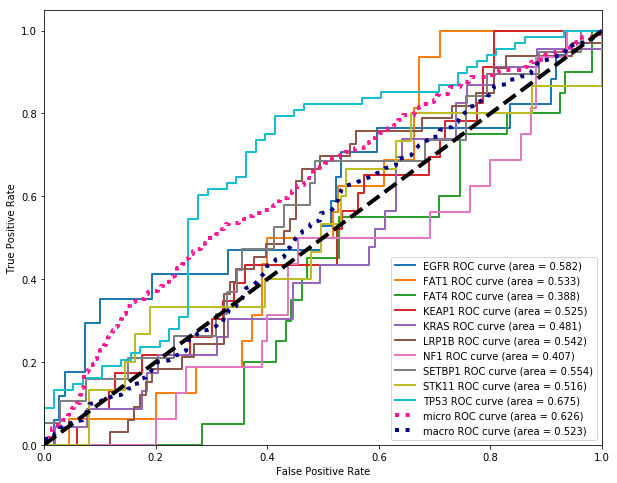

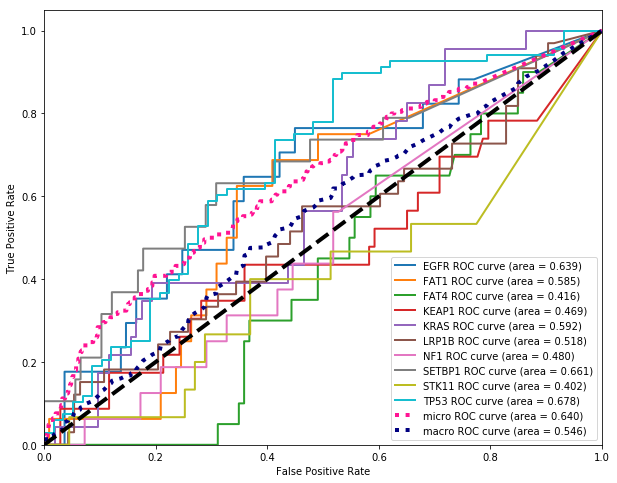

In [16]:
from utilities import draw_rocs
with open(p2.data_labels_path) as h:
    labels = [line.rstrip('\n') for line in h]
completed, current = completed_batches(p2.intermediate_checkpoints, p2.pretrained_checkpoints)
roc_curves_batch = join(p2.eval_results, '_' + completed, 'test_' + current + 'k')

# Draw curves based on average probability
roc_base = 'out2_roc_data_AvPb_'
draw_rocs(roc_base, roc_curves_batch, labels)

# Draw curves based on percent of correctly classified tiles
roc_base = 'out2_roc_data_PcSel_'
draw_rocs(roc_base, roc_curves_batch, labels)




In [15]:
completed, current = completed_batches(p2.intermediate_checkpoints, p2.pretrained_checkpoints)
roc_curves_batch = join(p2.eval_results, '_' + completed, 'test_' + current + 'k')
roc_curves_batch

'/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So3_Sort/Cl3FtTrue_Train/So4_Sort/Cl3FtTrue_Train/So10_Sort/Cl10FtFalse_Train/eval_results/_560000/test_120000k'

### Test

In [ ]:
# Save results to a batch specific directory
# Derive completed batches
with open(join(p2.intermediate_checkpoints,'checkpoint')) as f: 
    checkpoint_path = f.readline().split('"')[1]
completed = completed_batches(p2.intermediate_checkpoints, p2.pretrained_checkpoints)
#completed = str(batches + int(checkpoint_path.split('-')[-1]))
test_results_batch = join(p2.test_results,'_' + completed)
try:
    shutil.rmtree(test_results_batch)
except:
    pass
os.mkdir(test_results_batch)

func = join(deeppath_code,'02_testing/xClasses/nc_imagenet_eval.py' )
root = func.rsplit('/',1)[1].split('.')[0]

#Redirect output because Jupyter has a limit on test output
out_log_file = join(p2.training_logs,root+'.test.out.log')
err_log_file = join(p2.training_logs,root+'.test.err.log')

!python $func --checkpoint_dir=$p2.intermediate_checkpoints --eval_dir=$test_results_batch \
    --data_dir=$p2.test_records  --batch_size=$batch_size --ImageSet_basename='test_' --run_once \
    --ClassNumber=$p2.class_number --mode=$p2.training_mode --TVmode='test' > $out_log_file 2> $err_log_file



### Generate ROC curve data for testing results

In [ ]:
# Save results to a batch specific directory
# Derive completed batches
with open(join(p2.intermediate_checkpoints,'checkpoint')) as f: 
    checkpoint_path = f.readline().split('"')[1]
completed = completed_batches(p2.intermediate_checkpoints, p2.pretrained_checkpoints)
#completed = str(batches + int(checkpoint_path.split('-')[-1]))
roc_curves_batch = join(p2.roc_curves, '_' + completed)
print("Generating ROC curve data at {}".format(roc_curves_batch))
try:
    shutil.rmtree(roc_curves_batch)
except:
    pass
os.mkdir(roc_curves_batch)

func = join(deeppath_code, '03_postprocessing/0h_ROC_MultiOutput_BootStrap.py')
root = func.rsplit('/',1)[1].split('.')[0]

file_stats = join(p2.test_results, '_' + completed, 'out_filename_Stats.txt')
!python $func  --file_stats=$file_stats --output_dir=$roc_curves_batch  --labels_names=$p2.data_labels_path \
    --ref_stats=''



### Optionally save training results to GCS

In [ ]:
import tarfile

# Populate the tar file
# Note we don't save validation results.
loc = join(p2.training,'data.tar')
with tarfile.open(loc, "w") as tar:
    for name in [p2.intermediate_checkpoints, p2.training_logs,  p2.roc_curves,  p2.test_results]:
        tar.add(name)

# Copy it to GCS
gcs = join('gs://', deeppath_data_bucket, p2.training_path, 'data.tar')
!gsutil -m cp $loc $gcs 

# Delete the tar file
!rm $loc

## Analyze results

### Display ROC curves for testing results

In [ ]:
from utilities import draw_rocs
with open(p2.data_labels_path) as h:
    labels = [line.rstrip('\n') for line in h]
completed = completed_batches(p2.intermediate_checkpoints, p2.pretrained_checkpoints)
roc_curves_batch = join(p2.roc_curves, '_' + completed)

# Draw curves based on average probability
roc_base = 'out2_roc_data_AvPb_'
draw_rocs(roc_base, roc_curves_batch, labels)

# Draw curves based on percent of correctly classified tiles
roc_base = 'out2_roc_data_PcSel_'
draw_rocs(roc_base, roc_curves_batch, labels)




### Generate heatmaps of selected pathology images

In [ ]:
from IPython.display import Image
func = join(deeppath_code,'03_postprocessing/0f_HeatMap_nClasses.py' )
root = func.rsplit('/',1)[1].split('.')[0]

# Rendered tile size is reduced by the resample_factor
resample_factor = 10

# The Cmap parameter should be 'CancerType' for tumor classification, or one of the mutations,
# e.g. 'EGFR', 'STK11', etc. for mutation classification
cmap = 'EGFR'

try:
    shutil.rmtree(p2.heatmaps)
except:
    pass
os.mkdir(p2.heatmaps)

tile_stats = join(p2.test_results, 'out_filename_Stats.txt')
!python $func  --image_file=$p2.sorted_tiles --tiles_overlap=$overlap --output_dir=$p2.heatmaps \
    --tiles_stats=$tile_stats --resample_factor=$resample_factor  --filter_tile='' \
    --Cmap=$cmap --tiles_size=$tile_size



In [ ]:
Image("/home/bcliffor/tmp/j2.jpg")

In [ ]:
Image(join(tiling, 
  'px299/heatmaps/heatmap_CancerType_test_TCGA-NC-A5HR-01A-02-TS2.1B2A21A9-E685-461D-A3FF-42A0D9D7FC23_TCGA-LUSC.jpg'))

